In [1]:
pname = 'stokes'
n_params = 7

# NB: order training meshes by largest first
train_mesh_names = ['reference_mesh_large.csv']#, 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
train_solution_names = ['matrix_large.mat']#, 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

test_mesh_names = ['reference_mesh_large.csv', 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
test_solution_names = ['matrix_large.mat', 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

save_name = 'best_model_l_double.pt'

In [15]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random
import matplotlib.pyplot as plt

In [3]:
seed=10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# double precision
# explanation for when this is required at https://blog.demofox.org/2017/11/21/floating-point-precision/
precision = torch.float64
torch.set_default_dtype(precision)

## THE MODEL

In [4]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    Methods:
    __init__: initialises the master mesh, and master weight & biases for the 1st and last layer of the encoder and decoder, respectively
    expand: add all new expansive nodes in the new mesh to the weight matrices
    agglomerate: agglomerate nodes to fit the new mesh
    encoder: execute the encoder part
    decoder: execute the decoder part
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        self.mesh_n = self.mesh_m
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)

    def expand(self, mesh_n, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None, **kwargs):
        """
        Expand the new weights and biases with the new expansive nodes. If during training, update the master weights, biases & mesh.
        If during inference, then just apply the new ones.
        """
        
        # During evaluation, we will have fixed mesh_m so we don't want to recompute every time => option to pass in
        if nn_n is not None:
            pass
        elif kd_tree_n is not None:
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        else:
            kd_tree_m = KDTree(self.mesh_m)
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        # During training, we will have fixed fidelities that we know and don't need to always recompute
        if nn_m is not None:
            pass
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        if not self.training:
            # ! testing mode !
            
            # could assign with .data calls here but can't do for train https://discuss.pytorch.org/t/function-tbackward-returned-an-invalid-gradient-at-index-0-got-1-3-but-expected-shape-compatible-with-1-2/125259
            
            count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
            nodes_added = 0 # how much did we increase our master mesh

            for pt_n, pt_m in enumerate(nn_n):
                if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                    nodes_added += 1
                    self.mesh_n = np.vstack([self.mesh_n, mesh_n[pt_n]])
                    count_m[pt_m]+=1

                    # Divide encoder weights by number of expansions
                    self.We_n[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                    # Store the index of the weight we want
                    # so we can update at the end without storing
                    # all the nodes to update explictly
                    new_row = torch.zeros(1, self.We_n.shape[1])
                    new_row[0][0] = pt_m
                    self.We_n = torch.cat((self.We_n, new_row), dim=0)

                    # Duplicate weights for decoder
                    self.Wd_n = torch.cat((self.Wd_n, self.Wd_n[:, pt_m:pt_m+1]), dim=1)
                    self.bd_n = torch.cat([self.bd_n, self.bd_n[pt_m:pt_m+1]])

            # Loop over the nodes we need to update using the index we stored in the first element
            for i in range(self.mesh_m.shape[0], self.mesh_m.shape[0]+nodes_added):
                index = int(self.We_n[i,0])
                self.We_n[i] = self.We_n[index]
        else:
            # ! training mode !
            
            # Expansion step is essentially creating new weights from scratch
            # => ignore gradients and therefore allow for slicing on leaf tensor as required
            # (Unless we do something smarter with the gradient tree to track what we're doing...)
            with torch.no_grad():
                count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
                nodes_added = 0 # how much did we increase our master mesh
                size=self.mesh_m.shape[0]

                for pt_n, pt_m in enumerate(nn_n):
                    if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                        nodes_added += 1
                        self.mesh_m=np.vstack([self.mesh_m, mesh_n[pt_n]])
                        count_m[pt_m]+=1
                        
                        # Divide encoder weights by number of expansions
                        self.We_m[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, self.We_m.shape[1])
                        new_row[0][0] = pt_m
                        self.We_m = nn.Parameter(torch.cat((self.We_m, new_row), dim=0))
                        
                        # Duplicate weights for decoder
                        self.Wd_m = nn.Parameter(torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1))
                        self.bd_m = nn.Parameter(torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]]))
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(self.We_m[i,0])
                    self.We_m[i] = self.We_m[index]
            
            # now we need to track gradients from our new master weights
            self.We_n = self.We_m.clone()
            self.Wd_n = self.Wd_m.clone()
            self.bd_n = self.bd_m.clone()
        return nodes_added
        
    def agglomerate(self, mesh_n, kd_tree_n=None, nn_m=None, **kwargs):
        
        # known during training
        if nn_m is not None:
            pass
        # already found in expansion or already known during training
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]

        # FIND NEW WEIGHTS (AGGLOMERATIVE ONLY NOW)
        We_n = torch.zeros((mesh_n.shape[0], self.We_n.shape[1]), device=self.We_n.device)
        Wd_n = torch.zeros((self.We_n.shape[1], mesh_n.shape[0]), device=self.We_n.device)
        bd_n = torch.zeros(mesh_n.shape[0], device=self.We_n.device)

        count_n = np.zeros(mesh_n.shape[0])

        for m, pt_m in enumerate(self.mesh_n): # agglomerate
            nn_n = nn_m[m]
            count_n[nn_n]+=1
            We_n[nn_n] += self.We_n[m]
            Wd_n[:, nn_n] = ( (count_n[nn_n]-1)*Wd_n[:, nn_n] + self.Wd_n[:, m] )/count_n[nn_n]
            bd_n[nn_n] = ( (count_n[nn_n]-1)*bd_n[nn_n] + self.bd_n[m] )/count_n[nn_n]
          
        self.We_n = We_n
        self.Wd_n = Wd_n
        self.bd_n = bd_n
        
    def reset(self):
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        if not self.training:
            self.mesh_n = self.mesh_m
        
    def encoder(self, x, mesh_n, exp_enc=True, agg_enc=True, reset_enc=False, **kwargs):
        if reset_enc:
            self.reset()
        if exp_enc:
            self.expand(mesh_n, **kwargs)
        if agg_enc:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.We_n+self.be_m
        
    def decoder(self, x, mesh_n, exp_dec=True, agg_dec=True, reset_dec=False, **kwargs):
        if reset_dec:
            self.reset()
        if exp_dec:
            self.expand(mesh_n, **kwargs)
        if agg_dec:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.Wd_n+self.bd_n
    
class GCA(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, **kwargs):
        x_enc = self.act(self.GFN.encoder(x, mesh_n, **kwargs))
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = self.GFN.decoder(x_enc, mesh_n, **kwargs)
        
        return x_recon, x_enc, x_map

## SET UP TRAINING DATA

In [5]:
from itertools import product
import scipy
from sklearn import preprocessing

def get_params(pname='stokes'):
    if pname=='stokes':
        mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
        mus = []
        n_pts = [2]*(len(mu_range)-1)+[11]
        for i in range(len(mu_range)):
            mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
        return torch.tensor(np.array(list(product(*mus))), dtype=precision)
    elif pname=='graetz':
        mus = [np.linspace(1., 3., 10), np.linspace(0.01, 0.1, 20)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)
    elif pname=='advection':
        mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp), dtype=precision)),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))), dtype=precision)
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat(fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

C:\Users\oisin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
params = get_params(pname).to(dev)

dfs_train = [pd.read_csv(i, header=None).values for i in train_mesh_names]

sols_train = [get_scaled_data(i)[1].to(dev) for i in train_solution_names]

trajs = list(range(sols_train[0].shape[0]))
random.shuffle(trajs)
train_trajs, test_trajs = np.array_split(trajs, 2)
train_trajs = np.array_split(train_trajs, len(dfs_train))

# train_trajs = random.sample(range(704), 352)
# test_trajs =list(set(range(704))-set(train_trajs))
# train_trajs=[train_trajs[176:], train_trajs[:176]]

reconstruction error tensor(9.1108e-27)


## TRAIN THE MODEL

In [7]:
# initialisation
# NB - important to start with largest mesh since this is better for initialisation purposes
# and potential savings in no expansions are done
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

added_nodes

0

In [8]:
from tqdm import tqdm

In [9]:
model.train()

# now initialise our optimiser after we have conducted ALL expansions
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [10]:
best_loss = np.inf
EPOCHS = 5000
test_losses = []
train_losses = []

def criterion(x, x_recon, x_enc, x_map):
    return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

kd_tree_m = KDTree(model.GFN.mesh_m)
# we know ahead of time the nn_n and nn_ms since we know that the master mesh is never changing and our new meshes are fixed
nn_ns = [kd_tree_m.query(df, k=1)[1] for df in dfs_train]
nn_ms = [KDTree(df).query(model.GFN.mesh_m, k=1)[1] for df in dfs_train]

for i in tqdm(range(EPOCHS)):
    opt.zero_grad()

    U_train = sols_train[0][train_trajs[0]]
    params_train = params[train_trajs[0]]
    df_train = dfs_train[0]
    if added_nodes==0:
        # because added_nodes==0, we know we don't need to expand or agglom for the medium mesh
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
    else:
        # NEED TO TEST
        # we need to agglomerate because added_nodes>0. However, we do this all in the encoder first so we can avoid in the decoder
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])

    loss = criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]

    # other fidelities
    for j in range(1, len(dfs_train)):
        U_train = sols_train[j][train_trajs[j]]
        params_train = params[train_trajs[j]]
        df_train = dfs_train[j]
        
        # only need to agglom in training since we expanded as a preprocessing step
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
        loss += criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]
    
    loss /= np.sum([k.shape[0] for k in dfs_train])
    loss.backward()
    opt.step()
    
    train_loss = loss.item()
    
    with torch.no_grad():
        params_test = params[test_trajs]
        
        U_test = sols_train[0][test_trajs]
        df_test = dfs_train[0]

        if added_nodes==0:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
        else:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])
        test_loss = criterion(U_test, x_recon, x_enc, x_map).item()*df_test.shape[0]

        for j in range(1, len(dfs_train)):
            U_test = sols_train[j][test_trajs]
            df_test = dfs_train[j]
            
            # only need to agglom in training since we expanded as a preprocessing step
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
            test_loss += criterion(U_test, x_recon, x_enc, x_map).item()*df_train.shape[0]
        
        test_loss /= np.sum([k.shape[0] for k in dfs_train])
    
    print(f'Epoch {i}: train loss: {train_loss} | test loss: {test_loss}')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss<best_loss:
        best_loss=test_loss
        best_epoch = i
        torch.save(model.state_dict(), save_name)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Epoch 0: train loss: 10.288584674430043 | test loss: 9.668637972560301


  0%|                                                                                 | 2/5000 [00:00<10:46,  7.73it/s]

Epoch 1: train loss: 9.679747273532676 | test loss: 9.449702526549823


  0%|                                                                                 | 3/5000 [00:00<09:51,  8.44it/s]

Epoch 2: train loss: 9.414257996619638 | test loss: 9.40668158278015


  0%|                                                                                 | 4/5000 [00:00<09:40,  8.61it/s]

Epoch 3: train loss: 9.306118784729737 | test loss: 9.292085019380737


  0%|                                                                                 | 5/5000 [00:00<09:59,  8.33it/s]

Epoch 4: train loss: 9.206370217036609 | test loss: 9.060386402183635
Epoch 5: train loss: 8.975478577539052 | test loss: 8.753145572312157


  0%|                                                                                 | 7/5000 [00:00<09:18,  8.94it/s]

Epoch 6: train loss: 8.596857829782893 | test loss: 8.442198029143006


  0%|▏                                                                                | 8/5000 [00:00<09:21,  8.89it/s]

Epoch 7: train loss: 8.321207598895286 | test loss: 8.108423448553728


  0%|▏                                                                                | 9/5000 [00:01<09:06,  9.12it/s]

Epoch 8: train loss: 8.00448385976856 | test loss: 7.977803700719542


  0%|▏                                                                               | 10/5000 [00:01<09:03,  9.18it/s]

Epoch 9: train loss: 7.805860485123189 | test loss: 7.646916610296988


  0%|▏                                                                               | 11/5000 [00:01<09:02,  9.19it/s]

Epoch 10: train loss: 7.417409269580775 | test loss: 7.458963042369632


  0%|▏                                                                               | 12/5000 [00:01<09:07,  9.11it/s]

Epoch 11: train loss: 7.227485709935479 | test loss: 7.120259267243567


  0%|▏                                                                               | 13/5000 [00:01<08:57,  9.27it/s]

Epoch 12: train loss: 6.847811952410398 | test loss: 6.748462514156126


  0%|▏                                                                               | 14/5000 [00:01<09:06,  9.12it/s]

Epoch 13: train loss: 6.488529873772396 | test loss: 6.511332779706244


  0%|▏                                                                               | 15/5000 [00:01<08:54,  9.32it/s]

Epoch 14: train loss: 6.2228951049041585 | test loss: 6.301168249621182


  0%|▎                                                                               | 16/5000 [00:01<08:54,  9.32it/s]

Epoch 15: train loss: 5.993966066734406 | test loss: 6.1023371119434


  0%|▎                                                                               | 17/5000 [00:01<09:00,  9.22it/s]

Epoch 16: train loss: 5.759271905500889 | test loss: 5.9397701942262495
Epoch 17: train loss: 5.575918745159916 | test loss: 5.786193636461196


  0%|▎                                                                               | 19/5000 [00:02<08:36,  9.64it/s]

Epoch 18: train loss: 5.37712878131708 | test loss: 5.737242637887555
Epoch 19: train loss: 5.269630447890969 | test loss: 5.652384737363622


  0%|▎                                                                               | 21/5000 [00:02<08:17, 10.02it/s]

Epoch 20: train loss: 5.136430403776138 | test loss: 5.535332470441244


  0%|▎                                                                               | 22/5000 [00:02<08:18,  9.98it/s]

Epoch 21: train loss: 4.989667067281809 | test loss: 5.48175410698045


  0%|▍                                                                               | 24/5000 [00:02<07:47, 10.65it/s]

Epoch 22: train loss: 4.913099560324065 | test loss: 5.424644629898746
Epoch 23: train loss: 4.824913675600009 | test loss: 5.3349335486070375
Epoch 24: train loss: 4.71238083819604 | test loss: 5.260769072860839


  1%|▍                                                                               | 26/5000 [00:02<08:22,  9.89it/s]

Epoch 25: train loss: 4.6520421389988815 | test loss: 5.182931670211859


  1%|▍                                                                               | 27/5000 [00:02<08:28,  9.78it/s]

Epoch 26: train loss: 4.592651056358059 | test loss: 5.101312835937039


  1%|▍                                                                               | 29/5000 [00:03<08:05, 10.24it/s]

Epoch 27: train loss: 4.500765659905731 | test loss: 5.082537350008673
Epoch 28: train loss: 4.438994471937933 | test loss: 5.051208783523135
Epoch 29: train loss: 4.392519713361207 | test loss: 4.959078404372114


  1%|▍                                                                               | 31/5000 [00:03<08:24,  9.85it/s]

Epoch 30: train loss: 4.324218486824438 | test loss: 4.929138183477807
Epoch 31: train loss: 4.298801797809429 | test loss: 4.887588617028707


  1%|▌                                                                               | 34/5000 [00:03<08:48,  9.39it/s]

Epoch 32: train loss: 4.248787766446043 | test loss: 4.853090886957107
Epoch 33: train loss: 4.191328953539627 | test loss: 4.850985953112839


  1%|▌                                                                               | 35/5000 [00:03<08:57,  9.24it/s]

Epoch 34: train loss: 4.180036012066682 | test loss: 4.784222020054597
Epoch 35: train loss: 4.127195801593636 | test loss: 4.767976551998906


  1%|▌                                                                               | 38/5000 [00:04<09:31,  8.68it/s]

Epoch 36: train loss: 4.099762769711227 | test loss: 4.751741808517833
Epoch 37: train loss: 4.047574630295911 | test loss: 4.7537620527502655


  1%|▋                                                                               | 41/5000 [00:04<08:34,  9.63it/s]

Epoch 38: train loss: 4.0052096872411305 | test loss: 4.751528390195069
Epoch 39: train loss: 3.9635283315367316 | test loss: 4.708755246484608
Epoch 40: train loss: 3.90685318124653 | test loss: 4.7795264878017845


  1%|▋                                                                               | 42/5000 [00:04<08:30,  9.71it/s]

Epoch 41: train loss: 3.960563070706631 | test loss: 4.680174483706069
Epoch 42: train loss: 3.921936935068653 | test loss: 4.64650272405951
Epoch 43: train loss: 3.8502204839677017 | test loss: 4.6216788138327844


  1%|▋                                                                               | 45/5000 [00:04<09:03,  9.11it/s]

Epoch 44: train loss: 3.81600660024207 | test loss: 4.592964366343726


  1%|▊                                                                               | 48/5000 [00:05<08:08, 10.14it/s]

Epoch 45: train loss: 3.7825626428792 | test loss: 4.5785495973284025
Epoch 46: train loss: 3.7670951669407478 | test loss: 4.562071131094512
Epoch 47: train loss: 3.7357214613023557 | test loss: 4.51054805733252


  1%|▊                                                                               | 50/5000 [00:05<08:41,  9.49it/s]

Epoch 48: train loss: 3.6912399637913014 | test loss: 4.458535579205642
Epoch 49: train loss: 3.656304752699982 | test loss: 4.434024858945069
Epoch 50: train loss: 3.6157695378779686 | test loss: 4.422734066779933


  1%|▊                                                                               | 52/5000 [00:05<08:12, 10.04it/s]

Epoch 51: train loss: 3.5761382750461053 | test loss: 4.385215547185314
Epoch 52: train loss: 3.5328490775170023 | test loss: 4.335104269971947
Epoch 53: train loss: 3.4865219032467127 | test loss: 4.298221689462575


  1%|▉                                                                               | 56/5000 [00:05<08:05, 10.19it/s]

Epoch 54: train loss: 3.435941727382406 | test loss: 4.268140592199395
Epoch 55: train loss: 3.39153596814452 | test loss: 4.222986210001353
Epoch 56: train loss: 3.3372781479223623 | test loss: 4.185168379905361


  1%|▉                                                                               | 58/5000 [00:06<07:48, 10.56it/s]

Epoch 57: train loss: 3.292503481338129 | test loss: 4.141662221719369
Epoch 58: train loss: 3.2390943347227434 | test loss: 4.112136093101059


  1%|▉                                                                               | 60/5000 [00:06<08:12, 10.03it/s]

Epoch 59: train loss: 3.1959081854463975 | test loss: 4.050354187885627
Epoch 60: train loss: 3.150177079182292 | test loss: 4.017735543641821


  1%|█                                                                               | 63/5000 [00:06<08:34,  9.59it/s]

Epoch 61: train loss: 3.108821037742508 | test loss: 3.9574722981867763
Epoch 62: train loss: 3.05952420231261 | test loss: 3.9092679151780505


  1%|█                                                                               | 64/5000 [00:06<08:38,  9.53it/s]

Epoch 63: train loss: 3.015677135352088 | test loss: 3.9028561312040173
Epoch 64: train loss: 2.994744131610119 | test loss: 3.8673481828536143
Epoch 65: train loss: 2.986059852132322 | test loss: 3.800342297222614


  1%|█                                                                               | 68/5000 [00:07<08:05, 10.15it/s]

Epoch 66: train loss: 2.916536127295701 | test loss: 3.8114880100740676
Epoch 67: train loss: 2.9071948318210232 | test loss: 3.7740088006493804


  1%|█                                                                               | 70/5000 [00:07<09:01,  9.11it/s]

Epoch 68: train loss: 2.863838532072872 | test loss: 3.7440361176495687
Epoch 69: train loss: 2.851177743371036 | test loss: 3.747526981982338
Epoch 70: train loss: 2.8374389874365598 | test loss: 3.7442804063828894


  1%|█▏                                                                              | 72/5000 [00:07<09:11,  8.94it/s]

Epoch 71: train loss: 2.805661399126133 | test loss: 3.7416520857652498


  2%|█▏                                                                              | 75/5000 [00:07<08:17,  9.91it/s]

Epoch 72: train loss: 2.7863360601412195 | test loss: 3.709414198488302
Epoch 73: train loss: 2.7550077557741126 | test loss: 3.710782661990124
Epoch 74: train loss: 2.737891749424976 | test loss: 3.6688122700447208


  2%|█▏                                                                              | 77/5000 [00:08<08:29,  9.66it/s]

Epoch 75: train loss: 2.727748029807689 | test loss: 3.653444362545942
Epoch 76: train loss: 2.6978772890049667 | test loss: 3.6621713431290583


  2%|█▎                                                                              | 79/5000 [00:08<08:21,  9.81it/s]

Epoch 77: train loss: 2.6926197044984006 | test loss: 3.6494738372425504
Epoch 78: train loss: 2.6609116365161958 | test loss: 3.6260306258386032


  2%|█▎                                                                              | 81/5000 [00:08<08:18,  9.86it/s]

Epoch 79: train loss: 2.642836335304952 | test loss: 3.5997698962469618
Epoch 80: train loss: 2.6391198301200167 | test loss: 3.609847862538687
Epoch 81: train loss: 2.600128522694602 | test loss: 3.5973696840334926


  2%|█▎                                                                              | 85/5000 [00:08<07:35, 10.80it/s]

Epoch 82: train loss: 2.573123710484544 | test loss: 3.56345787349822
Epoch 83: train loss: 2.5629736291801564 | test loss: 3.6097070888763523
Epoch 84: train loss: 2.5934224462644484 | test loss: 3.4806597462369404


  2%|█▍                                                                              | 87/5000 [00:09<07:38, 10.71it/s]

Epoch 85: train loss: 2.5312266077025254 | test loss: 3.4782547485510005
Epoch 86: train loss: 2.5381174189684117 | test loss: 3.454775038411688


  2%|█▍                                                                              | 89/5000 [00:09<07:44, 10.58it/s]

Epoch 87: train loss: 2.5115139505211994 | test loss: 3.4322334890020434
Epoch 88: train loss: 2.4844613666754234 | test loss: 3.422274174714345
Epoch 89: train loss: 2.463350734753157 | test loss: 3.3970856384006196


  2%|█▍                                                                              | 93/5000 [00:09<07:49, 10.45it/s]

Epoch 90: train loss: 2.426507125129933 | test loss: 3.3538772984939005
Epoch 91: train loss: 2.407782213343018 | test loss: 3.3245560675630936
Epoch 92: train loss: 2.3984796747410293 | test loss: 3.352039237725668


  2%|█▌                                                                              | 95/5000 [00:09<07:43, 10.58it/s]

Epoch 93: train loss: 2.429176487045478 | test loss: 3.308562035581329
Epoch 94: train loss: 2.3756821422468306 | test loss: 3.2875461570604956
Epoch 95: train loss: 2.3356446822000723 | test loss: 3.2931125448487326


  2%|█▌                                                                              | 97/5000 [00:09<07:42, 10.60it/s]

Epoch 96: train loss: 2.346415723322677 | test loss: 3.2463635351149125
Epoch 97: train loss: 2.317821363213647 | test loss: 3.2321533880956816


  2%|█▌                                                                             | 101/5000 [00:10<07:51, 10.39it/s]

Epoch 98: train loss: 2.3030744488714303 | test loss: 3.160929925952357
Epoch 99: train loss: 2.2673413244448244 | test loss: 3.151345271170871
Epoch 100: train loss: 2.2581829626196726 | test loss: 3.1577698070970075


  2%|█▋                                                                             | 103/5000 [00:10<07:42, 10.60it/s]

Epoch 101: train loss: 2.2291705028673556 | test loss: 3.125646691084997
Epoch 102: train loss: 2.2122056671251906 | test loss: 3.099528445032421
Epoch 103: train loss: 2.1888558543942063 | test loss: 3.138009260281537


  2%|█▋                                                                             | 105/5000 [00:10<07:51, 10.39it/s]

Epoch 104: train loss: 2.1887079009623216 | test loss: 3.0722281586971993
Epoch 105: train loss: 2.151109103271903 | test loss: 3.045536415861603
Epoch 106: train loss: 2.125827528461343 | test loss: 3.0426332038471595


  2%|█▋                                                                             | 109/5000 [00:11<07:56, 10.26it/s]

Epoch 107: train loss: 2.116066476294029 | test loss: 3.011428566334617
Epoch 108: train loss: 2.09446034137529 | test loss: 2.962155547422425
Epoch 109: train loss: 2.06548558794417 | test loss: 2.976643049969052


  2%|█▊                                                                             | 111/5000 [00:11<07:48, 10.44it/s]

Epoch 110: train loss: 2.058868307421881 | test loss: 2.934815565999755
Epoch 111: train loss: 2.032569358434696 | test loss: 2.906575900954353
Epoch 112: train loss: 2.0087413088304262 | test loss: 2.8513475542521816


  2%|█▊                                                                             | 115/5000 [00:11<07:43, 10.54it/s]

Epoch 113: train loss: 1.987881357222971 | test loss: 2.887598505216815
Epoch 114: train loss: 1.989070021025781 | test loss: 2.8277281918013166
Epoch 115: train loss: 1.9703339746243134 | test loss: 2.781709830862428


  2%|█▊                                                                             | 117/5000 [00:11<07:21, 11.05it/s]

Epoch 116: train loss: 1.92881474652432 | test loss: 2.7881150558776824
Epoch 117: train loss: 1.9291698298555242 | test loss: 2.746413570208807
Epoch 118: train loss: 1.8933902534355598 | test loss: 2.725604936604123


  2%|█▉                                                                             | 121/5000 [00:12<07:47, 10.44it/s]

Epoch 119: train loss: 1.8653882464210538 | test loss: 2.723633260906252
Epoch 120: train loss: 1.8556178703518198 | test loss: 2.667737682583976


  2%|█▉                                                                             | 123/5000 [00:12<07:48, 10.40it/s]

Epoch 121: train loss: 1.8663207925198766 | test loss: 2.644168422330962
Epoch 122: train loss: 1.8098762982178074 | test loss: 2.634069849371044
Epoch 123: train loss: 1.7988882571029543 | test loss: 2.6039477743778976


  2%|█▉                                                                             | 125/5000 [00:12<07:58, 10.18it/s]

Epoch 124: train loss: 1.7721131242667942 | test loss: 2.5949890517050664
Epoch 125: train loss: 1.7520216959269492 | test loss: 2.564084289006758
Epoch 126: train loss: 1.7321630064115112 | test loss: 2.517450686542055


  3%|██                                                                             | 129/5000 [00:13<07:46, 10.44it/s]

Epoch 127: train loss: 1.704754067951341 | test loss: 2.461581351872285
Epoch 128: train loss: 1.6714628251075103 | test loss: 2.444508023126965
Epoch 129: train loss: 1.6397480736678156 | test loss: 2.455971562361383


  3%|██                                                                             | 131/5000 [00:13<07:53, 10.28it/s]

Epoch 130: train loss: 1.6231810190705773 | test loss: 2.4360526848658877
Epoch 131: train loss: 1.6090623409350557 | test loss: 2.415411755750544
Epoch 132: train loss: 1.5853439897300254 | test loss: 2.3715128143909894


  3%|██▏                                                                            | 135/5000 [00:13<07:47, 10.40it/s]

Epoch 133: train loss: 1.568828955605705 | test loss: 2.3476073386690577
Epoch 134: train loss: 1.543695133368847 | test loss: 2.340387771050745


  3%|██▏                                                                            | 137/5000 [00:13<07:54, 10.25it/s]

Epoch 135: train loss: 1.533102385115495 | test loss: 2.309002841263947
Epoch 136: train loss: 1.5249939410864772 | test loss: 2.277811242753597
Epoch 137: train loss: 1.4977535946444507 | test loss: 2.287896377701924


  3%|██▏                                                                            | 139/5000 [00:14<07:47, 10.41it/s]

Epoch 138: train loss: 1.5030041260768008 | test loss: 2.2729438266140516
Epoch 139: train loss: 1.4655332938609862 | test loss: 2.236743136027635


  3%|██▏                                                                            | 141/5000 [00:14<08:01, 10.09it/s]

Epoch 140: train loss: 1.4206744154467825 | test loss: 2.19595451713588
Epoch 141: train loss: 1.4270616029927097 | test loss: 2.141390091173896
Epoch 142: train loss: 1.375586032804044 | test loss: 2.1347055692350403


  3%|██▎                                                                            | 145/5000 [00:14<07:46, 10.41it/s]

Epoch 143: train loss: 1.3629475678545653 | test loss: 2.146710573016773
Epoch 144: train loss: 1.3479811491048335 | test loss: 2.146602174858021
Epoch 145: train loss: 1.308131768330369 | test loss: 2.143693919213742


  3%|██▎                                                                            | 147/5000 [00:14<07:40, 10.54it/s]

Epoch 146: train loss: 1.2957908825806403 | test loss: 2.0945388047049125
Epoch 147: train loss: 1.2744513547355165 | test loss: 2.048307832398609


  3%|██▍                                                                            | 151/5000 [00:15<07:35, 10.65it/s]

Epoch 148: train loss: 1.2456733105319335 | test loss: 2.0309320167681677
Epoch 149: train loss: 1.2409330096030637 | test loss: 2.0113513447765246
Epoch 150: train loss: 1.2104865538238285 | test loss: 2.01567924399162


  3%|██▍                                                                            | 153/5000 [00:15<07:41, 10.51it/s]

Epoch 151: train loss: 1.1965982153410222 | test loss: 2.0229730293198562
Epoch 152: train loss: 1.1864216062786714 | test loss: 2.0153606511146736
Epoch 153: train loss: 1.1608666822536473 | test loss: 1.982465287523301


  3%|██▍                                                                            | 155/5000 [00:15<07:37, 10.58it/s]

Epoch 154: train loss: 1.1440302023080695 | test loss: 1.939134055638946
Epoch 155: train loss: 1.1293082622950847 | test loss: 1.9149390308712575
Epoch 156: train loss: 1.11498338565652 | test loss: 1.9144248030359226


  3%|██▌                                                                            | 159/5000 [00:15<07:35, 10.63it/s]

Epoch 157: train loss: 1.1024814382174002 | test loss: 1.9330522693436571
Epoch 158: train loss: 1.0906800412037563 | test loss: 1.9434035437042714
Epoch 159: train loss: 1.0769828447841538 | test loss: 1.9253233858958791


  3%|██▌                                                                            | 161/5000 [00:16<07:32, 10.70it/s]

Epoch 160: train loss: 1.0621481624575502 | test loss: 1.8908759879392611
Epoch 161: train loss: 1.0517924750953531 | test loss: 1.8655959698986513


  3%|██▌                                                                            | 163/5000 [00:16<08:00, 10.06it/s]

Epoch 162: train loss: 1.0446780521215966 | test loss: 1.845886213027593
Epoch 163: train loss: 1.0335996302067254 | test loss: 1.8563459703599974


  3%|██▌                                                                            | 166/5000 [00:16<08:17,  9.71it/s]

Epoch 164: train loss: 1.0299463586473072 | test loss: 1.8829768490199963
Epoch 165: train loss: 1.0186870754510833 | test loss: 1.8689127151664462


  3%|██▋                                                                            | 168/5000 [00:16<08:46,  9.18it/s]

Epoch 166: train loss: 1.0115883406046045 | test loss: 1.8362104320183694
Epoch 167: train loss: 0.9933755524909738 | test loss: 1.8094350324691386


  3%|██▋                                                                            | 170/5000 [00:17<08:31,  9.45it/s]

Epoch 168: train loss: 0.9995942942734912 | test loss: 1.7896164763170408
Epoch 169: train loss: 0.9795214454599404 | test loss: 1.79287583449827
Epoch 170: train loss: 0.9811023316663323 | test loss: 1.8088961151642033


  3%|██▋                                                                            | 173/5000 [00:17<08:23,  9.60it/s]

Epoch 171: train loss: 0.9635219251153377 | test loss: 1.8180768295326182
Epoch 172: train loss: 0.9597474391628849 | test loss: 1.7896983419638999


  4%|██▊                                                                            | 175/5000 [00:17<08:12,  9.80it/s]

Epoch 173: train loss: 0.9482010161723022 | test loss: 1.7608823040814698
Epoch 174: train loss: 0.945789198320099 | test loss: 1.7490544202211646
Epoch 175: train loss: 0.9443519222594776 | test loss: 1.7549193507269534


  4%|██▊                                                                            | 177/5000 [00:17<07:41, 10.45it/s]

Epoch 176: train loss: 0.9359504890065062 | test loss: 1.7693367523020522
Epoch 177: train loss: 0.9251133161178835 | test loss: 1.76896986649243
Epoch 178: train loss: 0.9316303812114781 | test loss: 1.747037091421109


  4%|██▊                                                                            | 181/5000 [00:18<07:39, 10.48it/s]

Epoch 179: train loss: 0.9210423407357567 | test loss: 1.7287588763277042
Epoch 180: train loss: 0.9253557163524484 | test loss: 1.724354117025841
Epoch 181: train loss: 0.9160620615239442 | test loss: 1.72453543872071


  4%|██▉                                                                            | 183/5000 [00:18<07:38, 10.50it/s]

Epoch 182: train loss: 0.9043312944045172 | test loss: 1.7256698637269134
Epoch 183: train loss: 0.9214633806869305 | test loss: 1.7065301521188727
Epoch 184: train loss: 0.8948926257307593 | test loss: 1.6887200927672807


  4%|██▉                                                                            | 187/5000 [00:18<07:41, 10.44it/s]

Epoch 185: train loss: 0.895194462203907 | test loss: 1.6861854989929403
Epoch 186: train loss: 0.8961131223884667 | test loss: 1.701050016475149
Epoch 187: train loss: 0.8903949007861635 | test loss: 1.7163623799080083


  4%|██▉                                                                            | 189/5000 [00:18<07:30, 10.69it/s]

Epoch 188: train loss: 0.8825009340325345 | test loss: 1.708925881440187
Epoch 189: train loss: 0.8824217222726709 | test loss: 1.678229882110363


  4%|███                                                                            | 191/5000 [00:19<07:38, 10.49it/s]

Epoch 190: train loss: 0.8827776601105268 | test loss: 1.6597429157596792
Epoch 191: train loss: 0.8779064302531331 | test loss: 1.6672554818050989


  4%|███                                                                            | 195/5000 [00:19<07:21, 10.87it/s]

Epoch 192: train loss: 0.8760579416918846 | test loss: 1.680603953412719
Epoch 193: train loss: 0.8676675500492474 | test loss: 1.6914215570464814
Epoch 194: train loss: 0.8699246433193513 | test loss: 1.6751237542864519


  4%|███                                                                            | 197/5000 [00:19<07:45, 10.33it/s]

Epoch 195: train loss: 0.859503015611371 | test loss: 1.6514168603319492
Epoch 196: train loss: 0.8603786211771195 | test loss: 1.6365399385354058


  4%|███▏                                                                           | 199/5000 [00:19<07:52, 10.15it/s]

Epoch 197: train loss: 0.8594498599521186 | test loss: 1.6331763069445804
Epoch 198: train loss: 0.8506810313134875 | test loss: 1.6383363120578007


  4%|███▏                                                                           | 201/5000 [00:20<07:42, 10.38it/s]

Epoch 199: train loss: 0.848159493038827 | test loss: 1.6401968357181973
Epoch 200: train loss: 0.8505878085826035 | test loss: 1.6349571024429568
Epoch 201: train loss: 0.8435780211730877 | test loss: 1.6413612437126113


  4%|███▏                                                                           | 203/5000 [00:20<07:36, 10.50it/s]

Epoch 202: train loss: 0.845879347945212 | test loss: 1.646094609672561
Epoch 203: train loss: 0.8446193005087093 | test loss: 1.641772675327831


  4%|███▏                                                                           | 205/5000 [00:20<07:50, 10.18it/s]

Epoch 204: train loss: 0.8440175023843948 | test loss: 1.6254953852410596
Epoch 205: train loss: 0.8374749284211449 | test loss: 1.6095119451065618
Epoch 206: train loss: 0.8326429717807422 | test loss: 1.6062105175727484


  4%|███▎                                                                           | 209/5000 [00:20<07:47, 10.25it/s]

Epoch 207: train loss: 0.831479542111513 | test loss: 1.605320786029613
Epoch 208: train loss: 0.8361075402019216 | test loss: 1.5980586987256578


  4%|███▎                                                                           | 211/5000 [00:21<07:34, 10.54it/s]

Epoch 209: train loss: 0.8274151716629079 | test loss: 1.6037449912125683
Epoch 210: train loss: 0.8299272087730657 | test loss: 1.6065454142579023
Epoch 211: train loss: 0.8318588607834752 | test loss: 1.6083847381287317


  4%|███▎                                                                           | 213/5000 [00:21<07:19, 10.90it/s]

Epoch 212: train loss: 0.8288022808127402 | test loss: 1.6090814314562656
Epoch 213: train loss: 0.8239972772533944 | test loss: 1.6018506571337507
Epoch 214: train loss: 0.8193827986795301 | test loss: 1.5883990852956011


  4%|███▍                                                                           | 217/5000 [00:21<07:34, 10.52it/s]

Epoch 215: train loss: 0.8180224787049182 | test loss: 1.567106751005484
Epoch 216: train loss: 0.824286111611212 | test loss: 1.547420008823161
Epoch 217: train loss: 0.8155504390624914 | test loss: 1.558087476601292


  4%|███▍                                                                           | 219/5000 [00:21<07:29, 10.63it/s]

Epoch 218: train loss: 0.8157831353458536 | test loss: 1.584102445579716
Epoch 219: train loss: 0.8169666728595375 | test loss: 1.6029018975286182


  4%|███▍                                                                           | 221/5000 [00:21<07:42, 10.33it/s]

Epoch 220: train loss: 0.8170021064578589 | test loss: 1.6041262536153549
Epoch 221: train loss: 0.8158796886526367 | test loss: 1.5897379830235732


  4%|███▌                                                                           | 225/5000 [00:22<07:42, 10.33it/s]

Epoch 222: train loss: 0.8134650102433554 | test loss: 1.5694702865529706
Epoch 223: train loss: 0.809417649894079 | test loss: 1.5550331496217256
Epoch 224: train loss: 0.8065732090286125 | test loss: 1.5518733405947955


  5%|███▌                                                                           | 227/5000 [00:22<07:38, 10.40it/s]

Epoch 225: train loss: 0.8050928944175033 | test loss: 1.5526785099041458
Epoch 226: train loss: 0.8075302870144311 | test loss: 1.549063508315027
Epoch 227: train loss: 0.8031580162969933 | test loss: 1.550187082277459


  5%|███▋                                                                           | 231/5000 [00:22<07:19, 10.85it/s]

Epoch 228: train loss: 0.8017149693134603 | test loss: 1.5558782962393825
Epoch 229: train loss: 0.8009568294524216 | test loss: 1.5604843709247243
Epoch 230: train loss: 0.8003769371788303 | test loss: 1.5616264805004834


  5%|███▋                                                                           | 233/5000 [00:23<07:21, 10.79it/s]

Epoch 231: train loss: 0.7999777655442109 | test loss: 1.5585340387612412
Epoch 232: train loss: 0.7990726675177623 | test loss: 1.5528366352877732
Epoch 233: train loss: 0.7974307954949621 | test loss: 1.5475492250047056


  5%|███▋                                                                           | 237/5000 [00:23<07:16, 10.92it/s]

Epoch 234: train loss: 0.795924291394671 | test loss: 1.5426512248891315
Epoch 235: train loss: 0.7948008296026333 | test loss: 1.537292474859376
Epoch 236: train loss: 0.7943853344334595 | test loss: 1.531970747685145


  5%|███▊                                                                           | 239/5000 [00:23<07:16, 10.90it/s]

Epoch 237: train loss: 0.793991722340514 | test loss: 1.5282808132940113
Epoch 238: train loss: 0.7927638568665761 | test loss: 1.5273321709013035
Epoch 239: train loss: 0.7914729101669402 | test loss: 1.5289480022281423


  5%|███▊                                                                           | 243/5000 [00:23<06:55, 11.46it/s]

Epoch 240: train loss: 0.7907611388001647 | test loss: 1.5325317968043495
Epoch 241: train loss: 0.7901556178160571 | test loss: 1.536603511670784
Epoch 242: train loss: 0.7895438269717879 | test loss: 1.5383623520116028


  5%|███▊                                                                           | 245/5000 [00:24<06:54, 11.48it/s]

Epoch 243: train loss: 0.7887335290104868 | test loss: 1.5361974572867176
Epoch 244: train loss: 0.7877716091310278 | test loss: 1.5308928389796064
Epoch 245: train loss: 0.7869190392480986 | test loss: 1.5246428678592854


  5%|███▉                                                                           | 249/5000 [00:24<07:12, 10.99it/s]

Epoch 246: train loss: 0.7863369686419104 | test loss: 1.5202966596298872
Epoch 247: train loss: 0.7858826340675217 | test loss: 1.5199765329424795
Epoch 248: train loss: 0.7851614052218321 | test loss: 1.5232044292872278


  5%|███▉                                                                           | 251/5000 [00:24<07:04, 11.19it/s]

Epoch 249: train loss: 0.7844168725513889 | test loss: 1.5271828830383076
Epoch 250: train loss: 0.7838548087870559 | test loss: 1.5294632193585453
Epoch 251: train loss: 0.7833350089301001 | test loss: 1.5293862405313274


  5%|████                                                                           | 255/5000 [00:25<06:46, 11.68it/s]

Epoch 252: train loss: 0.7827297918013746 | test loss: 1.5271914299702356
Epoch 253: train loss: 0.7820463893454738 | test loss: 1.5233503889191198
Epoch 254: train loss: 0.7814377169857065 | test loss: 1.5189375984713895


  5%|████                                                                           | 257/5000 [00:25<06:59, 11.31it/s]

Epoch 255: train loss: 0.7809404294033353 | test loss: 1.5158107203785964
Epoch 256: train loss: 0.7804259252854809 | test loss: 1.5154854179234827
Epoch 257: train loss: 0.7798379857519347 | test loss: 1.5176169360521008


  5%|████                                                                           | 261/5000 [00:25<06:51, 11.50it/s]

Epoch 258: train loss: 0.7792778321867251 | test loss: 1.52013080013573
Epoch 259: train loss: 0.778771918995218 | test loss: 1.5211090153756848
Epoch 260: train loss: 0.778264612343209 | test loss: 1.5200870092421233


  5%|████▏                                                                          | 263/5000 [00:25<06:52, 11.49it/s]

Epoch 261: train loss: 0.7777293712774513 | test loss: 1.5175836352207424
Epoch 262: train loss: 0.7772064548177263 | test loss: 1.5144959323079976
Epoch 263: train loss: 0.776730149106114 | test loss: 1.5120960124760434


  5%|████▏                                                                          | 267/5000 [00:26<06:42, 11.76it/s]

Epoch 264: train loss: 0.7762619041711264 | test loss: 1.5114460832754222
Epoch 265: train loss: 0.7757812357825611 | test loss: 1.5124954863206268
Epoch 266: train loss: 0.7753265636682193 | test loss: 1.5141718061010496


  5%|████▎                                                                          | 269/5000 [00:26<07:00, 11.25it/s]

Epoch 267: train loss: 0.77488365111607 | test loss: 1.5152426398985974
Epoch 268: train loss: 0.7744287317776665 | test loss: 1.5149657310301659
Epoch 269: train loss: 0.7739897950427401 | test loss: 1.5134272504619757


  5%|████▎                                                                          | 273/5000 [00:26<07:13, 10.92it/s]

Epoch 270: train loss: 0.7735694705492595 | test loss: 1.511537409140652
Epoch 271: train loss: 0.7731457658507214 | test loss: 1.5102270539250302
Epoch 272: train loss: 0.7727302475705793 | test loss: 1.5096623401093767


  6%|████▎                                                                          | 275/5000 [00:26<07:23, 10.66it/s]

Epoch 273: train loss: 0.7723265608452298 | test loss: 1.5094246759041117
Epoch 274: train loss: 0.771922254052104 | test loss: 1.5090799964178458


  6%|████▍                                                                          | 277/5000 [00:27<07:58,  9.87it/s]

Epoch 275: train loss: 0.7715281900000606 | test loss: 1.5084491742636184
Epoch 276: train loss: 0.7711393554470063 | test loss: 1.5077446555606528
Epoch 277: train loss: 0.7707472969248348 | test loss: 1.5073804530408472


  6%|████▍                                                                          | 279/5000 [00:27<07:41, 10.23it/s]

Epoch 278: train loss: 0.7703670883510552 | test loss: 1.5073438379334412
Epoch 279: train loss: 0.7699959935193683 | test loss: 1.5070808642397533
Epoch 280: train loss: 0.7696259914268966 | test loss: 1.5062589926834247


  6%|████▍                                                                          | 283/5000 [00:27<07:50, 10.03it/s]

Epoch 281: train loss: 0.7692597841243075 | test loss: 1.5052237146702279
Epoch 282: train loss: 0.7688983288101603 | test loss: 1.504509508580816
Epoch 283: train loss: 0.7685425550194588 | test loss: 1.5043028797382212


  6%|████▌                                                                          | 287/5000 [00:27<07:24, 10.59it/s]

Epoch 284: train loss: 0.7681900424840957 | test loss: 1.5044622687117188
Epoch 285: train loss: 0.7678382502377901 | test loss: 1.5046894240181126
Epoch 286: train loss: 0.7674921708919954 | test loss: 1.5046992421568943


  6%|████▌                                                                          | 289/5000 [00:28<07:11, 10.91it/s]

Epoch 287: train loss: 0.7671521192391819 | test loss: 1.5044976397074286
Epoch 288: train loss: 0.7668132475759648 | test loss: 1.5044052096014313
Epoch 289: train loss: 0.7664779802896015 | test loss: 1.5046603314485647


  6%|████▌                                                                          | 291/5000 [00:28<07:50, 10.01it/s]

Epoch 290: train loss: 0.7661475499875015 | test loss: 1.5051338610862426
Epoch 291: train loss: 0.7658195143789955 | test loss: 1.5055027644529253


  6%|████▋                                                                          | 295/5000 [00:28<07:19, 10.70it/s]

Epoch 292: train loss: 0.7654949508541334 | test loss: 1.5056041356564227
Epoch 293: train loss: 0.7651731848524674 | test loss: 1.505600438581983
Epoch 294: train loss: 0.7648543370688861 | test loss: 1.5058231061292822


  6%|████▋                                                                          | 297/5000 [00:28<07:08, 10.97it/s]

Epoch 295: train loss: 0.7645393361024594 | test loss: 1.5064548795487915
Epoch 296: train loss: 0.7642268106250698 | test loss: 1.5073950865690033
Epoch 297: train loss: 0.7639161577109451 | test loss: 1.5084263732999301


  6%|████▊                                                                          | 301/5000 [00:29<06:56, 11.27it/s]

Epoch 298: train loss: 0.7636086543144461 | test loss: 1.5094007624591448
Epoch 299: train loss: 0.763303792618792 | test loss: 1.5102374074313771
Epoch 300: train loss: 0.7630002540514582 | test loss: 1.5109132201643518


  6%|████▊                                                                          | 303/5000 [00:29<06:37, 11.81it/s]

Epoch 301: train loss: 0.7626982997126699 | test loss: 1.511552979474577
Epoch 302: train loss: 0.7623986472872408 | test loss: 1.5123891739599338
Epoch 303: train loss: 0.7621012858274798 | test loss: 1.5135403344499383


  6%|████▊                                                                          | 307/5000 [00:29<06:40, 11.73it/s]

Epoch 304: train loss: 0.7618058583587426 | test loss: 1.5149101738265172
Epoch 305: train loss: 0.7615129879956787 | test loss: 1.5163101024784529
Epoch 306: train loss: 0.761224188748178 | test loss: 1.5175959319782595


  6%|████▉                                                                          | 309/5000 [00:29<06:48, 11.48it/s]

Epoch 307: train loss: 0.760940252787357 | test loss: 1.5187206540172526
Epoch 308: train loss: 0.7606613176360519 | test loss: 1.5197373680000095
Epoch 309: train loss: 0.76038704603953 | test loss: 1.520735100019047


  6%|████▉                                                                          | 313/5000 [00:30<06:51, 11.40it/s]

Epoch 310: train loss: 0.7601156804190541 | test loss: 1.521734461349031
Epoch 311: train loss: 0.7598449023019536 | test loss: 1.522656618866971
Epoch 312: train loss: 0.7595723731528536 | test loss: 1.5234146234981147


  6%|████▉                                                                          | 315/5000 [00:30<06:59, 11.17it/s]

Epoch 313: train loss: 0.7592969303658464 | test loss: 1.5240147797370207
Epoch 314: train loss: 0.7590194002811722 | test loss: 1.5245432750679626
Epoch 315: train loss: 0.7587413993344418 | test loss: 1.5250737085434072


  6%|█████                                                                          | 319/5000 [00:30<06:41, 11.65it/s]

Epoch 316: train loss: 0.7584641591471306 | test loss: 1.5256064043566187
Epoch 317: train loss: 0.758188169581159 | test loss: 1.5260826703844013
Epoch 318: train loss: 0.7579135289902734 | test loss: 1.5264480142528876


  6%|█████                                                                          | 321/5000 [00:31<07:03, 11.05it/s]

Epoch 319: train loss: 0.7576398272471586 | test loss: 1.526725923969504
Epoch 320: train loss: 0.7573665520300135 | test loss: 1.5270312129731232
Epoch 321: train loss: 0.7570933596971405 | test loss: 1.527465686647207


  6%|█████▏                                                                         | 325/5000 [00:31<06:56, 11.23it/s]

Epoch 322: train loss: 0.7568201148858262 | test loss: 1.5280062831245287
Epoch 323: train loss: 0.7565468855462322 | test loss: 1.5285507768153486
Epoch 324: train loss: 0.7562736330422174 | test loss: 1.5290469370914344


  7%|█████▏                                                                         | 327/5000 [00:31<07:00, 11.10it/s]

Epoch 325: train loss: 0.7560005064390181 | test loss: 1.5295105802134867
Epoch 326: train loss: 0.7557278398325062 | test loss: 1.5299562112753025
Epoch 327: train loss: 0.7554559679083277 | test loss: 1.5303756739547603


  7%|█████▏                                                                         | 331/5000 [00:31<07:01, 11.09it/s]

Epoch 328: train loss: 0.7551852579862753 | test loss: 1.5307499483778366
Epoch 329: train loss: 0.7549160109181485 | test loss: 1.531044397220153
Epoch 330: train loss: 0.7546484618553873 | test loss: 1.5312286832351456


  7%|█████▎                                                                         | 333/5000 [00:32<07:04, 10.99it/s]

Epoch 331: train loss: 0.7543828509801638 | test loss: 1.5313079612706897
Epoch 332: train loss: 0.7541193776952763 | test loss: 1.53129857694239
Epoch 333: train loss: 0.7538581212666428 | test loss: 1.531191584545795


  7%|█████▎                                                                         | 337/5000 [00:32<07:00, 11.09it/s]

Epoch 334: train loss: 0.7535991715058097 | test loss: 1.5309727278061955
Epoch 335: train loss: 0.7533426632879349 | test loss: 1.5306484607754678
Epoch 336: train loss: 0.7530887252433406 | test loss: 1.5302295373353842


  7%|█████▎                                                                         | 339/5000 [00:32<07:17, 10.65it/s]

Epoch 337: train loss: 0.752837516802561 | test loss: 1.5297166521340433
Epoch 338: train loss: 0.7525891897886441 | test loss: 1.5291071104875666


  7%|█████▍                                                                         | 341/5000 [00:32<07:33, 10.28it/s]

Epoch 339: train loss: 0.7523438612645803 | test loss: 1.528398527804871
Epoch 340: train loss: 0.7521016329540483 | test loss: 1.52760185119394


  7%|█████▍                                                                         | 343/5000 [00:33<08:02,  9.66it/s]

Epoch 341: train loss: 0.7518625763794561 | test loss: 1.5267562125092398
Epoch 342: train loss: 0.7516267585745668 | test loss: 1.5259081071571117


  7%|█████▍                                                                         | 345/5000 [00:33<07:51,  9.86it/s]

Epoch 343: train loss: 0.7513942572424486 | test loss: 1.5250834053898883
Epoch 344: train loss: 0.7511651535016266 | test loss: 1.5242874953553154


  7%|█████▍                                                                         | 347/5000 [00:33<07:56,  9.76it/s]

Epoch 345: train loss: 0.7509394923932314 | test loss: 1.5235067500644677
Epoch 346: train loss: 0.7507172311172267 | test loss: 1.5227148086672146


  7%|█████▌                                                                         | 349/5000 [00:33<08:26,  9.18it/s]

Epoch 347: train loss: 0.750498204496411 | test loss: 1.5219004248181849
Epoch 348: train loss: 0.7502821629403768 | test loss: 1.5210731080231532


  7%|█████▌                                                                         | 351/5000 [00:33<08:32,  9.07it/s]

Epoch 349: train loss: 0.7500688198418768 | test loss: 1.5202419507492109
Epoch 350: train loss: 0.7498578863007815 | test loss: 1.5194129623635089


  7%|█████▌                                                                         | 353/5000 [00:34<09:43,  7.96it/s]

Epoch 351: train loss: 0.7496491419313818 | test loss: 1.5185927811725313
Epoch 352: train loss: 0.7494424585418905 | test loss: 1.517786590994717


  7%|█████▌                                                                         | 355/5000 [00:34<10:13,  7.57it/s]

Epoch 353: train loss: 0.7492377448329964 | test loss: 1.5170052527631632
Epoch 354: train loss: 0.7490348662538104 | test loss: 1.5162536679495895


  7%|█████▌                                                                         | 356/5000 [00:34<10:11,  7.60it/s]

Epoch 355: train loss: 0.7488335933590781 | test loss: 1.5155092122326304
Epoch 356: train loss: 0.7486335703288087 | test loss: 1.514743647097152


  7%|█████▋                                                                         | 359/5000 [00:35<09:24,  8.22it/s]

Epoch 357: train loss: 0.7484343065492023 | test loss: 1.5139510223465114
Epoch 358: train loss: 0.7482352059679117 | test loss: 1.5131357885794376


  7%|█████▋                                                                         | 361/5000 [00:35<08:47,  8.80it/s]

Epoch 359: train loss: 0.7480356227399323 | test loss: 1.5123064548670226
Epoch 360: train loss: 0.7478349208381108 | test loss: 1.5114809787625965


  7%|█████▋                                                                         | 363/5000 [00:35<09:00,  8.58it/s]

Epoch 361: train loss: 0.7476325213921863 | test loss: 1.510680635778001
Epoch 362: train loss: 0.7474279592241653 | test loss: 1.5099363382377342


  7%|█████▊                                                                         | 365/5000 [00:35<08:45,  8.81it/s]

Epoch 363: train loss: 0.7472209707569154 | test loss: 1.5092849888028246
Epoch 364: train loss: 0.7470116016543333 | test loss: 1.5087473972592518


  7%|█████▊                                                                         | 368/5000 [00:36<08:20,  9.25it/s]

Epoch 365: train loss: 0.746800297153225 | test loss: 1.5083319731206664
Epoch 366: train loss: 0.7465879042805963 | test loss: 1.5080455061330194
Epoch 367: train loss: 0.7463755911775691 | test loss: 1.5078872935271812


  7%|█████▊                                                                         | 370/5000 [00:36<08:23,  9.20it/s]

Epoch 368: train loss: 0.7461646986396091 | test loss: 1.5078445510901342
Epoch 369: train loss: 0.7459565519777025 | test loss: 1.5078946556619477


  7%|█████▉                                                                         | 372/5000 [00:36<08:50,  8.72it/s]

Epoch 370: train loss: 0.7457522555101054 | test loss: 1.5079971535479713
Epoch 371: train loss: 0.745552537375508 | test loss: 1.508108024342381


  7%|█████▉                                                                         | 374/5000 [00:36<08:44,  8.82it/s]

Epoch 372: train loss: 0.7453576813531653 | test loss: 1.508179976630336
Epoch 373: train loss: 0.7451675476376151 | test loss: 1.5081832032972


  8%|█████▉                                                                         | 376/5000 [00:36<08:05,  9.53it/s]

Epoch 374: train loss: 0.7449816421725847 | test loss: 1.5080815108721266
Epoch 375: train loss: 0.7447992291810451 | test loss: 1.5078862985017567


  8%|█████▉                                                                         | 378/5000 [00:37<08:19,  9.25it/s]

Epoch 376: train loss: 0.7446194402626192 | test loss: 1.507547494424474
Epoch 377: train loss: 0.7444413526434625 | test loss: 1.507180338985266


  8%|██████                                                                         | 380/5000 [00:37<08:38,  8.91it/s]

Epoch 378: train loss: 0.7442641133246243 | test loss: 1.5065888236586806
Epoch 379: train loss: 0.7440878040492084 | test loss: 1.5063163035022686


  8%|██████                                                                         | 381/5000 [00:37<08:44,  8.81it/s]

Epoch 380: train loss: 0.7439178411848018 | test loss: 1.5053300348188265
Epoch 381: train loss: 0.7437973393476057 | test loss: 1.506526157241689


  8%|██████                                                                         | 384/5000 [00:37<08:41,  8.85it/s]

Epoch 382: train loss: 0.7439008809420754 | test loss: 1.505206907071827
Epoch 383: train loss: 0.7459437539288353 | test loss: 1.5125823726935042


  8%|██████                                                                         | 386/5000 [00:38<09:18,  8.27it/s]

Epoch 384: train loss: 0.74904217808742 | test loss: 1.5157547954104214
Epoch 385: train loss: 0.7665409495667576 | test loss: 1.484834067692633


  8%|██████                                                                         | 387/5000 [00:38<09:51,  7.79it/s]

Epoch 386: train loss: 0.7467415748456446 | test loss: 1.4957220926065165


  8%|██████▏                                                                        | 389/5000 [00:38<11:34,  6.63it/s]

Epoch 387: train loss: 0.7540322979624202 | test loss: 1.5035074416611836
Epoch 388: train loss: 0.7522323485997445 | test loss: 1.5019785212691454


  8%|██████▏                                                                        | 391/5000 [00:38<09:42,  7.92it/s]

Epoch 389: train loss: 0.7445252566199776 | test loss: 1.5117086570259528
Epoch 390: train loss: 0.7436030225794705 | test loss: 1.500731293231818
Epoch 391: train loss: 0.7425417588660777 | test loss: 1.4905530543399796


  8%|██████▏                                                                        | 394/5000 [00:39<09:07,  8.41it/s]

Epoch 392: train loss: 0.7383163554523906 | test loss: 1.4976055785385491
Epoch 393: train loss: 0.7402681533170027 | test loss: 1.4980445117212868


  8%|██████▎                                                                        | 396/5000 [00:39<08:47,  8.73it/s]

Epoch 394: train loss: 0.741716538374481 | test loss: 1.487429230738206
Epoch 395: train loss: 0.7389857826341858 | test loss: 1.4791398486175094


  8%|██████▎                                                                        | 398/5000 [00:39<09:29,  8.08it/s]

Epoch 396: train loss: 0.7436505155784642 | test loss: 1.4785365801830095
Epoch 397: train loss: 0.7384492551354257 | test loss: 1.4854093398068278


  8%|██████▎                                                                        | 400/5000 [00:39<09:29,  8.08it/s]

Epoch 398: train loss: 0.7391278876325411 | test loss: 1.476835144289935
Epoch 399: train loss: 0.7384576397220721 | test loss: 1.4708857687912045


  8%|██████▎                                                                        | 402/5000 [00:40<09:04,  8.44it/s]

Epoch 400: train loss: 0.7375300093936279 | test loss: 1.472040506571743
Epoch 401: train loss: 0.7378232972332136 | test loss: 1.4666019770690593


  8%|██████▍                                                                        | 404/5000 [00:40<09:18,  8.22it/s]

Epoch 402: train loss: 0.7382683069466472 | test loss: 1.4585883311271397
Epoch 403: train loss: 0.738716558280558 | test loss: 1.4479525679757663


  8%|██████▍                                                                        | 406/5000 [00:40<09:29,  8.06it/s]

Epoch 404: train loss: 0.7381726201238606 | test loss: 1.4425967671180526
Epoch 405: train loss: 0.7376648498148931 | test loss: 1.4453058779399515


  8%|██████▍                                                                        | 408/5000 [00:40<08:49,  8.67it/s]

Epoch 406: train loss: 0.7371917610741227 | test loss: 1.4489806240910792
Epoch 407: train loss: 0.7365591838264887 | test loss: 1.4551728481956037


  8%|██████▍                                                                        | 410/5000 [00:41<08:42,  8.78it/s]

Epoch 408: train loss: 0.7365096316773296 | test loss: 1.4649580875093573
Epoch 409: train loss: 0.7363343935425554 | test loss: 1.474199787535846


  8%|██████▌                                                                        | 412/5000 [00:41<08:49,  8.66it/s]

Epoch 410: train loss: 0.7356052466053159 | test loss: 1.4838383331987088
Epoch 411: train loss: 0.7367107513285649 | test loss: 1.4833800978849647


  8%|██████▌                                                                        | 414/5000 [00:41<08:36,  8.88it/s]

Epoch 412: train loss: 0.7358641346357532 | test loss: 1.4817829214610478
Epoch 413: train loss: 0.7358037376808555 | test loss: 1.4832073165752266


  8%|██████▌                                                                        | 417/5000 [00:41<08:00,  9.55it/s]

Epoch 414: train loss: 0.7359978981001969 | test loss: 1.480402730310292
Epoch 415: train loss: 0.7356985036761413 | test loss: 1.4805919111412775
Epoch 416: train loss: 0.7355127404843782 | test loss: 1.4832770184265136


  8%|██████▌                                                                        | 419/5000 [00:41<07:49,  9.75it/s]

Epoch 417: train loss: 0.735441847324951 | test loss: 1.4834790005909282
Epoch 418: train loss: 0.7349183143068776 | test loss: 1.483303724123912
Epoch 419: train loss: 0.7347259584741395 | test loss: 1.4787409075489877


  8%|██████▋                                                                        | 422/5000 [00:42<07:57,  9.58it/s]

Epoch 420: train loss: 0.7349509208638595 | test loss: 1.4748182219801746
Epoch 421: train loss: 0.7348700250004753 | test loss: 1.4733535580122603


  8%|██████▋                                                                        | 423/5000 [00:42<08:12,  9.30it/s]

Epoch 422: train loss: 0.7343918750350747 | test loss: 1.4705429153272747
Epoch 423: train loss: 0.7341212120635906 | test loss: 1.4682103299780649


  9%|██████▋                                                                        | 426/5000 [00:42<08:21,  9.11it/s]

Epoch 424: train loss: 0.734043757612764 | test loss: 1.4675150253390228
Epoch 425: train loss: 0.7342495433094189 | test loss: 1.4665378468711858


  9%|██████▊                                                                        | 429/5000 [00:43<08:12,  9.27it/s]

Epoch 426: train loss: 0.7336958091241677 | test loss: 1.468223640553135
Epoch 427: train loss: 0.7335928382848981 | test loss: 1.4686447187093978
Epoch 428: train loss: 0.7336403166311635 | test loss: 1.4711551046523257


  9%|██████▊                                                                        | 431/5000 [00:43<08:27,  9.00it/s]

Epoch 429: train loss: 0.7334817147782561 | test loss: 1.4735075456451083
Epoch 430: train loss: 0.7330763091816692 | test loss: 1.4751913908031837


  9%|██████▊                                                                        | 433/5000 [00:43<08:53,  8.56it/s]

Epoch 431: train loss: 0.7329971292928681 | test loss: 1.4748100973594953
Epoch 432: train loss: 0.732926922411179 | test loss: 1.4714973699179712


  9%|██████▉                                                                        | 436/5000 [00:43<08:09,  9.32it/s]

Epoch 433: train loss: 0.7326960916558052 | test loss: 1.4708141424535524
Epoch 434: train loss: 0.7327559633382127 | test loss: 1.4705898572651876
Epoch 435: train loss: 0.7324867425238871 | test loss: 1.4705864061347567


  9%|██████▉                                                                        | 438/5000 [00:44<08:04,  9.41it/s]

Epoch 436: train loss: 0.7322660439367608 | test loss: 1.4706449057209432
Epoch 437: train loss: 0.7323045622553084 | test loss: 1.4674279907663312


  9%|██████▉                                                                        | 440/5000 [00:44<08:16,  9.19it/s]

Epoch 438: train loss: 0.7320926168557232 | test loss: 1.4649426899381215
Epoch 439: train loss: 0.7321413207622243 | test loss: 1.4629614012454586


  9%|██████▉                                                                        | 442/5000 [00:44<08:47,  8.64it/s]

Epoch 440: train loss: 0.731845594766212 | test loss: 1.4643844873345104
Epoch 441: train loss: 0.7317408481481155 | test loss: 1.4660242965401906


  9%|███████                                                                        | 445/5000 [00:44<07:40,  9.90it/s]

Epoch 442: train loss: 0.731586986030591 | test loss: 1.4647978040565641
Epoch 443: train loss: 0.7314798841160374 | test loss: 1.4645181383496735
Epoch 444: train loss: 0.7314386879310196 | test loss: 1.4635305648929557


  9%|███████                                                                        | 447/5000 [00:45<08:23,  9.05it/s]

Epoch 445: train loss: 0.7311560428360753 | test loss: 1.4643967631209323
Epoch 446: train loss: 0.7312862995569606 | test loss: 1.4621144286266663


  9%|███████                                                                        | 449/5000 [00:45<08:07,  9.33it/s]

Epoch 447: train loss: 0.7310174241053007 | test loss: 1.4617577806702067
Epoch 448: train loss: 0.7310172529022584 | test loss: 1.4634152576135384


  9%|███████▏                                                                       | 451/5000 [00:45<08:23,  9.03it/s]

Epoch 449: train loss: 0.730709469191687 | test loss: 1.4643180512986866
Epoch 450: train loss: 0.730873803938852 | test loss: 1.4617127882499752


  9%|███████▏                                                                       | 453/5000 [00:45<08:26,  8.97it/s]

Epoch 451: train loss: 0.7305542590946129 | test loss: 1.459037757450608
Epoch 452: train loss: 0.7305988620715486 | test loss: 1.4602277448106245


  9%|███████▏                                                                       | 455/5000 [00:45<08:14,  9.19it/s]

Epoch 453: train loss: 0.7303659973756195 | test loss: 1.4619772489951681
Epoch 454: train loss: 0.7302335764157555 | test loss: 1.4634067359081475


  9%|███████▏                                                                       | 457/5000 [00:46<08:14,  9.19it/s]

Epoch 455: train loss: 0.7300940538940873 | test loss: 1.461885724835382
Epoch 456: train loss: 0.7299943145079054 | test loss: 1.4613023074332765


  9%|███████▎                                                                       | 459/5000 [00:46<08:28,  8.92it/s]

Epoch 457: train loss: 0.7299071683961565 | test loss: 1.461442158165006
Epoch 458: train loss: 0.7296962514587438 | test loss: 1.4604107478118344


  9%|███████▎                                                                       | 461/5000 [00:46<09:33,  7.91it/s]

Epoch 459: train loss: 0.72964735911539 | test loss: 1.4590126190464974
Epoch 460: train loss: 0.7295886775631139 | test loss: 1.4575663898768882


  9%|███████▎                                                                       | 463/5000 [00:46<09:09,  8.26it/s]

Epoch 461: train loss: 0.7294582334326375 | test loss: 1.4584643198987162
Epoch 462: train loss: 0.7293139761441079 | test loss: 1.4570344402963387


  9%|███████▎                                                                       | 465/5000 [00:47<08:41,  8.69it/s]

Epoch 463: train loss: 0.7291601899669078 | test loss: 1.456757473980062
Epoch 464: train loss: 0.7290873483210097 | test loss: 1.4559637109073011


  9%|███████▍                                                                       | 467/5000 [00:47<09:28,  7.98it/s]

Epoch 465: train loss: 0.7289480006032467 | test loss: 1.4571230283436571
Epoch 466: train loss: 0.728845561001452 | test loss: 1.4561628127819681


  9%|███████▍                                                                       | 469/5000 [00:47<09:27,  7.99it/s]

Epoch 467: train loss: 0.7286793269368277 | test loss: 1.4557829697850988
Epoch 468: train loss: 0.7285949411186573 | test loss: 1.4556293090686148


  9%|███████▍                                                                       | 471/5000 [00:47<09:13,  8.18it/s]

Epoch 469: train loss: 0.7284644776097378 | test loss: 1.45451689940631
Epoch 470: train loss: 0.7283539983075069 | test loss: 1.453031426976419


  9%|███████▍                                                                       | 473/5000 [00:48<09:04,  8.32it/s]

Epoch 471: train loss: 0.7282635771226669 | test loss: 1.4517246677670217
Epoch 472: train loss: 0.7281230606272261 | test loss: 1.45158077321231


 10%|███████▌                                                                       | 475/5000 [00:48<08:23,  8.98it/s]

Epoch 473: train loss: 0.7280476513441485 | test loss: 1.4500013511096719
Epoch 474: train loss: 0.7279295524671712 | test loss: 1.4495591369001564


 10%|███████▌                                                                       | 477/5000 [00:48<08:08,  9.27it/s]

Epoch 475: train loss: 0.7278113340697816 | test loss: 1.4495290752121721
Epoch 476: train loss: 0.7277328828298874 | test loss: 1.4494524745329085


 10%|███████▌                                                                       | 480/5000 [00:48<07:46,  9.70it/s]

Epoch 477: train loss: 0.727606635915828 | test loss: 1.448308590606206
Epoch 478: train loss: 0.7275236937934799 | test loss: 1.448740212389846
Epoch 479: train loss: 0.7274670098426592 | test loss: 1.447128562174632


 10%|███████▌                                                                       | 482/5000 [00:49<08:34,  8.78it/s]

Epoch 480: train loss: 0.7274611852137751 | test loss: 1.4484282011016125
Epoch 481: train loss: 0.7274123458480659 | test loss: 1.445745087393338


 10%|███████▋                                                                       | 484/5000 [00:49<08:06,  9.29it/s]

Epoch 482: train loss: 0.7276978472724318 | test loss: 1.4485620976867937
Epoch 483: train loss: 0.7274961352827839 | test loss: 1.4426641032472791


 10%|███████▋                                                                       | 486/5000 [00:49<08:22,  8.98it/s]

Epoch 484: train loss: 0.727702913233417 | test loss: 1.4488999529578852
Epoch 485: train loss: 0.7276269590359495 | test loss: 1.4408966516535362


 10%|███████▋                                                                       | 488/5000 [00:49<07:49,  9.60it/s]

Epoch 486: train loss: 0.7277274424183381 | test loss: 1.4477171963475723
Epoch 487: train loss: 0.7272685947778493 | test loss: 1.4424286060835865


 10%|███████▋                                                                       | 490/5000 [00:49<07:49,  9.60it/s]

Epoch 488: train loss: 0.7273933408061288 | test loss: 1.445515176837838
Epoch 489: train loss: 0.7266822156970628 | test loss: 1.4420389894243928


 10%|███████▊                                                                       | 492/5000 [00:50<08:41,  8.65it/s]

Epoch 490: train loss: 0.7264264789507165 | test loss: 1.4397696938271043
Epoch 491: train loss: 0.7262678118017406 | test loss: 1.4394401421930434


 10%|███████▊                                                                       | 494/5000 [00:50<10:39,  7.05it/s]

Epoch 492: train loss: 0.7262105322848611 | test loss: 1.4337742930050656
Epoch 493: train loss: 0.7262467842908249 | test loss: 1.440147720729845


 10%|███████▊                                                                       | 496/5000 [00:50<10:30,  7.14it/s]

Epoch 494: train loss: 0.7263334394136288 | test loss: 1.4333438154620208
Epoch 495: train loss: 0.7263521462247912 | test loss: 1.439486721813877


 10%|███████▊                                                                       | 498/5000 [00:51<09:49,  7.64it/s]

Epoch 496: train loss: 0.7264060515315571 | test loss: 1.4370396882823178
Epoch 497: train loss: 0.7283750387394229 | test loss: 1.4430029160479165


 10%|███████▉                                                                       | 500/5000 [00:51<09:09,  8.19it/s]

Epoch 498: train loss: 0.7258127824128844 | test loss: 1.4338311839492985
Epoch 499: train loss: 0.7289772029471716 | test loss: 1.4471878397844096


 10%|███████▉                                                                       | 502/5000 [00:51<08:57,  8.36it/s]

Epoch 500: train loss: 0.7486167156571153 | test loss: 1.4507347680603737
Epoch 501: train loss: 0.7274564304442457 | test loss: 1.444223257163341


 10%|███████▉                                                                       | 504/5000 [00:51<09:09,  8.18it/s]

Epoch 502: train loss: 0.7574714703042729 | test loss: 1.423903953716699
Epoch 503: train loss: 0.7298733215211796 | test loss: 1.4469116960120383


 10%|███████▉                                                                       | 506/5000 [00:51<09:18,  8.04it/s]

Epoch 504: train loss: 0.7458432676568282 | test loss: 1.435220278700955
Epoch 505: train loss: 0.733642445180242 | test loss: 1.4427893448684597


 10%|████████                                                                       | 508/5000 [00:52<09:41,  7.73it/s]

Epoch 506: train loss: 0.7404114234499173 | test loss: 1.4341698877459457
Epoch 507: train loss: 0.7365141438648081 | test loss: 1.4286645748153939


 10%|████████                                                                       | 509/5000 [00:52<09:22,  7.98it/s]

Epoch 508: train loss: 0.7575617643558673 | test loss: 1.44244361657136


 10%|████████                                                                       | 511/5000 [00:52<10:59,  6.81it/s]

Epoch 509: train loss: 0.7458868974323393 | test loss: 1.4658904430597108
Epoch 510: train loss: 0.7474690965202884 | test loss: 1.444865087146311


 10%|████████                                                                       | 513/5000 [00:52<10:23,  7.19it/s]

Epoch 511: train loss: 0.7411779090436459 | test loss: 1.41927107673795
Epoch 512: train loss: 0.7413578694772279 | test loss: 1.428662885612903


 10%|████████▏                                                                      | 515/5000 [00:53<09:45,  7.66it/s]

Epoch 513: train loss: 0.7374101404566509 | test loss: 1.43562858457629
Epoch 514: train loss: 0.7322108495108295 | test loss: 1.4428340349935953


 10%|████████▏                                                                      | 517/5000 [00:53<08:55,  8.37it/s]

Epoch 515: train loss: 0.7455862325309588 | test loss: 1.4460546394780205
Epoch 516: train loss: 0.7336674494437827 | test loss: 1.472730556321228


 10%|████████▏                                                                      | 519/5000 [00:53<09:15,  8.06it/s]

Epoch 517: train loss: 0.7342127946060638 | test loss: 1.4804897593208162
Epoch 518: train loss: 0.7379918242110558 | test loss: 1.4528634577780113


 10%|████████▏                                                                      | 521/5000 [00:53<09:14,  8.08it/s]

Epoch 519: train loss: 0.7308660466869823 | test loss: 1.446001491259583
Epoch 520: train loss: 0.7330144358431638 | test loss: 1.4527136732371595


 10%|████████▎                                                                      | 523/5000 [00:54<09:19,  8.00it/s]

Epoch 521: train loss: 0.7333316497597497 | test loss: 1.4650878644924952
Epoch 522: train loss: 0.7305504159615999 | test loss: 1.4545707741976637


 10%|████████▎                                                                      | 525/5000 [00:54<09:32,  7.82it/s]

Epoch 523: train loss: 0.7311744543449211 | test loss: 1.4301440062056958
Epoch 524: train loss: 0.7305165803203464 | test loss: 1.4219349141154898


 11%|████████▎                                                                      | 527/5000 [00:54<09:25,  7.91it/s]

Epoch 525: train loss: 0.729232030201682 | test loss: 1.4111530659712719
Epoch 526: train loss: 0.7318390260750678 | test loss: 1.3943888618986815


 11%|████████▎                                                                      | 529/5000 [00:54<08:57,  8.32it/s]

Epoch 527: train loss: 0.7305490903848668 | test loss: 1.4108775219370895
Epoch 528: train loss: 0.7287867436045377 | test loss: 1.4271258775699747


 11%|████████▍                                                                      | 531/5000 [00:55<09:01,  8.25it/s]

Epoch 529: train loss: 0.7301680757306444 | test loss: 1.427831394516039
Epoch 530: train loss: 0.72838209144622 | test loss: 1.4310136250551353


 11%|████████▍                                                                      | 533/5000 [00:55<09:17,  8.01it/s]

Epoch 531: train loss: 0.7302485643898975 | test loss: 1.4185921498197829
Epoch 532: train loss: 0.7287555392755068 | test loss: 1.4205878301365251


 11%|████████▍                                                                      | 535/5000 [00:55<09:25,  7.89it/s]

Epoch 533: train loss: 0.7283162000665339 | test loss: 1.4287534195395017
Epoch 534: train loss: 0.7287124875263474 | test loss: 1.4258701021152533


 11%|████████▍                                                                      | 537/5000 [00:55<08:55,  8.33it/s]

Epoch 535: train loss: 0.7274160926230623 | test loss: 1.4280151398795224
Epoch 536: train loss: 0.7283136041100132 | test loss: 1.4228005556938799


 11%|████████▌                                                                      | 539/5000 [00:56<09:02,  8.23it/s]

Epoch 537: train loss: 0.7263238774261116 | test loss: 1.4074617568034236
Epoch 538: train loss: 0.7277913628169246 | test loss: 1.4044127240079498


 11%|████████▌                                                                      | 541/5000 [00:56<08:58,  8.29it/s]

Epoch 539: train loss: 0.7259169373681527 | test loss: 1.4090315665260875
Epoch 540: train loss: 0.7269882609767755 | test loss: 1.3983599650791132


 11%|████████▌                                                                      | 543/5000 [00:56<08:52,  8.37it/s]

Epoch 541: train loss: 0.7261332290817013 | test loss: 1.4075175627359613
Epoch 542: train loss: 0.7254659778879958 | test loss: 1.4283124040384627


 11%|████████▌                                                                      | 545/5000 [00:56<08:33,  8.67it/s]

Epoch 543: train loss: 0.7257633770242665 | test loss: 1.4350875823148361
Epoch 544: train loss: 0.7249844952613942 | test loss: 1.4357465348676532


 11%|████████▋                                                                      | 547/5000 [00:57<09:03,  8.19it/s]

Epoch 545: train loss: 0.7251804767268911 | test loss: 1.4368773922927118
Epoch 546: train loss: 0.7241082846256948 | test loss: 1.4406679591390514


 11%|████████▋                                                                      | 549/5000 [00:57<08:45,  8.48it/s]

Epoch 547: train loss: 0.7250474378756688 | test loss: 1.4403111904839383
Epoch 548: train loss: 0.7250793786844266 | test loss: 1.4399194844835799


 11%|████████▋                                                                      | 551/5000 [00:57<08:56,  8.30it/s]

Epoch 549: train loss: 0.724340798691498 | test loss: 1.4445548909882948
Epoch 550: train loss: 0.7240602978223787 | test loss: 1.445829565047606


 11%|████████▋                                                                      | 553/5000 [00:57<08:34,  8.64it/s]

Epoch 551: train loss: 0.7242635940909284 | test loss: 1.4376846308511673
Epoch 552: train loss: 0.7242199817959205 | test loss: 1.4383242229699311


 11%|████████▊                                                                      | 555/5000 [00:58<08:30,  8.70it/s]

Epoch 553: train loss: 0.7233550170689919 | test loss: 1.4386031340718595
Epoch 554: train loss: 0.7234014880632789 | test loss: 1.4320794416219162


 11%|████████▊                                                                      | 557/5000 [00:58<08:29,  8.72it/s]

Epoch 555: train loss: 0.7237547543776761 | test loss: 1.4354709375082932
Epoch 556: train loss: 0.7229212374888708 | test loss: 1.4395942171082785


 11%|████████▊                                                                      | 559/5000 [00:58<09:38,  7.68it/s]

Epoch 557: train loss: 0.7229524069916852 | test loss: 1.4369645612746855
Epoch 558: train loss: 0.7230559521105271 | test loss: 1.4385780267395254


 11%|████████▉                                                                      | 562/5000 [00:58<08:34,  8.62it/s]

Epoch 559: train loss: 0.72261434873188 | test loss: 1.4353300751380418
Epoch 560: train loss: 0.7223529987943917 | test loss: 1.4269108337923995
Epoch 561: train loss: 0.7224912290329661 | test loss: 1.4232204194587987


 11%|████████▉                                                                      | 564/5000 [00:59<10:09,  7.27it/s]

Epoch 562: train loss: 0.7220214460231867 | test loss: 1.4216016503870903
Epoch 563: train loss: 0.7218880332978874 | test loss: 1.4246263441337144


 11%|████████▉                                                                      | 566/5000 [00:59<09:53,  7.47it/s]

Epoch 564: train loss: 0.7217391938654997 | test loss: 1.4305489863226049
Epoch 565: train loss: 0.7216963661406484 | test loss: 1.4294725773430188


 11%|████████▉                                                                      | 568/5000 [00:59<09:43,  7.60it/s]

Epoch 566: train loss: 0.7211752379295174 | test loss: 1.4321046160519595
Epoch 567: train loss: 0.7213941691117007 | test loss: 1.42957477679654


 11%|█████████                                                                      | 570/5000 [00:59<09:13,  8.01it/s]

Epoch 568: train loss: 0.7207876437387863 | test loss: 1.4273316313552162
Epoch 569: train loss: 0.721556155322433 | test loss: 1.428469669813088


 11%|█████████                                                                      | 572/5000 [01:00<08:58,  8.22it/s]

Epoch 570: train loss: 0.7225273395731749 | test loss: 1.420394231394285
Epoch 571: train loss: 0.7218802744681394 | test loss: 1.415945361525813


 11%|█████████                                                                      | 574/5000 [01:00<09:19,  7.91it/s]

Epoch 572: train loss: 0.7208044957696682 | test loss: 1.4181982820571728
Epoch 573: train loss: 0.7214525136108941 | test loss: 1.4223522022180188


 12%|█████████                                                                      | 576/5000 [01:00<09:28,  7.78it/s]

Epoch 574: train loss: 0.7216517036393015 | test loss: 1.426858094567794
Epoch 575: train loss: 0.7208625725934075 | test loss: 1.4260297580550703


 12%|█████████▏                                                                     | 578/5000 [01:01<09:35,  7.68it/s]

Epoch 576: train loss: 0.7219869769940941 | test loss: 1.4232012457515293
Epoch 577: train loss: 0.7205213325428611 | test loss: 1.4204529819861427


 12%|█████████▏                                                                     | 580/5000 [01:01<09:36,  7.67it/s]

Epoch 578: train loss: 0.7208557096375283 | test loss: 1.4190007206107302
Epoch 579: train loss: 0.7206826909410001 | test loss: 1.4279374484255813


 12%|█████████▏                                                                     | 582/5000 [01:01<09:25,  7.82it/s]

Epoch 580: train loss: 0.7200571910744625 | test loss: 1.42801156980412
Epoch 581: train loss: 0.7198280554910355 | test loss: 1.4222514176976295


 12%|█████████▏                                                                     | 584/5000 [01:01<09:03,  8.13it/s]

Epoch 582: train loss: 0.7199612558133883 | test loss: 1.4210829996150893
Epoch 583: train loss: 0.7193776197044605 | test loss: 1.4255324648218628


 12%|█████████▎                                                                     | 586/5000 [01:02<09:06,  8.08it/s]

Epoch 584: train loss: 0.7203106423139808 | test loss: 1.419297309468833
Epoch 585: train loss: 0.719982577944117 | test loss: 1.4129818282693307


 12%|█████████▎                                                                     | 588/5000 [01:02<08:55,  8.24it/s]

Epoch 586: train loss: 0.7204528928400402 | test loss: 1.4126399295989556
Epoch 587: train loss: 0.7195853367088424 | test loss: 1.4093043598127601


 12%|█████████▎                                                                     | 590/5000 [01:02<08:54,  8.26it/s]

Epoch 588: train loss: 0.7191522575500323 | test loss: 1.4128007738200057
Epoch 589: train loss: 0.7192799374025108 | test loss: 1.4164860051709955


 12%|█████████▎                                                                     | 592/5000 [01:02<08:53,  8.27it/s]

Epoch 590: train loss: 0.7195921254419455 | test loss: 1.4286545604232639
Epoch 591: train loss: 0.7189584013060315 | test loss: 1.432640546167287


 12%|█████████▍                                                                     | 594/5000 [01:02<08:27,  8.69it/s]

Epoch 592: train loss: 0.7190931007871552 | test loss: 1.4293425924186898
Epoch 593: train loss: 0.7194983777528178 | test loss: 1.4277793791611533


 12%|█████████▍                                                                     | 596/5000 [01:03<08:40,  8.46it/s]

Epoch 594: train loss: 0.7202538383267514 | test loss: 1.4257356466160056
Epoch 595: train loss: 0.7200125385821452 | test loss: 1.4222433072060396


 12%|█████████▍                                                                     | 598/5000 [01:03<09:15,  7.92it/s]

Epoch 596: train loss: 0.7195538865954322 | test loss: 1.415687612171408
Epoch 597: train loss: 0.7193395842317083 | test loss: 1.405431359176879


 12%|█████████▍                                                                     | 601/5000 [01:03<08:12,  8.93it/s]

Epoch 598: train loss: 0.7189956705585193 | test loss: 1.3980960585699815
Epoch 599: train loss: 0.7180445478813076 | test loss: 1.3982940787742542
Epoch 600: train loss: 0.7182772156683933 | test loss: 1.3996307347333399


 12%|█████████▌                                                                     | 603/5000 [01:04<08:22,  8.74it/s]

Epoch 601: train loss: 0.7182817106566706 | test loss: 1.4044145310921987
Epoch 602: train loss: 0.7176668355520159 | test loss: 1.4078040393720617


 12%|█████████▌                                                                     | 605/5000 [01:04<08:44,  8.38it/s]

Epoch 603: train loss: 0.7177024798611542 | test loss: 1.4194329547580422
Epoch 604: train loss: 0.7174979440891461 | test loss: 1.42103529310594


 12%|█████████▌                                                                     | 606/5000 [01:04<09:04,  8.07it/s]

Epoch 605: train loss: 0.7172124276451355 | test loss: 1.4268539197524537
Epoch 606: train loss: 0.7170207412733609 | test loss: 1.4185869389604147


 12%|█████████▋                                                                     | 610/5000 [01:04<07:59,  9.16it/s]

Epoch 607: train loss: 0.7166935302850282 | test loss: 1.4143791340734289
Epoch 608: train loss: 0.716894436096968 | test loss: 1.399064980230098
Epoch 609: train loss: 0.7164943847062589 | test loss: 1.4084514165563151


 12%|█████████▋                                                                     | 612/5000 [01:05<08:12,  8.90it/s]

Epoch 610: train loss: 0.7171044931180404 | test loss: 1.404762747324532
Epoch 611: train loss: 0.7174518928371221 | test loss: 1.4227529602644855


 12%|█████████▋                                                                     | 614/5000 [01:05<08:04,  9.06it/s]

Epoch 612: train loss: 0.717697339973992 | test loss: 1.4053806975665535
Epoch 613: train loss: 0.7188350330307807 | test loss: 1.4162528520165376


 12%|█████████▋                                                                     | 616/5000 [01:05<08:14,  8.87it/s]

Epoch 614: train loss: 0.7186038602866045 | test loss: 1.3979590792494414
Epoch 615: train loss: 0.7192535253219963 | test loss: 1.425352747491735


 12%|█████████▊                                                                     | 618/5000 [01:05<08:41,  8.41it/s]

Epoch 616: train loss: 0.7178997885640088 | test loss: 1.4158581233469953
Epoch 617: train loss: 0.7181105188404625 | test loss: 1.4263964918493204


 12%|█████████▊                                                                     | 620/5000 [01:05<08:21,  8.74it/s]

Epoch 618: train loss: 0.7163683810017206 | test loss: 1.4071770643685535
Epoch 619: train loss: 0.7160756942676012 | test loss: 1.4061790733954311


 12%|█████████▊                                                                     | 622/5000 [01:06<08:20,  8.75it/s]

Epoch 620: train loss: 0.7164721817478533 | test loss: 1.4142791056423063
Epoch 621: train loss: 0.7152468117611697 | test loss: 1.4099694890525991


 12%|█████████▊                                                                     | 624/5000 [01:06<08:30,  8.57it/s]

Epoch 622: train loss: 0.7154332386289121 | test loss: 1.4102018024482907
Epoch 623: train loss: 0.7152144120648618 | test loss: 1.4003072420220852


 13%|█████████▉                                                                     | 626/5000 [01:06<08:23,  8.69it/s]

Epoch 624: train loss: 0.7142204841712033 | test loss: 1.4024282229969944
Epoch 625: train loss: 0.7145195896832516 | test loss: 1.3988904777810554


 13%|█████████▉                                                                     | 628/5000 [01:06<08:24,  8.67it/s]

Epoch 626: train loss: 0.7162747333592494 | test loss: 1.4153488823212546
Epoch 627: train loss: 0.7162744554096794 | test loss: 1.4077895621545156


 13%|█████████▉                                                                     | 630/5000 [01:07<08:27,  8.61it/s]

Epoch 628: train loss: 0.7180772419384995 | test loss: 1.4179371137416938
Epoch 629: train loss: 0.721708150641436 | test loss: 1.4065848678160053


 13%|█████████▉                                                                     | 632/5000 [01:07<08:11,  8.88it/s]

Epoch 630: train loss: 0.7213481638635008 | test loss: 1.4351603804721975
Epoch 631: train loss: 0.7240066498396649 | test loss: 1.4569890354585486


 13%|██████████                                                                     | 634/5000 [01:07<08:41,  8.37it/s]

Epoch 632: train loss: 0.7494054522101528 | test loss: 1.3941996784403918
Epoch 633: train loss: 0.7271027597690363 | test loss: 1.3962205182520067


 13%|██████████                                                                     | 636/5000 [01:07<08:34,  8.48it/s]

Epoch 634: train loss: 0.7307426131695104 | test loss: 1.4002186040664948
Epoch 635: train loss: 0.7478013113219594 | test loss: 1.4475583870058406


 13%|██████████                                                                     | 638/5000 [01:08<09:12,  7.89it/s]

Epoch 636: train loss: 0.742205036495341 | test loss: 1.451380286575437
Epoch 637: train loss: 0.7482740332112688 | test loss: 1.4315262038218213


 13%|██████████                                                                     | 640/5000 [01:08<09:23,  7.74it/s]

Epoch 638: train loss: 0.7507801613478507 | test loss: 1.4757494564965519
Epoch 639: train loss: 0.7597536452475252 | test loss: 1.499488970065061


 13%|██████████▏                                                                    | 642/5000 [01:08<09:10,  7.92it/s]

Epoch 640: train loss: 0.7416225523225385 | test loss: 1.531493665576956
Epoch 641: train loss: 0.7623336187396492 | test loss: 1.4910881143451409


 13%|██████████▏                                                                    | 644/5000 [01:08<08:30,  8.53it/s]

Epoch 642: train loss: 0.7407799443845211 | test loss: 1.4589697278924865
Epoch 643: train loss: 0.7512736377097126 | test loss: 1.4158686162236604


 13%|██████████▏                                                                    | 646/5000 [01:09<08:25,  8.61it/s]

Epoch 644: train loss: 0.741871726946862 | test loss: 1.4479128142596012
Epoch 645: train loss: 0.7586513446144363 | test loss: 1.4581014509295012


 13%|██████████▏                                                                    | 648/5000 [01:09<08:06,  8.94it/s]

Epoch 646: train loss: 0.7374431220420645 | test loss: 1.4697844090771217
Epoch 647: train loss: 0.7548674421080555 | test loss: 1.4218010433320907


 13%|██████████▎                                                                    | 650/5000 [01:09<08:03,  9.00it/s]

Epoch 648: train loss: 0.7384012996853684 | test loss: 1.3820781522452044
Epoch 649: train loss: 0.7524734674963655 | test loss: 1.3753441585702153


 13%|██████████▎                                                                    | 652/5000 [01:09<09:16,  7.82it/s]

Epoch 650: train loss: 0.7388608092422078 | test loss: 1.4379976811932687
Epoch 651: train loss: 0.7357880294847988 | test loss: 1.5189101857310559


 13%|██████████▎                                                                    | 654/5000 [01:10<10:08,  7.14it/s]

Epoch 652: train loss: 0.7347618525099958 | test loss: 1.5511391831997599
Epoch 653: train loss: 0.7343826447019225 | test loss: 1.4893656107323976


 13%|██████████▎                                                                    | 656/5000 [01:10<11:04,  6.53it/s]

Epoch 654: train loss: 0.7332691986036762 | test loss: 1.417662775070997
Epoch 655: train loss: 0.735471959218535 | test loss: 1.3680692364696028


 13%|██████████▍                                                                    | 658/5000 [01:10<11:01,  6.57it/s]

Epoch 656: train loss: 0.7361045388594757 | test loss: 1.3624461513219959
Epoch 657: train loss: 0.7314053054842089 | test loss: 1.3787087258684785


 13%|██████████▍                                                                    | 660/5000 [01:11<11:25,  6.34it/s]

Epoch 658: train loss: 0.7355500578941895 | test loss: 1.3769881525071286
Epoch 659: train loss: 0.733073120553834 | test loss: 1.3562528593104686


 13%|██████████▍                                                                    | 662/5000 [01:11<11:17,  6.41it/s]

Epoch 660: train loss: 0.7349315626680961 | test loss: 1.3264609401283507
Epoch 661: train loss: 0.7328675634361552 | test loss: 1.3266060850726789


 13%|██████████▍                                                                    | 664/5000 [01:11<10:56,  6.61it/s]

Epoch 662: train loss: 0.7314821784719358 | test loss: 1.3338279591755562
Epoch 663: train loss: 0.7282520660263845 | test loss: 1.3371719411966843


 13%|██████████▌                                                                    | 666/5000 [01:11<10:34,  6.83it/s]

Epoch 664: train loss: 0.728955637005289 | test loss: 1.3428502860941276
Epoch 665: train loss: 0.7257523117224657 | test loss: 1.3552512308892863


 13%|██████████▌                                                                    | 668/5000 [01:12<10:33,  6.84it/s]

Epoch 666: train loss: 0.7259417597711052 | test loss: 1.3652675569154713
Epoch 667: train loss: 0.7262898805189343 | test loss: 1.3763213411428992


 13%|██████████▌                                                                    | 670/5000 [01:12<10:34,  6.82it/s]

Epoch 668: train loss: 0.7252588425674942 | test loss: 1.3713706056582078
Epoch 669: train loss: 0.7247261010936703 | test loss: 1.3564041989665032


 13%|██████████▌                                                                    | 672/5000 [01:12<10:02,  7.18it/s]

Epoch 670: train loss: 0.7255169843146628 | test loss: 1.3495392240942625
Epoch 671: train loss: 0.7237950079342889 | test loss: 1.3599486977228206


 13%|██████████▋                                                                    | 674/5000 [01:13<10:12,  7.06it/s]

Epoch 672: train loss: 0.7238802675740902 | test loss: 1.363203904916578
Epoch 673: train loss: 0.7240395543582111 | test loss: 1.3602981275304873


 14%|██████████▋                                                                    | 676/5000 [01:13<09:55,  7.27it/s]

Epoch 674: train loss: 0.7225665637931442 | test loss: 1.3629798739966275
Epoch 675: train loss: 0.7228811381637613 | test loss: 1.356831087960597


 14%|██████████▋                                                                    | 678/5000 [01:13<10:02,  7.17it/s]

Epoch 676: train loss: 0.7206361414043064 | test loss: 1.3449794124041552
Epoch 677: train loss: 0.7213977190582561 | test loss: 1.336127953740517


 14%|██████████▋                                                                    | 680/5000 [01:13<09:44,  7.39it/s]

Epoch 678: train loss: 0.7222657957463263 | test loss: 1.3394073753604017
Epoch 679: train loss: 0.7216287092567997 | test loss: 1.3562591514680324


 14%|██████████▊                                                                    | 682/5000 [01:14<09:37,  7.48it/s]

Epoch 680: train loss: 0.7196732305548951 | test loss: 1.3632532634167767
Epoch 681: train loss: 0.7227368602269567 | test loss: 1.3585830183199676


 14%|██████████▊                                                                    | 684/5000 [01:14<09:22,  7.67it/s]

Epoch 682: train loss: 0.7223283456035612 | test loss: 1.365271076673652
Epoch 683: train loss: 0.7223871336406719 | test loss: 1.356160019608593


 14%|██████████▊                                                                    | 686/5000 [01:14<09:40,  7.43it/s]

Epoch 684: train loss: 0.721225467718983 | test loss: 1.3662728909530049
Epoch 685: train loss: 0.7206647425572 | test loss: 1.3899817773300935


 14%|██████████▊                                                                    | 688/5000 [01:15<10:12,  7.04it/s]

Epoch 686: train loss: 0.72079664100256 | test loss: 1.3799300304577717
Epoch 687: train loss: 0.7208446051144118 | test loss: 1.3723330064478085


 14%|██████████▉                                                                    | 690/5000 [01:15<10:06,  7.11it/s]

Epoch 688: train loss: 0.7203629054317213 | test loss: 1.3876910907814812
Epoch 689: train loss: 0.7196490349816947 | test loss: 1.3833040438180706


 14%|██████████▉                                                                    | 692/5000 [01:15<10:13,  7.03it/s]

Epoch 690: train loss: 0.7178361299839975 | test loss: 1.3789632300156844
Epoch 691: train loss: 0.7180381471021845 | test loss: 1.3768694864203002


 14%|██████████▉                                                                    | 694/5000 [01:15<10:18,  6.97it/s]

Epoch 692: train loss: 0.7187659824861504 | test loss: 1.3630260119349384
Epoch 693: train loss: 0.7192928602009359 | test loss: 1.3726729645233957


 14%|██████████▉                                                                    | 696/5000 [01:16<10:42,  6.70it/s]

Epoch 694: train loss: 0.7166728033337479 | test loss: 1.38268163018551
Epoch 695: train loss: 0.7181269782750037 | test loss: 1.3730367732170266


 14%|███████████                                                                    | 698/5000 [01:16<11:54,  6.02it/s]

Epoch 696: train loss: 0.719457560012586 | test loss: 1.38066837365169
Epoch 697: train loss: 0.7198468506965157 | test loss: 1.384311029910755


 14%|███████████                                                                    | 700/5000 [01:16<12:55,  5.54it/s]

Epoch 698: train loss: 0.717255851295654 | test loss: 1.3940281137144837
Epoch 699: train loss: 0.7160586507411663 | test loss: 1.3892372522632168


 14%|███████████                                                                    | 702/5000 [01:17<12:07,  5.91it/s]

Epoch 700: train loss: 0.7147408577563059 | test loss: 1.38195390116539
Epoch 701: train loss: 0.7143839786894648 | test loss: 1.3879028427396474


 14%|███████████                                                                    | 704/5000 [01:17<11:39,  6.14it/s]

Epoch 702: train loss: 0.7139473311420553 | test loss: 1.3752586494199428
Epoch 703: train loss: 0.7150958307295608 | test loss: 1.368658600060918


 14%|███████████▏                                                                   | 706/5000 [01:17<11:02,  6.49it/s]

Epoch 704: train loss: 0.7147119195796687 | test loss: 1.3753812847132123
Epoch 705: train loss: 0.7154696285999687 | test loss: 1.3604074481789408


 14%|███████████▏                                                                   | 708/5000 [01:18<10:19,  6.92it/s]

Epoch 706: train loss: 0.7142606250086281 | test loss: 1.371430725042513
Epoch 707: train loss: 0.7162549962366652 | test loss: 1.3650121514959621


 14%|███████████▏                                                                   | 710/5000 [01:18<10:10,  7.02it/s]

Epoch 708: train loss: 0.7167349134219888 | test loss: 1.359878856135512
Epoch 709: train loss: 0.7195311530839934 | test loss: 1.3877385366118657


 14%|███████████▏                                                                   | 712/5000 [01:18<09:04,  7.88it/s]

Epoch 710: train loss: 0.7216467432740248 | test loss: 1.4026397194863818
Epoch 711: train loss: 0.716167328383511 | test loss: 1.4082033372384037


 14%|███████████▎                                                                   | 714/5000 [01:18<09:12,  7.76it/s]

Epoch 712: train loss: 0.7114545247994896 | test loss: 1.4045689637515473
Epoch 713: train loss: 0.7300798774812237 | test loss: 1.366846517350431


 14%|███████████▎                                                                   | 716/5000 [01:19<09:07,  7.83it/s]

Epoch 714: train loss: 0.7202977037441443 | test loss: 1.3839448266721646
Epoch 715: train loss: 0.7352064719173407 | test loss: 1.3829614577830585


 14%|███████████▎                                                                   | 718/5000 [01:19<09:14,  7.72it/s]

Epoch 716: train loss: 0.7312249493320611 | test loss: 1.4124117225442665
Epoch 717: train loss: 0.7421256085417566 | test loss: 1.3924033204672845


 14%|███████████▍                                                                   | 720/5000 [01:19<09:39,  7.39it/s]

Epoch 718: train loss: 0.7274346302649013 | test loss: 1.4017139973666861
Epoch 719: train loss: 0.7799854141876811 | test loss: 1.3831941117050768


 14%|███████████▍                                                                   | 722/5000 [01:19<09:25,  7.57it/s]

Epoch 720: train loss: 0.7857632048724645 | test loss: 1.34138400972107
Epoch 721: train loss: 0.7357613015902994 | test loss: 1.3547571691005824


 14%|███████████▍                                                                   | 724/5000 [01:20<09:14,  7.71it/s]

Epoch 722: train loss: 0.7391038266773178 | test loss: 1.38640593530297
Epoch 723: train loss: 0.7544115183672465 | test loss: 1.4393036577287308


 15%|███████████▍                                                                   | 726/5000 [01:20<09:35,  7.43it/s]

Epoch 724: train loss: 0.7898270273378558 | test loss: 1.4311712769744358
Epoch 725: train loss: 0.7886840876846959 | test loss: 1.4101025399622018


 15%|███████████▌                                                                   | 728/5000 [01:20<11:01,  6.46it/s]

Epoch 726: train loss: 0.757542969887807 | test loss: 1.4226361008780506
Epoch 727: train loss: 0.7507855941016767 | test loss: 1.402111166349043


 15%|███████████▌                                                                   | 729/5000 [01:21<12:25,  5.73it/s]

Epoch 728: train loss: 0.7369420585215066 | test loss: 1.4264468340918808


 15%|███████████▌                                                                   | 731/5000 [01:21<13:01,  5.46it/s]

Epoch 729: train loss: 0.7383629151269222 | test loss: 1.4607527420864592
Epoch 730: train loss: 0.7399587332853664 | test loss: 1.4880569443339138


 15%|███████████▌                                                                   | 732/5000 [01:21<12:41,  5.60it/s]

Epoch 731: train loss: 0.7437806211581892 | test loss: 1.4590239470102504


 15%|███████████▌                                                                   | 733/5000 [01:21<14:02,  5.07it/s]

Epoch 732: train loss: 0.7333275492616127 | test loss: 1.4192518580408007


 15%|███████████▌                                                                   | 734/5000 [01:22<15:33,  4.57it/s]

Epoch 733: train loss: 0.7293398773266381 | test loss: 1.3824039894250266


 15%|███████████▋                                                                   | 736/5000 [01:22<14:49,  4.79it/s]

Epoch 734: train loss: 0.7231506888548964 | test loss: 1.3583209079199245
Epoch 735: train loss: 0.7293115457818509 | test loss: 1.3427269666310744


 15%|███████████▋                                                                   | 738/5000 [01:22<13:49,  5.14it/s]

Epoch 736: train loss: 0.7271145265109582 | test loss: 1.3674033240108656
Epoch 737: train loss: 0.7291292987264689 | test loss: 1.3556902477832518


 15%|███████████▋                                                                   | 740/5000 [01:23<13:33,  5.24it/s]

Epoch 738: train loss: 0.7326077237650823 | test loss: 1.3692819839210655
Epoch 739: train loss: 0.7304549548867321 | test loss: 1.4070841862032042


 15%|███████████▋                                                                   | 742/5000 [01:23<13:06,  5.41it/s]

Epoch 740: train loss: 0.7223522809071989 | test loss: 1.4146987077626705
Epoch 741: train loss: 0.7307246404633883 | test loss: 1.3764991197181025


 15%|███████████▊                                                                   | 744/5000 [01:23<12:32,  5.66it/s]

Epoch 742: train loss: 0.733135906197674 | test loss: 1.4123779719721985
Epoch 743: train loss: 0.7395127900535299 | test loss: 1.458256618486151


 15%|███████████▊                                                                   | 746/5000 [01:24<11:55,  5.94it/s]

Epoch 744: train loss: 0.728987339119761 | test loss: 1.4531601146969808
Epoch 745: train loss: 0.7237837863499533 | test loss: 1.4220590894417815


 15%|███████████▊                                                                   | 748/5000 [01:24<13:05,  5.41it/s]

Epoch 746: train loss: 0.7433655091102187 | test loss: 1.3651872126699836
Epoch 747: train loss: 0.7242961166310443 | test loss: 1.3597532628269002


 15%|███████████▊                                                                   | 749/5000 [01:24<14:20,  4.94it/s]

Epoch 748: train loss: 0.7295995768894883 | test loss: 1.360099280653027


 15%|███████████▊                                                                   | 750/5000 [01:25<14:18,  4.95it/s]

Epoch 749: train loss: 0.7331889377096963 | test loss: 1.3389855848963113
Epoch 750: train loss: 0.7312570720663306 | test loss: 1.3420239520625752


 15%|███████████▉                                                                   | 753/5000 [01:25<13:16,  5.33it/s]

Epoch 751: train loss: 0.7242872136212087 | test loss: 1.3637049252834201
Epoch 752: train loss: 0.7317916818339495 | test loss: 1.360094218303785


 15%|███████████▉                                                                   | 754/5000 [01:25<13:28,  5.25it/s]

Epoch 753: train loss: 0.7317274249716652 | test loss: 1.3145175336209936
Epoch 754: train loss: 0.7212759064182284 | test loss: 1.3089766636592413


 15%|███████████▉                                                                   | 757/5000 [01:26<12:45,  5.54it/s]

Epoch 755: train loss: 0.7232014589141674 | test loss: 1.33593885530555
Epoch 756: train loss: 0.7266034029114566 | test loss: 1.339493615318676


 15%|███████████▉                                                                   | 759/5000 [01:26<12:43,  5.55it/s]

Epoch 757: train loss: 0.7182225181180403 | test loss: 1.3516602956882369
Epoch 758: train loss: 0.7272791920277074 | test loss: 1.3614662885687112


 15%|████████████                                                                   | 761/5000 [01:27<12:33,  5.62it/s]

Epoch 759: train loss: 0.7287553634223253 | test loss: 1.3396142205176522
Epoch 760: train loss: 0.7282007073448047 | test loss: 1.314868697843867


 15%|████████████                                                                   | 763/5000 [01:27<12:07,  5.82it/s]

Epoch 761: train loss: 0.7249864214054668 | test loss: 1.3112309083626852
Epoch 762: train loss: 0.7243777681694017 | test loss: 1.3252951972087939


 15%|████████████                                                                   | 765/5000 [01:27<11:40,  6.05it/s]

Epoch 763: train loss: 0.7270854826970865 | test loss: 1.3134757679011688
Epoch 764: train loss: 0.7217222875420752 | test loss: 1.3316359058092222


 15%|████████████                                                                   | 767/5000 [01:28<10:47,  6.54it/s]

Epoch 765: train loss: 0.7498070930749896 | test loss: 1.326689847639079
Epoch 766: train loss: 0.7226809718279968 | test loss: 1.331161815520098


 15%|████████████▏                                                                  | 769/5000 [01:28<10:56,  6.45it/s]

Epoch 767: train loss: 0.7467677591002949 | test loss: 1.3118179291145313
Epoch 768: train loss: 0.7408242910810737 | test loss: 1.3532907019501974


 15%|████████████▏                                                                  | 771/5000 [01:28<10:16,  6.86it/s]

Epoch 769: train loss: 0.7505669358265791 | test loss: 1.3465924632190474
Epoch 770: train loss: 0.7460994584629161 | test loss: 1.3476239062225548


 15%|████████████▏                                                                  | 773/5000 [01:28<10:22,  6.80it/s]

Epoch 771: train loss: 0.7246480754398555 | test loss: 1.370066634824059
Epoch 772: train loss: 0.7307006071494638 | test loss: 1.3562516790527859


 16%|████████████▏                                                                  | 775/5000 [01:29<10:20,  6.81it/s]

Epoch 773: train loss: 0.7223370364748071 | test loss: 1.3548933981554045
Epoch 774: train loss: 0.7269168574950398 | test loss: 1.3679817851933822


 16%|████████████▎                                                                  | 777/5000 [01:29<10:37,  6.62it/s]

Epoch 775: train loss: 0.7285927680644186 | test loss: 1.365944522011463
Epoch 776: train loss: 0.7231299099792916 | test loss: 1.3530331774122946


 16%|████████████▎                                                                  | 779/5000 [01:29<10:19,  6.81it/s]

Epoch 777: train loss: 0.724767550930799 | test loss: 1.3498093288602815
Epoch 778: train loss: 0.7268441457857467 | test loss: 1.3685291944766762


 16%|████████████▎                                                                  | 781/5000 [01:30<10:15,  6.86it/s]

Epoch 779: train loss: 0.7197537499644306 | test loss: 1.3456992071580152
Epoch 780: train loss: 0.7258175438851103 | test loss: 1.3022475074146853


 16%|████████████▎                                                                  | 783/5000 [01:30<10:05,  6.96it/s]

Epoch 781: train loss: 0.7298495205781653 | test loss: 1.3123743232998542
Epoch 782: train loss: 0.7230380936327959 | test loss: 1.3075488241138755


 16%|████████████▍                                                                  | 785/5000 [01:30<09:43,  7.23it/s]

Epoch 783: train loss: 0.7261744227495867 | test loss: 1.2978851952826747
Epoch 784: train loss: 0.7219746217290958 | test loss: 1.3289816875971054


 16%|████████████▍                                                                  | 787/5000 [01:30<09:13,  7.62it/s]

Epoch 785: train loss: 0.725599983461801 | test loss: 1.3310897607572245
Epoch 786: train loss: 0.7175215175151765 | test loss: 1.30636825856747


 16%|████████████▍                                                                  | 789/5000 [01:31<08:56,  7.85it/s]

Epoch 787: train loss: 0.7213691096162291 | test loss: 1.2962809138337474
Epoch 788: train loss: 0.7154429122299678 | test loss: 1.298415218086614


 16%|████████████▍                                                                  | 791/5000 [01:31<08:47,  7.99it/s]

Epoch 789: train loss: 0.7175688771904195 | test loss: 1.3029580576986972
Epoch 790: train loss: 0.7161525803849532 | test loss: 1.3189378721059268


 16%|████████████▌                                                                  | 792/5000 [01:31<08:56,  7.84it/s]

Epoch 791: train loss: 0.7185660150950997 | test loss: 1.3255827597016454
Epoch 792: train loss: 0.7135796332762874 | test loss: 1.3292928902657435


 16%|████████████▌                                                                  | 795/5000 [01:31<08:17,  8.46it/s]

Epoch 793: train loss: 0.7136348407336796 | test loss: 1.3173981115263929
Epoch 794: train loss: 0.7125042683353673 | test loss: 1.305828532158667
Epoch 795: train loss: 0.7132604988190049 | test loss: 1.3206367319366445


 16%|████████████▌                                                                  | 797/5000 [01:32<07:57,  8.81it/s]

Epoch 796: train loss: 0.7105671791663176 | test loss: 1.3285476661133218


 16%|████████████▌                                                                  | 799/5000 [01:32<08:25,  8.31it/s]

Epoch 797: train loss: 0.7144142155392942 | test loss: 1.3449757411462775
Epoch 798: train loss: 0.7118577404487767 | test loss: 1.366115774475176


 16%|████████████▋                                                                  | 801/5000 [01:32<08:18,  8.43it/s]

Epoch 799: train loss: 0.7195115337035775 | test loss: 1.3605731718298228
Epoch 800: train loss: 0.7161356788396305 | test loss: 1.3765456063606734


 16%|████████████▋                                                                  | 802/5000 [01:32<08:25,  8.31it/s]

Epoch 801: train loss: 0.7227853867954073 | test loss: 1.3725640227661664
Epoch 802: train loss: 0.7198326437745031 | test loss: 1.3630850215640917


 16%|████████████▋                                                                  | 805/5000 [01:33<07:59,  8.74it/s]

Epoch 803: train loss: 0.7217241620882598 | test loss: 1.3766786376858704
Epoch 804: train loss: 0.7228173812516934 | test loss: 1.3936254465980635


 16%|████████████▊                                                                  | 807/5000 [01:33<08:08,  8.58it/s]

Epoch 805: train loss: 0.7223436529178752 | test loss: 1.393617966662859
Epoch 806: train loss: 0.7175347802989428 | test loss: 1.3788117578456696


 16%|████████████▊                                                                  | 809/5000 [01:33<08:02,  8.68it/s]

Epoch 807: train loss: 0.7145364055579407 | test loss: 1.3686434234255849
Epoch 808: train loss: 0.7131135346384528 | test loss: 1.3600614535455726


 16%|████████████▊                                                                  | 811/5000 [01:33<08:27,  8.25it/s]

Epoch 809: train loss: 0.7174654207911216 | test loss: 1.3424781188899404
Epoch 810: train loss: 0.7122410381709331 | test loss: 1.3574206251180756


 16%|████████████▊                                                                  | 813/5000 [01:33<08:23,  8.31it/s]

Epoch 811: train loss: 0.7119426680207449 | test loss: 1.3711759135416355
Epoch 812: train loss: 0.711358910656371 | test loss: 1.3645558719684687


 16%|████████████▉                                                                  | 815/5000 [01:34<09:25,  7.40it/s]

Epoch 813: train loss: 0.7115225219756219 | test loss: 1.350824899651583
Epoch 814: train loss: 0.705772008967505 | test loss: 1.3473427590089662


 16%|████████████▉                                                                  | 817/5000 [01:34<08:55,  7.81it/s]

Epoch 815: train loss: 0.7166644496171676 | test loss: 1.3217028345395665
Epoch 816: train loss: 0.7156236327664747 | test loss: 1.3209622306735975


 16%|████████████▉                                                                  | 818/5000 [01:34<09:11,  7.58it/s]

Epoch 817: train loss: 0.7394058983819712 | test loss: 1.3267367462431308
Epoch 818: train loss: 0.7550641208346691 | test loss: 1.314567112687606


 16%|████████████▉                                                                  | 821/5000 [01:35<08:51,  7.86it/s]

Epoch 819: train loss: 0.7463376342730748 | test loss: 1.3003750533474077
Epoch 820: train loss: 0.7276730772199375 | test loss: 1.3094182866629107


 16%|█████████████                                                                  | 823/5000 [01:35<08:20,  8.35it/s]

Epoch 821: train loss: 0.7299671695244989 | test loss: 1.3469721986269343
Epoch 822: train loss: 0.7475809976240977 | test loss: 1.347719983334185


 16%|█████████████                                                                  | 824/5000 [01:35<08:18,  8.38it/s]

Epoch 823: train loss: 0.7352744374596298 | test loss: 1.4212542239927153
Epoch 824: train loss: 0.7692388149397285 | test loss: 1.4278225871711747


 17%|█████████████                                                                  | 827/5000 [01:35<08:08,  8.54it/s]

Epoch 825: train loss: 0.7308380910901344 | test loss: 1.46544925699258
Epoch 826: train loss: 0.7513155047747266 | test loss: 1.473812217863892


 17%|█████████████                                                                  | 829/5000 [01:35<08:01,  8.67it/s]

Epoch 827: train loss: 0.7376222731952378 | test loss: 1.461740409829913
Epoch 828: train loss: 0.724291347088589 | test loss: 1.4574244929199087


 17%|█████████████▏                                                                 | 831/5000 [01:36<08:03,  8.62it/s]

Epoch 829: train loss: 0.7313382311437286 | test loss: 1.4290949744774049
Epoch 830: train loss: 0.7228541573259989 | test loss: 1.4024602146341263


 17%|█████████████▏                                                                 | 833/5000 [01:36<08:01,  8.65it/s]

Epoch 831: train loss: 0.7244665539410777 | test loss: 1.3776100118782397
Epoch 832: train loss: 0.7280497478690332 | test loss: 1.3335859261750096


 17%|█████████████▏                                                                 | 835/5000 [01:36<07:43,  8.99it/s]

Epoch 833: train loss: 0.7200837882019826 | test loss: 1.3086813162961048
Epoch 834: train loss: 0.7349648519961458 | test loss: 1.3013141617447994


 17%|█████████████▏                                                                 | 838/5000 [01:36<07:21,  9.42it/s]

Epoch 835: train loss: 0.722003562878547 | test loss: 1.3123764389438988
Epoch 836: train loss: 0.7337841190295301 | test loss: 1.3137068941714904
Epoch 837: train loss: 0.7218995038368843 | test loss: 1.33250308471778


 17%|█████████████▎                                                                 | 840/5000 [01:37<07:39,  9.06it/s]

Epoch 838: train loss: 0.7225294948519919 | test loss: 1.3398566493020558
Epoch 839: train loss: 0.7238674210829786 | test loss: 1.3483685495880846


 17%|█████████████▎                                                                 | 842/5000 [01:37<07:49,  8.86it/s]

Epoch 840: train loss: 0.7237060817151265 | test loss: 1.3534725545427917
Epoch 841: train loss: 0.7129800501664992 | test loss: 1.355970432224001


 17%|█████████████▎                                                                 | 845/5000 [01:37<07:15,  9.54it/s]

Epoch 842: train loss: 0.7182559532981148 | test loss: 1.3654415084987264
Epoch 843: train loss: 0.7201998903099436 | test loss: 1.3656093590547185
Epoch 844: train loss: 0.7165520343666436 | test loss: 1.3735988743524086


 17%|█████████████▍                                                                 | 847/5000 [01:37<07:11,  9.62it/s]

Epoch 845: train loss: 0.7114774954176128 | test loss: 1.372307170832065
Epoch 846: train loss: 0.7103801945119489 | test loss: 1.36121479209864


 17%|█████████████▍                                                                 | 849/5000 [01:38<07:02,  9.82it/s]

Epoch 847: train loss: 0.7163678220968495 | test loss: 1.350118084825238
Epoch 848: train loss: 0.7088934090040786 | test loss: 1.3483160794927365


 17%|█████████████▍                                                                 | 851/5000 [01:38<07:06,  9.72it/s]

Epoch 849: train loss: 0.7149245897465761 | test loss: 1.3685630604326506
Epoch 850: train loss: 0.723658159401438 | test loss: 1.4026764413131505


 17%|█████████████▍                                                                 | 853/5000 [01:38<07:43,  8.94it/s]

Epoch 851: train loss: 0.7195814155959237 | test loss: 1.4014812500720994
Epoch 852: train loss: 0.7206996469966369 | test loss: 1.3881708939207573


 17%|█████████████▌                                                                 | 855/5000 [01:38<07:43,  8.95it/s]

Epoch 853: train loss: 0.712878901830281 | test loss: 1.3768823468787488
Epoch 854: train loss: 0.7155676066630919 | test loss: 1.3630602036955042


 17%|█████████████▌                                                                 | 857/5000 [01:39<08:08,  8.48it/s]

Epoch 855: train loss: 0.7187963282982055 | test loss: 1.3755683624557562
Epoch 856: train loss: 0.7140022631743571 | test loss: 1.3875997905455257


 17%|█████████████▌                                                                 | 859/5000 [01:39<07:57,  8.68it/s]

Epoch 857: train loss: 0.7128431882454428 | test loss: 1.3772650914254223
Epoch 858: train loss: 0.7129981405951547 | test loss: 1.360327585400579


 17%|█████████████▌                                                                 | 861/5000 [01:39<08:11,  8.42it/s]

Epoch 859: train loss: 0.7147390731995361 | test loss: 1.3474595676453482
Epoch 860: train loss: 0.7155767671173395 | test loss: 1.3366792769889857


 17%|█████████████▌                                                                 | 862/5000 [01:39<08:30,  8.10it/s]

Epoch 861: train loss: 0.7175451668017326 | test loss: 1.339097511305234
Epoch 862: train loss: 0.711744812796216 | test loss: 1.358258156167964


 17%|█████████████▋                                                                 | 865/5000 [01:39<08:00,  8.61it/s]

Epoch 863: train loss: 0.7106628050128582 | test loss: 1.3812939409118503
Epoch 864: train loss: 0.7147908952407162 | test loss: 1.3844099316107508


 17%|█████████████▋                                                                 | 867/5000 [01:40<08:17,  8.31it/s]

Epoch 865: train loss: 0.708132008298747 | test loss: 1.3829153739540008
Epoch 866: train loss: 0.7102865137755212 | test loss: 1.3697083640657368


 17%|█████████████▋                                                                 | 869/5000 [01:40<08:23,  8.21it/s]

Epoch 867: train loss: 0.7088658735952782 | test loss: 1.3593685997353415
Epoch 868: train loss: 0.7071941933439357 | test loss: 1.3589679060458724


 17%|█████████████▊                                                                 | 871/5000 [01:40<08:10,  8.42it/s]

Epoch 869: train loss: 0.7072784516096378 | test loss: 1.354527787446824
Epoch 870: train loss: 0.7070044521735499 | test loss: 1.359556911807338


 17%|█████████████▊                                                                 | 873/5000 [01:40<07:38,  9.00it/s]

Epoch 871: train loss: 0.7066833314634442 | test loss: 1.3732591250851662
Epoch 872: train loss: 0.7063252768595158 | test loss: 1.3666939110603706


 18%|█████████████▊                                                                 | 875/5000 [01:41<07:36,  9.03it/s]

Epoch 873: train loss: 0.7040002745373207 | test loss: 1.3513314767562004
Epoch 874: train loss: 0.7050899225340997 | test loss: 1.34756889120556


 18%|█████████████▊                                                                 | 877/5000 [01:41<07:41,  8.94it/s]

Epoch 875: train loss: 0.7068358975261156 | test loss: 1.348987330769682
Epoch 876: train loss: 0.7073400067190265 | test loss: 1.3561000759757595


 18%|█████████████▉                                                                 | 879/5000 [01:41<08:12,  8.37it/s]

Epoch 877: train loss: 0.7026346339268338 | test loss: 1.3774532093999732
Epoch 878: train loss: 0.7030495342146796 | test loss: 1.384988496379595


 18%|█████████████▉                                                                 | 880/5000 [01:41<07:54,  8.68it/s]

Epoch 879: train loss: 0.7063850651925166 | test loss: 1.3723722445501307
Epoch 880: train loss: 0.7033213187886762 | test loss: 1.3643347438959037


 18%|█████████████▉                                                                 | 883/5000 [01:42<07:40,  8.93it/s]

Epoch 881: train loss: 0.7019555632768562 | test loss: 1.3505152243650544
Epoch 882: train loss: 0.7041336814990523 | test loss: 1.3405327152831317


 18%|█████████████▉                                                                 | 885/5000 [01:42<08:17,  8.26it/s]

Epoch 883: train loss: 0.7029536301598687 | test loss: 1.342137270971444
Epoch 884: train loss: 0.7038327842596374 | test loss: 1.3500380016490043


 18%|██████████████                                                                 | 887/5000 [01:42<08:08,  8.42it/s]

Epoch 885: train loss: 0.7036293189392069 | test loss: 1.3394996247690705
Epoch 886: train loss: 0.7032711722312073 | test loss: 1.3433371680637687


 18%|██████████████                                                                 | 890/5000 [01:42<07:21,  9.32it/s]

Epoch 887: train loss: 0.7018615167267852 | test loss: 1.3411452833106
Epoch 888: train loss: 0.7023443713402222 | test loss: 1.3368690022321035
Epoch 889: train loss: 0.7031620550443192 | test loss: 1.3555316106656423


 18%|██████████████                                                                 | 891/5000 [01:42<07:21,  9.30it/s]

Epoch 890: train loss: 0.7132977541367863 | test loss: 1.36198829476203
Epoch 891: train loss: 0.7267578919234625 | test loss: 1.377773491611375


 18%|██████████████▏                                                                | 894/5000 [01:43<07:11,  9.52it/s]

Epoch 892: train loss: 0.7164232060105882 | test loss: 1.3922671726452691
Epoch 893: train loss: 0.7151633621537 | test loss: 1.3979474708142436


 18%|██████████████▏                                                                | 896/5000 [01:43<07:11,  9.50it/s]

Epoch 894: train loss: 0.7258008040003525 | test loss: 1.3690331335101267
Epoch 895: train loss: 0.7211142884378244 | test loss: 1.3209517390786214


 18%|██████████████▏                                                                | 898/5000 [01:43<07:15,  9.43it/s]

Epoch 896: train loss: 0.7137015645618234 | test loss: 1.336395523513323
Epoch 897: train loss: 0.7063428162397167 | test loss: 1.3700438767200798
Epoch 898: train loss: 0.7205921791979122 | test loss: 1.3824800465310476


 18%|██████████████▏                                                                | 901/5000 [01:43<06:57,  9.82it/s]

Epoch 899: train loss: 0.7135712939717156 | test loss: 1.396877177998191
Epoch 900: train loss: 0.7144041712842559 | test loss: 1.407582345046102


 18%|██████████████▎                                                                | 903/5000 [01:44<07:17,  9.36it/s]

Epoch 901: train loss: 0.7151555630554833 | test loss: 1.3792497281358544
Epoch 902: train loss: 0.7101262451115664 | test loss: 1.37272725138673


 18%|██████████████▎                                                                | 905/5000 [01:44<07:20,  9.30it/s]

Epoch 903: train loss: 0.7190751103655455 | test loss: 1.4063024016230012
Epoch 904: train loss: 0.7154037802116923 | test loss: 1.4442301439363125


 18%|██████████████▎                                                                | 907/5000 [01:44<07:03,  9.66it/s]

Epoch 905: train loss: 0.710718936362639 | test loss: 1.4491407794153603
Epoch 906: train loss: 0.7141795728930684 | test loss: 1.418614605499343


 18%|██████████████▎                                                                | 909/5000 [01:44<07:22,  9.25it/s]

Epoch 907: train loss: 0.7077440142015463 | test loss: 1.3920596060042993
Epoch 908: train loss: 0.7119321354297223 | test loss: 1.366985055727094


 18%|██████████████▍                                                                | 911/5000 [01:45<07:59,  8.53it/s]

Epoch 909: train loss: 0.705399730504698 | test loss: 1.3661441793972826
Epoch 910: train loss: 0.7066649429734808 | test loss: 1.3745780972906159


 18%|██████████████▍                                                                | 913/5000 [01:45<07:52,  8.65it/s]

Epoch 911: train loss: 0.7060823171354649 | test loss: 1.3817358676573135
Epoch 912: train loss: 0.703377477915214 | test loss: 1.384209006096377


 18%|██████████████▍                                                                | 915/5000 [01:45<07:45,  8.78it/s]

Epoch 913: train loss: 0.7008745013313896 | test loss: 1.3810871944084793
Epoch 914: train loss: 0.7024979923349401 | test loss: 1.3686317510093613


 18%|██████████████▌                                                                | 918/5000 [01:45<07:15,  9.37it/s]

Epoch 915: train loss: 0.6985413002097406 | test loss: 1.368170439929421
Epoch 916: train loss: 0.7019923886686066 | test loss: 1.3792646066217191
Epoch 917: train loss: 0.6987585351597512 | test loss: 1.406798164398809


 18%|██████████████▌                                                                | 920/5000 [01:46<07:20,  9.27it/s]

Epoch 918: train loss: 0.6992739820417395 | test loss: 1.4306200009714805
Epoch 919: train loss: 0.6969590647174333 | test loss: 1.4224065987859273


 18%|██████████████▌                                                                | 922/5000 [01:46<07:38,  8.90it/s]

Epoch 920: train loss: 0.6952359394493266 | test loss: 1.3983811983421321
Epoch 921: train loss: 0.6963347873430283 | test loss: 1.3882045947227641


 18%|██████████████▌                                                                | 924/5000 [01:46<07:33,  9.00it/s]

Epoch 922: train loss: 0.6924254508580903 | test loss: 1.3850166161392048
Epoch 923: train loss: 0.693095533090239 | test loss: 1.3833131662856584


 19%|██████████████▋                                                                | 926/5000 [01:46<07:40,  8.86it/s]

Epoch 924: train loss: 0.6957404389233889 | test loss: 1.401785297549109
Epoch 925: train loss: 0.6904814999018914 | test loss: 1.4110571459990238


 19%|██████████████▋                                                                | 928/5000 [01:46<07:19,  9.27it/s]

Epoch 926: train loss: 0.6920858806647454 | test loss: 1.3986895220651112
Epoch 927: train loss: 0.6956102627408702 | test loss: 1.3995729625543445


 19%|██████████████▋                                                                | 930/5000 [01:47<07:48,  8.69it/s]

Epoch 928: train loss: 0.7092795123299662 | test loss: 1.3967508886933255
Epoch 929: train loss: 0.7026643946458453 | test loss: 1.402647287354459


 19%|██████████████▋                                                                | 932/5000 [01:47<07:48,  8.69it/s]

Epoch 930: train loss: 0.7125372302178614 | test loss: 1.4115144173339935
Epoch 931: train loss: 0.7103766735652222 | test loss: 1.4472991795106127


 19%|██████████████▊                                                                | 934/5000 [01:47<08:02,  8.43it/s]

Epoch 932: train loss: 0.7155767685317679 | test loss: 1.4634606837088664
Epoch 933: train loss: 0.7173186371834859 | test loss: 1.4448825195744015


 19%|██████████████▊                                                                | 935/5000 [01:47<07:46,  8.71it/s]

Epoch 934: train loss: 0.7154883912361405 | test loss: 1.3895995926833495
Epoch 935: train loss: 0.7049421253623828 | test loss: 1.3647764093322832


 19%|██████████████▊                                                                | 938/5000 [01:48<07:23,  9.16it/s]

Epoch 936: train loss: 0.7041211018005192 | test loss: 1.3689914236428777
Epoch 937: train loss: 0.7041301914040868 | test loss: 1.380049095955104


 19%|██████████████▊                                                                | 940/5000 [01:48<07:38,  8.85it/s]

Epoch 938: train loss: 0.6998136107203872 | test loss: 1.3839765344071284
Epoch 939: train loss: 0.7031900399452288 | test loss: 1.394517173660728


 19%|██████████████▉                                                                | 942/5000 [01:48<07:42,  8.78it/s]

Epoch 940: train loss: 0.7017830766390982 | test loss: 1.3968054164140933
Epoch 941: train loss: 0.6984458178640244 | test loss: 1.3868005383684114


 19%|██████████████▉                                                                | 945/5000 [01:48<06:55,  9.75it/s]

Epoch 942: train loss: 0.6999165180403847 | test loss: 1.374257775385856
Epoch 943: train loss: 0.6970976431738705 | test loss: 1.3897047196168018
Epoch 944: train loss: 0.7005133875236701 | test loss: 1.4189289194418326


 19%|██████████████▉                                                                | 947/5000 [01:49<06:59,  9.66it/s]

Epoch 945: train loss: 0.6931320466556308 | test loss: 1.4512333542715758
Epoch 946: train loss: 0.6985975459636002 | test loss: 1.4792154819752268


 19%|██████████████▉                                                                | 949/5000 [01:49<07:10,  9.42it/s]

Epoch 947: train loss: 0.6946910714763573 | test loss: 1.5054462125344032
Epoch 948: train loss: 0.6940291602070064 | test loss: 1.5141365900094166


 19%|███████████████                                                                | 951/5000 [01:49<07:13,  9.33it/s]

Epoch 949: train loss: 0.6963409521651547 | test loss: 1.5038491511516934
Epoch 950: train loss: 0.6944241896654105 | test loss: 1.4897997007937196


 19%|███████████████                                                                | 953/5000 [01:49<07:23,  9.11it/s]

Epoch 951: train loss: 0.6958970693681737 | test loss: 1.4857858706349132
Epoch 952: train loss: 0.6991236797346704 | test loss: 1.476897949120628


 19%|███████████████                                                                | 955/5000 [01:49<07:13,  9.32it/s]

Epoch 953: train loss: 0.6983295094653063 | test loss: 1.453777100283615
Epoch 954: train loss: 0.6934760585751919 | test loss: 1.4434375986285004


 19%|███████████████                                                                | 956/5000 [01:50<07:41,  8.77it/s]

Epoch 955: train loss: 0.6945241776718837 | test loss: 1.4447725634675823
Epoch 956: train loss: 0.6914849967047408 | test loss: 1.4300759620324488


 19%|███████████████▏                                                               | 959/5000 [01:50<07:24,  9.10it/s]

Epoch 957: train loss: 0.6891854345337673 | test loss: 1.412529503535914
Epoch 958: train loss: 0.6924071729225603 | test loss: 1.4067324724256849


 19%|███████████████▏                                                               | 961/5000 [01:50<07:17,  9.24it/s]

Epoch 959: train loss: 0.6887651875998666 | test loss: 1.3980850500422073
Epoch 960: train loss: 0.6904420308343241 | test loss: 1.393309820794905
Epoch 961: train loss: 0.6978830814172676 | test loss: 1.4239163587171768


 19%|███████████████▏                                                               | 964/5000 [01:50<07:57,  8.46it/s]

Epoch 962: train loss: 0.7023048646137882 | test loss: 1.450563122824057
Epoch 963: train loss: 0.6967575849901855 | test loss: 1.4447409179353374


 19%|███████████████▎                                                               | 966/5000 [01:51<08:23,  8.02it/s]

Epoch 964: train loss: 0.697820051561431 | test loss: 1.4215904069731176
Epoch 965: train loss: 0.693906183984542 | test loss: 1.4039192031332077


 19%|███████████████▎                                                               | 968/5000 [01:51<09:10,  7.32it/s]

Epoch 966: train loss: 0.6975137679181429 | test loss: 1.3856539751272874
Epoch 967: train loss: 0.6966264916951159 | test loss: 1.380194099145084


 19%|███████████████▎                                                               | 970/5000 [01:51<09:40,  6.94it/s]

Epoch 968: train loss: 0.6926924336570974 | test loss: 1.392035324147327
Epoch 969: train loss: 0.6973643263014706 | test loss: 1.3819886467336109


 19%|███████████████▎                                                               | 972/5000 [01:52<09:53,  6.79it/s]

Epoch 970: train loss: 0.6888822753082857 | test loss: 1.377874422831114
Epoch 971: train loss: 0.6887812053967161 | test loss: 1.3768429923550347


 19%|███████████████▍                                                               | 974/5000 [01:52<09:48,  6.85it/s]

Epoch 972: train loss: 0.6912650928831481 | test loss: 1.3704148556432167
Epoch 973: train loss: 0.6913890254854739 | test loss: 1.3763550512207945


 20%|███████████████▍                                                               | 976/5000 [01:52<09:14,  7.26it/s]

Epoch 974: train loss: 0.6999176770014192 | test loss: 1.3778267611066821
Epoch 975: train loss: 0.6846972955327713 | test loss: 1.3909384807060778


 20%|███████████████▍                                                               | 978/5000 [01:52<09:24,  7.13it/s]

Epoch 976: train loss: 0.6918650956472943 | test loss: 1.4021918772332465
Epoch 977: train loss: 0.6891390394093679 | test loss: 1.4139856980247791


 20%|███████████████▍                                                               | 980/5000 [01:53<09:54,  6.76it/s]

Epoch 978: train loss: 0.6950528647666693 | test loss: 1.39270774157865
Epoch 979: train loss: 0.6888667018504268 | test loss: 1.370492851585276


 20%|███████████████▌                                                               | 982/5000 [01:53<10:21,  6.47it/s]

Epoch 980: train loss: 0.6919721064258707 | test loss: 1.3717764901255889
Epoch 981: train loss: 0.6927034523123868 | test loss: 1.3701403140137045


 20%|███████████████▌                                                               | 984/5000 [01:53<10:28,  6.39it/s]

Epoch 982: train loss: 0.6850948972501889 | test loss: 1.3735364921229902
Epoch 983: train loss: 0.685378610803259 | test loss: 1.3842408011810965


 20%|███████████████▌                                                               | 986/5000 [01:54<10:58,  6.09it/s]

Epoch 984: train loss: 0.6844657148718795 | test loss: 1.384876418023742
Epoch 985: train loss: 0.6819283609142187 | test loss: 1.3861816370099107


 20%|███████████████▌                                                               | 988/5000 [01:54<10:09,  6.58it/s]

Epoch 986: train loss: 0.6813403984261768 | test loss: 1.4016177157383574
Epoch 987: train loss: 0.6912377051022962 | test loss: 1.4156039515889336


 20%|███████████████▋                                                               | 990/5000 [01:54<10:16,  6.50it/s]

Epoch 988: train loss: 0.7289147454082338 | test loss: 1.4308331602024582
Epoch 989: train loss: 0.7161260457773921 | test loss: 1.4507489451256166


 20%|███████████████▋                                                               | 992/5000 [01:55<09:59,  6.68it/s]

Epoch 990: train loss: 0.6954614067451517 | test loss: 1.4614734271960232
Epoch 991: train loss: 0.7057668495938304 | test loss: 1.4429436162005551


 20%|███████████████▋                                                               | 994/5000 [01:55<09:41,  6.89it/s]

Epoch 992: train loss: 0.7114304128808139 | test loss: 1.4203351109414384
Epoch 993: train loss: 0.7061130583153999 | test loss: 1.403692491293904


 20%|███████████████▋                                                               | 996/5000 [01:55<09:17,  7.18it/s]

Epoch 994: train loss: 0.6953319061700209 | test loss: 1.3850189700665414
Epoch 995: train loss: 0.6948292414189332 | test loss: 1.3730073260754307


 20%|███████████████▊                                                               | 998/5000 [01:55<08:17,  8.05it/s]

Epoch 996: train loss: 0.700519759413198 | test loss: 1.3615881743244669
Epoch 997: train loss: 0.6982356066635165 | test loss: 1.3732757190845208


 20%|███████████████▌                                                              | 1000/5000 [01:56<08:07,  8.20it/s]

Epoch 998: train loss: 0.6973052789646242 | test loss: 1.3799396391510457
Epoch 999: train loss: 0.69462978451822 | test loss: 1.4003848353337047


 20%|███████████████▋                                                              | 1002/5000 [01:56<08:04,  8.25it/s]

Epoch 1000: train loss: 0.6937846114310459 | test loss: 1.417448955280283
Epoch 1001: train loss: 0.6929904632901791 | test loss: 1.414849531461023


 20%|███████████████▋                                                              | 1003/5000 [01:56<08:13,  8.11it/s]

Epoch 1002: train loss: 0.689629045357415 | test loss: 1.3899687526546898
Epoch 1003: train loss: 0.690377470472812 | test loss: 1.377270151208385


 20%|███████████████▋                                                              | 1006/5000 [01:56<07:39,  8.68it/s]

Epoch 1004: train loss: 0.6916686398035147 | test loss: 1.3916112908772145
Epoch 1005: train loss: 0.6992631045908304 | test loss: 1.403571525889246


 20%|███████████████▋                                                              | 1008/5000 [01:57<07:33,  8.79it/s]

Epoch 1006: train loss: 0.7169031555725236 | test loss: 1.4135907521397058
Epoch 1007: train loss: 0.7174125164802987 | test loss: 1.4314922671682895


 20%|███████████████▋                                                              | 1009/5000 [01:57<07:32,  8.82it/s]

Epoch 1008: train loss: 0.7074745576863118 | test loss: 1.438540140675677
Epoch 1009: train loss: 0.6975697494981284 | test loss: 1.4462786932574072


 20%|███████████████▊                                                              | 1012/5000 [01:57<07:30,  8.86it/s]

Epoch 1010: train loss: 0.717860399206625 | test loss: 1.4234966531352287
Epoch 1011: train loss: 0.7140464322668287 | test loss: 1.3999688204491898


 20%|███████████████▊                                                              | 1014/5000 [01:57<07:13,  9.20it/s]

Epoch 1012: train loss: 0.7054010700360734 | test loss: 1.3964819577371856
Epoch 1013: train loss: 0.7135484258353902 | test loss: 1.4174348665247782


 20%|███████████████▊                                                              | 1016/5000 [01:57<07:27,  8.90it/s]

Epoch 1014: train loss: 0.7052276012057873 | test loss: 1.4490525034372004
Epoch 1015: train loss: 0.7078609389763226 | test loss: 1.448238135093553


 20%|███████████████▉                                                              | 1018/5000 [01:58<07:53,  8.40it/s]

Epoch 1016: train loss: 0.7036613922774909 | test loss: 1.4253906082443883
Epoch 1017: train loss: 0.6979738683890618 | test loss: 1.400071204685584


 20%|███████████████▉                                                              | 1020/5000 [01:58<07:20,  9.04it/s]

Epoch 1018: train loss: 0.6909797270291201 | test loss: 1.403506935388954
Epoch 1019: train loss: 0.6927919461790981 | test loss: 1.4172585603294447


 20%|███████████████▉                                                              | 1022/5000 [01:58<07:31,  8.81it/s]

Epoch 1020: train loss: 0.6850734296815084 | test loss: 1.4239280612694247
Epoch 1021: train loss: 0.6874742503229286 | test loss: 1.4129125941660308


 20%|███████████████▉                                                              | 1024/5000 [01:58<07:44,  8.56it/s]

Epoch 1022: train loss: 0.6872614782355213 | test loss: 1.4032995392170722
Epoch 1023: train loss: 0.688754844589058 | test loss: 1.3925061684984064


 21%|████████████████                                                              | 1026/5000 [01:59<07:18,  9.06it/s]

Epoch 1024: train loss: 0.6846340271538535 | test loss: 1.3922312340659642
Epoch 1025: train loss: 0.6901338237903621 | test loss: 1.3818773610302229


 21%|████████████████                                                              | 1028/5000 [01:59<06:58,  9.48it/s]

Epoch 1026: train loss: 0.683041076067766 | test loss: 1.365760336031069
Epoch 1027: train loss: 0.6867783567242182 | test loss: 1.3713926393410214


 21%|████████████████                                                              | 1031/5000 [01:59<06:47,  9.75it/s]

Epoch 1028: train loss: 0.6838101720976315 | test loss: 1.3937098544336535
Epoch 1029: train loss: 0.686691913769821 | test loss: 1.4095643811165963
Epoch 1030: train loss: 0.6810929596512226 | test loss: 1.4285621691230725


 21%|████████████████                                                              | 1033/5000 [01:59<06:52,  9.61it/s]

Epoch 1031: train loss: 0.6840334554520429 | test loss: 1.4528710265707112
Epoch 1032: train loss: 0.6817823422105374 | test loss: 1.4621397731852914


 21%|████████████████▏                                                             | 1035/5000 [02:00<07:19,  9.03it/s]

Epoch 1033: train loss: 0.6858913633875804 | test loss: 1.4396614843071762
Epoch 1034: train loss: 0.6883580328831539 | test loss: 1.4191417879706192


 21%|████████████████▏                                                             | 1037/5000 [02:00<07:02,  9.37it/s]

Epoch 1035: train loss: 0.6821246407955293 | test loss: 1.4394224061720127
Epoch 1036: train loss: 0.6957570257885287 | test loss: 1.4333485377495068


 21%|████████████████▏                                                             | 1039/5000 [02:00<07:49,  8.44it/s]

Epoch 1037: train loss: 0.7053075467651926 | test loss: 1.4385510502026024
Epoch 1038: train loss: 0.6890882595672638 | test loss: 1.4457878676787517


 21%|████████████████▏                                                             | 1041/5000 [02:00<07:59,  8.26it/s]

Epoch 1039: train loss: 0.689793266687071 | test loss: 1.424382102160735
Epoch 1040: train loss: 0.6887705328878397 | test loss: 1.3898976379997179


 21%|████████████████▎                                                             | 1043/5000 [02:01<08:00,  8.23it/s]

Epoch 1041: train loss: 0.6838302920906151 | test loss: 1.3694518826224469
Epoch 1042: train loss: 0.6802525090766378 | test loss: 1.3719893119364737


 21%|████████████████▎                                                             | 1045/5000 [02:01<07:54,  8.33it/s]

Epoch 1043: train loss: 0.6909396113817969 | test loss: 1.3775284039876734
Epoch 1044: train loss: 0.6996219271093247 | test loss: 1.3849117473544186


 21%|████████████████▎                                                             | 1047/5000 [02:01<07:51,  8.38it/s]

Epoch 1045: train loss: 0.6884436798469556 | test loss: 1.383862127939927
Epoch 1046: train loss: 0.6855971015209577 | test loss: 1.3865681805125538


 21%|████████████████▎                                                             | 1049/5000 [02:01<07:56,  8.29it/s]

Epoch 1047: train loss: 0.6931499813666835 | test loss: 1.3601151635406423
Epoch 1048: train loss: 0.6878373334997121 | test loss: 1.3763970917403743


 21%|████████████████▍                                                             | 1051/5000 [02:01<08:03,  8.17it/s]

Epoch 1049: train loss: 0.6973363539308384 | test loss: 1.4075375590872008
Epoch 1050: train loss: 0.6965022969562117 | test loss: 1.436589506101205


 21%|████████████████▍                                                             | 1053/5000 [02:02<08:41,  7.57it/s]

Epoch 1051: train loss: 0.690983560477856 | test loss: 1.4409894099999683
Epoch 1052: train loss: 0.6916118217900287 | test loss: 1.4134228556166704


 21%|████████████████▍                                                             | 1055/5000 [02:02<08:34,  7.67it/s]

Epoch 1053: train loss: 0.6930878195582397 | test loss: 1.3820773910081416
Epoch 1054: train loss: 0.6930522773956265 | test loss: 1.3678748911888123


 21%|████████████████▍                                                             | 1057/5000 [02:02<08:42,  7.55it/s]

Epoch 1055: train loss: 0.689409200294625 | test loss: 1.3855491267695528
Epoch 1056: train loss: 0.6867937591958171 | test loss: 1.4175764135470859


 21%|████████████████▌                                                             | 1059/5000 [02:03<08:23,  7.82it/s]

Epoch 1057: train loss: 0.6858931277213977 | test loss: 1.4363779466390467
Epoch 1058: train loss: 0.6869482447770033 | test loss: 1.4315370824879086


 21%|████████████████▌                                                             | 1061/5000 [02:03<08:02,  8.16it/s]

Epoch 1059: train loss: 0.6858008519370918 | test loss: 1.4177313244904084
Epoch 1060: train loss: 0.6840080366443368 | test loss: 1.4076032157718816


 21%|████████████████▌                                                             | 1063/5000 [02:03<07:29,  8.76it/s]

Epoch 1061: train loss: 0.6837925028600189 | test loss: 1.4060221057919884
Epoch 1062: train loss: 0.6843911992664639 | test loss: 1.4195350640223574


 21%|████████████████▌                                                             | 1065/5000 [02:03<07:14,  9.06it/s]

Epoch 1063: train loss: 0.6834480071294714 | test loss: 1.442712108126077
Epoch 1064: train loss: 0.683552542390337 | test loss: 1.4511849832506598


 21%|████████████████▋                                                             | 1067/5000 [02:03<07:08,  9.18it/s]

Epoch 1065: train loss: 0.6833311774214098 | test loss: 1.4438378755701786
Epoch 1066: train loss: 0.6840534231039626 | test loss: 1.4224971663477395


 21%|████████████████▋                                                             | 1069/5000 [02:04<06:41,  9.79it/s]

Epoch 1067: train loss: 0.6815325321624486 | test loss: 1.403315795894511
Epoch 1068: train loss: 0.6827242299126742 | test loss: 1.395300072290296
Epoch 1069: train loss: 0.6835503149964914 | test loss: 1.4089484985959855


 21%|████████████████▋                                                             | 1072/5000 [02:04<06:39,  9.84it/s]

Epoch 1070: train loss: 0.6839856126230313 | test loss: 1.43334066786808
Epoch 1071: train loss: 0.6826244031188365 | test loss: 1.4497848428854052


 21%|████████████████▊                                                             | 1074/5000 [02:04<06:58,  9.39it/s]

Epoch 1072: train loss: 0.681680381327476 | test loss: 1.4386873897623287
Epoch 1073: train loss: 0.681862460579894 | test loss: 1.407604040055987
Epoch 1074: train loss: 0.6808154756846444 | test loss: 1.3847171881989238


 22%|████████████████▊                                                             | 1076/5000 [02:04<06:49,  9.59it/s]

Epoch 1075: train loss: 0.6803601271006675 | test loss: 1.3869325913464845
Epoch 1076: train loss: 0.6797192666223558 | test loss: 1.4049453753590504


 22%|████████████████▊                                                             | 1079/5000 [02:05<07:08,  9.16it/s]

Epoch 1077: train loss: 0.6785777842858038 | test loss: 1.4194661151257122
Epoch 1078: train loss: 0.6781097135666526 | test loss: 1.4146971567098803


 22%|████████████████▊                                                             | 1081/5000 [02:05<07:05,  9.21it/s]

Epoch 1079: train loss: 0.6777095926402043 | test loss: 1.3941564108061428
Epoch 1080: train loss: 0.6767309670202848 | test loss: 1.377758708046604


 22%|████████████████▉                                                             | 1083/5000 [02:05<06:55,  9.43it/s]

Epoch 1081: train loss: 0.676251070449718 | test loss: 1.3794678761036723
Epoch 1082: train loss: 0.6760579822607066 | test loss: 1.3902704518776605


 22%|████████████████▉                                                             | 1085/5000 [02:05<07:03,  9.25it/s]

Epoch 1083: train loss: 0.6758864262501006 | test loss: 1.3977733206395748
Epoch 1084: train loss: 0.6747880556457259 | test loss: 1.394243188153356


 22%|████████████████▉                                                             | 1088/5000 [02:06<06:56,  9.40it/s]

Epoch 1085: train loss: 0.6740834329827899 | test loss: 1.3868607855374653
Epoch 1086: train loss: 0.672816174336179 | test loss: 1.3805088235435214
Epoch 1087: train loss: 0.6723282632281652 | test loss: 1.3740214951263936


 22%|█████████████████                                                             | 1090/5000 [02:06<07:03,  9.23it/s]

Epoch 1088: train loss: 0.6722424302178082 | test loss: 1.3701328814393152
Epoch 1089: train loss: 0.6708861714106946 | test loss: 1.3684504685824792


 22%|█████████████████                                                             | 1092/5000 [02:06<07:21,  8.84it/s]

Epoch 1090: train loss: 0.6703461544557583 | test loss: 1.3663588689995196
Epoch 1091: train loss: 0.6697130905627842 | test loss: 1.3608757317943803


 22%|█████████████████                                                             | 1094/5000 [02:06<07:03,  9.22it/s]

Epoch 1092: train loss: 0.668875346007768 | test loss: 1.3573166522015985
Epoch 1093: train loss: 0.6684256782381341 | test loss: 1.359522053390824


 22%|█████████████████                                                             | 1096/5000 [02:07<06:58,  9.32it/s]

Epoch 1094: train loss: 0.6682739495499515 | test loss: 1.3645490197314005
Epoch 1095: train loss: 0.6680662132359487 | test loss: 1.3680805202533657


 22%|█████████████████▏                                                            | 1098/5000 [02:07<07:19,  8.88it/s]

Epoch 1096: train loss: 0.6667579348338568 | test loss: 1.3660351282581242
Epoch 1097: train loss: 0.6664048466696174 | test loss: 1.3617201246311366


 22%|█████████████████▏                                                            | 1100/5000 [02:07<07:17,  8.92it/s]

Epoch 1098: train loss: 0.6664572500769241 | test loss: 1.3585093306365734
Epoch 1099: train loss: 0.6659757344914118 | test loss: 1.3570563476944955


 22%|█████████████████▏                                                            | 1102/5000 [02:07<07:01,  9.25it/s]

Epoch 1100: train loss: 0.6657966461989836 | test loss: 1.358171186830053
Epoch 1101: train loss: 0.6649669224626606 | test loss: 1.3585725723841018
Epoch 1102: train loss: 0.6643490431874512 | test loss: 1.360253260409333


 22%|█████████████████▏                                                            | 1104/5000 [02:07<06:18, 10.30it/s]

Epoch 1103: train loss: 0.6641617772920829 | test loss: 1.3625440706569318
Epoch 1104: train loss: 0.663915992776202 | test loss: 1.3618529653767082


 22%|█████████████████▎                                                            | 1107/5000 [02:08<06:52,  9.43it/s]

Epoch 1105: train loss: 0.6637648783466307 | test loss: 1.3598834038908119
Epoch 1106: train loss: 0.6633370529214259 | test loss: 1.356283375691779


 22%|█████████████████▎                                                            | 1109/5000 [02:08<07:11,  9.02it/s]

Epoch 1107: train loss: 0.6630880140136469 | test loss: 1.3526694079816508
Epoch 1108: train loss: 0.6621968586955905 | test loss: 1.3503780648884858


 22%|█████████████████▎                                                            | 1111/5000 [02:08<07:24,  8.76it/s]

Epoch 1109: train loss: 0.6616821356391358 | test loss: 1.3500615185582578
Epoch 1110: train loss: 0.6612960430035766 | test loss: 1.3490740758728421


 22%|█████████████████▎                                                            | 1113/5000 [02:08<07:20,  8.82it/s]

Epoch 1111: train loss: 0.6609928491455666 | test loss: 1.3476194797173435
Epoch 1112: train loss: 0.6609001673744221 | test loss: 1.3449854441658997


 22%|█████████████████▍                                                            | 1115/5000 [02:09<07:30,  8.63it/s]

Epoch 1113: train loss: 0.6604725556264938 | test loss: 1.3422961970409095
Epoch 1114: train loss: 0.6604745784379604 | test loss: 1.3432528290724015


 22%|█████████████████▍                                                            | 1117/5000 [02:09<07:53,  8.19it/s]

Epoch 1115: train loss: 0.6597479234634699 | test loss: 1.3401908514516525
Epoch 1116: train loss: 0.6595004375850271 | test loss: 1.340630289238431


 22%|█████████████████▍                                                            | 1120/5000 [02:09<07:10,  9.01it/s]

Epoch 1117: train loss: 0.6590178994815938 | test loss: 1.3352518098093777
Epoch 1118: train loss: 0.6588044842620613 | test loss: 1.337223881304031
Epoch 1119: train loss: 0.6583360078150587 | test loss: 1.3359080201088747


 22%|█████████████████▌                                                            | 1122/5000 [02:09<06:45,  9.56it/s]

Epoch 1120: train loss: 0.6581665002134127 | test loss: 1.3394720412030896
Epoch 1121: train loss: 0.6579551353913442 | test loss: 1.3361537248547979


 22%|█████████████████▌                                                            | 1124/5000 [02:10<07:07,  9.07it/s]

Epoch 1122: train loss: 0.6583577031469249 | test loss: 1.3372728757480208
Epoch 1123: train loss: 0.6585810250038737 | test loss: 1.331948806485754


 23%|█████████████████▌                                                            | 1126/5000 [02:10<06:41,  9.66it/s]

Epoch 1124: train loss: 0.6618394175725838 | test loss: 1.3394922339620239
Epoch 1125: train loss: 0.660974165202021 | test loss: 1.3359779351001562


 23%|█████████████████▌                                                            | 1129/5000 [02:10<06:29,  9.95it/s]

Epoch 1126: train loss: 0.6665860290944503 | test loss: 1.338628215124627
Epoch 1127: train loss: 0.6585042800389065 | test loss: 1.3377849055913165
Epoch 1128: train loss: 0.6611368816971551 | test loss: 1.3269213999263827


 23%|█████████████████▋                                                            | 1131/5000 [02:10<06:41,  9.63it/s]

Epoch 1129: train loss: 0.6696464521162715 | test loss: 1.3256771234555251
Epoch 1130: train loss: 0.6595959807626753 | test loss: 1.343994404174388


 23%|█████████████████▋                                                            | 1133/5000 [02:11<07:11,  8.96it/s]

Epoch 1131: train loss: 0.673831043162389 | test loss: 1.3413028782445848
Epoch 1132: train loss: 0.6929767767445041 | test loss: 1.343655165979416


 23%|█████████████████▋                                                            | 1135/5000 [02:11<07:59,  8.07it/s]

Epoch 1133: train loss: 0.6757132159895173 | test loss: 1.3663667251960825
Epoch 1134: train loss: 0.6931846056050459 | test loss: 1.3756447173327895


 23%|█████████████████▋                                                            | 1137/5000 [02:11<08:24,  7.66it/s]

Epoch 1135: train loss: 0.6962804816614798 | test loss: 1.3509079394867503
Epoch 1136: train loss: 0.6803899641431493 | test loss: 1.3394094158834666


 23%|█████████████████▊                                                            | 1139/5000 [02:11<08:45,  7.34it/s]

Epoch 1137: train loss: 0.6818922776506986 | test loss: 1.3389587320806182
Epoch 1138: train loss: 0.6857243922065795 | test loss: 1.3400569885019207


 23%|█████████████████▊                                                            | 1141/5000 [02:12<09:12,  6.98it/s]

Epoch 1139: train loss: 0.6871092481324136 | test loss: 1.3490878106653512
Epoch 1140: train loss: 0.68645748155423 | test loss: 1.3628839801533899


 23%|█████████████████▊                                                            | 1143/5000 [02:12<09:20,  6.88it/s]

Epoch 1141: train loss: 0.6841037027942761 | test loss: 1.3723751924298906
Epoch 1142: train loss: 0.689054635649641 | test loss: 1.3661971629914862


 23%|█████████████████▊                                                            | 1145/5000 [02:12<09:27,  6.79it/s]

Epoch 1143: train loss: 0.6883764249893068 | test loss: 1.3443996494587145
Epoch 1144: train loss: 0.6789762270233906 | test loss: 1.3320750209570957


 23%|█████████████████▉                                                            | 1147/5000 [02:13<09:08,  7.03it/s]

Epoch 1145: train loss: 0.6806821536804044 | test loss: 1.3278520237750755
Epoch 1146: train loss: 0.6783229672846718 | test loss: 1.3390720549233697


 23%|█████████████████▉                                                            | 1149/5000 [02:13<08:30,  7.55it/s]

Epoch 1147: train loss: 0.6791121669325542 | test loss: 1.340768309320375
Epoch 1148: train loss: 0.6716338437946883 | test loss: 1.330589195316093


 23%|█████████████████▉                                                            | 1152/5000 [02:13<07:10,  8.93it/s]

Epoch 1149: train loss: 0.6736383389437527 | test loss: 1.32137521706116
Epoch 1150: train loss: 0.6728813780192708 | test loss: 1.3117544777874213
Epoch 1151: train loss: 0.6729778380874346 | test loss: 1.3045427185515006


 23%|██████████████████                                                            | 1154/5000 [02:13<07:10,  8.94it/s]

Epoch 1152: train loss: 0.6754402505987099 | test loss: 1.307649993809107
Epoch 1153: train loss: 0.6720120164718101 | test loss: 1.300662031690698


 23%|██████████████████                                                            | 1156/5000 [02:14<07:38,  8.38it/s]

Epoch 1154: train loss: 0.671036958670709 | test loss: 1.2915673923034405
Epoch 1155: train loss: 0.6711900192302219 | test loss: 1.2971157065129761


 23%|██████████████████                                                            | 1158/5000 [02:14<07:43,  8.29it/s]

Epoch 1156: train loss: 0.6681493612133506 | test loss: 1.2992944629494096
Epoch 1157: train loss: 0.6670585850471876 | test loss: 1.3055330803788447


 23%|██████████████████                                                            | 1160/5000 [02:14<07:14,  8.83it/s]

Epoch 1158: train loss: 0.669295677894796 | test loss: 1.3067394414805464
Epoch 1159: train loss: 0.6669867535251961 | test loss: 1.3156741785900887


 23%|██████████████████                                                            | 1161/5000 [02:14<07:27,  8.58it/s]

Epoch 1160: train loss: 0.6679180861898038 | test loss: 1.3188907468485305
Epoch 1161: train loss: 0.6677472190640823 | test loss: 1.3144705212270456


 23%|██████████████████▏                                                           | 1164/5000 [02:15<07:38,  8.38it/s]

Epoch 1162: train loss: 0.6654363674889783 | test loss: 1.3005885866593552
Epoch 1163: train loss: 0.6632151312028399 | test loss: 1.2872413292432325


 23%|██████████████████▏                                                           | 1166/5000 [02:15<08:16,  7.72it/s]

Epoch 1164: train loss: 0.6643828833918909 | test loss: 1.2788095107590616
Epoch 1165: train loss: 0.6634254618713646 | test loss: 1.2860916123680761


 23%|██████████████████▏                                                           | 1168/5000 [02:15<08:12,  7.78it/s]

Epoch 1166: train loss: 0.6631130267125115 | test loss: 1.2972133076413055
Epoch 1167: train loss: 0.6651715776879117 | test loss: 1.3113128684530593


 23%|██████████████████▎                                                           | 1170/5000 [02:15<07:59,  7.99it/s]

Epoch 1168: train loss: 0.6647384988283448 | test loss: 1.3039483473154423
Epoch 1169: train loss: 0.6625790476043106 | test loss: 1.3008562335296157


 23%|██████████████████▎                                                           | 1172/5000 [02:16<07:26,  8.57it/s]

Epoch 1170: train loss: 0.6622415709892552 | test loss: 1.3042685896226742
Epoch 1171: train loss: 0.6606317484937025 | test loss: 1.3106405253883857


 23%|██████████████████▎                                                           | 1174/5000 [02:16<07:28,  8.52it/s]

Epoch 1172: train loss: 0.6615168163688351 | test loss: 1.3256230336751877
Epoch 1173: train loss: 0.6630213662729993 | test loss: 1.3347565306513502


 24%|██████████████████▎                                                           | 1176/5000 [02:16<07:33,  8.44it/s]

Epoch 1174: train loss: 0.661940495834801 | test loss: 1.3317878590936525
Epoch 1175: train loss: 0.6588594259920906 | test loss: 1.3258847643363165


 24%|██████████████████▍                                                           | 1178/5000 [02:16<07:17,  8.74it/s]

Epoch 1176: train loss: 0.6667933862404489 | test loss: 1.3186864913589633
Epoch 1177: train loss: 0.6706345160912207 | test loss: 1.3205833409559156


 24%|██████████████████▍                                                           | 1180/5000 [02:16<06:58,  9.13it/s]

Epoch 1178: train loss: 0.6753938131382656 | test loss: 1.32104186934369
Epoch 1179: train loss: 0.6680584550263692 | test loss: 1.3465617210725145


 24%|██████████████████▍                                                           | 1182/5000 [02:17<06:34,  9.68it/s]

Epoch 1180: train loss: 0.6697854823408974 | test loss: 1.3347132791920382
Epoch 1181: train loss: 0.6644609249703459 | test loss: 1.3188471609807642


 24%|██████████████████▍                                                           | 1185/5000 [02:17<06:26,  9.88it/s]

Epoch 1182: train loss: 0.667715405450569 | test loss: 1.3066376758254745
Epoch 1183: train loss: 0.6677122579593205 | test loss: 1.2987827795951374
Epoch 1184: train loss: 0.6671746120775232 | test loss: 1.304360502621321


 24%|██████████████████▌                                                           | 1187/5000 [02:17<06:18, 10.08it/s]

Epoch 1185: train loss: 0.6667716498023182 | test loss: 1.3122593174945791
Epoch 1186: train loss: 0.6633119063287176 | test loss: 1.302843874479911


 24%|██████████████████▌                                                           | 1189/5000 [02:17<06:44,  9.41it/s]

Epoch 1187: train loss: 0.6623058094436952 | test loss: 1.2846546369488248
Epoch 1188: train loss: 0.6616477152977195 | test loss: 1.2818664847319972


 24%|██████████████████▌                                                           | 1191/5000 [02:18<07:10,  8.85it/s]

Epoch 1189: train loss: 0.6619230404889671 | test loss: 1.286724757572544
Epoch 1190: train loss: 0.6616308230637502 | test loss: 1.2969952426797828


 24%|██████████████████▋                                                           | 1194/5000 [02:18<06:40,  9.49it/s]

Epoch 1191: train loss: 0.6614339147589844 | test loss: 1.3000667380505018
Epoch 1192: train loss: 0.66080166856336 | test loss: 1.2959451829262145
Epoch 1193: train loss: 0.661759297903531 | test loss: 1.2861304732279086


 24%|██████████████████▋                                                           | 1196/5000 [02:18<06:33,  9.66it/s]

Epoch 1194: train loss: 0.6637091596028679 | test loss: 1.3038312568939878
Epoch 1195: train loss: 0.674127698829888 | test loss: 1.3129298949900656
Epoch 1196: train loss: 0.6671421405417581 | test loss: 1.3209852155146207


 24%|██████████████████▋                                                           | 1199/5000 [02:18<06:45,  9.36it/s]

Epoch 1197: train loss: 0.6708692490699403 | test loss: 1.2992774711622324
Epoch 1198: train loss: 0.6705009029450699 | test loss: 1.2752051919984315


 24%|██████████████████▋                                                           | 1201/5000 [02:19<06:26,  9.84it/s]

Epoch 1199: train loss: 0.6701002377754787 | test loss: 1.263138934035238
Epoch 1200: train loss: 0.6703667322910017 | test loss: 1.2630506355206332


 24%|██████████████████▊                                                           | 1203/5000 [02:19<06:37,  9.56it/s]

Epoch 1201: train loss: 0.6739069341575661 | test loss: 1.2883713338326106
Epoch 1202: train loss: 0.6804777793076686 | test loss: 1.2851512405628915


 24%|██████████████████▊                                                           | 1205/5000 [02:19<06:35,  9.61it/s]

Epoch 1203: train loss: 0.6713827726492971 | test loss: 1.2944699874561092
Epoch 1204: train loss: 0.6886016771222847 | test loss: 1.272989411290491


 24%|██████████████████▊                                                           | 1207/5000 [02:19<06:42,  9.42it/s]

Epoch 1205: train loss: 0.6752610159256708 | test loss: 1.2617992898741717
Epoch 1206: train loss: 0.6744027048332042 | test loss: 1.262498402513812


 24%|██████████████████▊                                                           | 1209/5000 [02:19<06:37,  9.54it/s]

Epoch 1207: train loss: 0.6746410950994505 | test loss: 1.2752853486832088
Epoch 1208: train loss: 0.6744895622510999 | test loss: 1.2902556716742595


 24%|██████████████████▉                                                           | 1211/5000 [02:20<06:50,  9.22it/s]

Epoch 1209: train loss: 0.6749306995431744 | test loss: 1.294147670342449
Epoch 1210: train loss: 0.6705002300801697 | test loss: 1.2882929468162745


 24%|██████████████████▉                                                           | 1213/5000 [02:20<06:52,  9.18it/s]

Epoch 1211: train loss: 0.6697863959620886 | test loss: 1.2643480909829345
Epoch 1212: train loss: 0.6651415974452588 | test loss: 1.2436942871620862


 24%|██████████████████▉                                                           | 1215/5000 [02:20<07:14,  8.72it/s]

Epoch 1213: train loss: 0.6649129849405033 | test loss: 1.2409774445081494
Epoch 1214: train loss: 0.6656521218317827 | test loss: 1.2562614979664357


 24%|██████████████████▉                                                           | 1217/5000 [02:20<07:30,  8.39it/s]

Epoch 1215: train loss: 0.665989475917838 | test loss: 1.2584463740108471
Epoch 1216: train loss: 0.6640919752498435 | test loss: 1.2650580131470268


 24%|███████████████████                                                           | 1219/5000 [02:21<07:09,  8.81it/s]

Epoch 1217: train loss: 0.6647937851762359 | test loss: 1.2655251118277344
Epoch 1218: train loss: 0.6619922936944173 | test loss: 1.2678540400152443


 24%|███████████████████                                                           | 1220/5000 [02:21<07:16,  8.66it/s]

Epoch 1219: train loss: 0.661652272851824 | test loss: 1.262248662966225
Epoch 1220: train loss: 0.6621060556594692 | test loss: 1.2696499900648235


 24%|███████████████████                                                           | 1223/5000 [02:21<06:49,  9.23it/s]

Epoch 1221: train loss: 0.6656589153166563 | test loss: 1.2571304300689983
Epoch 1222: train loss: 0.6621269823472262 | test loss: 1.2609617143228427


 25%|███████████████████▏                                                          | 1226/5000 [02:21<06:13, 10.10it/s]

Epoch 1223: train loss: 0.6662388530557846 | test loss: 1.2550759217768956
Epoch 1224: train loss: 0.6602452589125959 | test loss: 1.2487861658321888
Epoch 1225: train loss: 0.6611998582736339 | test loss: 1.2333510358248247


 25%|███████████████████▏                                                          | 1228/5000 [02:22<06:41,  9.40it/s]

Epoch 1226: train loss: 0.6609490437002615 | test loss: 1.2383421622834072
Epoch 1227: train loss: 0.6610978329640966 | test loss: 1.2297318422351051


 25%|███████████████████▏                                                          | 1230/5000 [02:22<07:18,  8.59it/s]

Epoch 1228: train loss: 0.6569897547160694 | test loss: 1.227447102695419
Epoch 1229: train loss: 0.6603535186693211 | test loss: 1.2325368003111754


 25%|███████████████████▏                                                          | 1232/5000 [02:22<07:22,  8.51it/s]

Epoch 1230: train loss: 0.6550509069872577 | test loss: 1.239725361554891
Epoch 1231: train loss: 0.6532875080812948 | test loss: 1.2426984069740463


 25%|███████████████████▎                                                          | 1235/5000 [02:22<06:45,  9.29it/s]

Epoch 1232: train loss: 0.6569041124158181 | test loss: 1.2446610349092075
Epoch 1233: train loss: 0.6538617288464975 | test loss: 1.2595634091973684
Epoch 1234: train loss: 0.6600913921271065 | test loss: 1.2639035368770315


 25%|███████████████████▎                                                          | 1236/5000 [02:23<07:02,  8.91it/s]

Epoch 1235: train loss: 0.6795671050944964 | test loss: 1.2708592854010408
Epoch 1236: train loss: 0.6691701379784039 | test loss: 1.2816017567082434


 25%|███████████████████▎                                                          | 1239/5000 [02:23<06:52,  9.11it/s]

Epoch 1237: train loss: 0.670592424251584 | test loss: 1.3277276406153489
Epoch 1238: train loss: 0.7215945472004105 | test loss: 1.3051547235461267


 25%|███████████████████▎                                                          | 1240/5000 [02:23<06:47,  9.23it/s]

Epoch 1239: train loss: 0.680332316030984 | test loss: 1.3014281057293264
Epoch 1240: train loss: 0.6711470826756236 | test loss: 1.3151286403971323


 25%|███████████████████▍                                                          | 1243/5000 [02:23<06:39,  9.40it/s]

Epoch 1241: train loss: 0.6876542999626352 | test loss: 1.3102195559329888
Epoch 1242: train loss: 0.6963822644589008 | test loss: 1.3095153013201017
Epoch 1243: train loss: 0.6930924185823568 | test loss: 1.2895207780672027


 25%|███████████████████▍                                                          | 1246/5000 [02:24<06:52,  9.10it/s]

Epoch 1244: train loss: 0.6718914450179462 | test loss: 1.2637617140185053
Epoch 1245: train loss: 0.6813032901524373 | test loss: 1.2291965691143814


 25%|███████████████████▍                                                          | 1248/5000 [02:24<07:17,  8.58it/s]

Epoch 1246: train loss: 0.6763342627851651 | test loss: 1.2178730339463835
Epoch 1247: train loss: 0.6914420160090237 | test loss: 1.214136626549517


 25%|███████████████████▌                                                          | 1250/5000 [02:24<07:09,  8.74it/s]

Epoch 1248: train loss: 0.6760213129954328 | test loss: 1.255288528702152
Epoch 1249: train loss: 0.6832659680329053 | test loss: 1.2746726570526299


 25%|███████████████████▌                                                          | 1252/5000 [02:24<07:03,  8.86it/s]

Epoch 1250: train loss: 0.6864240426412946 | test loss: 1.2766424654407544
Epoch 1251: train loss: 0.6852693937893141 | test loss: 1.2740681151180655


 25%|███████████████████▌                                                          | 1255/5000 [02:25<06:52,  9.08it/s]

Epoch 1252: train loss: 0.6845585440622011 | test loss: 1.2646315360055138
Epoch 1253: train loss: 0.6810626307725569 | test loss: 1.2475789162049413
Epoch 1254: train loss: 0.6753035943819771 | test loss: 1.2299681649502605


 25%|███████████████████▌                                                          | 1257/5000 [02:25<07:31,  8.29it/s]

Epoch 1255: train loss: 0.6742920105685872 | test loss: 1.2129503769305874
Epoch 1256: train loss: 0.6724200053337069 | test loss: 1.2076853464803732


 25%|███████████████████▋                                                          | 1260/5000 [02:25<06:55,  9.00it/s]

Epoch 1257: train loss: 0.6709100414477174 | test loss: 1.2133551560000033
Epoch 1258: train loss: 0.6704777789790651 | test loss: 1.2218403331827496
Epoch 1259: train loss: 0.6695766057159163 | test loss: 1.2312511244738027


 25%|███████████████████▋                                                          | 1262/5000 [02:25<06:54,  9.02it/s]

Epoch 1260: train loss: 0.6668905919427521 | test loss: 1.2432436161344018
Epoch 1261: train loss: 0.6675883388304193 | test loss: 1.2414016975628661
Epoch 1262: train loss: 0.6672096101296453 | test loss: 1.2341788464517836


 25%|███████████████████▋                                                          | 1265/5000 [02:26<06:40,  9.33it/s]

Epoch 1263: train loss: 0.6651556534650459 | test loss: 1.229105257191156
Epoch 1264: train loss: 0.6644327930596128 | test loss: 1.2284847526110771


 25%|███████████████████▊                                                          | 1267/5000 [02:26<06:41,  9.30it/s]

Epoch 1265: train loss: 0.6651923497813713 | test loss: 1.2383577102121688
Epoch 1266: train loss: 0.664129751097431 | test loss: 1.2394540468597146


 25%|███████████████████▊                                                          | 1269/5000 [02:26<06:56,  8.95it/s]

Epoch 1267: train loss: 0.6626908863862881 | test loss: 1.2416662838224108
Epoch 1268: train loss: 0.6593384735902299 | test loss: 1.2435520676912617


 25%|███████████████████▊                                                          | 1272/5000 [02:26<06:20,  9.79it/s]

Epoch 1269: train loss: 0.66076496139093 | test loss: 1.2383201816986351
Epoch 1270: train loss: 0.6599603960139016 | test loss: 1.2375827267458028
Epoch 1271: train loss: 0.6570540385857958 | test loss: 1.2411046373642598


 25%|███████████████████▊                                                          | 1274/5000 [02:27<06:43,  9.23it/s]

Epoch 1272: train loss: 0.6576337932454277 | test loss: 1.2365335546726852
Epoch 1273: train loss: 0.6594794969421398 | test loss: 1.2391570440145983


 26%|███████████████████▉                                                          | 1276/5000 [02:27<06:37,  9.37it/s]

Epoch 1274: train loss: 0.6582270206713722 | test loss: 1.2402443684169024
Epoch 1275: train loss: 0.6543175775997484 | test loss: 1.2273215485686466


 26%|███████████████████▉                                                          | 1279/5000 [02:27<06:19,  9.80it/s]

Epoch 1276: train loss: 0.6549084728238774 | test loss: 1.2202290578400476
Epoch 1277: train loss: 0.6539546848863227 | test loss: 1.2268850196381411
Epoch 1278: train loss: 0.6587824221578147 | test loss: 1.2157905494619028


 26%|███████████████████▉                                                          | 1280/5000 [02:27<06:25,  9.64it/s]

Epoch 1279: train loss: 0.6686441060200226 | test loss: 1.2194378611100012
Epoch 1280: train loss: 0.6625356829909141 | test loss: 1.217717810868264


 26%|████████████████████                                                          | 1283/5000 [02:28<06:38,  9.34it/s]

Epoch 1281: train loss: 0.6544483449525541 | test loss: 1.2296817752460116
Epoch 1282: train loss: 0.6639875302207561 | test loss: 1.2057563883231635


 26%|████████████████████                                                          | 1286/5000 [02:28<06:12,  9.96it/s]

Epoch 1283: train loss: 0.6585449835943321 | test loss: 1.2113256295937047
Epoch 1284: train loss: 0.6641019723442848 | test loss: 1.2139518802355753
Epoch 1285: train loss: 0.6770832643551485 | test loss: 1.2323729066431648


 26%|████████████████████                                                          | 1288/5000 [02:28<06:14,  9.91it/s]

Epoch 1286: train loss: 0.6733869925327739 | test loss: 1.2310352275522365
Epoch 1287: train loss: 0.6666653165850178 | test loss: 1.2875640547183882


 26%|████████████████████                                                          | 1290/5000 [02:28<06:24,  9.65it/s]

Epoch 1288: train loss: 0.7124906331842815 | test loss: 1.21305593315328
Epoch 1289: train loss: 0.6821812898396449 | test loss: 1.2252311107466487
Epoch 1290: train loss: 0.6828161923324508 | test loss: 1.211160249493838


 26%|████████████████████▏                                                         | 1292/5000 [02:29<06:10, 10.00it/s]

Epoch 1291: train loss: 0.6983066314842784 | test loss: 1.230293963607969
Epoch 1292: train loss: 0.700147131101436 | test loss: 1.2358716503571552


 26%|████████████████████▏                                                         | 1295/5000 [02:29<06:40,  9.26it/s]

Epoch 1293: train loss: 0.689570332961327 | test loss: 1.1995780827146916
Epoch 1294: train loss: 0.6807856617673019 | test loss: 1.1858227770596415


 26%|████████████████████▏                                                         | 1297/5000 [02:29<06:57,  8.86it/s]

Epoch 1295: train loss: 0.6800548818220555 | test loss: 1.1962384270885726
Epoch 1296: train loss: 0.6820793553876341 | test loss: 1.21669149186196


 26%|████████████████████▎                                                         | 1299/5000 [02:29<06:59,  8.82it/s]

Epoch 1297: train loss: 0.691631753641711 | test loss: 1.2052844178318813
Epoch 1298: train loss: 0.6924880213076184 | test loss: 1.2212695259324091
Epoch 1299: train loss: 0.6826543325290984 | test loss: 1.2561614860693362


 26%|████████████████████▎                                                         | 1302/5000 [02:30<06:31,  9.44it/s]

Epoch 1300: train loss: 0.6858721200985707 | test loss: 1.2209412238423485
Epoch 1301: train loss: 0.6795941188381603 | test loss: 1.180039379158679


 26%|████████████████████▎                                                         | 1304/5000 [02:30<06:45,  9.12it/s]

Epoch 1302: train loss: 0.6783467390324881 | test loss: 1.1776504450719298
Epoch 1303: train loss: 0.6766175124198175 | test loss: 1.2055105133470279


 26%|████████████████████▎                                                         | 1306/5000 [02:30<07:02,  8.74it/s]

Epoch 1304: train loss: 0.6723953025073877 | test loss: 1.2270604949999724
Epoch 1305: train loss: 0.6733588331593756 | test loss: 1.2130164608157612


 26%|████████████████████▍                                                         | 1308/5000 [02:30<06:55,  8.89it/s]

Epoch 1306: train loss: 0.6711524775324841 | test loss: 1.1948413911642017
Epoch 1307: train loss: 0.6708113361235412 | test loss: 1.1898881809181034


 26%|████████████████████▍                                                         | 1310/5000 [02:31<06:44,  9.12it/s]

Epoch 1308: train loss: 0.6675542530152327 | test loss: 1.1951358171780964
Epoch 1309: train loss: 0.6688033377778702 | test loss: 1.1804045403293397


 26%|████████████████████▍                                                         | 1312/5000 [02:31<07:14,  8.50it/s]

Epoch 1310: train loss: 0.6591243939092356 | test loss: 1.1872911163122706
Epoch 1311: train loss: 0.6593075697769237 | test loss: 1.212049296030254


 26%|████████████████████▍                                                         | 1314/5000 [02:31<06:55,  8.87it/s]

Epoch 1312: train loss: 0.660457522394102 | test loss: 1.2155920882336395
Epoch 1313: train loss: 0.6566007625486666 | test loss: 1.2012068249169587


 26%|████████████████████▌                                                         | 1317/5000 [02:31<06:33,  9.36it/s]

Epoch 1314: train loss: 0.6535440920878435 | test loss: 1.199859102976799
Epoch 1315: train loss: 0.6548775592319798 | test loss: 1.1997867335604488
Epoch 1316: train loss: 0.6554246090305513 | test loss: 1.2137221057498142


 26%|████████████████████▌                                                         | 1320/5000 [02:32<06:30,  9.43it/s]

Epoch 1317: train loss: 0.6568825988514093 | test loss: 1.229011518953509
Epoch 1318: train loss: 0.6546380246612677 | test loss: 1.22438788011876
Epoch 1319: train loss: 0.6598851050554446 | test loss: 1.2295180953148979


 26%|████████████████████▌                                                         | 1322/5000 [02:32<06:43,  9.12it/s]

Epoch 1320: train loss: 0.6645245053034089 | test loss: 1.2112342601681592
Epoch 1321: train loss: 0.6570521389364421 | test loss: 1.20648781456653


 26%|████████████████████▋                                                         | 1324/5000 [02:32<07:20,  8.34it/s]

Epoch 1322: train loss: 0.6662211432497278 | test loss: 1.2037972949245517
Epoch 1323: train loss: 0.6630682381048785 | test loss: 1.1973696536239191


 27%|████████████████████▋                                                         | 1326/5000 [02:32<07:19,  8.36it/s]

Epoch 1324: train loss: 0.6913991858528835 | test loss: 1.1901692447413112
Epoch 1325: train loss: 0.6623368490523397 | test loss: 1.1959542233121412


 27%|████████████████████▋                                                         | 1328/5000 [02:33<07:16,  8.42it/s]

Epoch 1326: train loss: 0.663597777149903 | test loss: 1.2165755797234752
Epoch 1327: train loss: 0.6622573224180035 | test loss: 1.22006771206373


 27%|████████████████████▋                                                         | 1330/5000 [02:33<07:28,  8.17it/s]

Epoch 1328: train loss: 0.6634387942581423 | test loss: 1.2356657482287983
Epoch 1329: train loss: 0.670522737003463 | test loss: 1.2581544411338645


 27%|████████████████████▊                                                         | 1332/5000 [02:33<07:24,  8.26it/s]

Epoch 1330: train loss: 0.6864059305152708 | test loss: 1.2364128645863817
Epoch 1331: train loss: 0.6614401092333713 | test loss: 1.264084627030563


 27%|████████████████████▊                                                         | 1334/5000 [02:33<07:48,  7.83it/s]

Epoch 1332: train loss: 0.70474413728449 | test loss: 1.2003305678326561
Epoch 1333: train loss: 0.69576749930482 | test loss: 1.2730924165750115


 27%|████████████████████▊                                                         | 1336/5000 [02:34<08:29,  7.19it/s]

Epoch 1334: train loss: 0.7541683072809566 | test loss: 1.264044390695093
Epoch 1335: train loss: 0.76947102389304 | test loss: 1.2425041833690629


 27%|████████████████████▊                                                         | 1338/5000 [02:34<08:55,  6.84it/s]

Epoch 1336: train loss: 0.6936149159073349 | test loss: 1.2900953511647053
Epoch 1337: train loss: 0.722331918439964 | test loss: 1.267777838511576


 27%|████████████████████▉                                                         | 1340/5000 [02:34<08:38,  7.05it/s]

Epoch 1338: train loss: 0.7179586858308182 | test loss: 1.2386434926310508
Epoch 1339: train loss: 0.7053306968108908 | test loss: 1.2186992272884054


 27%|████████████████████▉                                                         | 1342/5000 [02:34<07:37,  7.99it/s]

Epoch 1340: train loss: 0.6930996191398967 | test loss: 1.2300535736047302
Epoch 1341: train loss: 0.6895063456436429 | test loss: 1.2376347938433852


 27%|████████████████████▉                                                         | 1344/5000 [02:35<08:13,  7.41it/s]

Epoch 1342: train loss: 0.694479194936834 | test loss: 1.190365739939098
Epoch 1343: train loss: 0.6872625946444713 | test loss: 1.1527895199456777


 27%|████████████████████▉                                                         | 1346/5000 [02:35<08:00,  7.61it/s]

Epoch 1344: train loss: 0.6818123267732066 | test loss: 1.1423701130425612
Epoch 1345: train loss: 0.6824137308660099 | test loss: 1.1566663005039324


 27%|█████████████████████                                                         | 1348/5000 [02:35<07:41,  7.92it/s]

Epoch 1346: train loss: 0.6850726079667309 | test loss: 1.1680948243708724
Epoch 1347: train loss: 0.6755610463738834 | test loss: 1.199359842305661


 27%|█████████████████████                                                         | 1350/5000 [02:36<08:18,  7.33it/s]

Epoch 1348: train loss: 0.6947771047212857 | test loss: 1.2008797049687039
Epoch 1349: train loss: 0.6832776583081024 | test loss: 1.2288253897131285


 27%|█████████████████████                                                         | 1352/5000 [02:36<07:46,  7.82it/s]

Epoch 1350: train loss: 0.6893430592865886 | test loss: 1.2599746737184683
Epoch 1351: train loss: 0.708938243490927 | test loss: 1.2764333743776692


 27%|█████████████████████                                                         | 1354/5000 [02:36<07:50,  7.76it/s]

Epoch 1352: train loss: 0.6898427647652887 | test loss: 1.2631957422298163
Epoch 1353: train loss: 0.685227039720205 | test loss: 1.2641814243408787


 27%|█████████████████████▏                                                        | 1355/5000 [02:36<08:02,  7.55it/s]

Epoch 1354: train loss: 0.6820361720193767 | test loss: 1.2855585729167558
Epoch 1355: train loss: 0.6941846401397115 | test loss: 1.239648580461524


 27%|█████████████████████▏                                                        | 1358/5000 [02:37<07:18,  8.30it/s]

Epoch 1356: train loss: 0.6908756997015074 | test loss: 1.2419113066415135
Epoch 1357: train loss: 0.6899887441699228 | test loss: 1.262597558524743


 27%|█████████████████████▏                                                        | 1360/5000 [02:37<07:00,  8.66it/s]

Epoch 1358: train loss: 0.6912521883368842 | test loss: 1.2668522572997998
Epoch 1359: train loss: 0.7003492456651033 | test loss: 1.2450727427535768


 27%|█████████████████████▏                                                        | 1361/5000 [02:37<07:27,  8.13it/s]

Epoch 1360: train loss: 0.700713521811068 | test loss: 1.2148461856897184
Epoch 1361: train loss: 0.69371605115271 | test loss: 1.196664620792849


 27%|█████████████████████▎                                                        | 1365/5000 [02:37<06:14,  9.71it/s]

Epoch 1362: train loss: 0.6867436448191131 | test loss: 1.2000312588352524
Epoch 1363: train loss: 0.6854736862565138 | test loss: 1.2170126070288576
Epoch 1364: train loss: 0.6835322293929703 | test loss: 1.233401844613525


 27%|█████████████████████▎                                                        | 1367/5000 [02:38<06:12,  9.76it/s]

Epoch 1365: train loss: 0.6828580461400783 | test loss: 1.2373502003233092
Epoch 1366: train loss: 0.6797407392860463 | test loss: 1.2464332567384915
Epoch 1367: train loss: 0.6762405625910407 | test loss: 1.246707047475907


 27%|█████████████████████▎                                                        | 1369/5000 [02:38<06:16,  9.65it/s]

Epoch 1368: train loss: 0.6801040087333817 | test loss: 1.238622078449138
Epoch 1369: train loss: 0.680565951336669 | test loss: 1.2328473459083815


 27%|█████████████████████▍                                                        | 1372/5000 [02:38<06:31,  9.28it/s]

Epoch 1370: train loss: 0.6757234899095446 | test loss: 1.2304477551887523
Epoch 1371: train loss: 0.6725866883787885 | test loss: 1.2324233416554313


 27%|█████████████████████▍                                                        | 1374/5000 [02:38<06:49,  8.86it/s]

Epoch 1372: train loss: 0.672495623421247 | test loss: 1.254049074355919
Epoch 1373: train loss: 0.672872650365955 | test loss: 1.2747168839010312


 28%|█████████████████████▍                                                        | 1375/5000 [02:38<07:08,  8.47it/s]

Epoch 1374: train loss: 0.6726715812882508 | test loss: 1.2610982571235845


 28%|█████████████████████▍                                                        | 1377/5000 [02:39<09:21,  6.45it/s]

Epoch 1375: train loss: 0.6707308982933653 | test loss: 1.23639564518844
Epoch 1376: train loss: 0.6716716863933008 | test loss: 1.2147416599265017


 28%|█████████████████████▌                                                        | 1379/5000 [02:39<09:22,  6.44it/s]

Epoch 1377: train loss: 0.6718693043530056 | test loss: 1.2013499230539255
Epoch 1378: train loss: 0.6694468410035362 | test loss: 1.2065802228206848


 28%|█████████████████████▌                                                        | 1381/5000 [02:39<09:42,  6.22it/s]

Epoch 1379: train loss: 0.6684407419826827 | test loss: 1.2276255910919427
Epoch 1380: train loss: 0.6678105021273797 | test loss: 1.2479345582120884


 28%|█████████████████████▌                                                        | 1383/5000 [02:40<09:35,  6.28it/s]

Epoch 1381: train loss: 0.6678206626646604 | test loss: 1.243024112997453
Epoch 1382: train loss: 0.6666464585511676 | test loss: 1.2293848401844434


 28%|█████████████████████▌                                                        | 1385/5000 [02:40<09:15,  6.51it/s]

Epoch 1383: train loss: 0.6657243399649931 | test loss: 1.221533049168635
Epoch 1384: train loss: 0.6654638267515514 | test loss: 1.2155575714497968


 28%|█████████████████████▋                                                        | 1387/5000 [02:40<08:41,  6.93it/s]

Epoch 1385: train loss: 0.6646761598943806 | test loss: 1.2166077888927307
Epoch 1386: train loss: 0.6632997885802004 | test loss: 1.2280285934187476


 28%|█████████████████████▋                                                        | 1389/5000 [02:41<08:10,  7.37it/s]

Epoch 1387: train loss: 0.6632069196961211 | test loss: 1.2431401365855694
Epoch 1388: train loss: 0.663226640724834 | test loss: 1.2573093410323621


 28%|█████████████████████▋                                                        | 1391/5000 [02:41<08:15,  7.29it/s]

Epoch 1389: train loss: 0.6622326940419534 | test loss: 1.259206950515207
Epoch 1390: train loss: 0.6636389963418741 | test loss: 1.2427345550403164


 28%|█████████████████████▋                                                        | 1393/5000 [02:41<08:03,  7.46it/s]

Epoch 1391: train loss: 0.6647942983605754 | test loss: 1.2348204944557
Epoch 1392: train loss: 0.6639270140851736 | test loss: 1.243935470996461


 28%|█████████████████████▊                                                        | 1395/5000 [02:41<07:48,  7.70it/s]

Epoch 1393: train loss: 0.663501580394195 | test loss: 1.2531010966929377
Epoch 1394: train loss: 0.6618111515567742 | test loss: 1.2618526514782813


 28%|█████████████████████▊                                                        | 1397/5000 [02:42<07:34,  7.92it/s]

Epoch 1395: train loss: 0.661481793547736 | test loss: 1.2609352983714937
Epoch 1396: train loss: 0.6614035546055443 | test loss: 1.2536606793914067


 28%|█████████████████████▊                                                        | 1399/5000 [02:42<07:26,  8.06it/s]

Epoch 1397: train loss: 0.6602051512609748 | test loss: 1.2470062184349013
Epoch 1398: train loss: 0.6593406262630612 | test loss: 1.240280070856764


 28%|█████████████████████▊                                                        | 1401/5000 [02:42<06:55,  8.66it/s]

Epoch 1399: train loss: 0.6602746043479562 | test loss: 1.229594009230142
Epoch 1400: train loss: 0.6620441700684733 | test loss: 1.2324858472711118


 28%|█████████████████████▉                                                        | 1404/5000 [02:42<06:27,  9.28it/s]

Epoch 1401: train loss: 0.660242972291916 | test loss: 1.2444500667510026
Epoch 1402: train loss: 0.6655186872645941 | test loss: 1.2314733622630079
Epoch 1403: train loss: 0.6695906168365502 | test loss: 1.223038287530266


 28%|█████████████████████▉                                                        | 1406/5000 [02:43<06:15,  9.56it/s]

Epoch 1404: train loss: 0.672000408264643 | test loss: 1.2172419571376856
Epoch 1405: train loss: 0.6723026589551047 | test loss: 1.2175524279052916


 28%|█████████████████████▉                                                        | 1407/5000 [02:43<06:19,  9.46it/s]

Epoch 1406: train loss: 0.6721163091410004 | test loss: 1.2233162227797527
Epoch 1407: train loss: 0.6729375511322668 | test loss: 1.2289519644096731


 28%|██████████████████████                                                        | 1411/5000 [02:43<06:01,  9.92it/s]

Epoch 1408: train loss: 0.6717732996867092 | test loss: 1.2377892928631031
Epoch 1409: train loss: 0.6705192971867131 | test loss: 1.2494951918851762
Epoch 1410: train loss: 0.6728628003543291 | test loss: 1.236864680580943


 28%|██████████████████████                                                        | 1414/5000 [02:43<06:05,  9.81it/s]

Epoch 1411: train loss: 0.6696655295186259 | test loss: 1.2297342877505741
Epoch 1412: train loss: 0.6797421255266838 | test loss: 1.2128152690065366
Epoch 1413: train loss: 0.6692340585015338 | test loss: 1.2308489883415168


 28%|██████████████████████                                                        | 1416/5000 [02:44<06:19,  9.45it/s]

Epoch 1414: train loss: 0.6869077032651746 | test loss: 1.1896507408675725
Epoch 1415: train loss: 0.672343621736091 | test loss: 1.2014316715059197


 28%|██████████████████████                                                        | 1418/5000 [02:44<07:03,  8.45it/s]

Epoch 1416: train loss: 0.6781399972503726 | test loss: 1.2239370124293452
Epoch 1417: train loss: 0.6852030058382921 | test loss: 1.230116138806586


 28%|██████████████████████▏                                                       | 1420/5000 [02:44<08:16,  7.22it/s]

Epoch 1418: train loss: 0.671838311268855 | test loss: 1.2257464724549059
Epoch 1419: train loss: 0.6713284336734864 | test loss: 1.2234009973043096


 28%|██████████████████████▏                                                       | 1422/5000 [02:45<07:54,  7.54it/s]

Epoch 1420: train loss: 0.6793888351347556 | test loss: 1.2127568263702129
Epoch 1421: train loss: 0.6763751037131259 | test loss: 1.1916507957194302


 28%|██████████████████████▏                                                       | 1424/5000 [02:45<07:34,  7.86it/s]

Epoch 1422: train loss: 0.6716613458334593 | test loss: 1.1951268490820808
Epoch 1423: train loss: 0.6695106471811297 | test loss: 1.2080061742867945


 29%|██████████████████████▏                                                       | 1426/5000 [02:45<07:17,  8.17it/s]

Epoch 1424: train loss: 0.6721175634600335 | test loss: 1.1967383245973664
Epoch 1425: train loss: 0.6717058823101719 | test loss: 1.1842826622451892


 29%|██████████████████████▎                                                       | 1428/5000 [02:45<07:28,  7.96it/s]

Epoch 1426: train loss: 0.668423925397881 | test loss: 1.1822154873593944
Epoch 1427: train loss: 0.6681654966691671 | test loss: 1.190490321667764


 29%|██████████████████████▎                                                       | 1430/5000 [02:46<07:28,  7.96it/s]

Epoch 1428: train loss: 0.6682946386456181 | test loss: 1.2005884494370844
Epoch 1429: train loss: 0.6684957837184551 | test loss: 1.2150375679279717


 29%|██████████████████████▎                                                       | 1432/5000 [02:46<07:16,  8.17it/s]

Epoch 1430: train loss: 0.6673407472493992 | test loss: 1.2314061346888179
Epoch 1431: train loss: 0.6656709518330645 | test loss: 1.2290877180078597


 29%|██████████████████████▎                                                       | 1434/5000 [02:46<08:57,  6.63it/s]

Epoch 1432: train loss: 0.6658015459682317 | test loss: 1.2013546117181275
Epoch 1433: train loss: 0.665022256699225 | test loss: 1.1874609338394673


 29%|██████████████████████▍                                                       | 1436/5000 [02:46<08:16,  7.17it/s]

Epoch 1434: train loss: 0.6648239650155258 | test loss: 1.1932124685560692
Epoch 1435: train loss: 0.6653357351645464 | test loss: 1.1824729150969242


 29%|██████████████████████▍                                                       | 1438/5000 [02:47<07:47,  7.62it/s]

Epoch 1436: train loss: 0.6703798285571216 | test loss: 1.2097715359080892
Epoch 1437: train loss: 0.6678615702886905 | test loss: 1.2123315731690822


 29%|██████████████████████▍                                                       | 1440/5000 [02:47<07:27,  7.95it/s]

Epoch 1438: train loss: 0.6696605555236586 | test loss: 1.2014520387199739
Epoch 1439: train loss: 0.6690884068422711 | test loss: 1.1887184406038833


 29%|██████████████████████▍                                                       | 1442/5000 [02:47<07:26,  7.97it/s]

Epoch 1440: train loss: 0.6664265289440688 | test loss: 1.181460213512829
Epoch 1441: train loss: 0.6714222514805834 | test loss: 1.1776355398046041


 29%|██████████████████████▌                                                       | 1444/5000 [02:47<07:21,  8.05it/s]

Epoch 1442: train loss: 0.6646371649332564 | test loss: 1.1892012552187907
Epoch 1443: train loss: 0.6646029591975668 | test loss: 1.2090227384119452


 29%|██████████████████████▌                                                       | 1446/5000 [02:48<07:19,  8.09it/s]

Epoch 1444: train loss: 0.6679866603192025 | test loss: 1.1945542043416337
Epoch 1445: train loss: 0.6636083163689196 | test loss: 1.1797135201656639


 29%|██████████████████████▌                                                       | 1448/5000 [02:48<07:28,  7.91it/s]

Epoch 1446: train loss: 0.6727228840982131 | test loss: 1.1665686762266714
Epoch 1447: train loss: 0.6639358427874917 | test loss: 1.1721388971345013


 29%|██████████████████████▌                                                       | 1450/5000 [02:48<07:20,  8.06it/s]

Epoch 1448: train loss: 0.6638728693708671 | test loss: 1.199961838619477
Epoch 1449: train loss: 0.6772148871444069 | test loss: 1.2048085875176644


 29%|██████████████████████▋                                                       | 1451/5000 [02:48<07:06,  8.32it/s]

Epoch 1450: train loss: 0.6780733036908276 | test loss: 1.186513053313718
Epoch 1451: train loss: 0.670552058709303 | test loss: 1.1782874218838773


 29%|██████████████████████▋                                                       | 1455/5000 [02:49<06:39,  8.87it/s]

Epoch 1452: train loss: 0.6703817316463917 | test loss: 1.1757724922412653
Epoch 1453: train loss: 0.662787450857885 | test loss: 1.1717741871921725
Epoch 1454: train loss: 0.6706100113267476 | test loss: 1.1696377346464701


 29%|██████████████████████▋                                                       | 1457/5000 [02:49<06:57,  8.48it/s]

Epoch 1455: train loss: 0.6629471626106928 | test loss: 1.159599037549977
Epoch 1456: train loss: 0.6609481702800994 | test loss: 1.15155473826354


 29%|██████████████████████▊                                                       | 1459/5000 [02:49<07:13,  8.18it/s]

Epoch 1457: train loss: 0.6620164371414198 | test loss: 1.1548110100014026
Epoch 1458: train loss: 0.6610648748196977 | test loss: 1.162911591264512


 29%|██████████████████████▊                                                       | 1461/5000 [02:49<07:25,  7.94it/s]

Epoch 1459: train loss: 0.6624876146343913 | test loss: 1.1478847823519973
Epoch 1460: train loss: 0.6603548222386734 | test loss: 1.1527731607817646


 29%|██████████████████████▊                                                       | 1463/5000 [02:50<07:14,  8.14it/s]

Epoch 1461: train loss: 0.6616630327243801 | test loss: 1.1579054457929108
Epoch 1462: train loss: 0.6604583948000065 | test loss: 1.154243738537108


 29%|██████████████████████▊                                                       | 1465/5000 [02:50<06:59,  8.42it/s]

Epoch 1463: train loss: 0.6589199366209325 | test loss: 1.157763961422435
Epoch 1464: train loss: 0.6602118404049852 | test loss: 1.1493382077919583


 29%|██████████████████████▉                                                       | 1467/5000 [02:50<07:21,  8.00it/s]

Epoch 1465: train loss: 0.6587578955138043 | test loss: 1.1367700347635012
Epoch 1466: train loss: 0.6583445310584093 | test loss: 1.132613774821214


 29%|██████████████████████▉                                                       | 1469/5000 [02:50<07:01,  8.38it/s]

Epoch 1467: train loss: 0.658436998448967 | test loss: 1.1369888405949555
Epoch 1468: train loss: 0.6582991540787637 | test loss: 1.1420297245266489


 29%|██████████████████████▉                                                       | 1471/5000 [02:51<07:19,  8.03it/s]

Epoch 1469: train loss: 0.6579841198504619 | test loss: 1.1384004723947512
Epoch 1470: train loss: 0.657081961653814 | test loss: 1.1317580031388195


 29%|██████████████████████▉                                                       | 1473/5000 [02:51<07:11,  8.18it/s]

Epoch 1471: train loss: 0.657616242196109 | test loss: 1.1301819967934434
Epoch 1472: train loss: 0.6576056830605479 | test loss: 1.1344321857915265


 30%|███████████████████████                                                       | 1475/5000 [02:51<07:04,  8.31it/s]

Epoch 1473: train loss: 0.6566356664323987 | test loss: 1.1399733147726234
Epoch 1474: train loss: 0.656220356865563 | test loss: 1.1406573549808319


 30%|███████████████████████                                                       | 1477/5000 [02:51<06:51,  8.57it/s]

Epoch 1475: train loss: 0.6564027353593764 | test loss: 1.1366233748503927
Epoch 1476: train loss: 0.6563137917858028 | test loss: 1.1316494968041568


 30%|███████████████████████                                                       | 1479/5000 [02:52<07:06,  8.26it/s]

Epoch 1477: train loss: 0.6559453058187873 | test loss: 1.129771762071757
Epoch 1478: train loss: 0.6553758475034376 | test loss: 1.131654496205606


 30%|███████████████████████                                                       | 1481/5000 [02:52<07:31,  7.79it/s]

Epoch 1479: train loss: 0.6554147047840253 | test loss: 1.1347271963984742
Epoch 1480: train loss: 0.655436218991519 | test loss: 1.135889599791839


 30%|███████████████████████▏                                                      | 1483/5000 [02:52<07:32,  7.77it/s]

Epoch 1481: train loss: 0.6548933734561297 | test loss: 1.1333158844032565
Epoch 1482: train loss: 0.6546849263473269 | test loss: 1.129937225546998


 30%|███████████████████████▏                                                      | 1485/5000 [02:52<07:47,  7.51it/s]

Epoch 1483: train loss: 0.6546541396315662 | test loss: 1.1292467867868627
Epoch 1484: train loss: 0.65433126571233 | test loss: 1.130869466383451


 30%|███████████████████████▏                                                      | 1487/5000 [02:53<07:11,  8.13it/s]

Epoch 1485: train loss: 0.6538880394960678 | test loss: 1.1329123150477232
Epoch 1486: train loss: 0.6538348371881829 | test loss: 1.1342891642516044


 30%|███████████████████████▏                                                      | 1489/5000 [02:53<07:47,  7.52it/s]

Epoch 1487: train loss: 0.6535791518326598 | test loss: 1.1330792851356
Epoch 1488: train loss: 0.6531636631778788 | test loss: 1.1293995075363399


 30%|███████████████████████▎                                                      | 1491/5000 [02:53<07:59,  7.32it/s]

Epoch 1489: train loss: 0.6530146673328956 | test loss: 1.1268445834375806
Epoch 1490: train loss: 0.6526991612132662 | test loss: 1.1273211031601083


 30%|███████████████████████▎                                                      | 1493/5000 [02:53<07:47,  7.51it/s]

Epoch 1491: train loss: 0.6522548665510048 | test loss: 1.13004625149226
Epoch 1492: train loss: 0.651988442239986 | test loss: 1.1322082317946494


 30%|███████████████████████▎                                                      | 1495/5000 [02:54<07:34,  7.72it/s]

Epoch 1493: train loss: 0.6515821132664006 | test loss: 1.1313975698489396
Epoch 1494: train loss: 0.6510407174362527 | test loss: 1.1286631654149832


 30%|███████████████████████▎                                                      | 1497/5000 [02:54<07:45,  7.52it/s]

Epoch 1495: train loss: 0.6505356166555225 | test loss: 1.1263736805989186
Epoch 1496: train loss: 0.6497423712556386 | test loss: 1.125804267839837


 30%|███████████████████████▎                                                      | 1498/5000 [02:54<07:43,  7.56it/s]

Epoch 1497: train loss: 0.6487200587325823 | test loss: 1.1263807922783724
Epoch 1498: train loss: 0.6483829162563102 | test loss: 1.1258319033014565


 30%|███████████████████████▍                                                      | 1501/5000 [02:54<07:14,  8.05it/s]

Epoch 1499: train loss: 0.6483720190298715 | test loss: 1.1275705478013007
Epoch 1500: train loss: 0.6475675967423501 | test loss: 1.1262197228863158


 30%|███████████████████████▍                                                      | 1503/5000 [02:55<07:37,  7.64it/s]

Epoch 1501: train loss: 0.6465909152839567 | test loss: 1.1201844699416004
Epoch 1502: train loss: 0.6460442695438023 | test loss: 1.1160912158310348


 30%|███████████████████████▍                                                      | 1505/5000 [02:55<07:37,  7.65it/s]

Epoch 1503: train loss: 0.6456606433718819 | test loss: 1.1154306506463385
Epoch 1504: train loss: 0.6449527047641246 | test loss: 1.1176119639389475


 30%|███████████████████████▌                                                      | 1507/5000 [02:55<07:08,  8.16it/s]

Epoch 1505: train loss: 0.6439224818441395 | test loss: 1.1207295313286365
Epoch 1506: train loss: 0.6431222216114352 | test loss: 1.119530041754443


 30%|███████████████████████▌                                                      | 1509/5000 [02:55<06:42,  8.67it/s]

Epoch 1507: train loss: 0.6424526022877817 | test loss: 1.1217740108554288
Epoch 1508: train loss: 0.6419021059310069 | test loss: 1.1182234009660683


 30%|███████████████████████▌                                                      | 1511/5000 [02:56<07:33,  7.70it/s]

Epoch 1509: train loss: 0.6427940682934642 | test loss: 1.1322996942054573
Epoch 1510: train loss: 0.6525044965377929 | test loss: 1.1137219076130591


 30%|███████████████████████▌                                                      | 1513/5000 [02:56<07:20,  7.92it/s]

Epoch 1511: train loss: 0.6582703166869587 | test loss: 1.1347005743404017
Epoch 1512: train loss: 0.6744145098334114 | test loss: 1.1673432984801029


 30%|███████████████████████▋                                                      | 1515/5000 [02:56<07:34,  7.66it/s]

Epoch 1513: train loss: 0.6702549798841555 | test loss: 1.1639808679693493
Epoch 1514: train loss: 0.7177980045647935 | test loss: 1.1197787363421987


 30%|███████████████████████▋                                                      | 1517/5000 [02:57<07:37,  7.61it/s]

Epoch 1515: train loss: 0.6896791728263574 | test loss: 1.1223301813225588
Epoch 1516: train loss: 0.6752165328845436 | test loss: 1.1602114176643996


 30%|███████████████████████▋                                                      | 1519/5000 [02:57<07:42,  7.52it/s]

Epoch 1517: train loss: 0.6854599366871469 | test loss: 1.1875113004854492
Epoch 1518: train loss: 0.7012791736979279 | test loss: 1.1780931408869324


 30%|███████████████████████▋                                                      | 1521/5000 [02:57<07:27,  7.78it/s]

Epoch 1519: train loss: 0.6953583064022885 | test loss: 1.1472044404111839
Epoch 1520: train loss: 0.6820053477937237 | test loss: 1.1373888360294435


 30%|███████████████████████▊                                                      | 1523/5000 [02:57<07:20,  7.90it/s]

Epoch 1521: train loss: 0.6787495917199748 | test loss: 1.1546210507880614
Epoch 1522: train loss: 0.6867915277533853 | test loss: 1.1539700303858245


 30%|███████████████████████▊                                                      | 1525/5000 [02:58<06:57,  8.32it/s]

Epoch 1523: train loss: 0.6800619479010097 | test loss: 1.139436919175071
Epoch 1524: train loss: 0.6803866238465994 | test loss: 1.1283854345799313


 31%|███████████████████████▊                                                      | 1527/5000 [02:58<07:05,  8.16it/s]

Epoch 1525: train loss: 0.6775958291645404 | test loss: 1.1325116627555702
Epoch 1526: train loss: 0.6767740080041167 | test loss: 1.1391087960723325


 31%|███████████████████████▊                                                      | 1529/5000 [02:58<07:27,  7.76it/s]

Epoch 1527: train loss: 0.6758306794445549 | test loss: 1.1389563780816447
Epoch 1528: train loss: 0.6769357020275323 | test loss: 1.1287230830924047


 31%|███████████████████████▉                                                      | 1531/5000 [02:58<07:13,  7.99it/s]

Epoch 1529: train loss: 0.6744428276723451 | test loss: 1.1237376215084212
Epoch 1530: train loss: 0.6726971250923967 | test loss: 1.1212912882581172


 31%|███████████████████████▉                                                      | 1533/5000 [02:59<07:20,  7.86it/s]

Epoch 1531: train loss: 0.671113982856349 | test loss: 1.1177215562931537
Epoch 1532: train loss: 0.6691075585230615 | test loss: 1.123966336746737


 31%|███████████████████████▉                                                      | 1535/5000 [02:59<07:14,  7.97it/s]

Epoch 1533: train loss: 0.6691365263428946 | test loss: 1.1288309398182554
Epoch 1534: train loss: 0.6693151457850051 | test loss: 1.1168687342838286


 31%|███████████████████████▉                                                      | 1537/5000 [02:59<07:42,  7.49it/s]

Epoch 1535: train loss: 0.668971589605784 | test loss: 1.1049741188747566
Epoch 1536: train loss: 0.6678929488326089 | test loss: 1.103541648518052


 31%|████████████████████████                                                      | 1539/5000 [02:59<08:03,  7.16it/s]

Epoch 1537: train loss: 0.6667089014485763 | test loss: 1.1028053341778024
Epoch 1538: train loss: 0.6656061382713938 | test loss: 1.105260192709626


 31%|████████████████████████                                                      | 1541/5000 [03:00<07:55,  7.27it/s]

Epoch 1539: train loss: 0.6648516406427495 | test loss: 1.1129990267989034
Epoch 1540: train loss: 0.6639719092074572 | test loss: 1.1247867724182337


 31%|████████████████████████                                                      | 1543/5000 [03:00<08:03,  7.15it/s]

Epoch 1541: train loss: 0.663292777745918 | test loss: 1.1254365421720767
Epoch 1542: train loss: 0.6633256903550078 | test loss: 1.1122287375916358


 31%|████████████████████████                                                      | 1544/5000 [03:00<08:30,  6.77it/s]

Epoch 1543: train loss: 0.6619563483433505 | test loss: 1.100408869079872
Epoch 1544: train loss: 0.6614487927522208 | test loss: 1.095775833669069


 31%|████████████████████████▏                                                     | 1547/5000 [03:01<09:06,  6.32it/s]

Epoch 1545: train loss: 0.6609352669422968 | test loss: 1.0949056900289265
Epoch 1546: train loss: 0.6600315766149093 | test loss: 1.0957019357485327


 31%|████████████████████████▏                                                     | 1549/5000 [03:01<09:01,  6.37it/s]

Epoch 1547: train loss: 0.6594452517930152 | test loss: 1.0964024635399998
Epoch 1548: train loss: 0.6591869716428012 | test loss: 1.0954185025189873


 31%|████████████████████████▏                                                     | 1551/5000 [03:01<08:33,  6.72it/s]

Epoch 1549: train loss: 0.6592325249659873 | test loss: 1.0927983204151257
Epoch 1550: train loss: 0.6582724843961762 | test loss: 1.0890957792036482


 31%|████████████████████████▏                                                     | 1553/5000 [03:02<08:34,  6.70it/s]

Epoch 1551: train loss: 0.6574646005287903 | test loss: 1.086353527959505
Epoch 1552: train loss: 0.6574911398086717 | test loss: 1.085254890086007


 31%|████████████████████████▎                                                     | 1555/5000 [03:02<07:58,  7.20it/s]

Epoch 1553: train loss: 0.6567205470899335 | test loss: 1.0883519622454352
Epoch 1554: train loss: 0.6566851662237595 | test loss: 1.0922003972498


 31%|████████████████████████▎                                                     | 1557/5000 [03:02<07:36,  7.54it/s]

Epoch 1555: train loss: 0.6564127879381818 | test loss: 1.0933282034878353
Epoch 1556: train loss: 0.6559594869533389 | test loss: 1.09064682476885


 31%|████████████████████████▎                                                     | 1559/5000 [03:02<07:32,  7.60it/s]

Epoch 1557: train loss: 0.6556232529178757 | test loss: 1.0867847946684452
Epoch 1558: train loss: 0.6554106986392554 | test loss: 1.088073008957116


 31%|████████████████████████▎                                                     | 1561/5000 [03:03<07:14,  7.91it/s]

Epoch 1559: train loss: 0.6553575857047748 | test loss: 1.095095166723231
Epoch 1560: train loss: 0.654984476723334 | test loss: 1.1017916773818277


 31%|████████████████████████▍                                                     | 1563/5000 [03:03<07:24,  7.74it/s]

Epoch 1561: train loss: 0.654778493909394 | test loss: 1.1034361227938887
Epoch 1562: train loss: 0.6542677857718354 | test loss: 1.102780533181631


 31%|████████████████████████▍                                                     | 1565/5000 [03:03<07:14,  7.91it/s]

Epoch 1563: train loss: 0.6538954180183246 | test loss: 1.1031259973613166
Epoch 1564: train loss: 0.6538010442660473 | test loss: 1.1057264555381483


 31%|████████████████████████▍                                                     | 1567/5000 [03:03<06:57,  8.22it/s]

Epoch 1565: train loss: 0.6536043506922252 | test loss: 1.1102861065565643
Epoch 1566: train loss: 0.653323887730975 | test loss: 1.1148180012211202


 31%|████████████████████████▍                                                     | 1569/5000 [03:04<07:24,  7.72it/s]

Epoch 1567: train loss: 0.6531010357070697 | test loss: 1.1162911542741591
Epoch 1568: train loss: 0.6529844162000389 | test loss: 1.114316258021526


 31%|████████████████████████▌                                                     | 1571/5000 [03:04<07:13,  7.90it/s]

Epoch 1569: train loss: 0.6527203339606503 | test loss: 1.111056912730255
Epoch 1570: train loss: 0.6525374526905764 | test loss: 1.1083678209863008


 31%|████████████████████████▌                                                     | 1573/5000 [03:04<07:20,  7.78it/s]

Epoch 1571: train loss: 0.6522725647551374 | test loss: 1.1076272594911583
Epoch 1572: train loss: 0.6520064784517579 | test loss: 1.1079683178957036


 32%|████████████████████████▌                                                     | 1575/5000 [03:04<07:06,  8.04it/s]

Epoch 1573: train loss: 0.6517838994144219 | test loss: 1.1075180336577484
Epoch 1574: train loss: 0.6516153460865438 | test loss: 1.1050977242223805


 32%|████████████████████████▌                                                     | 1577/5000 [03:05<06:48,  8.38it/s]

Epoch 1575: train loss: 0.6514000024610418 | test loss: 1.1017409187926726
Epoch 1576: train loss: 0.6511153593581844 | test loss: 1.0997386628478145


 32%|████████████████████████▋                                                     | 1579/5000 [03:05<07:10,  7.95it/s]

Epoch 1577: train loss: 0.6508598266116715 | test loss: 1.0998337710531048
Epoch 1578: train loss: 0.6504993775468851 | test loss: 1.1011434871525756


 32%|████████████████████████▋                                                     | 1581/5000 [03:05<07:15,  7.86it/s]

Epoch 1579: train loss: 0.6500334943699908 | test loss: 1.1026619396597686
Epoch 1580: train loss: 0.649233890165315 | test loss: 1.1032240959277888


 32%|████████████████████████▋                                                     | 1583/5000 [03:05<07:02,  8.08it/s]

Epoch 1581: train loss: 0.6478387090766133 | test loss: 1.1052643526505588
Epoch 1582: train loss: 0.647802956914668 | test loss: 1.1046591078808428


 32%|████████████████████████▋                                                     | 1585/5000 [03:06<07:08,  7.97it/s]

Epoch 1583: train loss: 0.6471162775398218 | test loss: 1.1021198386451796
Epoch 1584: train loss: 0.646518669066077 | test loss: 1.1022278400415568


 32%|████████████████████████▊                                                     | 1587/5000 [03:06<07:05,  8.03it/s]

Epoch 1585: train loss: 0.6468565400840994 | test loss: 1.103564229565097
Epoch 1586: train loss: 0.6455925664547028 | test loss: 1.1049480621416792


 32%|████████████████████████▊                                                     | 1588/5000 [03:06<07:13,  7.88it/s]

Epoch 1587: train loss: 0.6457275040666113 | test loss: 1.1008934273931241
Epoch 1588: train loss: 0.6443261901992307 | test loss: 1.0977982530106445


 32%|████████████████████████▊                                                     | 1591/5000 [03:06<06:47,  8.36it/s]

Epoch 1589: train loss: 0.6443093819299195 | test loss: 1.09788269247509
Epoch 1590: train loss: 0.6432967143832828 | test loss: 1.099462544407856


 32%|████████████████████████▊                                                     | 1593/5000 [03:07<06:31,  8.71it/s]

Epoch 1591: train loss: 0.6437380246507074 | test loss: 1.0983405691893051
Epoch 1592: train loss: 0.6436551558918432 | test loss: 1.0969121089602671


 32%|████████████████████████▉                                                     | 1595/5000 [03:07<06:16,  9.04it/s]

Epoch 1593: train loss: 0.6429774963870221 | test loss: 1.0991157164066383
Epoch 1594: train loss: 0.6445299151914949 | test loss: 1.0968551046073678


 32%|████████████████████████▉                                                     | 1596/5000 [03:07<06:11,  9.16it/s]

Epoch 1595: train loss: 0.6448717446869632 | test loss: 1.0934223803160736
Epoch 1596: train loss: 0.6444261845959027 | test loss: 1.0961474207557826


 32%|████████████████████████▉                                                     | 1598/5000 [03:07<06:08,  9.24it/s]

Epoch 1597: train loss: 0.6416725340748748 | test loss: 1.098636778036962
Epoch 1598: train loss: 0.6410907841611722 | test loss: 1.0958071926059718


 32%|████████████████████████▉                                                     | 1601/5000 [03:07<06:09,  9.19it/s]

Epoch 1599: train loss: 0.642427463557393 | test loss: 1.0966874961614759
Epoch 1600: train loss: 0.6410988314717943 | test loss: 1.1019314367135222


 32%|████████████████████████▉                                                     | 1602/5000 [03:08<06:30,  8.70it/s]

Epoch 1601: train loss: 0.6443787523459082 | test loss: 1.096178847708648
Epoch 1602: train loss: 0.6453517304239915 | test loss: 1.0911017715618212


 32%|█████████████████████████                                                     | 1605/5000 [03:08<06:20,  8.93it/s]

Epoch 1603: train loss: 0.648111469623808 | test loss: 1.0937509210145098
Epoch 1604: train loss: 0.6457684386447473 | test loss: 1.09661702877908


 32%|█████████████████████████                                                     | 1606/5000 [03:08<06:44,  8.39it/s]

Epoch 1605: train loss: 0.6413152813384921 | test loss: 1.103372932261616
Epoch 1606: train loss: 0.6551054430090224 | test loss: 1.0978130353372388


 32%|█████████████████████████                                                     | 1609/5000 [03:08<06:15,  9.02it/s]

Epoch 1607: train loss: 0.6538695507776522 | test loss: 1.1043034853843852
Epoch 1608: train loss: 0.6616989687462064 | test loss: 1.1148828141535354


 32%|█████████████████████████▏                                                    | 1611/5000 [03:09<06:23,  8.83it/s]

Epoch 1609: train loss: 0.6676906495244838 | test loss: 1.1192404930565707
Epoch 1610: train loss: 0.6702982354256994 | test loss: 1.1122957821901542


 32%|█████████████████████████▏                                                    | 1613/5000 [03:09<06:20,  8.90it/s]

Epoch 1611: train loss: 0.66616312523346 | test loss: 1.1023186380706311
Epoch 1612: train loss: 0.6610379033297807 | test loss: 1.095385736616995


 32%|█████████████████████████▏                                                    | 1614/5000 [03:09<06:15,  9.02it/s]

Epoch 1613: train loss: 0.6587942981301493 | test loss: 1.0959613641927417
Epoch 1614: train loss: 0.6559633125678737 | test loss: 1.100215749031254


 32%|█████████████████████████▏                                                    | 1617/5000 [03:09<06:39,  8.46it/s]

Epoch 1615: train loss: 0.6546002164189454 | test loss: 1.1071995746676189
Epoch 1616: train loss: 0.6530686182097386 | test loss: 1.1338185855966865


 32%|█████████████████████████▎                                                    | 1619/5000 [03:10<07:16,  7.75it/s]

Epoch 1617: train loss: 0.6517836283668846 | test loss: 1.1650082441745822
Epoch 1618: train loss: 0.6544878157416149 | test loss: 1.1555732693234146


 32%|█████████████████████████▎                                                    | 1621/5000 [03:10<08:31,  6.61it/s]

Epoch 1619: train loss: 0.6542600735355528 | test loss: 1.127340172916783
Epoch 1620: train loss: 0.6516082682557184 | test loss: 1.1131296415058216


 32%|█████████████████████████▎                                                    | 1623/5000 [03:10<08:37,  6.53it/s]

Epoch 1621: train loss: 0.6509038754967856 | test loss: 1.1085688060587113
Epoch 1622: train loss: 0.6497630644883844 | test loss: 1.1128182994513125


 32%|█████████████████████████▎                                                    | 1625/5000 [03:10<08:15,  6.82it/s]

Epoch 1623: train loss: 0.6484927256725707 | test loss: 1.1194042317218618
Epoch 1624: train loss: 0.6483119728168704 | test loss: 1.1158187166275009


 33%|█████████████████████████▍                                                    | 1627/5000 [03:11<07:49,  7.18it/s]

Epoch 1625: train loss: 0.6481128409403477 | test loss: 1.1091105163957589
Epoch 1626: train loss: 0.6475248155811895 | test loss: 1.1072971084703518


 33%|█████████████████████████▍                                                    | 1629/5000 [03:11<07:01,  8.00it/s]

Epoch 1627: train loss: 0.6466220043238406 | test loss: 1.1031449565650413
Epoch 1628: train loss: 0.6461510266109814 | test loss: 1.099139946937598


 33%|█████████████████████████▍                                                    | 1631/5000 [03:11<06:56,  8.09it/s]

Epoch 1629: train loss: 0.6444383757310098 | test loss: 1.1049849356546286
Epoch 1630: train loss: 0.6432718098658323 | test loss: 1.1126738195170751


 33%|█████████████████████████▍                                                    | 1633/5000 [03:11<06:29,  8.65it/s]

Epoch 1631: train loss: 0.642552803828455 | test loss: 1.1062790686195865
Epoch 1632: train loss: 0.6407473924917823 | test loss: 1.0939898071577463


 33%|█████████████████████████▌                                                    | 1635/5000 [03:12<06:45,  8.30it/s]

Epoch 1633: train loss: 0.6408276483345884 | test loss: 1.0793469578078916
Epoch 1634: train loss: 0.6408613460454518 | test loss: 1.0739030479513394


 33%|█████████████████████████▌                                                    | 1637/5000 [03:12<06:29,  8.64it/s]

Epoch 1635: train loss: 0.6396798105619679 | test loss: 1.0835186411195217
Epoch 1636: train loss: 0.6428832846826402 | test loss: 1.085589679717123


 33%|█████████████████████████▌                                                    | 1639/5000 [03:12<06:36,  8.47it/s]

Epoch 1637: train loss: 0.6436950350605597 | test loss: 1.0815457528064398
Epoch 1638: train loss: 0.645997690263958 | test loss: 1.0775697287709824


 33%|█████████████████████████▌                                                    | 1642/5000 [03:12<06:11,  9.04it/s]

Epoch 1639: train loss: 0.6455050678442064 | test loss: 1.0775421335192346
Epoch 1640: train loss: 0.64437189845983 | test loss: 1.0763773076925915
Epoch 1641: train loss: 0.6423695349447226 | test loss: 1.081243538408963


 33%|█████████████████████████▋                                                    | 1644/5000 [03:13<06:42,  8.34it/s]

Epoch 1642: train loss: 0.64007568446999 | test loss: 1.0937043645642763
Epoch 1643: train loss: 0.6456399701245685 | test loss: 1.0881677380409165


 33%|█████████████████████████▋                                                    | 1646/5000 [03:13<06:32,  8.54it/s]

Epoch 1644: train loss: 0.6450227073347314 | test loss: 1.0844590634348532
Epoch 1645: train loss: 0.6504836780270549 | test loss: 1.0848582575603474


 33%|█████████████████████████▋                                                    | 1648/5000 [03:13<06:12,  8.99it/s]

Epoch 1646: train loss: 0.6549755517053973 | test loss: 1.0786837976776489
Epoch 1647: train loss: 0.6538197436152887 | test loss: 1.0705589116044385


 33%|█████████████████████████▋                                                    | 1650/5000 [03:13<06:32,  8.53it/s]

Epoch 1648: train loss: 0.6497308183525571 | test loss: 1.0766454792609594
Epoch 1649: train loss: 0.644930752304229 | test loss: 1.089038602242494


 33%|█████████████████████████▊                                                    | 1651/5000 [03:14<06:21,  8.78it/s]

Epoch 1650: train loss: 0.6444450721626573 | test loss: 1.0909337220851096
Epoch 1651: train loss: 0.6423887357056344 | test loss: 1.0889129595960987


 33%|█████████████████████████▊                                                    | 1654/5000 [03:14<06:12,  8.97it/s]

Epoch 1652: train loss: 0.6415653930009677 | test loss: 1.0926952252499316
Epoch 1653: train loss: 0.6423896759922081 | test loss: 1.083882684415618


 33%|█████████████████████████▊                                                    | 1656/5000 [03:14<06:20,  8.78it/s]

Epoch 1654: train loss: 0.6408210898437566 | test loss: 1.0809195434847587
Epoch 1655: train loss: 0.6430106603618332 | test loss: 1.095312183079645


 33%|█████████████████████████▊                                                    | 1658/5000 [03:14<06:44,  8.27it/s]

Epoch 1656: train loss: 0.6416275891478006 | test loss: 1.0967812475145835
Epoch 1657: train loss: 0.6381643502293295 | test loss: 1.0952906517931353


 33%|█████████████████████████▉                                                    | 1660/5000 [03:15<07:01,  7.93it/s]

Epoch 1658: train loss: 0.6402515058348021 | test loss: 1.0894933161570568
Epoch 1659: train loss: 0.6376589907406747 | test loss: 1.0784619811235214


 33%|█████████████████████████▉                                                    | 1662/5000 [03:15<07:54,  7.04it/s]

Epoch 1660: train loss: 0.6365730205509799 | test loss: 1.0766429020399633
Epoch 1661: train loss: 0.6374351265200867 | test loss: 1.081454259720154


 33%|█████████████████████████▉                                                    | 1664/5000 [03:15<08:04,  6.88it/s]

Epoch 1662: train loss: 0.6366568493834842 | test loss: 1.0815489730840344
Epoch 1663: train loss: 0.6379558048108479 | test loss: 1.0762464265365903


 33%|█████████████████████████▉                                                    | 1666/5000 [03:15<08:09,  6.81it/s]

Epoch 1664: train loss: 0.6382788435116675 | test loss: 1.07872803864992
Epoch 1665: train loss: 0.63904866645608 | test loss: 1.0777351575422278


 33%|██████████████████████████                                                    | 1668/5000 [03:16<08:24,  6.61it/s]

Epoch 1666: train loss: 0.6388069768402131 | test loss: 1.0749311650078721
Epoch 1667: train loss: 0.6344947195233972 | test loss: 1.0817162573348966


 33%|██████████████████████████                                                    | 1670/5000 [03:16<08:25,  6.59it/s]

Epoch 1668: train loss: 0.6445194414345214 | test loss: 1.072581967129934
Epoch 1669: train loss: 0.6440996615617627 | test loss: 1.0662323633079516


 33%|██████████████████████████                                                    | 1672/5000 [03:16<07:50,  7.08it/s]

Epoch 1670: train loss: 0.6437827508849929 | test loss: 1.0837124808389094
Epoch 1671: train loss: 0.6569340566893906 | test loss: 1.0873282459737625


 33%|██████████████████████████                                                    | 1674/5000 [03:17<07:18,  7.59it/s]

Epoch 1672: train loss: 0.6638862908212202 | test loss: 1.086599065871717
Epoch 1673: train loss: 0.6678416017993135 | test loss: 1.099830602645425


 34%|██████████████████████████▏                                                   | 1676/5000 [03:17<07:38,  7.25it/s]

Epoch 1674: train loss: 0.6707009289973689 | test loss: 1.0984631946973917
Epoch 1675: train loss: 0.6648978232708608 | test loss: 1.0932267651745173


 34%|██████████████████████████▏                                                   | 1678/5000 [03:17<07:53,  7.02it/s]

Epoch 1676: train loss: 0.6595976507341035 | test loss: 1.099100540860395
Epoch 1677: train loss: 0.6594874173356663 | test loss: 1.1089916324877993


 34%|██████████████████████████▏                                                   | 1680/5000 [03:17<07:12,  7.68it/s]

Epoch 1678: train loss: 0.6564688076290287 | test loss: 1.1181081329820486
Epoch 1679: train loss: 0.6560920431912161 | test loss: 1.1376424524689757


 34%|██████████████████████████▏                                                   | 1682/5000 [03:18<06:49,  8.10it/s]

Epoch 1680: train loss: 0.6567889809775639 | test loss: 1.1580620856557693
Epoch 1681: train loss: 0.6577322561635672 | test loss: 1.164859233963061


 34%|██████████████████████████▎                                                   | 1684/5000 [03:18<06:15,  8.83it/s]

Epoch 1682: train loss: 0.6616036507232919 | test loss: 1.1346773299841035
Epoch 1683: train loss: 0.6543772203649662 | test loss: 1.1301367355681764
Epoch 1684: train loss: 0.6483512670665444 | test loss: 1.1290789655920102


 34%|██████████████████████████▎                                                   | 1687/5000 [03:18<05:53,  9.37it/s]

Epoch 1685: train loss: 0.648182674468628 | test loss: 1.1128443337838951
Epoch 1686: train loss: 0.6428064446553954 | test loss: 1.111184858680168


 34%|██████████████████████████▎                                                   | 1689/5000 [03:18<05:48,  9.50it/s]

Epoch 1687: train loss: 0.6433606471214461 | test loss: 1.1003419741563332
Epoch 1688: train loss: 0.6436740532566009 | test loss: 1.083217651853254


 34%|██████████████████████████▍                                                   | 1691/5000 [03:19<05:43,  9.62it/s]

Epoch 1689: train loss: 0.6423505194175725 | test loss: 1.0920130060682824
Epoch 1690: train loss: 0.6404255210580476 | test loss: 1.1089771309606347


 34%|██████████████████████████▍                                                   | 1693/5000 [03:19<05:30, 10.01it/s]

Epoch 1691: train loss: 0.6417339785531629 | test loss: 1.0952840547496654
Epoch 1692: train loss: 0.6397562379990612 | test loss: 1.0820367454111388


 34%|██████████████████████████▍                                                   | 1694/5000 [03:19<05:41,  9.67it/s]

Epoch 1693: train loss: 0.6402017598712895 | test loss: 1.0851185058827264
Epoch 1694: train loss: 0.6356098372775599 | test loss: 1.086716560224402
Epoch 1695: train loss: 0.6402216807779314 | test loss: 1.0660173404639401


 34%|██████████████████████████▌                                                   | 1699/5000 [03:19<05:20, 10.30it/s]

Epoch 1696: train loss: 0.6393344075300768 | test loss: 1.0670063118529574
Epoch 1697: train loss: 0.6412667059893912 | test loss: 1.0761455657700276
Epoch 1698: train loss: 0.6420789522970001 | test loss: 1.073099135426463


 34%|██████████████████████████▌                                                   | 1701/5000 [03:20<05:25, 10.14it/s]

Epoch 1699: train loss: 0.6367864386215984 | test loss: 1.0697392406946091
Epoch 1700: train loss: 0.6441765986800198 | test loss: 1.0680550055095497


 34%|██████████████████████████▌                                                   | 1703/5000 [03:20<05:29, 10.00it/s]

Epoch 1701: train loss: 0.639878198586937 | test loss: 1.0778454088522724
Epoch 1702: train loss: 0.6437659309050785 | test loss: 1.0798275662120336


 34%|██████████████████████████▌                                                   | 1705/5000 [03:20<05:54,  9.29it/s]

Epoch 1703: train loss: 0.648472639765223 | test loss: 1.0797173961663593
Epoch 1704: train loss: 0.6504236222365747 | test loss: 1.0841149790339624


 34%|██████████████████████████▋                                                   | 1707/5000 [03:20<06:38,  8.27it/s]

Epoch 1705: train loss: 0.6492501078486616 | test loss: 1.0689143870872209
Epoch 1706: train loss: 0.6445480246671523 | test loss: 1.0616834662236854


 34%|██████████████████████████▋                                                   | 1709/5000 [03:21<06:50,  8.02it/s]

Epoch 1707: train loss: 0.6449313470458236 | test loss: 1.065779177315415
Epoch 1708: train loss: 0.6456129119438863 | test loss: 1.078994429078963


 34%|██████████████████████████▋                                                   | 1711/5000 [03:21<06:48,  8.06it/s]

Epoch 1709: train loss: 0.6464814696241648 | test loss: 1.0757179376786368
Epoch 1710: train loss: 0.6406311876890212 | test loss: 1.0922174421776905


 34%|██████████████████████████▋                                                   | 1713/5000 [03:21<06:34,  8.33it/s]

Epoch 1711: train loss: 0.6570009097887524 | test loss: 1.0915531016548337
Epoch 1712: train loss: 0.6496636954944905 | test loss: 1.1320058440725744


 34%|██████████████████████████▋                                                   | 1714/5000 [03:21<06:17,  8.71it/s]

Epoch 1713: train loss: 0.6787867129280383 | test loss: 1.1289824309972425
Epoch 1714: train loss: 0.6878935204012475 | test loss: 1.1264289332280333


 34%|██████████████████████████▊                                                   | 1716/5000 [03:21<05:58,  9.17it/s]

Epoch 1715: train loss: 0.6812952553193418 | test loss: 1.1063441726485097
Epoch 1716: train loss: 0.6620824625298088 | test loss: 1.0951564919241954


 34%|██████████████████████████▊                                                   | 1719/5000 [03:22<06:04,  9.00it/s]

Epoch 1717: train loss: 0.658115795800135 | test loss: 1.0954102267143053
Epoch 1718: train loss: 0.6484409250478821 | test loss: 1.109918850540355


 34%|██████████████████████████▊                                                   | 1722/5000 [03:22<05:59,  9.13it/s]

Epoch 1719: train loss: 0.6498224336906799 | test loss: 1.1147507366918346
Epoch 1720: train loss: 0.6598750371702771 | test loss: 1.09721755742481
Epoch 1721: train loss: 0.6491669210261345 | test loss: 1.086929063102498


 34%|██████████████████████████▉                                                   | 1723/5000 [03:22<06:34,  8.31it/s]

Epoch 1722: train loss: 0.6407835065566215 | test loss: 1.1107395512766003
Epoch 1723: train loss: 0.6489907261770052 | test loss: 1.108884636655168


 34%|██████████████████████████▉                                                   | 1725/5000 [03:22<06:13,  8.78it/s]

Epoch 1724: train loss: 0.6526478197037782 | test loss: 1.0872734920214127
Epoch 1725: train loss: 0.6496074516971969 | test loss: 1.0839396139506978


 35%|██████████████████████████▉                                                   | 1727/5000 [03:23<05:57,  9.16it/s]

Epoch 1726: train loss: 0.6410969515263149 | test loss: 1.0892874047643029
Epoch 1727: train loss: 0.6420413836842447 | test loss: 1.096991106466053


 35%|███████████████████████████                                                   | 1731/5000 [03:23<05:41,  9.57it/s]

Epoch 1728: train loss: 0.6422480166341965 | test loss: 1.1130706113308158
Epoch 1729: train loss: 0.6479330599893665 | test loss: 1.1285838921580926
Epoch 1730: train loss: 0.6612003248430214 | test loss: 1.0947310353435333


 35%|███████████████████████████                                                   | 1733/5000 [03:23<05:39,  9.62it/s]

Epoch 1731: train loss: 0.6424108449236868 | test loss: 1.1022480486679374
Epoch 1732: train loss: 0.6607780867805814 | test loss: 1.122588950423816


 35%|███████████████████████████                                                   | 1736/5000 [03:23<05:30,  9.88it/s]

Epoch 1733: train loss: 0.6935537597642519 | test loss: 1.099154888384217
Epoch 1734: train loss: 0.6797805987597801 | test loss: 1.1006868268541439
Epoch 1735: train loss: 0.6572196682184088 | test loss: 1.140606181663541


 35%|███████████████████████████                                                   | 1738/5000 [03:24<05:21, 10.14it/s]

Epoch 1736: train loss: 0.6797144833942859 | test loss: 1.099922761232691
Epoch 1737: train loss: 0.6530133536652785 | test loss: 1.0816603302262946
Epoch 1738: train loss: 0.6510373810154897 | test loss: 1.102771605904947


 35%|███████████████████████████▏                                                  | 1742/5000 [03:24<05:13, 10.39it/s]

Epoch 1739: train loss: 0.6703383070264128 | test loss: 1.09549739447828
Epoch 1740: train loss: 0.6647518582292604 | test loss: 1.0790652918828405
Epoch 1741: train loss: 0.6628001094557737 | test loss: 1.1091650686722208


 35%|███████████████████████████▏                                                  | 1744/5000 [03:24<05:20, 10.14it/s]

Epoch 1742: train loss: 0.6659182895482165 | test loss: 1.111773945501777
Epoch 1743: train loss: 0.6699574427588252 | test loss: 1.1045088899607818


 35%|███████████████████████████▎                                                  | 1747/5000 [03:25<05:34,  9.72it/s]

Epoch 1744: train loss: 0.6716759674531831 | test loss: 1.1129604382459322
Epoch 1745: train loss: 0.6740447232259366 | test loss: 1.1183244058944202
Epoch 1746: train loss: 0.6686079781009685 | test loss: 1.1293879961007314


 35%|███████████████████████████▎                                                  | 1749/5000 [03:25<05:26,  9.97it/s]

Epoch 1747: train loss: 0.6703748780521 | test loss: 1.1261708431571207
Epoch 1748: train loss: 0.6695939218033307 | test loss: 1.1132771060760802


 35%|███████████████████████████▎                                                  | 1752/5000 [03:25<05:29,  9.87it/s]

Epoch 1749: train loss: 0.6682536319545093 | test loss: 1.1046222258065106
Epoch 1750: train loss: 0.6667141647070073 | test loss: 1.1041015441843351
Epoch 1751: train loss: 0.6648184302887915 | test loss: 1.118194768463907


 35%|███████████████████████████▎                                                  | 1754/5000 [03:25<05:12, 10.38it/s]

Epoch 1752: train loss: 0.6612474481104748 | test loss: 1.126554487008239
Epoch 1753: train loss: 0.661822269253192 | test loss: 1.1012271263051063
Epoch 1754: train loss: 0.6568948232335294 | test loss: 1.1126653887972504


 35%|███████████████████████████▍                                                  | 1758/5000 [03:26<05:16, 10.25it/s]

Epoch 1755: train loss: 0.6636165170100642 | test loss: 1.124501699758749
Epoch 1756: train loss: 0.6567710836159294 | test loss: 1.1176095840596936
Epoch 1757: train loss: 0.6609702489905874 | test loss: 1.1172860445916566


 35%|███████████████████████████▍                                                  | 1760/5000 [03:26<05:16, 10.24it/s]

Epoch 1758: train loss: 0.6544858770946337 | test loss: 1.1224005531753338
Epoch 1759: train loss: 0.6531840328967881 | test loss: 1.1208712503428242
Epoch 1760: train loss: 0.6587120680279275 | test loss: 1.1164465488220623


 35%|███████████████████████████▌                                                  | 1763/5000 [03:26<05:25,  9.95it/s]

Epoch 1761: train loss: 0.6504887432829178 | test loss: 1.1178393354240646
Epoch 1762: train loss: 0.6644852994935702 | test loss: 1.098835078245882


 35%|███████████████████████████▌                                                  | 1765/5000 [03:26<05:41,  9.47it/s]

Epoch 1763: train loss: 0.6491690577272305 | test loss: 1.1007216696116997
Epoch 1764: train loss: 0.6492038310508795 | test loss: 1.0968430988439755


 35%|███████████████████████████▌                                                  | 1767/5000 [03:27<05:55,  9.10it/s]

Epoch 1765: train loss: 0.6531717087443121 | test loss: 1.0916439138982383
Epoch 1766: train loss: 0.645377052888618 | test loss: 1.094425290168128


 35%|███████████████████████████▌                                                  | 1769/5000 [03:27<06:02,  8.92it/s]

Epoch 1767: train loss: 0.6462133062415569 | test loss: 1.0892261438359128
Epoch 1768: train loss: 0.6469221535816317 | test loss: 1.0879666095005844


 35%|███████████████████████████▋                                                  | 1771/5000 [03:27<06:22,  8.45it/s]

Epoch 1769: train loss: 0.6426083199470177 | test loss: 1.084294347962583
Epoch 1770: train loss: 0.6418710120631236 | test loss: 1.0763977580359507


 35%|███████████████████████████▋                                                  | 1772/5000 [03:27<06:14,  8.62it/s]

Epoch 1771: train loss: 0.6400232249841206 | test loss: 1.0865383967931521
Epoch 1772: train loss: 0.6405878133304345 | test loss: 1.0813280171803488


 36%|███████████████████████████▋                                                  | 1775/5000 [03:28<06:06,  8.79it/s]

Epoch 1773: train loss: 0.6387119553406099 | test loss: 1.0703577090774141
Epoch 1774: train loss: 0.637614085377067 | test loss: 1.0712923001551125


 36%|███████████████████████████▋                                                  | 1777/5000 [03:28<06:22,  8.43it/s]

Epoch 1775: train loss: 0.6377216865680689 | test loss: 1.0786148161352762
Epoch 1776: train loss: 0.637010037092787 | test loss: 1.0904503911218313


 36%|███████████████████████████▊                                                  | 1779/5000 [03:28<06:02,  8.88it/s]

Epoch 1777: train loss: 0.6370346738498478 | test loss: 1.087147128676277
Epoch 1778: train loss: 0.6367945333858324 | test loss: 1.0800005305541143


 36%|███████████████████████████▊                                                  | 1781/5000 [03:28<06:15,  8.58it/s]

Epoch 1779: train loss: 0.6365153397051643 | test loss: 1.0834768694026007
Epoch 1780: train loss: 0.6359174402150195 | test loss: 1.0778073189220865


 36%|███████████████████████████▊                                                  | 1783/5000 [03:29<06:37,  8.10it/s]

Epoch 1781: train loss: 0.635549321920419 | test loss: 1.0753761117622933
Epoch 1782: train loss: 0.6349017245015974 | test loss: 1.0742427342959269


 36%|███████████████████████████▊                                                  | 1785/5000 [03:29<06:41,  8.01it/s]

Epoch 1783: train loss: 0.6342319189970966 | test loss: 1.0745251026496303
Epoch 1784: train loss: 0.6337744909780842 | test loss: 1.0772254680746727


 36%|███████████████████████████▉                                                  | 1787/5000 [03:29<06:51,  7.80it/s]

Epoch 1785: train loss: 0.6333109333036407 | test loss: 1.0691112104539742
Epoch 1786: train loss: 0.6325662969817039 | test loss: 1.0685904922176261


 36%|███████████████████████████▉                                                  | 1789/5000 [03:29<06:44,  7.94it/s]

Epoch 1787: train loss: 0.6323063871139621 | test loss: 1.0722509152271122
Epoch 1788: train loss: 0.6318515861760634 | test loss: 1.0725471980301247


 36%|███████████████████████████▉                                                  | 1791/5000 [03:30<06:39,  8.03it/s]

Epoch 1789: train loss: 0.6319806504128217 | test loss: 1.070372929825866
Epoch 1790: train loss: 0.6319512240008867 | test loss: 1.0659879577750564


 36%|███████████████████████████▉                                                  | 1793/5000 [03:30<06:39,  8.03it/s]

Epoch 1791: train loss: 0.6316785007830914 | test loss: 1.0689856829926248
Epoch 1792: train loss: 0.6312911055979387 | test loss: 1.0698064142092811


 36%|████████████████████████████                                                  | 1795/5000 [03:30<06:29,  8.23it/s]

Epoch 1793: train loss: 0.6307814506406956 | test loss: 1.0692511266431746
Epoch 1794: train loss: 0.630315470456853 | test loss: 1.0712341494686728


 36%|████████████████████████████                                                  | 1797/5000 [03:30<06:17,  8.48it/s]

Epoch 1795: train loss: 0.630290659327057 | test loss: 1.0728969823181524
Epoch 1796: train loss: 0.6299509332454226 | test loss: 1.0754062022486077


 36%|████████████████████████████                                                  | 1799/5000 [03:30<06:05,  8.75it/s]

Epoch 1797: train loss: 0.6299508672896524 | test loss: 1.070597796351101
Epoch 1798: train loss: 0.6299532793426035 | test loss: 1.0699952313321677


 36%|████████████████████████████                                                  | 1801/5000 [03:31<05:56,  8.97it/s]

Epoch 1799: train loss: 0.6295947678537954 | test loss: 1.0721606755760917
Epoch 1800: train loss: 0.629349200067532 | test loss: 1.0718157167379039


 36%|████████████████████████████▏                                                 | 1803/5000 [03:31<05:51,  9.10it/s]

Epoch 1801: train loss: 0.6290913097594288 | test loss: 1.0730866450668204
Epoch 1802: train loss: 0.6289249758993214 | test loss: 1.0702329722531077


 36%|████████████████████████████▏                                                 | 1805/5000 [03:31<05:54,  9.01it/s]

Epoch 1803: train loss: 0.6288833594448299 | test loss: 1.0723826213153962
Epoch 1804: train loss: 0.6285116495292339 | test loss: 1.0711685411999934


 36%|████████████████████████████▏                                                 | 1807/5000 [03:31<06:14,  8.52it/s]

Epoch 1805: train loss: 0.6283306474658628 | test loss: 1.069798110585884
Epoch 1806: train loss: 0.6282399866062557 | test loss: 1.0731239692268502


 36%|████████████████████████████▏                                                 | 1809/5000 [03:32<06:44,  7.89it/s]

Epoch 1807: train loss: 0.6280663541465993 | test loss: 1.0725861441939493
Epoch 1808: train loss: 0.6279035184286121 | test loss: 1.0735492398692603


 36%|████████████████████████████▎                                                 | 1811/5000 [03:32<06:47,  7.83it/s]

Epoch 1809: train loss: 0.6277621591433296 | test loss: 1.0693992537329313
Epoch 1810: train loss: 0.6275904758786264 | test loss: 1.0712970355510105


 36%|████████████████████████████▎                                                 | 1813/5000 [03:32<07:33,  7.02it/s]

Epoch 1811: train loss: 0.6273694608016288 | test loss: 1.0700362273520279
Epoch 1812: train loss: 0.6272698303189713 | test loss: 1.070084667411012


 36%|████████████████████████████▎                                                 | 1815/5000 [03:32<07:27,  7.12it/s]

Epoch 1813: train loss: 0.6271009427399205 | test loss: 1.069491750752742
Epoch 1814: train loss: 0.6269167879295053 | test loss: 1.0699460067788737


 36%|████████████████████████████▎                                                 | 1817/5000 [03:33<07:22,  7.19it/s]

Epoch 1815: train loss: 0.6267596005838306 | test loss: 1.0710711708673109
Epoch 1816: train loss: 0.6266332900218182 | test loss: 1.0698759729099248


 36%|████████████████████████████▍                                                 | 1819/5000 [03:33<07:10,  7.40it/s]

Epoch 1817: train loss: 0.6264953875238627 | test loss: 1.072535215887572
Epoch 1818: train loss: 0.6264579648844673 | test loss: 1.0714235362339335


 36%|████████████████████████████▍                                                 | 1821/5000 [03:33<07:05,  7.48it/s]

Epoch 1819: train loss: 0.6264923310397855 | test loss: 1.0747159808141469
Epoch 1820: train loss: 0.62676076890543 | test loss: 1.0702291701443476


 36%|████████████████████████████▍                                                 | 1823/5000 [03:34<06:26,  8.22it/s]

Epoch 1821: train loss: 0.6271185400509629 | test loss: 1.0771164166764526
Epoch 1822: train loss: 0.6283411801115377 | test loss: 1.070502150487132


 36%|████████████████████████████▍                                                 | 1825/5000 [03:34<06:07,  8.63it/s]

Epoch 1823: train loss: 0.6278458772946359 | test loss: 1.0788833522526435
Epoch 1824: train loss: 0.6281695941571075 | test loss: 1.0709730776476627


 37%|████████████████████████████▌                                                 | 1827/5000 [03:34<06:01,  8.79it/s]

Epoch 1825: train loss: 0.6265130804662785 | test loss: 1.0744012476754143
Epoch 1826: train loss: 0.6261555265665222 | test loss: 1.0730684339708279
Epoch 1827: train loss: 0.6250479141231826 | test loss: 1.0694996928692615


 37%|████████████████████████████▌                                                 | 1831/5000 [03:34<05:18,  9.95it/s]

Epoch 1828: train loss: 0.6249674071865235 | test loss: 1.074516573687835
Epoch 1829: train loss: 0.6252111120803021 | test loss: 1.0684182648552905
Epoch 1830: train loss: 0.6253362503975529 | test loss: 1.077080492169879


 37%|████████████████████████████▌                                                 | 1833/5000 [03:35<05:23,  9.78it/s]

Epoch 1831: train loss: 0.6251217961046013 | test loss: 1.0716730595317019
Epoch 1832: train loss: 0.6251715976205942 | test loss: 1.0738554046160116


 37%|████████████████████████████▋                                                 | 1835/5000 [03:35<05:06, 10.32it/s]

Epoch 1833: train loss: 0.6267866754519225 | test loss: 1.0761710520694039
Epoch 1834: train loss: 0.6260430422400078 | test loss: 1.0721234336225718
Epoch 1835: train loss: 0.6295228284547698 | test loss: 1.0744030787498846


 37%|████████████████████████████▋                                                 | 1839/5000 [03:35<05:01, 10.47it/s]

Epoch 1836: train loss: 0.628160167328711 | test loss: 1.0740165244023636
Epoch 1837: train loss: 0.6307564406658871 | test loss: 1.0764277773543938
Epoch 1838: train loss: 0.6335349001620078 | test loss: 1.0782183192100034


 37%|████████████████████████████▋                                                 | 1841/5000 [03:35<05:04, 10.37it/s]

Epoch 1839: train loss: 0.6467886431544176 | test loss: 1.0854313087329395
Epoch 1840: train loss: 0.6513312503116478 | test loss: 1.0901211554656107
Epoch 1841: train loss: 0.6570035434213091 | test loss: 1.1203903578852135


 37%|████████████████████████████▊                                                 | 1845/5000 [03:36<04:56, 10.65it/s]

Epoch 1842: train loss: 0.657584469451096 | test loss: 1.1282568537046742
Epoch 1843: train loss: 0.6684645239700916 | test loss: 1.1175032440801282
Epoch 1844: train loss: 0.6606778524101303 | test loss: 1.1056494894385263


 37%|████████████████████████████▊                                                 | 1847/5000 [03:36<05:03, 10.39it/s]

Epoch 1845: train loss: 0.6603020670707932 | test loss: 1.0919894920679085
Epoch 1846: train loss: 0.6569819475579141 | test loss: 1.0933567449439554


 37%|████████████████████████████▊                                                 | 1849/5000 [03:36<05:09, 10.17it/s]

Epoch 1847: train loss: 0.6534563564072686 | test loss: 1.096177870626582
Epoch 1848: train loss: 0.6515250985440993 | test loss: 1.1114756352263107
Epoch 1849: train loss: 0.653118519997769 | test loss: 1.106075700751187


 37%|████████████████████████████▉                                                 | 1851/5000 [03:36<05:08, 10.21it/s]

Epoch 1850: train loss: 0.6548076387755618 | test loss: 1.118013902253649
Epoch 1851: train loss: 0.6538664564678818 | test loss: 1.1049899926144469


 37%|████████████████████████████▉                                                 | 1854/5000 [03:37<05:32,  9.46it/s]

Epoch 1852: train loss: 0.6510691140898288 | test loss: 1.1064876598496618
Epoch 1853: train loss: 0.6467788878334163 | test loss: 1.0961571927785858


 37%|████████████████████████████▉                                                 | 1856/5000 [03:37<05:36,  9.34it/s]

Epoch 1854: train loss: 0.6460543177529572 | test loss: 1.0948687687143686
Epoch 1855: train loss: 0.6443490734596775 | test loss: 1.0875846433674716


 37%|████████████████████████████▉                                                 | 1858/5000 [03:37<05:38,  9.28it/s]

Epoch 1856: train loss: 0.6421887196412374 | test loss: 1.0964760911919085
Epoch 1857: train loss: 0.6406315951529356 | test loss: 1.0872815239239193


 37%|█████████████████████████████                                                 | 1860/5000 [03:37<05:23,  9.70it/s]

Epoch 1858: train loss: 0.6393485878430537 | test loss: 1.0988006057606117
Epoch 1859: train loss: 0.637845427628097 | test loss: 1.0860139672216096
Epoch 1860: train loss: 0.6356969372210113 | test loss: 1.1164216007053855


 37%|█████████████████████████████                                                 | 1864/5000 [03:38<05:07, 10.20it/s]

Epoch 1861: train loss: 0.6389891237581853 | test loss: 1.0906224547738035
Epoch 1862: train loss: 0.6348214717618821 | test loss: 1.0866463275833675
Epoch 1863: train loss: 0.6377863079464855 | test loss: 1.0921619479375249


 37%|█████████████████████████████                                                 | 1866/5000 [03:38<05:03, 10.34it/s]

Epoch 1864: train loss: 0.6359009827441837 | test loss: 1.086806617389711
Epoch 1865: train loss: 0.636548370345338 | test loss: 1.1118038987884789
Epoch 1866: train loss: 0.6408485128446124 | test loss: 1.0806389641765675


 37%|█████████████████████████████▏                                                | 1868/5000 [03:38<05:08, 10.17it/s]

Epoch 1867: train loss: 0.639635075225854 | test loss: 1.0989194719950057
Epoch 1868: train loss: 0.6343442265815868 | test loss: 1.1050938833949875


 37%|█████████████████████████████▏                                                | 1872/5000 [03:38<04:55, 10.58it/s]

Epoch 1869: train loss: 0.6356993528836723 | test loss: 1.079080418682852
Epoch 1870: train loss: 0.6311007132916508 | test loss: 1.0752050461076221
Epoch 1871: train loss: 0.6316428982571818 | test loss: 1.0717883453130526


 37%|█████████████████████████████▏                                                | 1874/5000 [03:39<05:10, 10.06it/s]

Epoch 1872: train loss: 0.633037489993875 | test loss: 1.0563959622842893
Epoch 1873: train loss: 0.6324727909818901 | test loss: 1.0450406910981125


 38%|█████████████████████████████▎                                                | 1876/5000 [03:39<05:15,  9.89it/s]

Epoch 1874: train loss: 0.6311318936526744 | test loss: 1.0664027589933582
Epoch 1875: train loss: 0.6344416480824542 | test loss: 1.06372633198986
Epoch 1876: train loss: 0.6345485691452498 | test loss: 1.066298411729949


 38%|█████████████████████████████▎                                                | 1879/5000 [03:39<05:16,  9.85it/s]

Epoch 1877: train loss: 0.6336742463784053 | test loss: 1.064918165935146
Epoch 1878: train loss: 0.6314149834681808 | test loss: 1.0721957633511316


 38%|█████████████████████████████▎                                                | 1881/5000 [03:39<05:08, 10.11it/s]

Epoch 1879: train loss: 0.6331962295145154 | test loss: 1.074023412625683
Epoch 1880: train loss: 0.6348718094853704 | test loss: 1.0731000632677852
Epoch 1881: train loss: 0.6292964002393661 | test loss: 1.0776961693728455


 38%|█████████████████████████████▍                                                | 1884/5000 [03:40<05:27,  9.50it/s]

Epoch 1882: train loss: 0.6275837031418282 | test loss: 1.0769643728544835
Epoch 1883: train loss: 0.6328446987396985 | test loss: 1.0737704886270882


 38%|█████████████████████████████▍                                                | 1886/5000 [03:40<05:45,  9.02it/s]

Epoch 1884: train loss: 0.6362057958335302 | test loss: 1.0831394100371017
Epoch 1885: train loss: 0.6363628778442612 | test loss: 1.0849668628311522


 38%|█████████████████████████████▍                                                | 1888/5000 [03:40<06:06,  8.50it/s]

Epoch 1886: train loss: 0.6361556837005865 | test loss: 1.0858587106411037
Epoch 1887: train loss: 0.6356237305532704 | test loss: 1.0931183928453314


 38%|█████████████████████████████▍                                                | 1890/5000 [03:40<06:14,  8.31it/s]

Epoch 1888: train loss: 0.6360135223771997 | test loss: 1.0910024855936
Epoch 1889: train loss: 0.637262933389362 | test loss: 1.085997530350272


 38%|█████████████████████████████▌                                                | 1892/5000 [03:41<06:18,  8.21it/s]

Epoch 1890: train loss: 0.6345031000174995 | test loss: 1.0945457599824544
Epoch 1891: train loss: 0.6402413921504112 | test loss: 1.0875246446903553


 38%|█████████████████████████████▌                                                | 1894/5000 [03:41<06:40,  7.75it/s]

Epoch 1892: train loss: 0.6395218225452441 | test loss: 1.0870866132712718
Epoch 1893: train loss: 0.6467339647700547 | test loss: 1.0896958871666649


 38%|█████████████████████████████▌                                                | 1896/5000 [03:41<06:33,  7.90it/s]

Epoch 1894: train loss: 0.6503833890568728 | test loss: 1.0972272051203125
Epoch 1895: train loss: 0.6548689226465323 | test loss: 1.115699936009909


 38%|█████████████████████████████▌                                                | 1898/5000 [03:41<06:48,  7.59it/s]

Epoch 1896: train loss: 0.6603774137352065 | test loss: 1.1187885429596036
Epoch 1897: train loss: 0.6601359092434704 | test loss: 1.102039635897664


 38%|█████████████████████████████▋                                                | 1900/5000 [03:42<06:38,  7.78it/s]

Epoch 1898: train loss: 0.6542443317660186 | test loss: 1.0928707604109262
Epoch 1899: train loss: 0.6476817106211787 | test loss: 1.0911519613079745


 38%|█████████████████████████████▋                                                | 1902/5000 [03:42<06:36,  7.82it/s]

Epoch 1900: train loss: 0.6487234915331023 | test loss: 1.0785724990843462
Epoch 1901: train loss: 0.6483271688095116 | test loss: 1.0720295932955364


 38%|█████████████████████████████▋                                                | 1904/5000 [03:42<06:38,  7.77it/s]

Epoch 1902: train loss: 0.6474400793531997 | test loss: 1.065457668165157
Epoch 1903: train loss: 0.6435097728988558 | test loss: 1.0977842321291562


 38%|█████████████████████████████▋                                                | 1906/5000 [03:42<06:51,  7.51it/s]

Epoch 1904: train loss: 0.6473628983332486 | test loss: 1.0806388816766426
Epoch 1905: train loss: 0.6478318337744808 | test loss: 1.1004358791893076


 38%|█████████████████████████████▋                                                | 1907/5000 [03:43<06:38,  7.77it/s]

Epoch 1906: train loss: 0.6509169774605429 | test loss: 1.0781857964245098
Epoch 1907: train loss: 0.6499806105118391 | test loss: 1.0773249809013152


 38%|█████████████████████████████▊                                                | 1910/5000 [03:43<06:01,  8.55it/s]

Epoch 1908: train loss: 0.6461007428858905 | test loss: 1.0905656639743428
Epoch 1909: train loss: 0.6425847035365417 | test loss: 1.0886163850641593


 38%|█████████████████████████████▊                                                | 1912/5000 [03:43<06:05,  8.46it/s]

Epoch 1910: train loss: 0.6388487514026859 | test loss: 1.1076887936992876
Epoch 1911: train loss: 0.641983267326117 | test loss: 1.1068552864667116


 38%|█████████████████████████████▊                                                | 1914/5000 [03:43<06:01,  8.53it/s]

Epoch 1912: train loss: 0.6351647474838414 | test loss: 1.0959467705516266
Epoch 1913: train loss: 0.6364755630688091 | test loss: 1.1090692725626772


 38%|█████████████████████████████▉                                                | 1916/5000 [03:44<05:57,  8.63it/s]

Epoch 1914: train loss: 0.6334813424700939 | test loss: 1.102320888635417
Epoch 1915: train loss: 0.6290950675669348 | test loss: 1.0936425623846748


 38%|█████████████████████████████▉                                                | 1918/5000 [03:44<05:55,  8.66it/s]

Epoch 1916: train loss: 0.6275120007682058 | test loss: 1.090398426828464
Epoch 1917: train loss: 0.6286040444805837 | test loss: 1.063662237401314


 38%|█████████████████████████████▉                                                | 1920/5000 [03:44<06:11,  8.29it/s]

Epoch 1918: train loss: 0.6268347063221587 | test loss: 1.0682810117146948
Epoch 1919: train loss: 0.6245372682438644 | test loss: 1.0827643147740036


 38%|█████████████████████████████▉                                                | 1922/5000 [03:44<06:13,  8.24it/s]

Epoch 1920: train loss: 0.6254669856001911 | test loss: 1.0614369048283354
Epoch 1921: train loss: 0.6322439058337188 | test loss: 1.1011513942908675


 38%|██████████████████████████████                                                | 1924/5000 [03:45<06:14,  8.21it/s]

Epoch 1922: train loss: 0.6319930676362162 | test loss: 1.0766248268937555
Epoch 1923: train loss: 0.6328286058318165 | test loss: 1.080229407785703


 39%|██████████████████████████████                                                | 1926/5000 [03:45<06:00,  8.54it/s]

Epoch 1924: train loss: 0.63197334879113 | test loss: 1.0941681492036133
Epoch 1925: train loss: 0.6320647799920648 | test loss: 1.0734349610139096


 39%|██████████████████████████████                                                | 1928/5000 [03:45<06:05,  8.40it/s]

Epoch 1926: train loss: 0.6358277744075886 | test loss: 1.0452390714511348
Epoch 1927: train loss: 0.6354338963940862 | test loss: 1.0326169428119953


 39%|██████████████████████████████                                                | 1930/5000 [03:45<05:56,  8.61it/s]

Epoch 1928: train loss: 0.6362905707750469 | test loss: 1.0360551611175617
Epoch 1929: train loss: 0.6352076846157436 | test loss: 1.0486128079476855


 39%|██████████████████████████████▏                                               | 1932/5000 [03:46<06:38,  7.70it/s]

Epoch 1930: train loss: 0.6373049671300479 | test loss: 1.0400731042024651
Epoch 1931: train loss: 0.6425775921094428 | test loss: 1.0316760488709609


 39%|██████████████████████████████▏                                               | 1934/5000 [03:46<06:34,  7.76it/s]

Epoch 1932: train loss: 0.6441634217033656 | test loss: 1.0304839398199497
Epoch 1933: train loss: 0.6408635744307135 | test loss: 1.0456264597505105


 39%|██████████████████████████████▏                                               | 1936/5000 [03:46<06:30,  7.85it/s]

Epoch 1934: train loss: 0.6356411861678857 | test loss: 1.0409733460597501
Epoch 1935: train loss: 0.6329879445091878 | test loss: 1.0243704582027509


 39%|██████████████████████████████▏                                               | 1938/5000 [03:46<07:05,  7.20it/s]

Epoch 1936: train loss: 0.6321110427157988 | test loss: 1.0219142034850235
Epoch 1937: train loss: 0.629872715764294 | test loss: 1.0255015565701544


 39%|██████████████████████████████▎                                               | 1940/5000 [03:47<07:18,  6.99it/s]

Epoch 1938: train loss: 0.6292372342091791 | test loss: 1.0307846716209028
Epoch 1939: train loss: 0.6325289839789812 | test loss: 1.036571736246259


 39%|██████████████████████████████▎                                               | 1942/5000 [03:47<07:44,  6.59it/s]

Epoch 1940: train loss: 0.6334240333420083 | test loss: 1.036416704405208
Epoch 1941: train loss: 0.6283942300097692 | test loss: 1.0311127126103865


 39%|██████████████████████████████▎                                               | 1944/5000 [03:47<07:35,  6.70it/s]

Epoch 1942: train loss: 0.627220563611517 | test loss: 1.0335112723242244
Epoch 1943: train loss: 0.6331618123606174 | test loss: 1.0525996135912692


 39%|██████████████████████████████▎                                               | 1946/5000 [03:48<07:17,  6.99it/s]

Epoch 1944: train loss: 0.6325295165119225 | test loss: 1.057712357309347
Epoch 1945: train loss: 0.624666623712056 | test loss: 1.0459760520376276


 39%|██████████████████████████████▍                                               | 1948/5000 [03:48<06:24,  7.93it/s]

Epoch 1946: train loss: 0.6263024127784497 | test loss: 1.0451950449529528
Epoch 1947: train loss: 0.6305816112989562 | test loss: 1.0576081602672087


 39%|██████████████████████████████▍                                               | 1950/5000 [03:48<06:09,  8.26it/s]

Epoch 1948: train loss: 0.6427335721848222 | test loss: 1.0528127998476848
Epoch 1949: train loss: 0.6427640548627551 | test loss: 1.092767270852459


 39%|██████████████████████████████▍                                               | 1952/5000 [03:48<06:13,  8.15it/s]

Epoch 1950: train loss: 0.6546888141901361 | test loss: 1.0990892953602278
Epoch 1951: train loss: 0.6721072057976143 | test loss: 1.0528183471827264


 39%|██████████████████████████████▍                                               | 1954/5000 [03:49<06:26,  7.87it/s]

Epoch 1952: train loss: 0.6501750664865948 | test loss: 1.0795988459559729
Epoch 1953: train loss: 0.6538693196395456 | test loss: 1.1025565559685324


 39%|██████████████████████████████▌                                               | 1956/5000 [03:49<06:35,  7.70it/s]

Epoch 1954: train loss: 0.6709469007989798 | test loss: 1.1074400098115578
Epoch 1955: train loss: 0.6837797708020557 | test loss: 1.103455428326706


 39%|██████████████████████████████▌                                               | 1958/5000 [03:49<06:03,  8.36it/s]

Epoch 1956: train loss: 0.6737288566401106 | test loss: 1.0836117100681908
Epoch 1957: train loss: 0.6591565214535822 | test loss: 1.0649901536046549


 39%|██████████████████████████████▌                                               | 1960/5000 [03:49<05:54,  8.58it/s]

Epoch 1958: train loss: 0.6639378149569956 | test loss: 1.0684697078965328
Epoch 1959: train loss: 0.6534433892100311 | test loss: 1.0724452879918434


 39%|██████████████████████████████▌                                               | 1962/5000 [03:49<05:58,  8.47it/s]

Epoch 1960: train loss: 0.655909618506343 | test loss: 1.0584866329201206
Epoch 1961: train loss: 0.6565634140675237 | test loss: 1.0641607303879752


 39%|██████████████████████████████▋                                               | 1964/5000 [03:50<05:35,  9.05it/s]

Epoch 1962: train loss: 0.6557517353563519 | test loss: 1.0885925199027693
Epoch 1963: train loss: 0.6516792380824731 | test loss: 1.0818308302408617


 39%|██████████████████████████████▋                                               | 1966/5000 [03:50<05:35,  9.04it/s]

Epoch 1964: train loss: 0.6550661216325079 | test loss: 1.0527511610316302
Epoch 1965: train loss: 0.6454275831927552 | test loss: 1.045730630669207


 39%|██████████████████████████████▋                                               | 1968/5000 [03:50<05:58,  8.46it/s]

Epoch 1966: train loss: 0.6421669253114756 | test loss: 1.0465562193424978
Epoch 1967: train loss: 0.6402009891324374 | test loss: 1.0337193831672236


 39%|██████████████████████████████▋                                               | 1970/5000 [03:50<06:26,  7.85it/s]

Epoch 1968: train loss: 0.6377104798254107 | test loss: 1.0386514070730188
Epoch 1969: train loss: 0.6381894655491094 | test loss: 1.0516670047218932


 39%|██████████████████████████████▊                                               | 1972/5000 [03:51<06:11,  8.15it/s]

Epoch 1970: train loss: 0.644680230289234 | test loss: 1.0507277388538443
Epoch 1971: train loss: 0.6519525503115522 | test loss: 1.056695890746823


 39%|██████████████████████████████▊                                               | 1974/5000 [03:51<06:29,  7.78it/s]

Epoch 1972: train loss: 0.6434769695203367 | test loss: 1.0703739129586765
Epoch 1973: train loss: 0.6422261959561817 | test loss: 1.070070265513686


 40%|██████████████████████████████▊                                               | 1976/5000 [03:51<06:05,  8.27it/s]

Epoch 1974: train loss: 0.6392270246676166 | test loss: 1.063511807820331
Epoch 1975: train loss: 0.6383658798496843 | test loss: 1.0596404784868108


 40%|██████████████████████████████▊                                               | 1978/5000 [03:51<06:29,  7.76it/s]

Epoch 1976: train loss: 0.6393275194215883 | test loss: 1.0625330591347564
Epoch 1977: train loss: 0.6371644778527304 | test loss: 1.0556102200223239


 40%|██████████████████████████████▉                                               | 1980/5000 [03:52<06:34,  7.66it/s]

Epoch 1978: train loss: 0.6341119522679978 | test loss: 1.0486224089097125
Epoch 1979: train loss: 0.6359043727728625 | test loss: 1.0477483001472845


 40%|██████████████████████████████▉                                               | 1982/5000 [03:52<06:49,  7.37it/s]

Epoch 1980: train loss: 0.6274381764621586 | test loss: 1.0611671234230968
Epoch 1981: train loss: 0.6463272806725079 | test loss: 1.0505963564971568


 40%|██████████████████████████████▉                                               | 1984/5000 [03:52<06:48,  7.39it/s]

Epoch 1982: train loss: 0.6418712456187594 | test loss: 1.0783634986784703
Epoch 1983: train loss: 0.6580049841617188 | test loss: 1.099350652748368


 40%|██████████████████████████████▉                                               | 1986/5000 [03:52<06:30,  7.72it/s]

Epoch 1984: train loss: 0.6544006276499225 | test loss: 1.1491094343290418
Epoch 1985: train loss: 0.690333766575953 | test loss: 1.116319724926278


 40%|███████████████████████████████                                               | 1988/5000 [03:53<06:03,  8.28it/s]

Epoch 1986: train loss: 0.6617471721695751 | test loss: 1.1396134276087753
Epoch 1987: train loss: 0.7010800506292185 | test loss: 1.1412084945012613


 40%|███████████████████████████████                                               | 1990/5000 [03:53<06:00,  8.36it/s]

Epoch 1988: train loss: 0.6888565403047974 | test loss: 1.117788230054898
Epoch 1989: train loss: 0.6683366969816511 | test loss: 1.1143482297271574


 40%|███████████████████████████████                                               | 1992/5000 [03:53<05:53,  8.50it/s]

Epoch 1990: train loss: 0.6517132090567528 | test loss: 1.128281866045227
Epoch 1991: train loss: 0.6574623327910882 | test loss: 1.146265397853794


 40%|███████████████████████████████                                               | 1994/5000 [03:53<05:46,  8.68it/s]

Epoch 1992: train loss: 0.6674332048468232 | test loss: 1.1245781546433324
Epoch 1993: train loss: 0.6588381391072196 | test loss: 1.1051319425421893


 40%|███████████████████████████████▏                                              | 1996/5000 [03:54<06:12,  8.06it/s]

Epoch 1994: train loss: 0.6530293186596479 | test loss: 1.0950928378096376
Epoch 1995: train loss: 0.6361939039682208 | test loss: 1.0775398463315147


 40%|███████████████████████████████▏                                              | 1998/5000 [03:54<06:08,  8.15it/s]

Epoch 1996: train loss: 0.6376443022606474 | test loss: 1.0670487452264543
Epoch 1997: train loss: 0.6465238785803643 | test loss: 1.0678845254720715


 40%|███████████████████████████████▏                                              | 2000/5000 [03:54<06:44,  7.42it/s]

Epoch 1998: train loss: 0.6369622912589131 | test loss: 1.0734611863464307
Epoch 1999: train loss: 0.6385492798712765 | test loss: 1.0800525400388605


 40%|███████████████████████████████▏                                              | 2002/5000 [03:55<06:54,  7.24it/s]

Epoch 2000: train loss: 0.6422476038016409 | test loss: 1.0753926145955415
Epoch 2001: train loss: 0.6367483615244081 | test loss: 1.0623508175194853


 40%|███████████████████████████████▎                                              | 2004/5000 [03:55<06:37,  7.55it/s]

Epoch 2002: train loss: 0.6320670089761032 | test loss: 1.0737285188427643
Epoch 2003: train loss: 0.6308936320176778 | test loss: 1.0710749873178809


 40%|███████████████████████████████▎                                              | 2006/5000 [03:55<06:21,  7.84it/s]

Epoch 2004: train loss: 0.6280041913927473 | test loss: 1.0650582209579678
Epoch 2005: train loss: 0.6297526588274411 | test loss: 1.0651673267203052


 40%|███████████████████████████████▎                                              | 2009/5000 [03:55<05:35,  8.91it/s]

Epoch 2006: train loss: 0.6262216037322385 | test loss: 1.0577078376779283
Epoch 2007: train loss: 0.6310832098447037 | test loss: 1.123665179359091
Epoch 2008: train loss: 0.650337714083635 | test loss: 1.1138814647524833


 40%|███████████████████████████████▎                                              | 2010/5000 [03:55<05:45,  8.66it/s]

Epoch 2009: train loss: 0.7485357926088837 | test loss: 1.0632674042959689
Epoch 2010: train loss: 0.6387427902956548 | test loss: 1.133168550256202


 40%|███████████████████████████████▍                                              | 2013/5000 [03:56<05:51,  8.51it/s]

Epoch 2011: train loss: 0.7011651511300744 | test loss: 1.1351334838460794
Epoch 2012: train loss: 0.6936745230246526 | test loss: 1.0902051355249542


 40%|███████████████████████████████▍                                              | 2015/5000 [03:56<05:34,  8.92it/s]

Epoch 2013: train loss: 0.638077391264215 | test loss: 1.097164479641869
Epoch 2014: train loss: 0.6468970136608101 | test loss: 1.0747099252892225


 40%|███████████████████████████████▍                                              | 2017/5000 [03:56<05:44,  8.66it/s]

Epoch 2015: train loss: 0.6417830317988016 | test loss: 1.087162765501044
Epoch 2016: train loss: 0.6583427376661146 | test loss: 1.1049170363215242


 40%|███████████████████████████████▍                                              | 2019/5000 [03:56<05:21,  9.27it/s]

Epoch 2017: train loss: 0.6481798986369832 | test loss: 1.089578655888543
Epoch 2018: train loss: 0.6393514264847929 | test loss: 1.0748953399203565


 40%|███████████████████████████████▌                                              | 2020/5000 [03:57<05:46,  8.60it/s]

Epoch 2019: train loss: 0.6422443256860589 | test loss: 1.0525887046080014
Epoch 2020: train loss: 0.6383615022383902 | test loss: 1.0449379956799978


 40%|███████████████████████████████▌                                              | 2023/5000 [03:57<05:33,  8.94it/s]

Epoch 2021: train loss: 0.6334505491874114 | test loss: 1.058773687929929
Epoch 2022: train loss: 0.6321694342616224 | test loss: 1.0681563803926581


 40%|███████████████████████████████▌                                              | 2025/5000 [03:57<05:37,  8.80it/s]

Epoch 2023: train loss: 0.6326663114629274 | test loss: 1.0551054443285095
Epoch 2024: train loss: 0.6308854241228057 | test loss: 1.0448566224814084


 41%|███████████████████████████████▋                                              | 2028/5000 [03:57<05:14,  9.45it/s]

Epoch 2025: train loss: 0.6351134696354841 | test loss: 1.0414597792741818
Epoch 2026: train loss: 0.6366886161561147 | test loss: 1.0398625319042645
Epoch 2027: train loss: 0.6344834032908728 | test loss: 1.0589024194597365


 41%|███████████████████████████████▋                                              | 2029/5000 [03:58<05:32,  8.93it/s]

Epoch 2028: train loss: 0.6309819202861751 | test loss: 1.0568895022363352
Epoch 2029: train loss: 0.6366991240465667 | test loss: 1.034553022859509


 41%|███████████████████████████████▋                                              | 2032/5000 [03:58<05:30,  8.99it/s]

Epoch 2030: train loss: 0.6421280543551343 | test loss: 1.0402259874581397
Epoch 2031: train loss: 0.6639000548721966 | test loss: 1.0781041013561867


 41%|███████████████████████████████▋                                              | 2034/5000 [03:58<05:51,  8.45it/s]

Epoch 2032: train loss: 0.669736373778336 | test loss: 1.0975505027023547
Epoch 2033: train loss: 0.6665948149833665 | test loss: 1.1002635909428156


 41%|███████████████████████████████▊                                              | 2036/5000 [03:58<05:47,  8.52it/s]

Epoch 2034: train loss: 0.6682381293527982 | test loss: 1.0767662559019313
Epoch 2035: train loss: 0.6647500794988376 | test loss: 1.0611998371438953


 41%|███████████████████████████████▊                                              | 2038/5000 [03:59<06:07,  8.06it/s]

Epoch 2036: train loss: 0.6582731659104646 | test loss: 1.0612895660061332
Epoch 2037: train loss: 0.6506687352220444 | test loss: 1.0729130155486408


 41%|███████████████████████████████▊                                              | 2040/5000 [03:59<06:35,  7.48it/s]

Epoch 2038: train loss: 0.6642801519034928 | test loss: 1.058047137497379
Epoch 2039: train loss: 0.6625721172501761 | test loss: 1.0544012164135517


 41%|███████████████████████████████▊                                              | 2042/5000 [03:59<07:26,  6.63it/s]

Epoch 2040: train loss: 0.6594945393222487 | test loss: 1.0669214769427504
Epoch 2041: train loss: 0.6641173146175383 | test loss: 1.0903793979002943


 41%|███████████████████████████████▉                                              | 2044/5000 [04:00<07:14,  6.81it/s]

Epoch 2042: train loss: 0.6757625017561867 | test loss: 1.0945103293453289
Epoch 2043: train loss: 0.6753776541936996 | test loss: 1.1048057168043734


 41%|███████████████████████████████▉                                              | 2046/5000 [04:00<06:53,  7.14it/s]

Epoch 2044: train loss: 0.6788568275299106 | test loss: 1.1120580089291123
Epoch 2045: train loss: 0.6797774299834575 | test loss: 1.119244864647896


 41%|███████████████████████████████▉                                              | 2048/5000 [04:00<06:41,  7.35it/s]

Epoch 2046: train loss: 0.6847723299068389 | test loss: 1.1211885032589528
Epoch 2047: train loss: 0.6823454063013521 | test loss: 1.128405023500554


 41%|███████████████████████████████▉                                              | 2050/5000 [04:00<06:44,  7.29it/s]

Epoch 2048: train loss: 0.6826535822771709 | test loss: 1.123474150656889
Epoch 2049: train loss: 0.6789757802318583 | test loss: 1.1244555172724655


 41%|████████████████████████████████                                              | 2052/5000 [04:01<06:26,  7.63it/s]

Epoch 2050: train loss: 0.679109951893935 | test loss: 1.123138612403623
Epoch 2051: train loss: 0.677945214495023 | test loss: 1.1170613301264918


 41%|████████████████████████████████                                              | 2054/5000 [04:01<06:29,  7.57it/s]

Epoch 2052: train loss: 0.6770892194981206 | test loss: 1.1135790039245679
Epoch 2053: train loss: 0.6768436391003576 | test loss: 1.1131951376623377


 41%|████████████████████████████████                                              | 2056/5000 [04:01<06:28,  7.58it/s]

Epoch 2054: train loss: 0.6766784799078501 | test loss: 1.1135769523489332
Epoch 2055: train loss: 0.6763600851914616 | test loss: 1.1148689146648239


 41%|████████████████████████████████                                              | 2058/5000 [04:01<06:32,  7.50it/s]

Epoch 2056: train loss: 0.6743495611260124 | test loss: 1.1213194228852092
Epoch 2057: train loss: 0.6729043620153644 | test loss: 1.127756174063533


 41%|████████████████████████████████▏                                             | 2060/5000 [04:02<06:46,  7.24it/s]

Epoch 2058: train loss: 0.6727045512443787 | test loss: 1.1283542894359897
Epoch 2059: train loss: 0.6721278609240267 | test loss: 1.1250436292058823


 41%|████████████████████████████████▏                                             | 2062/5000 [04:02<06:41,  7.33it/s]

Epoch 2060: train loss: 0.6697546206916888 | test loss: 1.1237701919268288
Epoch 2061: train loss: 0.6680810096992535 | test loss: 1.123745317892538


 41%|████████████████████████████████▏                                             | 2064/5000 [04:02<06:16,  7.79it/s]

Epoch 2062: train loss: 0.6680316891255776 | test loss: 1.1187711802164437
Epoch 2063: train loss: 0.6655445825993989 | test loss: 1.1197784956723846


 41%|████████████████████████████████▏                                             | 2066/5000 [04:02<06:23,  7.65it/s]

Epoch 2064: train loss: 0.6652755249011046 | test loss: 1.1194827282802582
Epoch 2065: train loss: 0.6638907927433318 | test loss: 1.116504692249656


 41%|████████████████████████████████▎                                             | 2068/5000 [04:03<05:44,  8.51it/s]

Epoch 2066: train loss: 0.6607682903319809 | test loss: 1.1128652595769428
Epoch 2067: train loss: 0.6586886936887402 | test loss: 1.1053481231336155


 41%|████████████████████████████████▎                                             | 2070/5000 [04:03<05:49,  8.39it/s]

Epoch 2068: train loss: 0.6580214591607813 | test loss: 1.0981388165981099
Epoch 2069: train loss: 0.6583820347926418 | test loss: 1.0932291489618664


 41%|████████████████████████████████▎                                             | 2072/5000 [04:03<05:37,  8.67it/s]

Epoch 2070: train loss: 0.6552509432787057 | test loss: 1.0972691765727578
Epoch 2071: train loss: 0.6556510697130155 | test loss: 1.0942875080818237


 41%|████████████████████████████████▎                                             | 2074/5000 [04:03<05:11,  9.41it/s]

Epoch 2072: train loss: 0.6537529012654631 | test loss: 1.0906403080687115
Epoch 2073: train loss: 0.6560483978203394 | test loss: 1.0839751227238303


 42%|████████████████████████████████▍                                             | 2076/5000 [04:04<05:25,  8.99it/s]

Epoch 2074: train loss: 0.6557642802554932 | test loss: 1.0791545676858885
Epoch 2075: train loss: 0.6530609780780879 | test loss: 1.0787155816257628


 42%|████████████████████████████████▍                                             | 2078/5000 [04:04<05:27,  8.92it/s]

Epoch 2076: train loss: 0.6510540091556648 | test loss: 1.078198391836487
Epoch 2077: train loss: 0.6517957160528771 | test loss: 1.0743127253726992


 42%|████████████████████████████████▍                                             | 2080/5000 [04:04<05:15,  9.26it/s]

Epoch 2078: train loss: 0.6523740796663636 | test loss: 1.06905589254576
Epoch 2079: train loss: 0.65447591214996 | test loss: 1.0535383680913974


 42%|████████████████████████████████▍                                             | 2082/5000 [04:04<05:22,  9.06it/s]

Epoch 2080: train loss: 0.6533125418410669 | test loss: 1.0479893313222324
Epoch 2081: train loss: 0.6473751442760385 | test loss: 1.0740040121868364


 42%|████████████████████████████████▌                                             | 2085/5000 [04:05<05:15,  9.25it/s]

Epoch 2082: train loss: 0.6676301186530684 | test loss: 1.0731280758696817
Epoch 2083: train loss: 0.6697185945854989 | test loss: 1.101987721261726
Epoch 2084: train loss: 0.6965218422029624 | test loss: 1.0937129794769653


 42%|████████████████████████████████▌                                             | 2088/5000 [04:05<05:04,  9.57it/s]

Epoch 2085: train loss: 0.6938816952449943 | test loss: 1.1012200217521357
Epoch 2086: train loss: 0.6872021927404508 | test loss: 1.0816660054859415
Epoch 2087: train loss: 0.675372469768968 | test loss: 1.0972230715159161


 42%|████████████████████████████████▌                                             | 2090/5000 [04:05<04:53,  9.91it/s]

Epoch 2088: train loss: 0.6900076955694355 | test loss: 1.1349000675253955
Epoch 2089: train loss: 0.6887651175749984 | test loss: 1.1502538078043099


 42%|████████████████████████████████▋                                             | 2093/5000 [04:05<04:49, 10.05it/s]

Epoch 2090: train loss: 0.6831597669127548 | test loss: 1.1121785886529394
Epoch 2091: train loss: 0.6691651783087346 | test loss: 1.1036242483373246
Epoch 2092: train loss: 0.6771519602287056 | test loss: 1.0918996277929758


 42%|████████████████████████████████▋                                             | 2095/5000 [04:06<04:43, 10.26it/s]

Epoch 2093: train loss: 0.6774168081783943 | test loss: 1.084004988450267
Epoch 2094: train loss: 0.675470704949096 | test loss: 1.079907953827822


 42%|████████████████████████████████▋                                             | 2097/5000 [04:06<04:51,  9.96it/s]

Epoch 2095: train loss: 0.6732121288288736 | test loss: 1.0715266609556902
Epoch 2096: train loss: 0.6689530444460101 | test loss: 1.0670747948923782
Epoch 2097: train loss: 0.6639537249822512 | test loss: 1.0672883764801946


 42%|████████████████████████████████▋                                             | 2099/5000 [04:06<04:53,  9.88it/s]

Epoch 2098: train loss: 0.6615413879831354 | test loss: 1.0678830546809057
Epoch 2099: train loss: 0.6606553457908478 | test loss: 1.0760514420170628


 42%|████████████████████████████████▊                                             | 2103/5000 [04:06<04:46, 10.10it/s]

Epoch 2100: train loss: 0.6627472970860078 | test loss: 1.058832742496057
Epoch 2101: train loss: 0.6597540651794414 | test loss: 1.0447685071093318
Epoch 2102: train loss: 0.6689067354189103 | test loss: 1.067332994064171


 42%|████████████████████████████████▊                                             | 2105/5000 [04:07<04:49, 10.02it/s]

Epoch 2103: train loss: 0.6824667348880791 | test loss: 1.0290825974387672
Epoch 2104: train loss: 0.6549147475993045 | test loss: 1.0457064781311844


 42%|████████████████████████████████▊                                             | 2107/5000 [04:07<04:49, 10.00it/s]

Epoch 2105: train loss: 0.6949346524343657 | test loss: 1.0389941358982773
Epoch 2106: train loss: 0.6594540278086376 | test loss: 1.0530396230695633
Epoch 2107: train loss: 0.6746178788918107 | test loss: 1.0567490619477553


 42%|████████████████████████████████▉                                             | 2110/5000 [04:07<04:59,  9.66it/s]

Epoch 2108: train loss: 0.6778501892693812 | test loss: 1.0361028443973301
Epoch 2109: train loss: 0.6737773374858096 | test loss: 1.010042782496348


 42%|████████████████████████████████▉                                             | 2112/5000 [04:07<04:49,  9.96it/s]

Epoch 2110: train loss: 0.6681335231711727 | test loss: 1.0061699574356995
Epoch 2111: train loss: 0.663552744841152 | test loss: 1.0071491825397227


 42%|████████████████████████████████▉                                             | 2115/5000 [04:08<04:47, 10.05it/s]

Epoch 2112: train loss: 0.66007156308405 | test loss: 1.0123692137214082
Epoch 2113: train loss: 0.6746662331519551 | test loss: 1.0115071433677214
Epoch 2114: train loss: 0.6560430561067399 | test loss: 1.0006825267359944


 42%|█████████████████████████████████                                             | 2117/5000 [04:08<04:41, 10.25it/s]

Epoch 2115: train loss: 0.6514589647247315 | test loss: 0.9872968740236842
Epoch 2116: train loss: 0.6492283586307843 | test loss: 0.9888960725584346
Epoch 2117: train loss: 0.6527104201558784 | test loss: 0.959977875080621


 42%|█████████████████████████████████                                             | 2119/5000 [04:08<04:42, 10.21it/s]

Epoch 2118: train loss: 0.6478024015929579 | test loss: 0.9556470214863144
Epoch 2119: train loss: 0.6464394816510818 | test loss: 0.9669862203087934


 42%|█████████████████████████████████                                             | 2123/5000 [04:08<04:35, 10.43it/s]

Epoch 2120: train loss: 0.6507074670241023 | test loss: 0.9670112656198708
Epoch 2121: train loss: 0.6517017315938872 | test loss: 0.9660883701957543
Epoch 2122: train loss: 0.6471879747275613 | test loss: 0.9658776091990522


 42%|█████████████████████████████████▏                                            | 2125/5000 [04:09<04:40, 10.23it/s]

Epoch 2123: train loss: 0.6455876204258693 | test loss: 0.9740882734231944
Epoch 2124: train loss: 0.6459942946297013 | test loss: 0.9780394792519098


 43%|█████████████████████████████████▏                                            | 2128/5000 [04:09<05:00,  9.55it/s]

Epoch 2125: train loss: 0.644597900812914 | test loss: 0.9771444450294645
Epoch 2126: train loss: 0.6418933009714168 | test loss: 0.9771197090822357
Epoch 2127: train loss: 0.6414994643862679 | test loss: 0.9730313726261125


 43%|█████████████████████████████████▏                                            | 2130/5000 [04:09<05:11,  9.20it/s]

Epoch 2128: train loss: 0.6405154699625445 | test loss: 0.9663415640684645
Epoch 2129: train loss: 0.6387161345090232 | test loss: 0.9622958199728172


 43%|█████████████████████████████████▎                                            | 2132/5000 [04:09<05:27,  8.77it/s]

Epoch 2130: train loss: 0.6387414000940613 | test loss: 0.9559876928198643
Epoch 2131: train loss: 0.636264691082053 | test loss: 0.9608640631648435


 43%|█████████████████████████████████▎                                            | 2134/5000 [04:10<05:56,  8.04it/s]

Epoch 2132: train loss: 0.6348829244336439 | test loss: 0.9638748414793723
Epoch 2133: train loss: 0.632818346039655 | test loss: 0.9703188151933071


 43%|█████████████████████████████████▎                                            | 2136/5000 [04:10<05:45,  8.29it/s]

Epoch 2134: train loss: 0.6336614340747435 | test loss: 0.9674484500346784
Epoch 2135: train loss: 0.632402343345593 | test loss: 0.9623838217036185


 43%|█████████████████████████████████▎                                            | 2138/5000 [04:10<05:26,  8.76it/s]

Epoch 2136: train loss: 0.6330857530584706 | test loss: 0.956677823179618
Epoch 2137: train loss: 0.6320231088693499 | test loss: 0.9581743864635258
Epoch 2138: train loss: 0.6310840148767857 | test loss: 0.9651182845097388


 43%|█████████████████████████████████▍                                            | 2141/5000 [04:10<05:24,  8.82it/s]

Epoch 2139: train loss: 0.629611015639696 | test loss: 0.9722763458565512
Epoch 2140: train loss: 0.6284531016152128 | test loss: 0.9733381488839857


 43%|█████████████████████████████████▍                                            | 2143/5000 [04:11<05:15,  9.05it/s]

Epoch 2141: train loss: 0.6282369421856163 | test loss: 0.9696660842502067
Epoch 2142: train loss: 0.6273636668435107 | test loss: 0.9692287938301455


 43%|█████████████████████████████████▍                                            | 2145/5000 [04:11<05:27,  8.72it/s]

Epoch 2143: train loss: 0.6279925324731265 | test loss: 0.9641453195391246
Epoch 2144: train loss: 0.6290816765575505 | test loss: 0.9677727180527885


 43%|█████████████████████████████████▍                                            | 2147/5000 [04:11<05:19,  8.93it/s]

Epoch 2145: train loss: 0.6268121790409399 | test loss: 0.9721221259327373
Epoch 2146: train loss: 0.6280778592779181 | test loss: 0.9738592694169914


 43%|█████████████████████████████████▌                                            | 2149/5000 [04:11<05:31,  8.59it/s]

Epoch 2147: train loss: 0.6245895822235819 | test loss: 0.9827947164765671
Epoch 2148: train loss: 0.6330342263993853 | test loss: 0.9828573726376665


 43%|█████████████████████████████████▌                                            | 2151/5000 [04:12<05:33,  8.53it/s]

Epoch 2149: train loss: 0.6410034855174145 | test loss: 0.988581907186468
Epoch 2150: train loss: 0.646705303549649 | test loss: 0.9833464877701772


 43%|█████████████████████████████████▌                                            | 2153/5000 [04:12<05:18,  8.94it/s]

Epoch 2151: train loss: 0.649039739835115 | test loss: 0.9881819694673581
Epoch 2152: train loss: 0.6521812479542 | test loss: 0.9962865569843167


 43%|█████████████████████████████████▌                                            | 2155/5000 [04:12<05:25,  8.73it/s]

Epoch 2153: train loss: 0.6534256351461836 | test loss: 0.9980068748357347
Epoch 2154: train loss: 0.6525911185417715 | test loss: 0.9938469726491479


 43%|█████████████████████████████████▋                                            | 2157/5000 [04:12<05:26,  8.71it/s]

Epoch 2155: train loss: 0.6505381593616815 | test loss: 0.9848962261715646
Epoch 2156: train loss: 0.6477006816392084 | test loss: 0.9814962179875782


 43%|█████████████████████████████████▋                                            | 2159/5000 [04:12<05:37,  8.41it/s]

Epoch 2157: train loss: 0.6472520120058276 | test loss: 0.975662136904656
Epoch 2158: train loss: 0.6467650295073849 | test loss: 0.9715760623884624


 43%|█████████████████████████████████▋                                            | 2161/5000 [04:13<05:28,  8.65it/s]

Epoch 2159: train loss: 0.6460740054191807 | test loss: 0.9714823895784046
Epoch 2160: train loss: 0.6465325459543162 | test loss: 0.964874936270397


 43%|█████████████████████████████████▋                                            | 2163/5000 [04:13<05:33,  8.52it/s]

Epoch 2161: train loss: 0.64678610118149 | test loss: 0.9647533074528761
Epoch 2162: train loss: 0.6461983926485647 | test loss: 0.9639504219338392


 43%|█████████████████████████████████▊                                            | 2165/5000 [04:13<05:33,  8.51it/s]

Epoch 2163: train loss: 0.6437622580514394 | test loss: 0.9691011439219707
Epoch 2164: train loss: 0.6440429325900134 | test loss: 0.9674972091441192
Epoch 2165: train loss: 0.6456056783443215 | test loss: 0.9677400910023642


 43%|█████████████████████████████████▊                                            | 2168/5000 [04:14<05:21,  8.80it/s]

Epoch 2166: train loss: 0.6468222635117795 | test loss: 0.964917069508868
Epoch 2167: train loss: 0.6444062830779823 | test loss: 0.962981008802417


 43%|█████████████████████████████████▊                                            | 2170/5000 [04:14<05:16,  8.95it/s]

Epoch 2168: train loss: 0.6402599336788646 | test loss: 0.9780824008293197
Epoch 2169: train loss: 0.6511267672247287 | test loss: 0.9693205865354306


 43%|█████████████████████████████████▊                                            | 2171/5000 [04:14<05:19,  8.85it/s]

Epoch 2170: train loss: 0.648786635501938 | test loss: 0.9771940332056896
Epoch 2171: train loss: 0.6524390960566043 | test loss: 0.9883805654292772


 43%|█████████████████████████████████▉                                            | 2174/5000 [04:14<05:27,  8.62it/s]

Epoch 2172: train loss: 0.6575349558620497 | test loss: 0.9945940108999284
Epoch 2173: train loss: 0.6600150207256807 | test loss: 0.9973565762462373


 44%|█████████████████████████████████▉                                            | 2176/5000 [04:14<05:17,  8.88it/s]

Epoch 2174: train loss: 0.6586388077762981 | test loss: 1.0049361070804976
Epoch 2175: train loss: 0.657698179921044 | test loss: 1.009231779548889


 44%|█████████████████████████████████▉                                            | 2178/5000 [04:15<05:04,  9.26it/s]

Epoch 2176: train loss: 0.6579901761093764 | test loss: 1.0110319100425325
Epoch 2177: train loss: 0.6560085121608215 | test loss: 1.0083205578390178


 44%|██████████████████████████████████                                            | 2180/5000 [04:15<05:22,  8.76it/s]

Epoch 2178: train loss: 0.6516155887060624 | test loss: 1.0166429800584538
Epoch 2179: train loss: 0.6510060552778595 | test loss: 1.015036958639544


 44%|██████████████████████████████████                                            | 2183/5000 [04:15<04:59,  9.42it/s]

Epoch 2180: train loss: 0.6516317399512234 | test loss: 1.0145355088661618
Epoch 2181: train loss: 0.6503352955407509 | test loss: 1.0065957243964931
Epoch 2182: train loss: 0.6491873612125273 | test loss: 1.0030758617646602


 44%|██████████████████████████████████                                            | 2185/5000 [04:15<04:57,  9.46it/s]

Epoch 2183: train loss: 0.6456888354635694 | test loss: 0.9896498886873403
Epoch 2184: train loss: 0.6442450774982122 | test loss: 0.9815099590843523


 44%|██████████████████████████████████                                            | 2187/5000 [04:16<04:57,  9.46it/s]

Epoch 2185: train loss: 0.6441912833655158 | test loss: 0.968640852765251
Epoch 2186: train loss: 0.6438351574578199 | test loss: 0.967533403938954


 44%|██████████████████████████████████▏                                           | 2189/5000 [04:16<04:56,  9.47it/s]

Epoch 2187: train loss: 0.6432895811549351 | test loss: 0.9626008471231338
Epoch 2188: train loss: 0.6446864799465095 | test loss: 0.9674184513378057


 44%|██████████████████████████████████▏                                           | 2192/5000 [04:16<04:48,  9.74it/s]

Epoch 2189: train loss: 0.6420060814958076 | test loss: 0.9704047718748574
Epoch 2190: train loss: 0.6423426172024681 | test loss: 0.9682993378844936
Epoch 2191: train loss: 0.6450572374332457 | test loss: 0.9730676858017564


 44%|██████████████████████████████████▏                                           | 2194/5000 [04:16<04:47,  9.78it/s]

Epoch 2192: train loss: 0.6414461981690699 | test loss: 0.9848935296178556
Epoch 2193: train loss: 0.6462273277057895 | test loss: 0.9851307305885619


 44%|██████████████████████████████████▎                                           | 2196/5000 [04:17<04:56,  9.44it/s]

Epoch 2194: train loss: 0.6565394862221228 | test loss: 0.9958780461268418
Epoch 2195: train loss: 0.6608777024596633 | test loss: 1.0056314395188175


 44%|██████████████████████████████████▎                                           | 2198/5000 [04:17<05:00,  9.32it/s]

Epoch 2196: train loss: 0.6612118175609141 | test loss: 1.0127178464639308
Epoch 2197: train loss: 0.6595075944639194 | test loss: 1.0145629559172675


 44%|██████████████████████████████████▎                                           | 2200/5000 [04:17<05:02,  9.24it/s]

Epoch 2198: train loss: 0.6571422337341625 | test loss: 1.017383081923834
Epoch 2199: train loss: 0.6544293876028707 | test loss: 1.0199744711612047


 44%|██████████████████████████████████▎                                           | 2202/5000 [04:17<05:17,  8.81it/s]

Epoch 2200: train loss: 0.6524343901403196 | test loss: 1.0102525987777755
Epoch 2201: train loss: 0.6530292703089136 | test loss: 0.9993727943493006


 44%|██████████████████████████████████▍                                           | 2204/5000 [04:17<05:08,  9.07it/s]

Epoch 2202: train loss: 0.6530722590559047 | test loss: 0.9993446503033694
Epoch 2203: train loss: 0.6534200451287354 | test loss: 1.0002702150715415


 44%|██████████████████████████████████▍                                           | 2206/5000 [04:18<05:13,  8.92it/s]

Epoch 2204: train loss: 0.6516160509810932 | test loss: 1.0038535988039294
Epoch 2205: train loss: 0.6485215600912845 | test loss: 1.0092893035314279


 44%|██████████████████████████████████▍                                           | 2208/5000 [04:18<05:14,  8.89it/s]

Epoch 2206: train loss: 0.6464030715757861 | test loss: 1.0066743167158754
Epoch 2207: train loss: 0.6482118241843897 | test loss: 0.9930935857659065


 44%|██████████████████████████████████▍                                           | 2210/5000 [04:18<05:11,  8.97it/s]

Epoch 2208: train loss: 0.6465707634703228 | test loss: 0.9864379973165408
Epoch 2209: train loss: 0.6476621296846887 | test loss: 0.9820191392351232


 44%|██████████████████████████████████▌                                           | 2212/5000 [04:18<05:05,  9.12it/s]

Epoch 2210: train loss: 0.6455284903741335 | test loss: 0.9802418018359484
Epoch 2211: train loss: 0.6432265064318262 | test loss: 0.9770512767564427


 44%|██████████████████████████████████▌                                           | 2214/5000 [04:19<05:11,  8.94it/s]

Epoch 2212: train loss: 0.6426988105912107 | test loss: 0.9688438692227626
Epoch 2213: train loss: 0.6406589907095065 | test loss: 0.9741842352489938


 44%|██████████████████████████████████▌                                           | 2216/5000 [04:19<05:19,  8.72it/s]

Epoch 2214: train loss: 0.6397604744735101 | test loss: 0.9862628055034555
Epoch 2215: train loss: 0.6365121590653585 | test loss: 0.9713525548247063


 44%|██████████████████████████████████▌                                           | 2217/5000 [04:19<05:27,  8.49it/s]

Epoch 2216: train loss: 0.6336168734123281 | test loss: 0.9599957819409332
Epoch 2217: train loss: 0.6326693712525736 | test loss: 0.9549697197877984


 44%|██████████████████████████████████▌                                           | 2219/5000 [04:19<05:07,  9.05it/s]

Epoch 2218: train loss: 0.6336900985266203 | test loss: 0.9634405309230095
Epoch 2219: train loss: 0.6335843948671839 | test loss: 0.9721291855223178


 44%|██████████████████████████████████▋                                           | 2222/5000 [04:19<05:13,  8.87it/s]

Epoch 2220: train loss: 0.6346993668924108 | test loss: 0.969192989230132
Epoch 2221: train loss: 0.6304540010344302 | test loss: 0.9743928686777614


 44%|██████████████████████████████████▋                                           | 2224/5000 [04:20<04:55,  9.39it/s]

Epoch 2222: train loss: 0.6389312703473304 | test loss: 0.9584906053184954
Epoch 2223: train loss: 0.6430564563888959 | test loss: 0.9603070751647436
Epoch 2224: train loss: 0.6413640809404378 | test loss: 0.9788176035101546


 45%|██████████████████████████████████▋                                           | 2227/5000 [04:20<04:47,  9.63it/s]

Epoch 2225: train loss: 0.6446747624000316 | test loss: 0.987444179485246
Epoch 2226: train loss: 0.6536241201560233 | test loss: 0.994911097733411


 45%|██████████████████████████████████▊                                           | 2229/5000 [04:20<04:37,  9.99it/s]

Epoch 2227: train loss: 0.6525014309638055 | test loss: 1.0061214112531718
Epoch 2228: train loss: 0.6577433020693005 | test loss: 0.9946324512784607
Epoch 2229: train loss: 0.6661698902205943 | test loss: 0.9957911746017059


 45%|██████████████████████████████████▊                                           | 2233/5000 [04:21<04:30, 10.25it/s]

Epoch 2230: train loss: 0.6674765890979448 | test loss: 0.989945289929132
Epoch 2231: train loss: 0.6544515061665894 | test loss: 1.011768353406264
Epoch 2232: train loss: 0.6626885017665209 | test loss: 0.9964536235452283


 45%|██████████████████████████████████▊                                           | 2235/5000 [04:21<04:43,  9.75it/s]

Epoch 2233: train loss: 0.655068505773621 | test loss: 1.0175076574173474
Epoch 2234: train loss: 0.6705579920265755 | test loss: 1.0123152003276665


 45%|██████████████████████████████████▉                                           | 2237/5000 [04:21<04:36, 10.00it/s]

Epoch 2235: train loss: 0.6806456610433471 | test loss: 1.0430218182643094
Epoch 2236: train loss: 0.6658744214089277 | test loss: 1.040006159933013


 45%|██████████████████████████████████▉                                           | 2239/5000 [04:21<04:46,  9.64it/s]

Epoch 2237: train loss: 0.6655276686461943 | test loss: 1.03829692246508
Epoch 2238: train loss: 0.6715390273643268 | test loss: 1.037804037106479
Epoch 2239: train loss: 0.6755685560772482 | test loss: 1.031578935928104


 45%|██████████████████████████████████▉                                           | 2242/5000 [04:21<04:48,  9.55it/s]

Epoch 2240: train loss: 0.6679422675389497 | test loss: 1.022842609920596
Epoch 2241: train loss: 0.6606689837054305 | test loss: 1.0215872169758256


 45%|███████████████████████████████████                                           | 2244/5000 [04:22<04:58,  9.24it/s]

Epoch 2242: train loss: 0.6562078980047982 | test loss: 1.031190499682416
Epoch 2243: train loss: 0.654097169821898 | test loss: 1.0426677036739291


 45%|███████████████████████████████████                                           | 2246/5000 [04:22<05:13,  8.78it/s]

Epoch 2244: train loss: 0.654030925735168 | test loss: 1.0485427636936424
Epoch 2245: train loss: 0.6559248795363902 | test loss: 1.0448826146002648


 45%|███████████████████████████████████                                           | 2248/5000 [04:22<04:59,  9.19it/s]

Epoch 2246: train loss: 0.653148440473104 | test loss: 1.0345308837725877
Epoch 2247: train loss: 0.6536575225631905 | test loss: 1.0206855882658092


 45%|███████████████████████████████████                                           | 2250/5000 [04:22<05:02,  9.08it/s]

Epoch 2248: train loss: 0.6538338889990618 | test loss: 1.0102793108767623
Epoch 2249: train loss: 0.6512793210170785 | test loss: 1.0064545382434749


 45%|███████████████████████████████████▏                                          | 2252/5000 [04:23<05:05,  8.98it/s]

Epoch 2250: train loss: 0.6502009499221713 | test loss: 1.0166573873879519
Epoch 2251: train loss: 0.6558657047063142 | test loss: 1.0184264897433484


 45%|███████████████████████████████████▏                                          | 2254/5000 [04:23<05:01,  9.11it/s]

Epoch 2252: train loss: 0.6497143912932202 | test loss: 1.028003983718617
Epoch 2253: train loss: 0.6499371207911585 | test loss: 1.0374180116066953


 45%|███████████████████████████████████▏                                          | 2257/5000 [04:23<04:37,  9.88it/s]

Epoch 2254: train loss: 0.6529203595433372 | test loss: 1.0425750344641098
Epoch 2255: train loss: 0.6549129419755554 | test loss: 1.0332634835318553
Epoch 2256: train loss: 0.6522278505302215 | test loss: 1.030233582833881


 45%|███████████████████████████████████▏                                          | 2259/5000 [04:23<04:42,  9.71it/s]

Epoch 2257: train loss: 0.6441749196543263 | test loss: 1.0411859959871728
Epoch 2258: train loss: 0.6427152543688653 | test loss: 1.0458003446980455


 45%|███████████████████████████████████▎                                          | 2261/5000 [04:23<04:38,  9.83it/s]

Epoch 2259: train loss: 0.6401036216328251 | test loss: 1.0392250112050414
Epoch 2260: train loss: 0.6363170699226264 | test loss: 1.0325156128707502


 45%|███████████████████████████████████▎                                          | 2263/5000 [04:24<04:31, 10.08it/s]

Epoch 2261: train loss: 0.6364028682244813 | test loss: 1.024985316307283
Epoch 2262: train loss: 0.6404969278636626 | test loss: 1.0207170249475213
Epoch 2263: train loss: 0.6398529965416935 | test loss: 1.0199077055275736


 45%|███████████████████████████████████▎                                          | 2267/5000 [04:24<04:38,  9.80it/s]

Epoch 2264: train loss: 0.6373372740384239 | test loss: 1.0152181599187717
Epoch 2265: train loss: 0.6387127293098355 | test loss: 1.0164188994341241
Epoch 2266: train loss: 0.6374333625510759 | test loss: 1.0083871748086937


 45%|███████████████████████████████████▍                                          | 2269/5000 [04:24<04:38,  9.81it/s]

Epoch 2267: train loss: 0.6361564784806307 | test loss: 1.0082768461808636
Epoch 2268: train loss: 0.6335733769437825 | test loss: 1.0120523408774156


 45%|███████████████████████████████████▍                                          | 2271/5000 [04:25<04:37,  9.83it/s]

Epoch 2269: train loss: 0.6337418142023499 | test loss: 1.0149017515195027
Epoch 2270: train loss: 0.6353678195887175 | test loss: 1.0129694702885303


 45%|███████████████████████████████████▍                                          | 2272/5000 [04:25<04:40,  9.73it/s]

Epoch 2271: train loss: 0.6335640783173714 | test loss: 1.0046480900603802
Epoch 2272: train loss: 0.6334773721945405 | test loss: 0.9939429920275322


 46%|███████████████████████████████████▍                                          | 2275/5000 [04:25<05:00,  9.06it/s]

Epoch 2273: train loss: 0.63475103530513 | test loss: 0.9957756659482313
Epoch 2274: train loss: 0.6310023038320841 | test loss: 1.0042729324112263


 46%|███████████████████████████████████▌                                          | 2277/5000 [04:25<05:16,  8.62it/s]

Epoch 2275: train loss: 0.635642162706605 | test loss: 1.0056072290729334
Epoch 2276: train loss: 0.6425544093752872 | test loss: 1.011582914103315


 46%|███████████████████████████████████▌                                          | 2279/5000 [04:25<05:18,  8.54it/s]

Epoch 2277: train loss: 0.6446884555720706 | test loss: 1.0030948184604505
Epoch 2278: train loss: 0.6433701525499804 | test loss: 1.000379968517266


 46%|███████████████████████████████████▌                                          | 2281/5000 [04:26<05:20,  8.49it/s]

Epoch 2279: train loss: 0.6398421800703078 | test loss: 1.004438843961898
Epoch 2280: train loss: 0.6426141738902839 | test loss: 0.9955348990529481


 46%|███████████████████████████████████▌                                          | 2283/5000 [04:26<05:18,  8.52it/s]

Epoch 2281: train loss: 0.6409234407518832 | test loss: 0.9915024048369404
Epoch 2282: train loss: 0.6408024956736964 | test loss: 0.9893326696948235


 46%|███████████████████████████████████▋                                          | 2285/5000 [04:26<05:10,  8.75it/s]

Epoch 2283: train loss: 0.6351886132876902 | test loss: 1.0028299690449367
Epoch 2284: train loss: 0.6441654729629769 | test loss: 0.995021855252881


 46%|███████████████████████████████████▋                                          | 2287/5000 [04:26<05:29,  8.24it/s]

Epoch 2285: train loss: 0.6391751435505649 | test loss: 1.0102707300983513
Epoch 2286: train loss: 0.6434211673320316 | test loss: 1.0220619920630463


 46%|███████████████████████████████████▋                                          | 2289/5000 [04:27<05:28,  8.26it/s]

Epoch 2287: train loss: 0.6404855645616763 | test loss: 1.0342937418425167
Epoch 2288: train loss: 0.6555191794662256 | test loss: 1.0027230670441196


 46%|███████████████████████████████████▋                                          | 2291/5000 [04:27<05:22,  8.41it/s]

Epoch 2289: train loss: 0.64887813133894 | test loss: 1.0122928465834018
Epoch 2290: train loss: 0.6526746759793879 | test loss: 1.0234102643275036


 46%|███████████████████████████████████▊                                          | 2292/5000 [04:27<05:15,  8.58it/s]

Epoch 2291: train loss: 0.6511152713879297 | test loss: 1.0517199586255161
Epoch 2292: train loss: 0.6526163883426218 | test loss: 1.0599702800695503


 46%|███████████████████████████████████▊                                          | 2296/5000 [04:27<04:45,  9.47it/s]

Epoch 2293: train loss: 0.6532097702165519 | test loss: 1.0308568214300922
Epoch 2294: train loss: 0.6475545436148663 | test loss: 1.0086007110899717
Epoch 2295: train loss: 0.6439408274430327 | test loss: 1.0040124411989035


 46%|███████████████████████████████████▊                                          | 2298/5000 [04:28<05:08,  8.76it/s]

Epoch 2296: train loss: 0.6433751733126186 | test loss: 1.004934264620344
Epoch 2297: train loss: 0.6401723683079239 | test loss: 1.011596020886955


 46%|███████████████████████████████████▉                                          | 2300/5000 [04:28<05:05,  8.85it/s]

Epoch 2298: train loss: 0.6372068139809947 | test loss: 1.0221819946893922
Epoch 2299: train loss: 0.6392311150611083 | test loss: 1.0170964017122526


 46%|███████████████████████████████████▉                                          | 2302/5000 [04:28<05:04,  8.85it/s]

Epoch 2300: train loss: 0.6407317001905962 | test loss: 1.0145040377247352
Epoch 2301: train loss: 0.6390639456682016 | test loss: 1.0059010418504575


 46%|███████████████████████████████████▉                                          | 2304/5000 [04:28<05:12,  8.64it/s]

Epoch 2302: train loss: 0.6371603890715585 | test loss: 1.0019639328199121
Epoch 2303: train loss: 0.6365388480490342 | test loss: 1.0175730318227854


 46%|███████████████████████████████████▉                                          | 2306/5000 [04:29<05:11,  8.66it/s]

Epoch 2304: train loss: 0.6349501957571105 | test loss: 1.0255905647859416
Epoch 2305: train loss: 0.6405970971668034 | test loss: 1.0162937927332654


 46%|████████████████████████████████████                                          | 2308/5000 [04:29<05:13,  8.57it/s]

Epoch 2306: train loss: 0.6446341927016926 | test loss: 1.0158766939318993
Epoch 2307: train loss: 0.6480357906265988 | test loss: 1.003691663625607


 46%|████████████████████████████████████                                          | 2310/5000 [04:29<05:11,  8.64it/s]

Epoch 2308: train loss: 0.6465201400497402 | test loss: 1.001845705638821
Epoch 2309: train loss: 0.6438504028716384 | test loss: 1.006171563148455


 46%|████████████████████████████████████                                          | 2312/5000 [04:29<04:57,  9.04it/s]

Epoch 2310: train loss: 0.6373396273639592 | test loss: 1.0166284498628266
Epoch 2311: train loss: 0.6386379489558144 | test loss: 1.0255634503555342


 46%|████████████████████████████████████                                          | 2314/5000 [04:29<05:07,  8.74it/s]

Epoch 2312: train loss: 0.642182584753544 | test loss: 1.0215687058570018
Epoch 2313: train loss: 0.6352976207435224 | test loss: 1.0303765889794205


 46%|████████████████████████████████████▏                                         | 2316/5000 [04:30<05:01,  8.89it/s]

Epoch 2314: train loss: 0.6434945375150447 | test loss: 1.0239058465092492
Epoch 2315: train loss: 0.648940034639299 | test loss: 1.0236388636615792


 46%|████████████████████████████████████▏                                         | 2318/5000 [04:30<05:18,  8.41it/s]

Epoch 2316: train loss: 0.6511617128603042 | test loss: 1.0122745782053826
Epoch 2317: train loss: 0.6459142615109833 | test loss: 1.025720906113877


 46%|████████████████████████████████████▏                                         | 2320/5000 [04:30<05:05,  8.77it/s]

Epoch 2318: train loss: 0.6494824041615791 | test loss: 1.03188320933862
Epoch 2319: train loss: 0.6502643858489231 | test loss: 1.021025482417911


 46%|████████████████████████████████████▏                                         | 2322/5000 [04:30<05:10,  8.61it/s]

Epoch 2320: train loss: 0.647225017359274 | test loss: 1.018468107467617
Epoch 2321: train loss: 0.6473464791200864 | test loss: 1.006532825778258


 46%|████████████████████████████████████▎                                         | 2324/5000 [04:31<05:34,  8.00it/s]

Epoch 2322: train loss: 0.6479633225925141 | test loss: 1.0039232024879068
Epoch 2323: train loss: 0.6503751909075046 | test loss: 0.9974816562596269


 47%|████████████████████████████████████▎                                         | 2326/5000 [04:31<05:15,  8.47it/s]

Epoch 2324: train loss: 0.6491716060045549 | test loss: 0.9927997039456538
Epoch 2325: train loss: 0.6451329409156273 | test loss: 0.9892389421875337


 47%|████████████████████████████████████▎                                         | 2328/5000 [04:31<05:31,  8.06it/s]

Epoch 2326: train loss: 0.6456888751096059 | test loss: 0.9852859422047877
Epoch 2327: train loss: 0.6492539210546834 | test loss: 0.987310633058244


 47%|████████████████████████████████████▎                                         | 2330/5000 [04:31<04:53,  9.10it/s]

Epoch 2328: train loss: 0.6454062018037111 | test loss: 1.0038332139710122
Epoch 2329: train loss: 0.6556993379258864 | test loss: 0.9992594224163207
Epoch 2330: train loss: 0.6572714364263347 | test loss: 1.000224471172171


 47%|████████████████████████████████████▍                                         | 2333/5000 [04:32<04:49,  9.21it/s]

Epoch 2331: train loss: 0.6588322253860099 | test loss: 1.012555035238905
Epoch 2332: train loss: 0.662627283110394 | test loss: 1.023472489787925


 47%|████████████████████████████████████▍                                         | 2335/5000 [04:32<05:08,  8.63it/s]

Epoch 2333: train loss: 0.6657030929224617 | test loss: 1.0353485210957163
Epoch 2334: train loss: 0.6673013234755444 | test loss: 1.049983580394756


 47%|████████████████████████████████████▍                                         | 2337/5000 [04:32<05:23,  8.23it/s]

Epoch 2335: train loss: 0.6691234785978177 | test loss: 1.057536645464918
Epoch 2336: train loss: 0.6690755883704937 | test loss: 1.0562505270746974


 47%|████████████████████████████████████▍                                         | 2339/5000 [04:32<05:46,  7.67it/s]

Epoch 2337: train loss: 0.6659480340134132 | test loss: 1.0506651167224468
Epoch 2338: train loss: 0.6621734157646737 | test loss: 1.0448958116026401


 47%|████████████████████████████████████▌                                         | 2341/5000 [04:33<06:16,  7.07it/s]

Epoch 2339: train loss: 0.6581725892581779 | test loss: 1.0429231463411313
Epoch 2340: train loss: 0.6570409584324671 | test loss: 1.0470698013607818


 47%|████████████████████████████████████▌                                         | 2343/5000 [04:33<06:09,  7.19it/s]

Epoch 2341: train loss: 0.6542168212410864 | test loss: 1.0546903826034146
Epoch 2342: train loss: 0.6522059382415075 | test loss: 1.0602515460306585


 47%|████████████████████████████████████▌                                         | 2345/5000 [04:33<05:44,  7.71it/s]

Epoch 2343: train loss: 0.6520219633867009 | test loss: 1.057673678387709
Epoch 2344: train loss: 0.6494481204351639 | test loss: 1.0611184175726556


 47%|████████████████████████████████████▌                                         | 2347/5000 [04:33<05:25,  8.15it/s]

Epoch 2345: train loss: 0.6516161950803385 | test loss: 1.0634430797794234
Epoch 2346: train loss: 0.6521927188464781 | test loss: 1.0596833148200924


 47%|████████████████████████████████████▋                                         | 2349/5000 [04:34<05:26,  8.11it/s]

Epoch 2347: train loss: 0.6496143261051956 | test loss: 1.0511581024446337
Epoch 2348: train loss: 0.6483763248381278 | test loss: 1.0411252402223163


 47%|████████████████████████████████████▋                                         | 2351/5000 [04:34<05:04,  8.69it/s]

Epoch 2349: train loss: 0.6483276254348667 | test loss: 1.0309891873178956
Epoch 2350: train loss: 0.648617588255521 | test loss: 1.0226746608974746


 47%|████████████████████████████████████▋                                         | 2353/5000 [04:34<05:09,  8.54it/s]

Epoch 2351: train loss: 0.6481742384393645 | test loss: 1.0176896240341793
Epoch 2352: train loss: 0.6474408365750113 | test loss: 1.0148487370362123


 47%|████████████████████████████████████▋                                         | 2354/5000 [04:34<05:15,  8.39it/s]

Epoch 2353: train loss: 0.6456349850959177 | test loss: 1.013348179848682
Epoch 2354: train loss: 0.6430780900601952 | test loss: 1.0215066543744986


 47%|████████████████████████████████████▊                                         | 2357/5000 [04:35<05:25,  8.13it/s]

Epoch 2355: train loss: 0.6500819152302707 | test loss: 1.0108887074464683
Epoch 2356: train loss: 0.6482013414744167 | test loss: 1.013131670874831


 47%|████████████████████████████████████▊                                         | 2359/5000 [04:35<05:45,  7.65it/s]

Epoch 2357: train loss: 0.6504680958928368 | test loss: 1.02510171371244
Epoch 2358: train loss: 0.656628566880337 | test loss: 1.0212302241389275


 47%|████████████████████████████████████▊                                         | 2361/5000 [04:35<06:08,  7.16it/s]

Epoch 2359: train loss: 0.6567105348888417 | test loss: 1.0047250482887649
Epoch 2360: train loss: 0.649455084819461 | test loss: 1.0006447024318215


 47%|████████████████████████████████████▊                                         | 2363/5000 [04:36<06:12,  7.09it/s]

Epoch 2361: train loss: 0.647098903224165 | test loss: 1.003078645492999
Epoch 2362: train loss: 0.6466389715490933 | test loss: 1.0034573450660744


 47%|████████████████████████████████████▉                                         | 2365/5000 [04:36<06:17,  6.99it/s]

Epoch 2363: train loss: 0.6455776614633151 | test loss: 1.0062086935647945
Epoch 2364: train loss: 0.6433718963536936 | test loss: 1.0107439681818189


 47%|████████████████████████████████████▉                                         | 2367/5000 [04:36<06:05,  7.20it/s]

Epoch 2365: train loss: 0.6464564772781936 | test loss: 1.0042520761238518
Epoch 2366: train loss: 0.6425319148224226 | test loss: 0.9969877958780375


 47%|████████████████████████████████████▉                                         | 2369/5000 [04:36<05:40,  7.72it/s]

Epoch 2367: train loss: 0.6417178796173291 | test loss: 0.9942060884682687
Epoch 2368: train loss: 0.643044598168869 | test loss: 0.9987632314358115


 47%|████████████████████████████████████▉                                         | 2371/5000 [04:37<05:15,  8.35it/s]

Epoch 2369: train loss: 0.6433742184564261 | test loss: 1.00666731069341
Epoch 2370: train loss: 0.6437627652101269 | test loss: 1.0118630314649129


 47%|█████████████████████████████████████                                         | 2373/5000 [04:37<05:00,  8.75it/s]

Epoch 2371: train loss: 0.6436676461801359 | test loss: 1.0170542738181414
Epoch 2372: train loss: 0.642700063496457 | test loss: 1.0206421705322706


 48%|█████████████████████████████████████                                         | 2375/5000 [04:37<05:10,  8.45it/s]

Epoch 2373: train loss: 0.6425002307193476 | test loss: 1.0189089776993467
Epoch 2374: train loss: 0.6420620088564768 | test loss: 1.0166489619166952


 48%|█████████████████████████████████████                                         | 2377/5000 [04:37<05:21,  8.15it/s]

Epoch 2375: train loss: 0.6410832533446046 | test loss: 1.015141830092786
Epoch 2376: train loss: 0.6414782292296789 | test loss: 1.0125533027733393


 48%|█████████████████████████████████████                                         | 2379/5000 [04:38<04:58,  8.79it/s]

Epoch 2377: train loss: 0.6417200933414868 | test loss: 1.015307042488641
Epoch 2378: train loss: 0.6405314886218011 | test loss: 1.0210120755818748


 48%|█████████████████████████████████████▏                                        | 2381/5000 [04:38<04:49,  9.03it/s]

Epoch 2379: train loss: 0.6428553262092854 | test loss: 1.0182025457897592
Epoch 2380: train loss: 0.6435115662857944 | test loss: 1.0147793190197034


 48%|█████████████████████████████████████▏                                        | 2382/5000 [04:38<04:50,  9.02it/s]

Epoch 2381: train loss: 0.6434291623697097 | test loss: 1.0140366734629025
Epoch 2382: train loss: 0.6383347914006585 | test loss: 1.0179832630752963


 48%|█████████████████████████████████████▏                                        | 2385/5000 [04:38<04:53,  8.92it/s]

Epoch 2383: train loss: 0.6452163111132477 | test loss: 1.0088941772521611
Epoch 2384: train loss: 0.647433789832504 | test loss: 1.004602792610961


 48%|█████████████████████████████████████▏                                        | 2387/5000 [04:38<04:33,  9.57it/s]

Epoch 2385: train loss: 0.6498943897350906 | test loss: 1.0020164102462525
Epoch 2386: train loss: 0.6493901851478728 | test loss: 1.0064666235619864


 48%|█████████████████████████████████████▎                                        | 2389/5000 [04:39<04:22,  9.95it/s]

Epoch 2387: train loss: 0.6491061287382727 | test loss: 1.017556495140921
Epoch 2388: train loss: 0.6510237416531165 | test loss: 1.026640549054989
Epoch 2389: train loss: 0.652516884928277 | test loss: 1.0243545455199405


 48%|█████████████████████████████████████▎                                        | 2393/5000 [04:39<04:18, 10.10it/s]

Epoch 2390: train loss: 0.6521106502906883 | test loss: 1.015149052745376
Epoch 2391: train loss: 0.6501224397610477 | test loss: 1.009570938548446
Epoch 2392: train loss: 0.6480664858443969 | test loss: 1.011373273937774


 48%|█████████████████████████████████████▎                                        | 2395/5000 [04:39<04:17, 10.13it/s]

Epoch 2393: train loss: 0.6474525384545677 | test loss: 1.0144597018909147
Epoch 2394: train loss: 0.6470533190868281 | test loss: 1.0163083218284512
Epoch 2395: train loss: 0.6464977787546882 | test loss: 1.0157732786278992


 48%|█████████████████████████████████████▍                                        | 2399/5000 [04:40<04:10, 10.38it/s]

Epoch 2396: train loss: 0.6460371513052096 | test loss: 1.0130348287007067
Epoch 2397: train loss: 0.6455075827203831 | test loss: 1.0105054082135956
Epoch 2398: train loss: 0.6450562289021544 | test loss: 1.008747962371968


 48%|█████████████████████████████████████▍                                        | 2401/5000 [04:40<04:07, 10.51it/s]

Epoch 2399: train loss: 0.6443038182057838 | test loss: 1.0092513984716611
Epoch 2400: train loss: 0.6430591415708362 | test loss: 1.0110613565001312
Epoch 2401: train loss: 0.6405190001629557 | test loss: 1.0128818343855268


 48%|█████████████████████████████████████▍                                        | 2403/5000 [04:40<04:06, 10.52it/s]

Epoch 2402: train loss: 0.641122024070949 | test loss: 1.0114367680405434
Epoch 2403: train loss: 0.6421595342160182 | test loss: 1.0082480949999357


 48%|█████████████████████████████████████▌                                        | 2405/5000 [04:40<04:11, 10.33it/s]

Epoch 2404: train loss: 0.6393827531414026 | test loss: 1.004138023166072
Epoch 2405: train loss: 0.636646939700718 | test loss: 1.0021733345723076


 48%|█████████████████████████████████████▌                                        | 2409/5000 [04:40<04:09, 10.39it/s]

Epoch 2406: train loss: 0.6360239328039783 | test loss: 1.005734609650616
Epoch 2407: train loss: 0.6318684004003675 | test loss: 1.015282876315506
Epoch 2408: train loss: 0.6398144118820999 | test loss: 1.0109532232624783


 48%|█████████████████████████████████████▌                                        | 2411/5000 [04:41<04:08, 10.42it/s]

Epoch 2409: train loss: 0.6425816419177499 | test loss: 1.0174387445207898
Epoch 2410: train loss: 0.6434159803782862 | test loss: 1.0199407501414717
Epoch 2411: train loss: 0.6414085753228255 | test loss: 1.030533960062737


 48%|█████████████████████████████████████▋                                        | 2415/5000 [04:41<04:08, 10.39it/s]

Epoch 2412: train loss: 0.644269208731808 | test loss: 1.03293424162849
Epoch 2413: train loss: 0.646161216111227 | test loss: 1.0344623069858085
Epoch 2414: train loss: 0.64712234570919 | test loss: 1.0316143225754657


 48%|█████████████████████████████████████▋                                        | 2417/5000 [04:41<04:18, 10.01it/s]

Epoch 2415: train loss: 0.6451263391768786 | test loss: 1.020497667546455
Epoch 2416: train loss: 0.6411034219411735 | test loss: 1.0168137860893485
Epoch 2417: train loss: 0.6386451224430111 | test loss: 1.0124869987408363


 48%|█████████████████████████████████████▊                                        | 2421/5000 [04:42<04:16, 10.05it/s]

Epoch 2418: train loss: 0.6380180891701375 | test loss: 1.017602167399156
Epoch 2419: train loss: 0.6373318679754406 | test loss: 1.016781611789571
Epoch 2420: train loss: 0.6363450864779508 | test loss: 1.0113688455379437


 48%|█████████████████████████████████████▊                                        | 2423/5000 [04:42<04:15, 10.07it/s]

Epoch 2421: train loss: 0.6342301298277807 | test loss: 1.006650934241412
Epoch 2422: train loss: 0.6329666798753801 | test loss: 1.0055080403766232
Epoch 2423: train loss: 0.6313415624744009 | test loss: 1.0033201598817474


 49%|█████████████████████████████████████▊                                        | 2427/5000 [04:42<04:08, 10.34it/s]

Epoch 2424: train loss: 0.6275590370870933 | test loss: 1.0058215527725984
Epoch 2425: train loss: 0.6297217785358914 | test loss: 0.9995743178336194
Epoch 2426: train loss: 0.6341258594861807 | test loss: 1.0137524319465019


 49%|█████████████████████████████████████▉                                        | 2429/5000 [04:42<04:16, 10.04it/s]

Epoch 2427: train loss: 0.640494993077251 | test loss: 1.0272404713911767
Epoch 2428: train loss: 0.642359738358448 | test loss: 1.020374138047372
Epoch 2429: train loss: 0.6395826766187959 | test loss: 1.038191108348121


 49%|█████████████████████████████████████▉                                        | 2433/5000 [04:43<04:09, 10.30it/s]

Epoch 2430: train loss: 0.6556058918025662 | test loss: 1.0408665576852945
Epoch 2431: train loss: 0.6474166996199326 | test loss: 1.050005415028202
Epoch 2432: train loss: 0.6600543035739956 | test loss: 1.0279005404136377


 49%|█████████████████████████████████████▉                                        | 2435/5000 [04:43<04:06, 10.39it/s]

Epoch 2433: train loss: 0.658736537154994 | test loss: 1.076635398311526
Epoch 2434: train loss: 0.6661060235447492 | test loss: 1.1308617830215284
Epoch 2435: train loss: 0.6795399592771465 | test loss: 1.137155212695144


 49%|██████████████████████████████████████                                        | 2439/5000 [04:43<04:04, 10.46it/s]

Epoch 2436: train loss: 0.682348430224859 | test loss: 1.1080382306142098
Epoch 2437: train loss: 0.6765797318167858 | test loss: 1.0855428864453254
Epoch 2438: train loss: 0.6755338798973135 | test loss: 1.0696382886188318


 49%|██████████████████████████████████████                                        | 2441/5000 [04:44<04:10, 10.21it/s]

Epoch 2439: train loss: 0.6702511976025552 | test loss: 1.0551050883866135
Epoch 2440: train loss: 0.6629678136763232 | test loss: 1.0504794965197524


 49%|██████████████████████████████████████▏                                       | 2445/5000 [04:44<04:09, 10.23it/s]

Epoch 2441: train loss: 0.6620197024300634 | test loss: 1.0514297054947879
Epoch 2442: train loss: 0.6629440147232597 | test loss: 1.0582205466731054
Epoch 2443: train loss: 0.6643852185721358 | test loss: 1.0652700815426703
Epoch 2444: train loss: 0.6624870669460495 | test loss: 1.081734342663813


 49%|██████████████████████████████████████▏                                       | 2447/5000 [04:44<04:09, 10.22it/s]

Epoch 2445: train loss: 0.6605964366361174 | test loss: 1.091536910756318
Epoch 2446: train loss: 0.6581738626428769 | test loss: 1.078012324582864


 49%|██████████████████████████████████████▏                                       | 2450/5000 [04:45<04:21,  9.76it/s]

Epoch 2447: train loss: 0.6576188150768626 | test loss: 1.0597373693747187
Epoch 2448: train loss: 0.6594234334067494 | test loss: 1.0532817035933502
Epoch 2449: train loss: 0.6549732682754577 | test loss: 1.0547405729946029


 49%|██████████████████████████████████████▎                                       | 2453/5000 [04:45<04:18,  9.87it/s]

Epoch 2450: train loss: 0.652848179479577 | test loss: 1.05509544851482
Epoch 2451: train loss: 0.6509881474650324 | test loss: 1.0540330782515612
Epoch 2452: train loss: 0.6509796325089584 | test loss: 1.0562887803977108


 49%|██████████████████████████████████████▎                                       | 2455/5000 [04:45<04:31,  9.37it/s]

Epoch 2453: train loss: 0.6498314586915995 | test loss: 1.06318483271139
Epoch 2454: train loss: 0.6477556535265832 | test loss: 1.069492270397266


 49%|██████████████████████████████████████▎                                       | 2457/5000 [04:45<04:19,  9.80it/s]

Epoch 2455: train loss: 0.6472280477985928 | test loss: 1.0688812152234302
Epoch 2456: train loss: 0.646401555668182 | test loss: 1.0674446638953528
Epoch 2457: train loss: 0.6439531881910195 | test loss: 1.071773274921341


 49%|██████████████████████████████████████▍                                       | 2460/5000 [04:46<04:24,  9.59it/s]

Epoch 2458: train loss: 0.6442471469095624 | test loss: 1.0756373141479607
Epoch 2459: train loss: 0.6414355464244647 | test loss: 1.0698532855489118


 49%|██████████████████████████████████████▍                                       | 2462/5000 [04:46<04:22,  9.66it/s]

Epoch 2460: train loss: 0.6412484743275144 | test loss: 1.064326863103057
Epoch 2461: train loss: 0.6438775055617768 | test loss: 1.0597715441677458


 49%|██████████████████████████████████████▍                                       | 2465/5000 [04:46<04:23,  9.63it/s]

Epoch 2462: train loss: 0.6448687199296075 | test loss: 1.0628530476637679
Epoch 2463: train loss: 0.6459299442448349 | test loss: 1.066379339594987
Epoch 2464: train loss: 0.6448922460396624 | test loss: 1.0662410252899681


 49%|██████████████████████████████████████▍                                       | 2466/5000 [04:46<04:40,  9.03it/s]

Epoch 2465: train loss: 0.642524594227779 | test loss: 1.0647586763942343
Epoch 2466: train loss: 0.640180894101977 | test loss: 1.0607655618833758
Epoch 2467: train loss: 0.6418379537756514 | test loss: 1.0510195592177922


 49%|██████████████████████████████████████▌                                       | 2469/5000 [04:47<04:25,  9.53it/s]

Epoch 2468: train loss: 0.6429229759316137 | test loss: 1.0513224326306212
Epoch 2469: train loss: 0.6452751102060246 | test loss: 1.0516660490054994


 49%|██████████████████████████████████████▌                                       | 2471/5000 [04:47<04:22,  9.63it/s]

Epoch 2470: train loss: 0.6457137681469433 | test loss: 1.0518857615993757
Epoch 2471: train loss: 0.6441282378250831 | test loss: 1.0565706997418451


 49%|██████████████████████████████████████▌                                       | 2473/5000 [04:47<04:14,  9.92it/s]

Epoch 2472: train loss: 0.6410657072068454 | test loss: 1.0670917565460167
Epoch 2473: train loss: 0.6390436850919221 | test loss: 1.0690111230334705


 50%|██████████████████████████████████████▋                                       | 2476/5000 [04:47<04:16,  9.84it/s]

Epoch 2474: train loss: 0.6360972118078478 | test loss: 1.0684573093534853
Epoch 2475: train loss: 0.6355908287696406 | test loss: 1.070752328294657
Epoch 2476: train loss: 0.6344524021192112 | test loss: 1.0730713128765625


 50%|██████████████████████████████████████▋                                       | 2480/5000 [04:48<03:57, 10.62it/s]

Epoch 2477: train loss: 0.6345441634073042 | test loss: 1.0737386577140118
Epoch 2478: train loss: 0.6339367249243222 | test loss: 1.0810478713915688
Epoch 2479: train loss: 0.6332686629581304 | test loss: 1.080805600168366


 50%|██████████████████████████████████████▋                                       | 2482/5000 [04:48<04:15,  9.85it/s]

Epoch 2480: train loss: 0.6323154178267609 | test loss: 1.0783063595392086
Epoch 2481: train loss: 0.6321009008146501 | test loss: 1.0784694603306895


 50%|██████████████████████████████████████▊                                       | 2485/5000 [04:48<04:10, 10.06it/s]

Epoch 2482: train loss: 0.6307968239167312 | test loss: 1.0801029111223732
Epoch 2483: train loss: 0.631800378695404 | test loss: 1.0751952978150399
Epoch 2484: train loss: 0.6326335150928172 | test loss: 1.0733516859576941


 50%|██████████████████████████████████████▊                                       | 2487/5000 [04:48<04:07, 10.13it/s]

Epoch 2485: train loss: 0.6315873562638441 | test loss: 1.075184287636418
Epoch 2486: train loss: 0.6311097699494925 | test loss: 1.0759556845959193
Epoch 2487: train loss: 0.6340166596986909 | test loss: 1.0721186027886622


 50%|██████████████████████████████████████▊                                       | 2491/5000 [04:49<04:14,  9.87it/s]

Epoch 2488: train loss: 0.6377583321162354 | test loss: 1.0744991243537958
Epoch 2489: train loss: 0.6343624717479891 | test loss: 1.0843209333036097
Epoch 2490: train loss: 0.6316577474064338 | test loss: 1.0768832904439707


 50%|██████████████████████████████████████▉                                       | 2494/5000 [04:49<04:11,  9.98it/s]

Epoch 2491: train loss: 0.6310408163477864 | test loss: 1.0757588138653786
Epoch 2492: train loss: 0.6365857297451583 | test loss: 1.0787547085085674
Epoch 2493: train loss: 0.633154784612429 | test loss: 1.0896083746527534


 50%|██████████████████████████████████████▉                                       | 2497/5000 [04:49<04:14,  9.82it/s]

Epoch 2494: train loss: 0.6339481435899794 | test loss: 1.083325355949528
Epoch 2495: train loss: 0.6390082698998226 | test loss: 1.076097076701869
Epoch 2496: train loss: 0.6430045249191485 | test loss: 1.0777262114299861


 50%|██████████████████████████████████████▉                                       | 2499/5000 [04:50<04:14,  9.83it/s]

Epoch 2497: train loss: 0.6448907704453299 | test loss: 1.0829746778127785
Epoch 2498: train loss: 0.6430932714164621 | test loss: 1.0859820500662245
Epoch 2499: train loss: 0.6399504988985885 | test loss: 1.0897164596587918


 50%|███████████████████████████████████████                                       | 2503/5000 [04:50<04:05, 10.18it/s]

Epoch 2500: train loss: 0.6466302195142447 | test loss: 1.0718949667211213
Epoch 2501: train loss: 0.6405048745783554 | test loss: 1.0775590639747006
Epoch 2502: train loss: 0.6377538193238644 | test loss: 1.0916761560752564


 50%|███████████████████████████████████████                                       | 2505/5000 [04:50<04:01, 10.34it/s]

Epoch 2503: train loss: 0.662816274060791 | test loss: 1.0751042725308537
Epoch 2504: train loss: 0.6526500184900283 | test loss: 1.0842627267952283
Epoch 2505: train loss: 0.6534936333956208 | test loss: 1.1145796378710706


 50%|███████████████████████████████████████▏                                      | 2509/5000 [04:50<04:03, 10.21it/s]

Epoch 2506: train loss: 0.6581219533845135 | test loss: 1.1346387186080524
Epoch 2507: train loss: 0.6640384421727226 | test loss: 1.1305117283169817
Epoch 2508: train loss: 0.6629966560346445 | test loss: 1.1184607367893737


 50%|███████████████████████████████████████▏                                      | 2511/5000 [04:51<04:05, 10.13it/s]

Epoch 2509: train loss: 0.6606201147821834 | test loss: 1.118729070381725
Epoch 2510: train loss: 0.6609432919303836 | test loss: 1.1314564065211377
Epoch 2511: train loss: 0.6590541135046167 | test loss: 1.1386285100917513


 50%|███████████████████████████████████████▏                                      | 2515/5000 [04:51<03:57, 10.45it/s]

Epoch 2512: train loss: 0.6547284737289362 | test loss: 1.143012649738786
Epoch 2513: train loss: 0.6585683950146554 | test loss: 1.1386331533824645
Epoch 2514: train loss: 0.6567582583454121 | test loss: 1.1309704363267212


 50%|███████████████████████████████████████▎                                      | 2517/5000 [04:51<03:53, 10.64it/s]

Epoch 2515: train loss: 0.6544971134338918 | test loss: 1.1267102097061432
Epoch 2516: train loss: 0.6514394158890602 | test loss: 1.1412729508814832
Epoch 2517: train loss: 0.6488324267904401 | test loss: 1.142449085056406


 50%|███████████████████████████████████████▎                                      | 2519/5000 [04:51<03:57, 10.44it/s]

Epoch 2518: train loss: 0.6455453403462925 | test loss: 1.1356655654715488
Epoch 2519: train loss: 0.6421655014251952 | test loss: 1.1361231056634564


 50%|███████████████████████████████████████▎                                      | 2521/5000 [04:52<04:00, 10.29it/s]

Epoch 2520: train loss: 0.6413975992550618 | test loss: 1.1399898081588578
Epoch 2521: train loss: 0.6421381362916211 | test loss: 1.1407889455525007


 50%|███████████████████████████████████████▍                                      | 2525/5000 [04:52<04:02, 10.23it/s]

Epoch 2522: train loss: 0.6424257143769672 | test loss: 1.1361715822080187
Epoch 2523: train loss: 0.6408852987696569 | test loss: 1.128760684515591
Epoch 2524: train loss: 0.6385923426776694 | test loss: 1.1232144785149512


 51%|███████████████████████████████████████▍                                      | 2527/5000 [04:52<04:00, 10.30it/s]

Epoch 2525: train loss: 0.6376186720900001 | test loss: 1.1164591589330835
Epoch 2526: train loss: 0.6377872578201207 | test loss: 1.1059867947022641


 51%|███████████████████████████████████████▍                                      | 2529/5000 [04:52<04:00, 10.28it/s]

Epoch 2527: train loss: 0.6381939231211736 | test loss: 1.0972622569467272
Epoch 2528: train loss: 0.6381671778366507 | test loss: 1.0890144066315428
Epoch 2529: train loss: 0.6383670740538938 | test loss: 1.0912495442056356


 51%|███████████████████████████████████████▌                                      | 2533/5000 [04:53<04:04, 10.08it/s]

Epoch 2530: train loss: 0.6375174913693935 | test loss: 1.085953934617255
Epoch 2531: train loss: 0.6377271463497125 | test loss: 1.0787739555608247
Epoch 2532: train loss: 0.6354971525530513 | test loss: 1.0750571706990981


 51%|███████████████████████████████████████▌                                      | 2535/5000 [04:53<04:00, 10.24it/s]

Epoch 2533: train loss: 0.6374092763540651 | test loss: 1.0715979896194368
Epoch 2534: train loss: 0.6402906698666045 | test loss: 1.0809881562252457
Epoch 2535: train loss: 0.6407058337715243 | test loss: 1.0824098979509338


 51%|███████████████████████████████████████▌                                      | 2539/5000 [04:53<03:55, 10.46it/s]

Epoch 2536: train loss: 0.6354279947531306 | test loss: 1.0998943666161094
Epoch 2537: train loss: 0.6560567519077096 | test loss: 1.0797298440150342
Epoch 2538: train loss: 0.6510211102029979 | test loss: 1.1109315221673228


 51%|███████████████████████████████████████▋                                      | 2541/5000 [04:54<04:03, 10.11it/s]

Epoch 2539: train loss: 0.6614397165740274 | test loss: 1.1506686804232986
Epoch 2540: train loss: 0.663070667074686 | test loss: 1.130439830554173


 51%|███████████████████████████████████████▋                                      | 2543/5000 [04:54<04:08,  9.88it/s]

Epoch 2541: train loss: 0.6616744681566804 | test loss: 1.0891754574865682
Epoch 2542: train loss: 0.6612153679190131 | test loss: 1.0783938120832792
Epoch 2543: train loss: 0.6607114124600282 | test loss: 1.097717177062296


 51%|███████████████████████████████████████▋                                      | 2547/5000 [04:54<03:58, 10.27it/s]

Epoch 2544: train loss: 0.6579657218106163 | test loss: 1.1211149710126458
Epoch 2545: train loss: 0.6554506111060693 | test loss: 1.1105749518140848
Epoch 2546: train loss: 0.6535588850659185 | test loss: 1.0950733447695575


 51%|███████████████████████████████████████▊                                      | 2549/5000 [04:54<03:51, 10.57it/s]

Epoch 2547: train loss: 0.6528630775088154 | test loss: 1.097244741073766
Epoch 2548: train loss: 0.6519606946140455 | test loss: 1.105603321622365
Epoch 2549: train loss: 0.6514682626090528 | test loss: 1.1040852641299987


 51%|███████████████████████████████████████▊                                      | 2551/5000 [04:55<03:53, 10.48it/s]

Epoch 2550: train loss: 0.6521138882601913 | test loss: 1.0930407048616633
Epoch 2551: train loss: 0.6524845700782499 | test loss: 1.0830091349297315


 51%|███████████████████████████████████████▊                                      | 2553/5000 [04:55<03:58, 10.27it/s]

Epoch 2552: train loss: 0.6517763794520518 | test loss: 1.077804836289364
Epoch 2553: train loss: 0.6508997286854002 | test loss: 1.0729334027609325


 51%|███████████████████████████████████████▊                                      | 2555/5000 [04:55<04:01, 10.14it/s]

Epoch 2554: train loss: 0.649481152498715 | test loss: 1.0658626510558307
Epoch 2555: train loss: 0.6470743578722931 | test loss: 1.0560203324975599


 51%|███████████████████████████████████████▉                                      | 2559/5000 [04:55<03:51, 10.55it/s]

Epoch 2556: train loss: 0.645776679712218 | test loss: 1.044131617826946
Epoch 2557: train loss: 0.6451619746429287 | test loss: 1.0362099945847052
Epoch 2558: train loss: 0.6449349732353699 | test loss: 1.0327875783255305


 51%|███████████████████████████████████████▉                                      | 2561/5000 [04:56<03:57, 10.26it/s]

Epoch 2559: train loss: 0.6437558873330719 | test loss: 1.034302537829479
Epoch 2560: train loss: 0.64242599885144 | test loss: 1.0335360650048255
Epoch 2561: train loss: 0.6417290740609605 | test loss: 1.0223652175477604


 51%|████████████████████████████████████████                                      | 2565/5000 [04:56<03:59, 10.18it/s]

Epoch 2562: train loss: 0.6409543559913693 | test loss: 1.0160080129368516
Epoch 2563: train loss: 0.6401935178796474 | test loss: 1.0190845176331464
Epoch 2564: train loss: 0.640085633584099 | test loss: 1.0255202145480373


 51%|████████████████████████████████████████                                      | 2567/5000 [04:56<03:59, 10.14it/s]

Epoch 2565: train loss: 0.6395251329357393 | test loss: 1.0340473193081237
Epoch 2566: train loss: 0.6382899067711602 | test loss: 1.0407211690918332
Epoch 2567: train loss: 0.6381556215492915 | test loss: 1.0441535052283748


 51%|████████████████████████████████████████                                      | 2571/5000 [04:57<03:55, 10.32it/s]

Epoch 2568: train loss: 0.6377676429082263 | test loss: 1.0542433731971823
Epoch 2569: train loss: 0.6372106546643885 | test loss: 1.0653847080056424
Epoch 2570: train loss: 0.638687296460056 | test loss: 1.0651347308451207


 51%|████████████████████████████████████████▏                                     | 2573/5000 [04:57<03:56, 10.25it/s]

Epoch 2571: train loss: 0.6398427141462291 | test loss: 1.0668953503959266
Epoch 2572: train loss: 0.6409135451527536 | test loss: 1.065983530167496


 52%|████████████████████████████████████████▏                                     | 2575/5000 [04:57<03:58, 10.18it/s]

Epoch 2573: train loss: 0.6375725470295912 | test loss: 1.0788824544546851
Epoch 2574: train loss: 0.6437038467674455 | test loss: 1.0694402245138854
Epoch 2575: train loss: 0.6421585112011834 | test loss: 1.0672704354112579


 52%|████████████████████████████████████████▏                                     | 2577/5000 [04:57<03:54, 10.32it/s]

Epoch 2576: train loss: 0.6437763805945603 | test loss: 1.0628911223788826
Epoch 2577: train loss: 0.6430281768877082 | test loss: 1.0611873388575441
Epoch 2578: train loss: 0.6437375325311878 | test loss: 1.0663912096257915


 52%|████████████████████████████████████████▎                                     | 2581/5000 [04:57<03:50, 10.50it/s]

Epoch 2579: train loss: 0.6453661009975591 | test loss: 1.0658954013772937
Epoch 2580: train loss: 0.6452382068785172 | test loss: 1.063280164553022


 52%|████████████████████████████████████████▎                                     | 2583/5000 [04:58<03:52, 10.39it/s]

Epoch 2581: train loss: 0.6419641890949049 | test loss: 1.056874496689951
Epoch 2582: train loss: 0.6408159341462955 | test loss: 1.0564115374219183
Epoch 2583: train loss: 0.6410117231557354 | test loss: 1.0583484004155461


 52%|████████████████████████████████████████▎                                     | 2587/5000 [04:58<03:51, 10.40it/s]

Epoch 2584: train loss: 0.6403852335414506 | test loss: 1.0642288868695113
Epoch 2585: train loss: 0.6414391122674346 | test loss: 1.0654728417295178
Epoch 2586: train loss: 0.6411570270932953 | test loss: 1.0685931994523408


 52%|████████████████████████████████████████▍                                     | 2589/5000 [04:58<03:54, 10.28it/s]

Epoch 2587: train loss: 0.640660552604879 | test loss: 1.0748182545760874
Epoch 2588: train loss: 0.6377832796097965 | test loss: 1.0843656426635238
Epoch 2589: train loss: 0.6429699582807451 | test loss: 1.068311427923865


 52%|████████████████████████████████████████▍                                     | 2593/5000 [04:59<03:54, 10.25it/s]

Epoch 2590: train loss: 0.6405403426878991 | test loss: 1.0602202917669254
Epoch 2591: train loss: 0.6418732262604709 | test loss: 1.0610538496926925
Epoch 2592: train loss: 0.6429116917874692 | test loss: 1.0656237993174582


 52%|████████████████████████████████████████▍                                     | 2595/5000 [04:59<04:02,  9.90it/s]

Epoch 2593: train loss: 0.6423194640331279 | test loss: 1.0758212906246856
Epoch 2594: train loss: 0.6402844862759935 | test loss: 1.0820553013172638
Epoch 2595: train loss: 0.6390877498036767 | test loss: 1.0829559217574454


 52%|████████████████████████████████████████▌                                     | 2599/5000 [04:59<03:57, 10.10it/s]

Epoch 2596: train loss: 0.6405200802334144 | test loss: 1.0702509728201166
Epoch 2597: train loss: 0.6401279049575467 | test loss: 1.0689628576719168
Epoch 2598: train loss: 0.6428932326875239 | test loss: 1.0677797439083516


 52%|████████████████████████████████████████▌                                     | 2601/5000 [04:59<03:56, 10.14it/s]

Epoch 2599: train loss: 0.6432528609631994 | test loss: 1.0713699228992688
Epoch 2600: train loss: 0.6424338559505859 | test loss: 1.077439112170155
Epoch 2601: train loss: 0.6414278705100017 | test loss: 1.0826546849892802


 52%|████████████████████████████████████████▌                                     | 2604/5000 [05:00<04:14,  9.42it/s]

Epoch 2602: train loss: 0.6408208485473477 | test loss: 1.0867275693456513
Epoch 2603: train loss: 0.6397925640735677 | test loss: 1.0880452697125853


 52%|████████████████████████████████████████▋                                     | 2606/5000 [05:00<04:29,  8.89it/s]

Epoch 2604: train loss: 0.6380892148027096 | test loss: 1.0864541833547188
Epoch 2605: train loss: 0.6413126358335431 | test loss: 1.0711420674005823


 52%|████████████████████████████████████████▋                                     | 2608/5000 [05:00<04:28,  8.92it/s]

Epoch 2606: train loss: 0.639639647369331 | test loss: 1.073430294611493
Epoch 2607: train loss: 0.6420682943697019 | test loss: 1.079148077131488


 52%|████████████████████████████████████████▋                                     | 2610/5000 [05:01<04:32,  8.76it/s]

Epoch 2608: train loss: 0.6422496385373331 | test loss: 1.0781175587161242
Epoch 2609: train loss: 0.6424949739894418 | test loss: 1.0749142920550923


 52%|████████████████████████████████████████▋                                     | 2612/5000 [05:01<04:29,  8.86it/s]

Epoch 2610: train loss: 0.6414819385942635 | test loss: 1.0752787282766962
Epoch 2611: train loss: 0.6411629525911045 | test loss: 1.0810509013039544
Epoch 2612: train loss: 0.6405071147378574 | test loss: 1.078051246476949


 52%|████████████████████████████████████████▊                                     | 2616/5000 [05:01<04:10,  9.51it/s]

Epoch 2613: train loss: 0.6384849199374414 | test loss: 1.0799649453602964
Epoch 2614: train loss: 0.6364930058435408 | test loss: 1.0780539257941872
Epoch 2615: train loss: 0.6389507056988306 | test loss: 1.0697375287945798


 52%|████████████████████████████████████████▊                                     | 2618/5000 [05:01<04:06,  9.65it/s]

Epoch 2616: train loss: 0.6403084280020295 | test loss: 1.0713521623166633
Epoch 2617: train loss: 0.6418515184816352 | test loss: 1.077256582981056
Epoch 2618: train loss: 0.6421738288818054 | test loss: 1.077430660007006


 52%|████████████████████████████████████████▉                                     | 2622/5000 [05:02<04:07,  9.62it/s]

Epoch 2619: train loss: 0.6420154124940513 | test loss: 1.0779341250557115
Epoch 2620: train loss: 0.6413487452261357 | test loss: 1.073964758226263
Epoch 2621: train loss: 0.6420358827819361 | test loss: 1.0699788889092323


 52%|████████████████████████████████████████▉                                     | 2624/5000 [05:02<04:05,  9.66it/s]

Epoch 2622: train loss: 0.6408748756530839 | test loss: 1.060788733090713
Epoch 2623: train loss: 0.6399593763107853 | test loss: 1.0582917496942736


 53%|████████████████████████████████████████▉                                     | 2627/5000 [05:02<04:03,  9.76it/s]

Epoch 2624: train loss: 0.6381094615329678 | test loss: 1.058794544417482
Epoch 2625: train loss: 0.6377118305409819 | test loss: 1.064902011354673
Epoch 2626: train loss: 0.6395802638243847 | test loss: 1.0570483981984902


 53%|█████████████████████████████████████████                                     | 2629/5000 [05:02<03:46, 10.48it/s]

Epoch 2627: train loss: 0.6427600236289903 | test loss: 1.061384897701018
Epoch 2628: train loss: 0.6434608027404056 | test loss: 1.0627381907862752
Epoch 2629: train loss: 0.640656402409343 | test loss: 1.0697336582100445


 53%|█████████████████████████████████████████                                     | 2631/5000 [05:03<03:51, 10.25it/s]

Epoch 2630: train loss: 0.6394810877578793 | test loss: 1.0614211245784824
Epoch 2631: train loss: 0.6379711858613843 | test loss: 1.0588887486812193


 53%|█████████████████████████████████████████                                     | 2634/5000 [05:03<03:59,  9.86it/s]

Epoch 2632: train loss: 0.6376647076732421 | test loss: 1.0633997525973857
Epoch 2633: train loss: 0.6360837329524249 | test loss: 1.063539460295047


 53%|█████████████████████████████████████████                                     | 2636/5000 [05:03<04:08,  9.50it/s]

Epoch 2634: train loss: 0.6343596364646097 | test loss: 1.0671815056491876
Epoch 2635: train loss: 0.635266544130313 | test loss: 1.0662523655206049


 53%|█████████████████████████████████████████▏                                    | 2639/5000 [05:03<04:00,  9.82it/s]

Epoch 2636: train loss: 0.6352718497095847 | test loss: 1.0688263134297418
Epoch 2637: train loss: 0.6336493462611186 | test loss: 1.065357830501625
Epoch 2638: train loss: 0.6334661291701634 | test loss: 1.0699845119891918


 53%|█████████████████████████████████████████▏                                    | 2641/5000 [05:04<03:54, 10.08it/s]

Epoch 2639: train loss: 0.6327242417828468 | test loss: 1.0677348312636008
Epoch 2640: train loss: 0.6306497070673956 | test loss: 1.0742075346466167
Epoch 2641: train loss: 0.6326184815195978 | test loss: 1.0655061409377462


 53%|█████████████████████████████████████████▏                                    | 2643/5000 [05:04<03:50, 10.21it/s]

Epoch 2642: train loss: 0.6313935987358191 | test loss: 1.077916736685488
Epoch 2643: train loss: 0.6346217698423331 | test loss: 1.0725793358832254


 53%|█████████████████████████████████████████▎                                    | 2645/5000 [05:04<03:54, 10.04it/s]

Epoch 2644: train loss: 0.6367631964234629 | test loss: 1.0858076919890958
Epoch 2645: train loss: 0.6407482543794991 | test loss: 1.0713127922026249


 53%|█████████████████████████████████████████▎                                    | 2649/5000 [05:04<03:45, 10.41it/s]

Epoch 2646: train loss: 0.6354427129441222 | test loss: 1.08617775290976
Epoch 2647: train loss: 0.6465802830295697 | test loss: 1.0647194940577056
Epoch 2648: train loss: 0.6458016831808066 | test loss: 1.067768209064412


 53%|█████████████████████████████████████████▎                                    | 2651/5000 [05:05<03:42, 10.56it/s]

Epoch 2649: train loss: 0.6464345192663633 | test loss: 1.0761479770420244
Epoch 2650: train loss: 0.6493054256845591 | test loss: 1.0924408568510025
Epoch 2651: train loss: 0.6564361403594728 | test loss: 1.0964816673848985


 53%|█████████████████████████████████████████▍                                    | 2653/5000 [05:05<03:44, 10.48it/s]

Epoch 2652: train loss: 0.6564799481079362 | test loss: 1.0864938760066463
Epoch 2653: train loss: 0.6516105914975999 | test loss: 1.082626240852096


 53%|█████████████████████████████████████████▍                                    | 2655/5000 [05:05<03:53, 10.03it/s]

Epoch 2654: train loss: 0.6461702034549521 | test loss: 1.0813866162297456
Epoch 2655: train loss: 0.6438245318130635 | test loss: 1.0952038519089244


 53%|█████████████████████████████████████████▍                                    | 2659/5000 [05:05<03:51, 10.13it/s]

Epoch 2656: train loss: 0.642082120000924 | test loss: 1.1020132661737747
Epoch 2657: train loss: 0.6471917217183618 | test loss: 1.0945727513849115
Epoch 2658: train loss: 0.6473467127576426 | test loss: 1.0931762150578939


 53%|█████████████████████████████████████████▌                                    | 2661/5000 [05:06<03:48, 10.25it/s]

Epoch 2659: train loss: 0.6467007955243385 | test loss: 1.0836103698449273
Epoch 2660: train loss: 0.6452763973658109 | test loss: 1.0850376481121198
Epoch 2661: train loss: 0.6444896631532518 | test loss: 1.0751287754553769


 53%|█████████████████████████████████████████▌                                    | 2663/5000 [05:06<03:50, 10.15it/s]

Epoch 2662: train loss: 0.6443289017239665 | test loss: 1.0764858681343685
Epoch 2663: train loss: 0.6443238542618502 | test loss: 1.0706726269418638


 53%|█████████████████████████████████████████▌                                    | 2667/5000 [05:06<03:57,  9.83it/s]

Epoch 2664: train loss: 0.6436581625541353 | test loss: 1.0685478386236635
Epoch 2665: train loss: 0.6432677636500236 | test loss: 1.0623061939024832
Epoch 2666: train loss: 0.6430379576523637 | test loss: 1.0564404964289316


 53%|█████████████████████████████████████████▋                                    | 2669/5000 [05:06<03:51, 10.07it/s]

Epoch 2667: train loss: 0.6411071587918316 | test loss: 1.0616359677044
Epoch 2668: train loss: 0.6391664871301665 | test loss: 1.0625095798769166
Epoch 2669: train loss: 0.6369078279587657 | test loss: 1.0667322294963388


 53%|█████████████████████████████████████████▋                                    | 2671/5000 [05:07<03:53,  9.98it/s]

Epoch 2670: train loss: 0.6376092770439609 | test loss: 1.0568480266930447
Epoch 2671: train loss: 0.6350350197340907 | test loss: 1.0617889454495626


 54%|█████████████████████████████████████████▋                                    | 2675/5000 [05:07<03:54,  9.90it/s]

Epoch 2672: train loss: 0.6365861062110892 | test loss: 1.0710711877360444
Epoch 2673: train loss: 0.6355804019053305 | test loss: 1.0808885761177702
Epoch 2674: train loss: 0.6374664971908125 | test loss: 1.069951892426551


 54%|█████████████████████████████████████████▊                                    | 2677/5000 [05:07<03:55,  9.88it/s]

Epoch 2675: train loss: 0.6408670465112564 | test loss: 1.069343191279107
Epoch 2676: train loss: 0.641441109419437 | test loss: 1.0733360076787508
Epoch 2677: train loss: 0.6420586488260143 | test loss: 1.0631872327624583


 54%|█████████████████████████████████████████▊                                    | 2681/5000 [05:08<03:46, 10.24it/s]

Epoch 2678: train loss: 0.6410431829169397 | test loss: 1.0608286607864656
Epoch 2679: train loss: 0.6408104171054664 | test loss: 1.0599451068923411
Epoch 2680: train loss: 0.6406758619215747 | test loss: 1.0754884206532636


 54%|█████████████████████████████████████████▊                                    | 2683/5000 [05:08<03:46, 10.23it/s]

Epoch 2681: train loss: 0.6415355638813715 | test loss: 1.0696981135163348
Epoch 2682: train loss: 0.6417674336595682 | test loss: 1.0674302534329125
Epoch 2683: train loss: 0.6411022888285384 | test loss: 1.0612348432473315


 54%|█████████████████████████████████████████▉                                    | 2687/5000 [05:08<03:43, 10.34it/s]

Epoch 2684: train loss: 0.6400747009013442 | test loss: 1.0698494124446645
Epoch 2685: train loss: 0.6396385448658555 | test loss: 1.068600652045669
Epoch 2686: train loss: 0.6391113520897617 | test loss: 1.0641666103798175


 54%|█████████████████████████████████████████▉                                    | 2689/5000 [05:08<03:38, 10.59it/s]

Epoch 2687: train loss: 0.6391253521688379 | test loss: 1.0589678294150782
Epoch 2688: train loss: 0.638753001492437 | test loss: 1.0674697396656545
Epoch 2689: train loss: 0.6384450529836533 | test loss: 1.0666588808813273


 54%|██████████████████████████████████████████                                    | 2693/5000 [05:09<03:40, 10.48it/s]

Epoch 2690: train loss: 0.6380994012632619 | test loss: 1.0643428542212698
Epoch 2691: train loss: 0.6373553403787929 | test loss: 1.057217189330894
Epoch 2692: train loss: 0.6371844685630911 | test loss: 1.0699876527582695


 54%|██████████████████████████████████████████                                    | 2695/5000 [05:09<03:36, 10.63it/s]

Epoch 2693: train loss: 0.6374438614318657 | test loss: 1.0639600129114155
Epoch 2694: train loss: 0.6378252750966052 | test loss: 1.0642849184526022
Epoch 2695: train loss: 0.6374998904013307 | test loss: 1.055619951007131


 54%|██████████████████████████████████████████                                    | 2699/5000 [05:09<03:40, 10.46it/s]

Epoch 2696: train loss: 0.636980044720786 | test loss: 1.0619130409356448
Epoch 2697: train loss: 0.6362608189111587 | test loss: 1.0641242926845786
Epoch 2698: train loss: 0.6359378036285358 | test loss: 1.0620073640889032


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [05:10<03:34, 10.72it/s]

Epoch 2699: train loss: 0.6357897279483458 | test loss: 1.0576057326507646
Epoch 2700: train loss: 0.635461702724333 | test loss: 1.0609895371574147
Epoch 2701: train loss: 0.6342486174439456 | test loss: 1.068155934291863


 54%|██████████████████████████████████████████▏                                   | 2705/5000 [05:10<03:44, 10.22it/s]

Epoch 2702: train loss: 0.6309509526514796 | test loss: 1.0724316842537067
Epoch 2703: train loss: 0.6406590763943439 | test loss: 1.0585266276272185
Epoch 2704: train loss: 0.636416488548743 | test loss: 1.0641480201422393


 54%|██████████████████████████████████████████▏                                   | 2707/5000 [05:10<03:48, 10.01it/s]

Epoch 2705: train loss: 0.6385558322532778 | test loss: 1.0748196090473472
Epoch 2706: train loss: 0.6403386836973657 | test loss: 1.0784521432891547


 54%|██████████████████████████████████████████▎                                   | 2709/5000 [05:10<03:49,  9.96it/s]

Epoch 2707: train loss: 0.6467082285986426 | test loss: 1.0889128980688307
Epoch 2708: train loss: 0.6491774167610188 | test loss: 1.0681239619312741
Epoch 2709: train loss: 0.6448987853625816 | test loss: 1.0831374105406677


 54%|██████████████████████████████████████████▎                                   | 2713/5000 [05:11<03:47, 10.06it/s]

Epoch 2710: train loss: 0.645024550544371 | test loss: 1.0772588583378957
Epoch 2711: train loss: 0.6454962269019825 | test loss: 1.0761278606545852
Epoch 2712: train loss: 0.6446812038953561 | test loss: 1.0768452358465141


 54%|██████████████████████████████████████████▎                                   | 2715/5000 [05:11<03:42, 10.25it/s]

Epoch 2713: train loss: 0.6432863757170845 | test loss: 1.0910993541243923
Epoch 2714: train loss: 0.6439878904698273 | test loss: 1.1009683160197703
Epoch 2715: train loss: 0.6434420780267661 | test loss: 1.0940438775349763


 54%|██████████████████████████████████████████▍                                   | 2719/5000 [05:11<03:39, 10.39it/s]

Epoch 2716: train loss: 0.6404821425562208 | test loss: 1.1027037034837899
Epoch 2717: train loss: 0.6487934528279968 | test loss: 1.0820716053928634
Epoch 2718: train loss: 0.6429984925194352 | test loss: 1.086173373397632


 54%|██████████████████████████████████████████▍                                   | 2721/5000 [05:12<03:41, 10.30it/s]

Epoch 2719: train loss: 0.6428979196204719 | test loss: 1.0794354991438782
Epoch 2720: train loss: 0.6418202210565583 | test loss: 1.080602058928849
Epoch 2721: train loss: 0.6455412673601496 | test loss: 1.0858252392800742


 54%|██████████████████████████████████████████▍                                   | 2723/5000 [05:12<03:45, 10.09it/s]

Epoch 2722: train loss: 0.6471825606254507 | test loss: 1.0774030537459016
Epoch 2723: train loss: 0.6438949421017355 | test loss: 1.0864808268222108


 55%|██████████████████████████████████████████▌                                   | 2727/5000 [05:12<03:46, 10.06it/s]

Epoch 2724: train loss: 0.6400071429817844 | test loss: 1.0725212938889024
Epoch 2725: train loss: 0.6399632659746592 | test loss: 1.0765797295032886
Epoch 2726: train loss: 0.639633880754972 | test loss: 1.078180617102745


 55%|██████████████████████████████████████████▌                                   | 2729/5000 [05:12<03:40, 10.28it/s]

Epoch 2727: train loss: 0.6374651637706267 | test loss: 1.0826073339258322
Epoch 2728: train loss: 0.6385446777699791 | test loss: 1.0761569689176422
Epoch 2729: train loss: 0.6386769607149649 | test loss: 1.0700068482659282


 55%|██████████████████████████████████████████▌                                   | 2731/5000 [05:12<03:35, 10.52it/s]

Epoch 2730: train loss: 0.6446049364021014 | test loss: 1.0765457529048457
Epoch 2731: train loss: 0.6411992399130324 | test loss: 1.0671401606465722
Epoch 2732: train loss: 0.6405862432273096 | test loss: 1.068424503982637


 55%|██████████████████████████████████████████▋                                   | 2735/5000 [05:13<03:42, 10.18it/s]

Epoch 2733: train loss: 0.6418473567425241 | test loss: 1.0676655882176387
Epoch 2734: train loss: 0.6387368485918544 | test loss: 1.0794586164091398


 55%|██████████████████████████████████████████▋                                   | 2737/5000 [05:13<03:44, 10.08it/s]

Epoch 2735: train loss: 0.6506242920329975 | test loss: 1.0739107683462827
Epoch 2736: train loss: 0.6482955189430273 | test loss: 1.0638077637885837
Epoch 2737: train loss: 0.649068929889673 | test loss: 1.0991575284579622


 55%|██████████████████████████████████████████▊                                   | 2741/5000 [05:14<03:52,  9.73it/s]

Epoch 2738: train loss: 0.6598060755507812 | test loss: 1.1040630402956273
Epoch 2739: train loss: 0.6622303666896602 | test loss: 1.112210915568431
Epoch 2740: train loss: 0.6628690809803918 | test loss: 1.115830239107194


 55%|██████████████████████████████████████████▊                                   | 2744/5000 [05:14<03:51,  9.76it/s]

Epoch 2741: train loss: 0.6663063760351137 | test loss: 1.1058767122182886
Epoch 2742: train loss: 0.6636489293052495 | test loss: 1.1004919333535415
Epoch 2743: train loss: 0.6611581714933941 | test loss: 1.0925394324509665


 55%|██████████████████████████████████████████▊                                   | 2745/5000 [05:14<03:53,  9.66it/s]

Epoch 2744: train loss: 0.6592743722556798 | test loss: 1.0941692462984238
Epoch 2745: train loss: 0.6548639035906713 | test loss: 1.0792704575595253
Epoch 2746: train loss: 0.6527108228849389 | test loss: 1.0772014958071412


 55%|██████████████████████████████████████████▊                                   | 2747/5000 [05:14<03:50,  9.79it/s]

Epoch 2747: train loss: 0.6509742440105323 | test loss: 1.0708468212233009


 55%|██████████████████████████████████████████▉                                   | 2751/5000 [05:15<03:43, 10.05it/s]

Epoch 2748: train loss: 0.6480372457097153 | test loss: 1.0823549060532458
Epoch 2749: train loss: 0.6475210866946521 | test loss: 1.0986415157263476
Epoch 2750: train loss: 0.6466920846351039 | test loss: 1.1001562258033197


 55%|██████████████████████████████████████████▉                                   | 2753/5000 [05:15<03:40, 10.20it/s]

Epoch 2751: train loss: 0.6490700560019159 | test loss: 1.0983624602696536
Epoch 2752: train loss: 0.6499771911257449 | test loss: 1.0953921783132605
Epoch 2753: train loss: 0.6491496080091446 | test loss: 1.0900929620750506


 55%|██████████████████████████████████████████▉                                   | 2755/5000 [05:15<03:36, 10.37it/s]

Epoch 2754: train loss: 0.6477097434112101 | test loss: 1.090776073313796
Epoch 2755: train loss: 0.6464423535948034 | test loss: 1.0727814027679847


 55%|███████████████████████████████████████████                                   | 2758/5000 [05:15<03:46,  9.88it/s]

Epoch 2756: train loss: 0.6446831041286601 | test loss: 1.0665282279315325
Epoch 2757: train loss: 0.6447726489315788 | test loss: 1.0611456862911202
Epoch 2758: train loss: 0.6450137559583142 | test loss: 1.0658976284073898


 55%|███████████████████████████████████████████                                   | 2762/5000 [05:16<03:39, 10.20it/s]

Epoch 2759: train loss: 0.6449211541987946 | test loss: 1.0619075529586275
Epoch 2760: train loss: 0.6447867700189611 | test loss: 1.0686129983205435
Epoch 2761: train loss: 0.6446905188853186 | test loss: 1.0680518887599955


 55%|███████████████████████████████████████████                                   | 2764/5000 [05:16<03:37, 10.27it/s]

Epoch 2762: train loss: 0.6446086034488735 | test loss: 1.0731385958087536
Epoch 2763: train loss: 0.6444966885314714 | test loss: 1.0650754267444567
Epoch 2764: train loss: 0.6444337405958198 | test loss: 1.065910050282384


 55%|███████████████████████████████████████████▏                                  | 2768/5000 [05:16<03:36, 10.30it/s]

Epoch 2765: train loss: 0.6443794411380473 | test loss: 1.0613159459043582
Epoch 2766: train loss: 0.6443456299193795 | test loss: 1.063733657629633
Epoch 2767: train loss: 0.6442866186954009 | test loss: 1.0591704413036427


 55%|███████████████████████████████████████████▏                                  | 2770/5000 [05:16<03:33, 10.43it/s]

Epoch 2768: train loss: 0.644239372405176 | test loss: 1.0606909815829748
Epoch 2769: train loss: 0.6441929570649056 | test loss: 1.0584164437948251
Epoch 2770: train loss: 0.6441855607076324 | test loss: 1.0646682891715695


 55%|███████████████████████████████████████████▎                                  | 2774/5000 [05:17<03:35, 10.34it/s]

Epoch 2771: train loss: 0.6441542727945644 | test loss: 1.0619613129478243
Epoch 2772: train loss: 0.6441628758814774 | test loss: 1.0669632585164142
Epoch 2773: train loss: 0.6440614766726203 | test loss: 1.0635377070553327


 56%|███████████████████████████████████████████▎                                  | 2776/5000 [05:17<03:33, 10.43it/s]

Epoch 2774: train loss: 0.6440013912216382 | test loss: 1.0678696035537472
Epoch 2775: train loss: 0.6438986957745794 | test loss: 1.0641891226774038
Epoch 2776: train loss: 0.6438412377717907 | test loss: 1.064737035438252


 56%|███████████████████████████████████████████▎                                  | 2780/5000 [05:17<03:35, 10.29it/s]

Epoch 2777: train loss: 0.6437844722257297 | test loss: 1.0609607496304871
Epoch 2778: train loss: 0.6437450884908519 | test loss: 1.062727416237839
Epoch 2779: train loss: 0.6437065639376809 | test loss: 1.0613165540971194


 56%|███████████████████████████████████████████▍                                  | 2782/5000 [05:18<03:34, 10.36it/s]

Epoch 2780: train loss: 0.6436810516930785 | test loss: 1.0623796265150838
Epoch 2781: train loss: 0.6436590108097439 | test loss: 1.0604594416200768
Epoch 2782: train loss: 0.6436461674775602 | test loss: 1.0631587030358525


 56%|███████████████████████████████████████████▍                                  | 2786/5000 [05:18<03:37, 10.19it/s]

Epoch 2783: train loss: 0.643631329249195 | test loss: 1.0631838357929129
Epoch 2784: train loss: 0.6436174342773098 | test loss: 1.0662591416650804
Epoch 2785: train loss: 0.6436024423996497 | test loss: 1.064798599105134


 56%|███████████████████████████████████████████▍                                  | 2788/5000 [05:18<03:32, 10.40it/s]

Epoch 2786: train loss: 0.6435995896180362 | test loss: 1.0693417095047073
Epoch 2787: train loss: 0.6435981613862021 | test loss: 1.0686367436234816
Epoch 2788: train loss: 0.6436219908428968 | test loss: 1.074609561643868


 56%|███████████████████████████████████████████▌                                  | 2792/5000 [05:18<03:29, 10.55it/s]

Epoch 2789: train loss: 0.6436338853416945 | test loss: 1.071884037402271
Epoch 2790: train loss: 0.6436942804998439 | test loss: 1.078567157134811
Epoch 2791: train loss: 0.6437075267115463 | test loss: 1.073868641541771


 56%|███████████████████████████████████████████▌                                  | 2794/5000 [05:19<03:27, 10.62it/s]

Epoch 2792: train loss: 0.6437858819734305 | test loss: 1.0796046513875155
Epoch 2793: train loss: 0.6437319905188623 | test loss: 1.0724464041985158
Epoch 2794: train loss: 0.6437493065485785 | test loss: 1.0775110023995094


 56%|███████████████████████████████████████████▋                                  | 2798/5000 [05:19<03:26, 10.67it/s]

Epoch 2795: train loss: 0.6436363853992394 | test loss: 1.072726025460652
Epoch 2796: train loss: 0.6435863883805859 | test loss: 1.076889517328816
Epoch 2797: train loss: 0.643502272145806 | test loss: 1.0734184037362517


 56%|███████████████████████████████████████████▋                                  | 2800/5000 [05:19<03:31, 10.42it/s]

Epoch 2798: train loss: 0.6434603479873084 | test loss: 1.0761385833636576
Epoch 2799: train loss: 0.6434218050251166 | test loss: 1.0738515511455704
Epoch 2800: train loss: 0.6433996497120297 | test loss: 1.0758202697268522


 56%|███████████████████████████████████████████▋                                  | 2804/5000 [05:20<03:34, 10.23it/s]

Epoch 2801: train loss: 0.6433768587623032 | test loss: 1.0735049653541116
Epoch 2802: train loss: 0.6433592989084452 | test loss: 1.0755189981972024
Epoch 2803: train loss: 0.6433392611232288 | test loss: 1.0736024577962717


 56%|███████████████████████████████████████████▊                                  | 2806/5000 [05:20<03:33, 10.26it/s]

Epoch 2804: train loss: 0.6433229047818271 | test loss: 1.0761641637599464
Epoch 2805: train loss: 0.6433023081439663 | test loss: 1.0736317659039092
Epoch 2806: train loss: 0.6432881534412686 | test loss: 1.0772752642591665


 56%|███████████████████████████████████████████▊                                  | 2810/5000 [05:20<03:33, 10.27it/s]

Epoch 2807: train loss: 0.6432630329382896 | test loss: 1.0744592773036135
Epoch 2808: train loss: 0.643248273833265 | test loss: 1.0793759179462745
Epoch 2809: train loss: 0.6431988013112673 | test loss: 1.0750753257913348


 56%|███████████████████████████████████████████▊                                  | 2812/5000 [05:20<03:31, 10.36it/s]

Epoch 2810: train loss: 0.6431562248689149 | test loss: 1.0809619415768945
Epoch 2811: train loss: 0.6430004728082473 | test loss: 1.0757286610108323
Epoch 2812: train loss: 0.6427726487145824 | test loss: 1.0821827191955673


 56%|███████████████████████████████████████████▉                                  | 2816/5000 [05:21<03:30, 10.38it/s]

Epoch 2813: train loss: 0.642206683961924 | test loss: 1.0768194482057216
Epoch 2814: train loss: 0.6417863530505068 | test loss: 1.084615737501494
Epoch 2815: train loss: 0.6425854037578449 | test loss: 1.0787730625198617


 56%|███████████████████████████████████████████▉                                  | 2818/5000 [05:21<03:29, 10.43it/s]

Epoch 2816: train loss: 0.6415967245196073 | test loss: 1.0817811457185347
Epoch 2817: train loss: 0.6417744508129078 | test loss: 1.0746536767056156
Epoch 2818: train loss: 0.6419613079892235 | test loss: 1.0780220214722216


 56%|████████████████████████████████████████████                                  | 2822/5000 [05:21<03:27, 10.49it/s]

Epoch 2819: train loss: 0.6415897655001911 | test loss: 1.075963805968065
Epoch 2820: train loss: 0.6412139541172522 | test loss: 1.0826364584446169
Epoch 2821: train loss: 0.6415376127836909 | test loss: 1.0813427789947845


 56%|████████████████████████████████████████████                                  | 2824/5000 [05:22<03:25, 10.59it/s]

Epoch 2822: train loss: 0.6411072399499368 | test loss: 1.0845952742275606
Epoch 2823: train loss: 0.6410853992146476 | test loss: 1.0787065591895624
Epoch 2824: train loss: 0.6411619432191727 | test loss: 1.0787183269425888


 57%|████████████████████████████████████████████                                  | 2826/5000 [05:22<03:32, 10.25it/s]

Epoch 2825: train loss: 0.6408640228310989 | test loss: 1.0733286138823759
Epoch 2826: train loss: 0.6409286182038907 | test loss: 1.0802398615721016
Epoch 2827: train loss: 0.6408715545713004 | test loss: 1.076547220330629


 57%|████████████████████████████████████████████▏                                 | 2830/5000 [05:22<03:33, 10.19it/s]

Epoch 2828: train loss: 0.6406603731547575 | test loss: 1.080876080582339
Epoch 2829: train loss: 0.6406911232524991 | test loss: 1.0753462838111176
Epoch 2830: train loss: 0.6404340073230025 | test loss: 1.081492798370918


 57%|████████████████████████████████████████████▏                                 | 2834/5000 [05:23<03:31, 10.26it/s]

Epoch 2831: train loss: 0.640404396104644 | test loss: 1.0768924364398562
Epoch 2832: train loss: 0.6401430413115649 | test loss: 1.0808645677090594
Epoch 2833: train loss: 0.6398737891640908 | test loss: 1.0767914731367556


 57%|████████████████████████████████████████████▏                                 | 2836/5000 [05:23<03:31, 10.22it/s]

Epoch 2834: train loss: 0.6397331191124533 | test loss: 1.084171000560583
Epoch 2835: train loss: 0.6396859188125068 | test loss: 1.0808692975106147
Epoch 2836: train loss: 0.6400127047511737 | test loss: 1.082124956702018


 57%|████████████████████████████████████████████▎                                 | 2840/5000 [05:23<03:34, 10.07it/s]

Epoch 2837: train loss: 0.6396247286698161 | test loss: 1.0765044241920831
Epoch 2838: train loss: 0.6394511990522003 | test loss: 1.0806370143255413
Epoch 2839: train loss: 0.6393858877670902 | test loss: 1.0782854110842464


 57%|████████████████████████████████████████████▎                                 | 2842/5000 [05:23<03:29, 10.32it/s]

Epoch 2840: train loss: 0.6394828523183895 | test loss: 1.0803499625161541
Epoch 2841: train loss: 0.6394058294708893 | test loss: 1.0763054486309163
Epoch 2842: train loss: 0.6393303365437444 | test loss: 1.080733254602773


 57%|████████████████████████████████████████████▎                                 | 2844/5000 [05:24<03:27, 10.41it/s]

Epoch 2843: train loss: 0.6391792084077844 | test loss: 1.0797558393713529
Epoch 2844: train loss: 0.6390066376248826 | test loss: 1.0841033306717134
Epoch 2845: train loss: 0.6389646712752621 | test loss: 1.0805889283977428


 57%|████████████████████████████████████████████▍                                 | 2848/5000 [05:24<03:26, 10.42it/s]

Epoch 2846: train loss: 0.6389406210751144 | test loss: 1.0820765462152788
Epoch 2847: train loss: 0.6388165447492989 | test loss: 1.0785149684454742
Epoch 2848: train loss: 0.6386087987034408 | test loss: 1.0813072099357455


 57%|████████████████████████████████████████████▍                                 | 2852/5000 [05:24<03:22, 10.63it/s]

Epoch 2849: train loss: 0.6385439904472131 | test loss: 1.0799718980508506
Epoch 2850: train loss: 0.6384334673838756 | test loss: 1.083308537983493
Epoch 2851: train loss: 0.6383159584055192 | test loss: 1.083191455177987


 57%|████████████████████████████████████████████▌                                 | 2854/5000 [05:24<03:19, 10.75it/s]

Epoch 2852: train loss: 0.6380951212238043 | test loss: 1.0860715828728538
Epoch 2853: train loss: 0.63791906929426 | test loss: 1.084059212172461
Epoch 2854: train loss: 0.6377489943630119 | test loss: 1.0842303889932663


 57%|████████████████████████████████████████████▌                                 | 2858/5000 [05:25<03:22, 10.57it/s]

Epoch 2855: train loss: 0.6375436671381176 | test loss: 1.0830408571133903
Epoch 2856: train loss: 0.6372126486279246 | test loss: 1.08561268556938
Epoch 2857: train loss: 0.6369172150747832 | test loss: 1.084958394984287


 57%|████████████████████████████████████████████▌                                 | 2860/5000 [05:25<03:22, 10.55it/s]

Epoch 2858: train loss: 0.6365817878199669 | test loss: 1.0858257297252272
Epoch 2859: train loss: 0.6362584081737536 | test loss: 1.0859924248534791
Epoch 2860: train loss: 0.6360264799261991 | test loss: 1.0874955636636603


 57%|████████████████████████████████████████████▋                                 | 2864/5000 [05:25<03:21, 10.62it/s]

Epoch 2861: train loss: 0.6356747877333411 | test loss: 1.0843280264175323
Epoch 2862: train loss: 0.6352803429174185 | test loss: 1.083308768579826
Epoch 2863: train loss: 0.6348761635968739 | test loss: 1.0821667405997064


 57%|████████████████████████████████████████████▋                                 | 2866/5000 [05:26<03:23, 10.48it/s]

Epoch 2864: train loss: 0.6343413439303973 | test loss: 1.0833827062771055
Epoch 2865: train loss: 0.6338285293904862 | test loss: 1.0799510900635474
Epoch 2866: train loss: 0.6336399674484317 | test loss: 1.0788694915008175


 57%|████████████████████████████████████████████▊                                 | 2870/5000 [05:26<03:33,  9.96it/s]

Epoch 2867: train loss: 0.6336966444567333 | test loss: 1.0759089751586293
Epoch 2868: train loss: 0.6338117361119358 | test loss: 1.0758216117117942
Epoch 2869: train loss: 0.6335914755728795 | test loss: 1.0727154169647777


 57%|████████████████████████████████████████████▊                                 | 2872/5000 [05:26<03:32, 10.02it/s]

Epoch 2870: train loss: 0.6330526892216632 | test loss: 1.0744505345331483
Epoch 2871: train loss: 0.6326276079293713 | test loss: 1.0760867383902597
Epoch 2872: train loss: 0.6325928029428787 | test loss: 1.077835254466955


 58%|████████████████████████████████████████████▊                                 | 2876/5000 [05:27<03:25, 10.33it/s]

Epoch 2873: train loss: 0.6327023589814377 | test loss: 1.0779270024777394
Epoch 2874: train loss: 0.6326342116171028 | test loss: 1.0783634724022044
Epoch 2875: train loss: 0.6325230118487267 | test loss: 1.0780847449123838


 58%|████████████████████████████████████████████▉                                 | 2878/5000 [05:27<03:26, 10.26it/s]

Epoch 2876: train loss: 0.6321843018156919 | test loss: 1.0776929599795788
Epoch 2877: train loss: 0.6319287551043279 | test loss: 1.0744075601119722


 58%|████████████████████████████████████████████▉                                 | 2880/5000 [05:27<03:24, 10.38it/s]

Epoch 2878: train loss: 0.6318129555636655 | test loss: 1.0743776693215796
Epoch 2879: train loss: 0.6318231898337717 | test loss: 1.0715802959121574
Epoch 2880: train loss: 0.6320589375081783 | test loss: 1.0738489441327723


 58%|████████████████████████████████████████████▉                                 | 2884/5000 [05:27<03:26, 10.25it/s]

Epoch 2881: train loss: 0.6322631070773327 | test loss: 1.0727049971139204
Epoch 2882: train loss: 0.6341147759873786 | test loss: 1.0725108375946837
Epoch 2883: train loss: 0.6312116966236065 | test loss: 1.0784402279335614


 58%|█████████████████████████████████████████████                                 | 2886/5000 [05:28<03:21, 10.47it/s]

Epoch 2884: train loss: 0.6338658467638515 | test loss: 1.087203659937271
Epoch 2885: train loss: 0.6402466457522096 | test loss: 1.085798269088962
Epoch 2886: train loss: 0.6429806491566308 | test loss: 1.0827899994558357


 58%|█████████████████████████████████████████████                                 | 2890/5000 [05:28<03:22, 10.40it/s]

Epoch 2887: train loss: 0.6424133502401995 | test loss: 1.0778718943369645
Epoch 2888: train loss: 0.6415838110369905 | test loss: 1.0776254269299161
Epoch 2889: train loss: 0.6414023003714142 | test loss: 1.06957270292452


 58%|█████████████████████████████████████████████                                 | 2892/5000 [05:28<03:21, 10.45it/s]

Epoch 2890: train loss: 0.6407775762776805 | test loss: 1.0703937059926967
Epoch 2891: train loss: 0.6384455753191203 | test loss: 1.075247525982508
Epoch 2892: train loss: 0.6343879532551399 | test loss: 1.0747475557409856


 58%|█████████████████████████████████████████████▏                                | 2896/5000 [05:29<03:19, 10.56it/s]

Epoch 2893: train loss: 0.6379861813477938 | test loss: 1.0650357519969316
Epoch 2894: train loss: 0.63972130134906 | test loss: 1.063482086710336
Epoch 2895: train loss: 0.6434775305571414 | test loss: 1.0781252282572027


 58%|█████████████████████████████████████████████▏                                | 2898/5000 [05:29<03:23, 10.32it/s]

Epoch 2896: train loss: 0.6442266556802142 | test loss: 1.070505096926442
Epoch 2897: train loss: 0.6419717588411155 | test loss: 1.0595280024456957
Epoch 2898: train loss: 0.6399297660003143 | test loss: 1.047161538725366


 58%|█████████████████████████████████████████████▎                                | 2902/5000 [05:29<03:23, 10.31it/s]

Epoch 2899: train loss: 0.6382321552836816 | test loss: 1.047756738027654
Epoch 2900: train loss: 0.6346901416477397 | test loss: 1.0995711492165228
Epoch 2901: train loss: 0.6492243028649174 | test loss: 1.0805676716494421


 58%|█████████████████████████████████████████████▎                                | 2904/5000 [05:29<03:23, 10.29it/s]

Epoch 2902: train loss: 0.6398168016455926 | test loss: 1.0665237272404522
Epoch 2903: train loss: 0.650140219257443 | test loss: 1.063040601564957
Epoch 2904: train loss: 0.6555194768435949 | test loss: 1.0618119445270786


 58%|█████████████████████████████████████████████▎                                | 2908/5000 [05:30<03:21, 10.38it/s]

Epoch 2905: train loss: 0.6480703959042678 | test loss: 1.0640939637873656
Epoch 2906: train loss: 0.646596304814555 | test loss: 1.0345208271961357
Epoch 2907: train loss: 0.6488397138419703 | test loss: 1.0274175394300882


 58%|█████████████████████████████████████████████▍                                | 2910/5000 [05:30<03:23, 10.28it/s]

Epoch 2908: train loss: 0.6472411686157941 | test loss: 1.0335389257406424
Epoch 2909: train loss: 0.6449150939661832 | test loss: 1.0418828061437062
Epoch 2910: train loss: 0.6427370924237529 | test loss: 1.031465324537314


 58%|█████████████████████████████████████████████▍                                | 2914/5000 [05:30<03:23, 10.26it/s]

Epoch 2911: train loss: 0.6412727338518165 | test loss: 1.0150795908287096
Epoch 2912: train loss: 0.639728051209083 | test loss: 1.0111390727933547
Epoch 2913: train loss: 0.6404624178349781 | test loss: 1.0065011061540798


 58%|█████████████████████████████████████████████▍                                | 2916/5000 [05:30<03:17, 10.53it/s]

Epoch 2914: train loss: 0.6413756214516686 | test loss: 1.0158874578790904
Epoch 2915: train loss: 0.6400427446229174 | test loss: 1.0324142957745734
Epoch 2916: train loss: 0.6384754026741536 | test loss: 1.048479559582732


 58%|█████████████████████████████████████████████▌                                | 2920/5000 [05:31<03:18, 10.50it/s]

Epoch 2917: train loss: 0.6388960157985357 | test loss: 1.045756628662184
Epoch 2918: train loss: 0.6386239903962247 | test loss: 1.0264369810463143
Epoch 2919: train loss: 0.6373436343127223 | test loss: 1.006940445114577


 58%|█████████████████████████████████████████████▌                                | 2922/5000 [05:31<03:17, 10.50it/s]

Epoch 2920: train loss: 0.6369339280833795 | test loss: 1.0011749866407498
Epoch 2921: train loss: 0.6372501828963433 | test loss: 1.0097265042651657
Epoch 2922: train loss: 0.6366834924475075 | test loss: 1.016585777749618


 59%|█████████████████████████████████████████████▋                                | 2926/5000 [05:31<03:18, 10.43it/s]

Epoch 2923: train loss: 0.6361422508536694 | test loss: 1.0133715296815924
Epoch 2924: train loss: 0.6357668428293571 | test loss: 1.0067553423241282
Epoch 2925: train loss: 0.6354943338821607 | test loss: 0.9976457296904172


 59%|█████████████████████████████████████████████▋                                | 2928/5000 [05:32<03:20, 10.34it/s]

Epoch 2926: train loss: 0.6345431227808519 | test loss: 1.0023606281014894
Epoch 2927: train loss: 0.633392837831171 | test loss: 1.0041323692820736


 59%|█████████████████████████████████████████████▋                                | 2930/5000 [05:32<03:22, 10.22it/s]

Epoch 2928: train loss: 0.6346354273275019 | test loss: 0.9898174591264014
Epoch 2929: train loss: 0.6328598374290325 | test loss: 0.9824330153317923
Epoch 2930: train loss: 0.6330245490895057 | test loss: 0.9798704097729937


 59%|█████████████████████████████████████████████▊                                | 2934/5000 [05:32<03:18, 10.40it/s]

Epoch 2931: train loss: 0.633364935675737 | test loss: 0.9832067288433675
Epoch 2932: train loss: 0.6322646201729611 | test loss: 0.9842330733446062
Epoch 2933: train loss: 0.632242372417656 | test loss: 0.9794475263913769


 59%|█████████████████████████████████████████████▊                                | 2936/5000 [05:32<03:18, 10.41it/s]

Epoch 2934: train loss: 0.6318360671609256 | test loss: 0.9764627032511751
Epoch 2935: train loss: 0.631847603454486 | test loss: 0.9754704541375019
Epoch 2936: train loss: 0.632000505257797 | test loss: 0.9762599275172115


 59%|█████████████████████████████████████████████▊                                | 2940/5000 [05:33<03:24, 10.08it/s]

Epoch 2937: train loss: 0.6311175951838283 | test loss: 0.9775885838510985
Epoch 2938: train loss: 0.6317770574039027 | test loss: 0.9744448019164937
Epoch 2939: train loss: 0.6307484381825991 | test loss: 0.9779527715685746


 59%|█████████████████████████████████████████████▉                                | 2942/5000 [05:33<03:21, 10.24it/s]

Epoch 2940: train loss: 0.6311562711156482 | test loss: 0.9773957529479437
Epoch 2941: train loss: 0.6307658523204992 | test loss: 0.9800365008362958
Epoch 2942: train loss: 0.630845107162679 | test loss: 0.976065135525245


 59%|█████████████████████████████████████████████▉                                | 2946/5000 [05:33<03:14, 10.55it/s]

Epoch 2943: train loss: 0.6312539566774507 | test loss: 0.9757744542889775
Epoch 2944: train loss: 0.6309143329659567 | test loss: 0.9750272490265527
Epoch 2945: train loss: 0.6320229557586217 | test loss: 0.9777368693992545


 59%|█████████████████████████████████████████████▉                                | 2948/5000 [05:34<03:22, 10.11it/s]

Epoch 2946: train loss: 0.6298283571625372 | test loss: 0.9808995122994305
Epoch 2947: train loss: 0.6301114646737552 | test loss: 0.9775927035121534


 59%|██████████████████████████████████████████████                                | 2950/5000 [05:34<03:27,  9.86it/s]

Epoch 2948: train loss: 0.6315054379745297 | test loss: 0.9776473733908853
Epoch 2949: train loss: 0.6298889338400306 | test loss: 0.9766933806924518


 59%|██████████████████████████████████████████████                                | 2951/5000 [05:34<03:29,  9.80it/s]

Epoch 2950: train loss: 0.6291882394326743 | test loss: 0.9774936546770804
Epoch 2951: train loss: 0.6292110746149566 | test loss: 0.9785808248805153


 59%|██████████████████████████████████████████████                                | 2954/5000 [05:34<03:29,  9.76it/s]

Epoch 2952: train loss: 0.6290260295403128 | test loss: 0.9760892246266007
Epoch 2953: train loss: 0.6298660790486499 | test loss: 0.9769560020904464
Epoch 2954: train loss: 0.6303278012762579 | test loss: 0.9777498405803372


 59%|██████████████████████████████████████████████▏                               | 2957/5000 [05:35<03:26,  9.92it/s]

Epoch 2955: train loss: 0.634957535685499 | test loss: 0.9802174444144334
Epoch 2956: train loss: 0.6337197177812663 | test loss: 0.9870454802111159
Epoch 2957: train loss: 0.6339796761335359 | test loss: 0.9789088748304664


 59%|██████████████████████████████████████████████▏                               | 2961/5000 [05:35<03:12, 10.57it/s]

Epoch 2958: train loss: 0.6379451923311571 | test loss: 0.9756634212774042
Epoch 2959: train loss: 0.6405021993169568 | test loss: 0.9794935435252378
Epoch 2960: train loss: 0.6405093766934841 | test loss: 0.9818004594352051


 59%|██████████████████████████████████████████████▏                               | 2963/5000 [05:35<03:17, 10.30it/s]

Epoch 2961: train loss: 0.640381116873708 | test loss: 0.9820312907273078
Epoch 2962: train loss: 0.6403364815101207 | test loss: 0.9798073684349189


 59%|██████████████████████████████████████████████▎                               | 2965/5000 [05:35<03:15, 10.41it/s]

Epoch 2963: train loss: 0.6402892278352588 | test loss: 0.9769660799867659
Epoch 2964: train loss: 0.6401662505428853 | test loss: 0.9797814090584502
Epoch 2965: train loss: 0.6401273413982717 | test loss: 0.9833245048584507


 59%|██████████████████████████████████████████████▎                               | 2969/5000 [05:36<03:09, 10.71it/s]

Epoch 2966: train loss: 0.6402139945261117 | test loss: 0.9852816482544775
Epoch 2967: train loss: 0.640211301861141 | test loss: 0.987169543272443
Epoch 2968: train loss: 0.6399427631392186 | test loss: 0.9870618581669632


 59%|██████████████████████████████████████████████▎                               | 2971/5000 [05:36<03:21, 10.09it/s]

Epoch 2969: train loss: 0.6396251248434567 | test loss: 0.9869628279536746
Epoch 2970: train loss: 0.6394654078130995 | test loss: 0.9861513801564863


 59%|██████████████████████████████████████████████▍                               | 2973/5000 [05:36<03:22,  9.99it/s]

Epoch 2971: train loss: 0.6393791613361435 | test loss: 0.9855874019159756
Epoch 2972: train loss: 0.6392749939421909 | test loss: 0.9871493387426231


 60%|██████████████████████████████████████████████▍                               | 2975/5000 [05:36<03:23,  9.93it/s]

Epoch 2973: train loss: 0.6391806481943169 | test loss: 0.9864684932038223
Epoch 2974: train loss: 0.6391260588236657 | test loss: 0.9844922301852422
Epoch 2975: train loss: 0.6390829307155749 | test loss: 0.9840508677593801


 60%|██████████████████████████████████████████████▍                               | 2978/5000 [05:37<03:27,  9.74it/s]

Epoch 2976: train loss: 0.63906471717865 | test loss: 0.984488347176578
Epoch 2977: train loss: 0.6390360623181898 | test loss: 0.9870831162003685


 60%|██████████████████████████████████████████████▍                               | 2980/5000 [05:37<03:21, 10.03it/s]

Epoch 2978: train loss: 0.6389583745222961 | test loss: 0.9880391289143813
Epoch 2979: train loss: 0.6388667261155107 | test loss: 0.9869186253735432
Epoch 2980: train loss: 0.6387868710028718 | test loss: 0.9881753270867285


 60%|██████████████████████████████████████████████▌                               | 2984/5000 [05:37<03:16, 10.26it/s]

Epoch 2981: train loss: 0.638741181202003 | test loss: 0.9900019358983849
Epoch 2982: train loss: 0.6387039967193572 | test loss: 0.9912620647557284
Epoch 2983: train loss: 0.6386652760171627 | test loss: 0.9924089208850262


 60%|██████████████████████████████████████████████▌                               | 2986/5000 [05:37<03:14, 10.37it/s]

Epoch 2984: train loss: 0.6386015876025064 | test loss: 0.9925141134635468
Epoch 2985: train loss: 0.638555397958199 | test loss: 0.9932912537293099
Epoch 2986: train loss: 0.6384992142954372 | test loss: 0.9934966864809767


 60%|██████████████████████████████████████████████▌                               | 2988/5000 [05:38<03:17, 10.20it/s]

Epoch 2987: train loss: 0.6384546347211114 | test loss: 0.9920695938867305
Epoch 2988: train loss: 0.6384130198893876 | test loss: 0.9915553233670321


 60%|██████████████████████████████████████████████▋                               | 2992/5000 [05:38<03:11, 10.50it/s]

Epoch 2989: train loss: 0.6383836763556564 | test loss: 0.9914294303034715
Epoch 2990: train loss: 0.6383423064287466 | test loss: 0.9921205019932522
Epoch 2991: train loss: 0.6383023671979469 | test loss: 0.992447155773706


 60%|██████████████████████████████████████████████▋                               | 2994/5000 [05:38<03:14, 10.29it/s]

Epoch 2992: train loss: 0.6382535753050645 | test loss: 0.9917284502241914
Epoch 2993: train loss: 0.6382140297776475 | test loss: 0.9920139474927074
Epoch 2994: train loss: 0.6381740616974343 | test loss: 0.9920294263898992


 60%|██████████████████████████████████████████████▊                               | 2998/5000 [05:38<03:08, 10.62it/s]

Epoch 2995: train loss: 0.6381346236693901 | test loss: 0.9920826458256402
Epoch 2996: train loss: 0.6380895220573081 | test loss: 0.9917025201487124
Epoch 2997: train loss: 0.638043909587154 | test loss: 0.9915894243574433


 60%|██████████████████████████████████████████████▊                               | 3000/5000 [05:39<03:17, 10.13it/s]

Epoch 2998: train loss: 0.6379921216503671 | test loss: 0.992415792462333
Epoch 2999: train loss: 0.6379425629965234 | test loss: 0.9925630597603219


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [05:39<03:14, 10.28it/s]

Epoch 3000: train loss: 0.6378962599615229 | test loss: 0.9927619127473759
Epoch 3001: train loss: 0.6378495581114331 | test loss: 0.9929094345063476


 60%|██████████████████████████████████████████████▊                               | 3004/5000 [05:39<03:16, 10.14it/s]

Epoch 3002: train loss: 0.6378029674085754 | test loss: 0.9934737848742214
Epoch 3003: train loss: 0.6377553688865606 | test loss: 0.9942125747910877


 60%|██████████████████████████████████████████████▉                               | 3006/5000 [05:39<03:18, 10.05it/s]

Epoch 3004: train loss: 0.6377098124562363 | test loss: 0.9943494102380829
Epoch 3005: train loss: 0.6376626438075456 | test loss: 0.995015988361592
Epoch 3006: train loss: 0.6376112429060401 | test loss: 0.9959639306673431


 60%|██████████████████████████████████████████████▉                               | 3010/5000 [05:40<03:12, 10.35it/s]

Epoch 3007: train loss: 0.6375498819322988 | test loss: 0.9969509596181384
Epoch 3008: train loss: 0.6374807171618927 | test loss: 0.9975831195095883
Epoch 3009: train loss: 0.6374002547479495 | test loss: 0.9976918019216906


 60%|███████████████████████████████████████████████                               | 3013/5000 [05:40<03:21,  9.85it/s]

Epoch 3010: train loss: 0.6373104746581912 | test loss: 0.9982409727799126
Epoch 3011: train loss: 0.6372098408439625 | test loss: 0.9989351351192794
Epoch 3012: train loss: 0.6370946806658566 | test loss: 0.9996685091499434


 60%|███████████████████████████████████████████████                               | 3015/5000 [05:40<03:32,  9.33it/s]

Epoch 3013: train loss: 0.636958908118414 | test loss: 1.0005738773905537
Epoch 3014: train loss: 0.6367926233369005 | test loss: 1.0015353415431507


 60%|███████████████████████████████████████████████                               | 3017/5000 [05:40<03:41,  8.94it/s]

Epoch 3015: train loss: 0.6365846231299076 | test loss: 1.0028383570577206
Epoch 3016: train loss: 0.6363193094745146 | test loss: 1.0040415731780572


 60%|███████████████████████████████████████████████                               | 3019/5000 [05:41<03:36,  9.13it/s]

Epoch 3017: train loss: 0.6359780601145055 | test loss: 1.005060963429354
Epoch 3018: train loss: 0.6355386234651205 | test loss: 1.0062505208576344


 60%|███████████████████████████████████████████████▏                              | 3021/5000 [05:41<03:28,  9.49it/s]

Epoch 3019: train loss: 0.6349875338120613 | test loss: 1.0073220939078675
Epoch 3020: train loss: 0.634330520976452 | test loss: 1.0082152645272755
Epoch 3021: train loss: 0.6335857561171603 | test loss: 1.0087019183674482


 60%|███████████████████████████████████████████████▏                              | 3024/5000 [05:41<03:23,  9.70it/s]

Epoch 3022: train loss: 0.6327602322826923 | test loss: 1.008835673159985
Epoch 3023: train loss: 0.6319050870821954 | test loss: 1.0096860183187926


 61%|███████████████████████████████████████████████▏                              | 3027/5000 [05:41<03:17,  9.99it/s]

Epoch 3024: train loss: 0.6317482937536427 | test loss: 1.0119337846397283
Epoch 3025: train loss: 0.6326521350177859 | test loss: 1.0112239661952358
Epoch 3026: train loss: 0.6332460901974352 | test loss: 1.0105049044648995


 61%|███████████████████████████████████████████████▎                              | 3029/5000 [05:42<03:13, 10.18it/s]

Epoch 3027: train loss: 0.6328386979234443 | test loss: 1.0087194011368732
Epoch 3028: train loss: 0.6324041163093432 | test loss: 1.0143799491050607
Epoch 3029: train loss: 0.6343703677341623 | test loss: 1.0120405578109226


 61%|███████████████████████████████████████████████▎                              | 3033/5000 [05:42<03:07, 10.48it/s]

Epoch 3030: train loss: 0.631671743573226 | test loss: 1.0193247563823757
Epoch 3031: train loss: 0.6362481967183078 | test loss: 1.0265971601337924
Epoch 3032: train loss: 0.6414573249833633 | test loss: 1.0298785450552077


 61%|███████████████████████████████████████████████▎                              | 3035/5000 [05:42<03:02, 10.78it/s]

Epoch 3033: train loss: 0.6449953120009791 | test loss: 1.026765784890566
Epoch 3034: train loss: 0.6461583679882877 | test loss: 1.0214118630875055
Epoch 3035: train loss: 0.6449394780860767 | test loss: 1.014342329558726


 61%|███████████████████████████████████████████████▍                              | 3039/5000 [05:43<02:59, 10.90it/s]

Epoch 3036: train loss: 0.643606283275404 | test loss: 1.0065057773613648
Epoch 3037: train loss: 0.6427325753512783 | test loss: 1.0133019253929203
Epoch 3038: train loss: 0.642152827694699 | test loss: 1.0300123023309646


 61%|███████████████████████████████████████████████▍                              | 3041/5000 [05:43<03:12, 10.15it/s]

Epoch 3039: train loss: 0.6404633078360197 | test loss: 1.0401155562197093
Epoch 3040: train loss: 0.6362549079320508 | test loss: 1.0453845757622764
Epoch 3041: train loss: 0.6410014415504416 | test loss: 1.0418359376280717


 61%|███████████████████████████████████████████████▌                              | 3045/5000 [05:43<03:16,  9.97it/s]

Epoch 3042: train loss: 0.6425418932438929 | test loss: 1.0358040107327184
Epoch 3043: train loss: 0.6442888588164345 | test loss: 1.031683462665209
Epoch 3044: train loss: 0.6448796088324807 | test loss: 1.0360150970290203


 61%|███████████████████████████████████████████████▌                              | 3047/5000 [05:43<03:14, 10.05it/s]

Epoch 3045: train loss: 0.6452699169168274 | test loss: 1.0460737852142814
Epoch 3046: train loss: 0.6457405091853916 | test loss: 1.048658273828667
Epoch 3047: train loss: 0.6455956512097714 | test loss: 1.046905900668372


 61%|███████████████████████████████████████████████▌                              | 3051/5000 [05:44<03:10, 10.23it/s]

Epoch 3048: train loss: 0.6449923386720378 | test loss: 1.0426308530762491
Epoch 3049: train loss: 0.6444272015380446 | test loss: 1.0406546199250266
Epoch 3050: train loss: 0.6434998878045333 | test loss: 1.0447832819067586


 61%|███████████████████████████████████████████████▋                              | 3053/5000 [05:44<03:07, 10.38it/s]

Epoch 3051: train loss: 0.6427435801077375 | test loss: 1.0359725560065092
Epoch 3052: train loss: 0.6427042273496331 | test loss: 1.0180878518947143
Epoch 3053: train loss: 0.6430203947753035 | test loss: 1.0142482510675241


 61%|███████████████████████████████████████████████▋                              | 3055/5000 [05:44<03:06, 10.44it/s]

Epoch 3054: train loss: 0.642884751568731 | test loss: 1.0110759104847207
Epoch 3055: train loss: 0.6424785121953095 | test loss: 1.007443025959204


 61%|███████████████████████████████████████████████▋                              | 3059/5000 [05:45<03:04, 10.50it/s]

Epoch 3056: train loss: 0.6420464265351049 | test loss: 1.0107982444575327
Epoch 3057: train loss: 0.641987574125755 | test loss: 1.0116399604079593
Epoch 3058: train loss: 0.6420499194797056 | test loss: 1.0134326587521612


 61%|███████████████████████████████████████████████▊                              | 3061/5000 [05:45<03:01, 10.67it/s]

Epoch 3059: train loss: 0.6421531351508482 | test loss: 1.0181938303215117
Epoch 3060: train loss: 0.6419801999970857 | test loss: 1.0171486141460169
Epoch 3061: train loss: 0.6416856476694037 | test loss: 1.0207477109011194


 61%|███████████████████████████████████████████████▊                              | 3065/5000 [05:45<03:02, 10.62it/s]

Epoch 3062: train loss: 0.6415292819152013 | test loss: 1.0187493891299961
Epoch 3063: train loss: 0.6415826206754578 | test loss: 1.0138581810775738
Epoch 3064: train loss: 0.6416282516830735 | test loss: 1.015949627284923


 61%|███████████████████████████████████████████████▊                              | 3067/5000 [05:45<03:02, 10.62it/s]

Epoch 3065: train loss: 0.6414255071039747 | test loss: 1.0163766244819536
Epoch 3066: train loss: 0.640855014447259 | test loss: 1.0182113913950968
Epoch 3067: train loss: 0.6396728281177985 | test loss: 1.0153153505277581


 61%|███████████████████████████████████████████████▉                              | 3071/5000 [05:46<03:01, 10.61it/s]

Epoch 3068: train loss: 0.6375681286991024 | test loss: 1.0169699784139408
Epoch 3069: train loss: 0.6423197863744144 | test loss: 1.010068505740128
Epoch 3070: train loss: 0.6376841609653505 | test loss: 1.0082095464997518


 61%|███████████████████████████████████████████████▉                              | 3073/5000 [05:46<03:09, 10.17it/s]

Epoch 3071: train loss: 0.6393534771076888 | test loss: 1.0062626318666492
Epoch 3072: train loss: 0.6395701440505704 | test loss: 1.004650015682897
Epoch 3073: train loss: 0.6384230149399939 | test loss: 1.0042266168258054


 62%|████████████████████████████████████████████████                              | 3077/5000 [05:46<03:07, 10.27it/s]

Epoch 3074: train loss: 0.6369359755025776 | test loss: 1.0127631599487121
Epoch 3075: train loss: 0.638779662213855 | test loss: 1.0088384253039753
Epoch 3076: train loss: 0.6372299953015621 | test loss: 1.0059717817801923


 62%|████████████████████████████████████████████████                              | 3079/5000 [05:46<03:03, 10.44it/s]

Epoch 3077: train loss: 0.6383183748953795 | test loss: 1.0019100479274052
Epoch 3078: train loss: 0.6368581584092674 | test loss: 1.0027820638333629
Epoch 3079: train loss: 0.6366507841121497 | test loss: 1.0068727173228011


 62%|████████████████████████████████████████████████                              | 3083/5000 [05:47<03:08, 10.19it/s]

Epoch 3080: train loss: 0.6349244879489135 | test loss: 1.005137549812528
Epoch 3081: train loss: 0.6353509840004611 | test loss: 1.000812968022762
Epoch 3082: train loss: 0.6334433872044112 | test loss: 1.0044725267234251


 62%|████████████████████████████████████████████████▏                             | 3085/5000 [05:47<03:06, 10.25it/s]

Epoch 3083: train loss: 0.6360129783298625 | test loss: 1.0025593180658343
Epoch 3084: train loss: 0.6395447517051948 | test loss: 1.013163109117251
Epoch 3085: train loss: 0.641592303500681 | test loss: 1.001548909569613


 62%|████████████████████████████████████████████████▏                             | 3089/5000 [05:47<03:00, 10.59it/s]

Epoch 3086: train loss: 0.6384047329374174 | test loss: 0.996584813389076
Epoch 3087: train loss: 0.636577265130939 | test loss: 1.0062853322621026
Epoch 3088: train loss: 0.636542296378112 | test loss: 1.0073590956906993


 62%|████████████████████████████████████████████████▏                             | 3091/5000 [05:48<03:00, 10.55it/s]

Epoch 3089: train loss: 0.6367141002497214 | test loss: 1.0063110108298152
Epoch 3090: train loss: 0.6315555288736867 | test loss: 1.0129507707166836
Epoch 3091: train loss: 0.6342492477545337 | test loss: 1.0067352035872132


 62%|████████████████████████████████████████████████▎                             | 3095/5000 [05:48<03:00, 10.53it/s]

Epoch 3092: train loss: 0.6412259994876338 | test loss: 1.018006012278968
Epoch 3093: train loss: 0.6441973738366138 | test loss: 1.0106519464666668
Epoch 3094: train loss: 0.6444702794247998 | test loss: 0.9970253042434973


 62%|████████████████████████████████████████████████▎                             | 3097/5000 [05:48<02:59, 10.60it/s]

Epoch 3095: train loss: 0.6445140152450872 | test loss: 1.0081741754760762
Epoch 3096: train loss: 0.6439271949871519 | test loss: 1.0112898936964971
Epoch 3097: train loss: 0.6436639038284623 | test loss: 1.0039665538466906


 62%|████████████████████████████████████████████████▍                             | 3101/5000 [05:49<03:01, 10.47it/s]

Epoch 3098: train loss: 0.6434090531665236 | test loss: 1.0070176611493393
Epoch 3099: train loss: 0.6426039614444651 | test loss: 1.0129728600136567
Epoch 3100: train loss: 0.6425100485699327 | test loss: 1.0079468390523187


 62%|████████████████████████████████████████████████▍                             | 3103/5000 [05:49<03:01, 10.46it/s]

Epoch 3101: train loss: 0.6428026051776371 | test loss: 1.0251688962126952
Epoch 3102: train loss: 0.6425380632215336 | test loss: 1.0285749639679582
Epoch 3103: train loss: 0.6428853335573272 | test loss: 1.0084316278618588


 62%|████████████████████████████████████████████████▍                             | 3107/5000 [05:49<02:58, 10.58it/s]

Epoch 3104: train loss: 0.6428145189887481 | test loss: 1.0129919403173566
Epoch 3105: train loss: 0.6422040022681184 | test loss: 1.0264325227988733
Epoch 3106: train loss: 0.6423653946597967 | test loss: 1.013982151899927


 62%|████████████████████████████████████████████████▌                             | 3109/5000 [05:49<02:56, 10.69it/s]

Epoch 3107: train loss: 0.6423280874642084 | test loss: 1.0231151709659922
Epoch 3108: train loss: 0.642208458767125 | test loss: 1.032797729083169
Epoch 3109: train loss: 0.6422722019481308 | test loss: 1.012938998954814


 62%|████████████████████████████████████████████████▌                             | 3111/5000 [05:49<02:54, 10.83it/s]

Epoch 3110: train loss: 0.6419055959870951 | test loss: 1.0094796172773588
Epoch 3111: train loss: 0.6418880178126475 | test loss: 1.0329234729862895


 62%|████████████████████████████████████████████████▌                             | 3115/5000 [05:50<02:55, 10.76it/s]

Epoch 3112: train loss: 0.6416049393781368 | test loss: 1.0328862302109134
Epoch 3113: train loss: 0.6414727924365199 | test loss: 1.0144086954106082
Epoch 3114: train loss: 0.6416566043998377 | test loss: 1.0170378221818581


 62%|████████████████████████████████████████████████▋                             | 3117/5000 [05:50<03:00, 10.45it/s]

Epoch 3115: train loss: 0.641404824413743 | test loss: 1.0191723794481256
Epoch 3116: train loss: 0.6413790669610095 | test loss: 1.011045972422007


 62%|████████████████████████████████████████████████▋                             | 3119/5000 [05:50<03:04, 10.22it/s]

Epoch 3117: train loss: 0.6412735965796189 | test loss: 1.0097950704774312
Epoch 3118: train loss: 0.6412773118696643 | test loss: 1.0102848888508986


 62%|████████████████████████████████████████████████▋                             | 3121/5000 [05:50<03:02, 10.31it/s]

Epoch 3119: train loss: 0.6412880486594954 | test loss: 1.004418906124607
Epoch 3120: train loss: 0.641323628186155 | test loss: 1.004637052559092
Epoch 3121: train loss: 0.6411899513673197 | test loss: 1.0070734689914542


 62%|████████████████████████████████████████████████▊                             | 3125/5000 [05:51<03:05, 10.10it/s]

Epoch 3122: train loss: 0.6411594540641034 | test loss: 1.0064063910109842
Epoch 3123: train loss: 0.6410603549327988 | test loss: 1.012992253645828
Epoch 3124: train loss: 0.6409722506717146 | test loss: 1.0117486852307624


 63%|████████████████████████████████████████████████▊                             | 3127/5000 [05:51<03:03, 10.18it/s]

Epoch 3125: train loss: 0.6409601105646037 | test loss: 1.003616929749058
Epoch 3126: train loss: 0.6409752741228071 | test loss: 1.0115765346062369
Epoch 3127: train loss: 0.6407700351796707 | test loss: 1.017105935703506


 63%|████████████████████████████████████████████████▊                             | 3131/5000 [05:51<02:56, 10.59it/s]

Epoch 3128: train loss: 0.6406082298516074 | test loss: 1.0116535004607066
Epoch 3129: train loss: 0.6402899408746854 | test loss: 1.0095222166320732
Epoch 3130: train loss: 0.639351992530844 | test loss: 1.007183573179375


 63%|████████████████████████████████████████████████▊                             | 3133/5000 [05:52<02:56, 10.55it/s]

Epoch 3131: train loss: 0.6372507898127863 | test loss: 1.011601847547245
Epoch 3132: train loss: 0.6415207935764491 | test loss: 1.0079806272028289
Epoch 3133: train loss: 0.6369651575192163 | test loss: 1.0063791976682488


 63%|████████████████████████████████████████████████▉                             | 3137/5000 [05:52<03:02, 10.22it/s]

Epoch 3134: train loss: 0.6386968366511728 | test loss: 1.0025440210400698
Epoch 3135: train loss: 0.6388652267830237 | test loss: 1.0060838162880705
Epoch 3136: train loss: 0.6372778108540661 | test loss: 1.0105318938907364


 63%|████████████████████████████████████████████████▉                             | 3139/5000 [05:52<02:59, 10.35it/s]

Epoch 3137: train loss: 0.6382844333387894 | test loss: 1.0075728629621112
Epoch 3138: train loss: 0.6365372090469364 | test loss: 1.0116843313131425
Epoch 3139: train loss: 0.6372434083483396 | test loss: 1.0104547111340385


 63%|████████████████████████████████████████████████▉                             | 3141/5000 [05:52<02:56, 10.54it/s]

Epoch 3140: train loss: 0.6371626265958545 | test loss: 1.0068719465262208
Epoch 3141: train loss: 0.6360867203807391 | test loss: 1.0108945799631415


 63%|█████████████████████████████████████████████████                             | 3143/5000 [05:53<03:00, 10.31it/s]

Epoch 3142: train loss: 0.6370944399414854 | test loss: 1.008450731071648
Epoch 3143: train loss: 0.6357790323134502 | test loss: 1.0100683887604534


 63%|█████████████████████████████████████████████████                             | 3147/5000 [05:53<03:02, 10.13it/s]

Epoch 3144: train loss: 0.636103536574281 | test loss: 1.0099477772424228
Epoch 3145: train loss: 0.6347062645376993 | test loss: 1.0113984810213426
Epoch 3146: train loss: 0.6355546145748102 | test loss: 1.0119920979691053


 63%|█████████████████████████████████████████████████                             | 3149/5000 [05:53<03:00, 10.24it/s]

Epoch 3147: train loss: 0.6344276245544415 | test loss: 1.0196985666234655
Epoch 3148: train loss: 0.63340598076509 | test loss: 1.0272382125784165
Epoch 3149: train loss: 0.634874063537836 | test loss: 1.0239486142227423


 63%|█████████████████████████████████████████████████▏                            | 3153/5000 [05:54<03:01, 10.20it/s]

Epoch 3150: train loss: 0.6361943021391506 | test loss: 1.0266807394589257
Epoch 3151: train loss: 0.6373773250061562 | test loss: 1.0239699755877336
Epoch 3152: train loss: 0.6328866955849854 | test loss: 1.05275895493311


 63%|█████████████████████████████████████████████████▏                            | 3155/5000 [05:54<02:59, 10.26it/s]

Epoch 3153: train loss: 0.65787684475709 | test loss: 1.0385866158708343
Epoch 3154: train loss: 0.6442176742123162 | test loss: 1.039153549467251


 63%|█████████████████████████████████████████████████▏                            | 3157/5000 [05:54<02:56, 10.46it/s]

Epoch 3155: train loss: 0.6586451936145917 | test loss: 1.0588256446159183
Epoch 3156: train loss: 0.6659896360768748 | test loss: 1.0567125672183137
Epoch 3157: train loss: 0.6581000519422223 | test loss: 1.0405791787395717


 63%|█████████████████████████████████████████████████▎                            | 3161/5000 [05:54<02:59, 10.23it/s]

Epoch 3158: train loss: 0.64612466838983 | test loss: 0.9880340352655848
Epoch 3159: train loss: 0.6467213206938164 | test loss: 0.9820362058620022
Epoch 3160: train loss: 0.6506054126884098 | test loss: 0.9857502776389997


 63%|█████████████████████████████████████████████████▎                            | 3163/5000 [05:55<02:59, 10.25it/s]

Epoch 3161: train loss: 0.6507977429601165 | test loss: 0.9913742024533516
Epoch 3162: train loss: 0.6458091394412235 | test loss: 1.0079749163358813
Epoch 3163: train loss: 0.6457252456105388 | test loss: 1.0172796309072887


 63%|█████████████████████████████████████████████████▍                            | 3167/5000 [05:55<02:55, 10.45it/s]

Epoch 3164: train loss: 0.6436588014084951 | test loss: 0.990927753926131
Epoch 3165: train loss: 0.6412289059622986 | test loss: 0.974122051120391
Epoch 3166: train loss: 0.6425183616641745 | test loss: 0.9742037329745062


 63%|█████████████████████████████████████████████████▍                            | 3169/5000 [05:55<02:54, 10.48it/s]

Epoch 3167: train loss: 0.6383560476372836 | test loss: 0.9888195794483683
Epoch 3168: train loss: 0.6393813038199058 | test loss: 0.990457012268183
Epoch 3169: train loss: 0.6396359464200561 | test loss: 0.9760761901228378


 63%|█████████████████████████████████████████████████▍                            | 3173/5000 [05:55<02:54, 10.45it/s]

Epoch 3170: train loss: 0.6379205588134834 | test loss: 0.9723021276408645
Epoch 3171: train loss: 0.6411472120451731 | test loss: 0.9732230463049112
Epoch 3172: train loss: 0.6383514589074212 | test loss: 0.9748731760391707


 64%|█████████████████████████████████████████████████▌                            | 3175/5000 [05:56<02:56, 10.34it/s]

Epoch 3173: train loss: 0.6399927102728902 | test loss: 0.96934814854528
Epoch 3174: train loss: 0.6377640202334071 | test loss: 0.964590862311592
Epoch 3175: train loss: 0.6393418926563351 | test loss: 0.9565463861562468


 64%|█████████████████████████████████████████████████▌                            | 3177/5000 [05:56<02:56, 10.34it/s]

Epoch 3176: train loss: 0.6373225973068217 | test loss: 0.964341586634204
Epoch 3177: train loss: 0.6381941085443713 | test loss: 0.9831318881777954


 64%|█████████████████████████████████████████████████▌                            | 3181/5000 [05:56<02:55, 10.36it/s]

Epoch 3178: train loss: 0.6371636309241141 | test loss: 0.9952238336887015
Epoch 3179: train loss: 0.6372752735368862 | test loss: 0.9844083976493716
Epoch 3180: train loss: 0.6362950354299617 | test loss: 0.9724476286463866


 64%|█████████████████████████████████████████████████▋                            | 3183/5000 [05:56<02:55, 10.34it/s]

Epoch 3181: train loss: 0.6365973423789205 | test loss: 0.969747410710464
Epoch 3182: train loss: 0.6363720067254451 | test loss: 0.9756454709262568
Epoch 3183: train loss: 0.6363500803348089 | test loss: 0.9821030785646336


 64%|█████████████████████████████████████████████████▋                            | 3185/5000 [05:57<02:56, 10.29it/s]

Epoch 3184: train loss: 0.6360095568154265 | test loss: 0.9852891882497006
Epoch 3185: train loss: 0.6362362284896254 | test loss: 0.9826104021097698


 64%|█████████████████████████████████████████████████▋                            | 3189/5000 [05:57<03:00, 10.06it/s]

Epoch 3186: train loss: 0.6359735932874696 | test loss: 0.9780088649835473
Epoch 3187: train loss: 0.6359370802643242 | test loss: 0.9761857118894841
Epoch 3188: train loss: 0.6356360254181846 | test loss: 0.9802463074978506


 64%|█████████████████████████████████████████████████▊                            | 3191/5000 [05:57<02:59, 10.07it/s]

Epoch 3189: train loss: 0.6355803265785553 | test loss: 0.9864263546970103
Epoch 3190: train loss: 0.6353161493514405 | test loss: 0.9865412298981228
Epoch 3191: train loss: 0.6354309998132069 | test loss: 0.979625929741833


 64%|█████████████████████████████████████████████████▊                            | 3195/5000 [05:58<02:51, 10.52it/s]

Epoch 3192: train loss: 0.6351264022258133 | test loss: 0.97754730456887
Epoch 3193: train loss: 0.6352824418878409 | test loss: 0.9810212058966008
Epoch 3194: train loss: 0.6351060347166997 | test loss: 0.9835591537452686


 64%|█████████████████████████████████████████████████▊                            | 3197/5000 [05:58<02:54, 10.33it/s]

Epoch 3195: train loss: 0.6351425187097524 | test loss: 0.9817420614464847
Epoch 3196: train loss: 0.6350268492385343 | test loss: 0.979320329274441


 64%|█████████████████████████████████████████████████▉                            | 3199/5000 [05:58<02:54, 10.32it/s]

Epoch 3197: train loss: 0.6348858378630441 | test loss: 0.9771670005145657
Epoch 3198: train loss: 0.6348378964794184 | test loss: 0.9761377426214539
Epoch 3199: train loss: 0.6346864691923493 | test loss: 0.9807697656950815


 64%|█████████████████████████████████████████████████▉                            | 3201/5000 [05:58<02:54, 10.28it/s]

Epoch 3200: train loss: 0.6346562093895594 | test loss: 0.9876167988036642


 64%|█████████████████████████████████████████████████▉                            | 3203/5000 [05:58<02:53, 10.34it/s]

Epoch 3201: train loss: 0.6345702347510499 | test loss: 0.987696925842327
Epoch 3202: train loss: 0.6345378558365656 | test loss: 0.9834726145168485
Epoch 3203: train loss: 0.6344771627407606 | test loss: 0.9843590321544169


 64%|██████████████████████████████████████████████████                            | 3207/5000 [05:59<02:54, 10.30it/s]

Epoch 3204: train loss: 0.6344140005441201 | test loss: 0.9890839048287394
Epoch 3205: train loss: 0.6343765450339581 | test loss: 0.99046020925043
Epoch 3206: train loss: 0.6342664193072296 | test loss: 0.9890980070118691


 64%|██████████████████████████████████████████████████                            | 3209/5000 [05:59<02:53, 10.32it/s]

Epoch 3207: train loss: 0.6342373179809246 | test loss: 0.9882559733949778
Epoch 3208: train loss: 0.6341228858015452 | test loss: 0.986571068939115
Epoch 3209: train loss: 0.6340748441942716 | test loss: 0.9846867477410741


 64%|██████████████████████████████████████████████████                            | 3213/5000 [05:59<02:49, 10.52it/s]

Epoch 3210: train loss: 0.634009674418769 | test loss: 0.9859302995643112
Epoch 3211: train loss: 0.6339378765763478 | test loss: 0.9877942346434445
Epoch 3212: train loss: 0.6339036203072036 | test loss: 0.9863942454752774


 64%|██████████████████████████████████████████████████▏                           | 3215/5000 [06:00<02:48, 10.60it/s]

Epoch 3213: train loss: 0.6338240013077928 | test loss: 0.985504804492326
Epoch 3214: train loss: 0.633760163137606 | test loss: 0.9874769222347508
Epoch 3215: train loss: 0.633701074381862 | test loss: 0.9897442408393442


 64%|██████████████████████████████████████████████████▏                           | 3217/5000 [06:00<02:53, 10.30it/s]

Epoch 3216: train loss: 0.6336049157108539 | test loss: 0.9913217988140727
Epoch 3217: train loss: 0.6335465434825667 | test loss: 0.9921569913228075


 64%|██████████████████████████████████████████████████▏                           | 3220/5000 [06:00<03:02,  9.75it/s]

Epoch 3218: train loss: 0.63347024986166 | test loss: 0.9925518350050966
Epoch 3219: train loss: 0.6333960377525699 | test loss: 0.994267093487467


 64%|██████████████████████████████████████████████████▎                           | 3222/5000 [06:00<03:06,  9.54it/s]

Epoch 3220: train loss: 0.6333332802388488 | test loss: 0.9969600697601021
Epoch 3221: train loss: 0.6332512245997797 | test loss: 0.9981072063163343
Epoch 3222: train loss: 0.633174433291029 | test loss: 0.9983566581817409


 64%|██████████████████████████████████████████████████▎                           | 3225/5000 [06:01<02:58,  9.95it/s]

Epoch 3223: train loss: 0.6330974354837082 | test loss: 0.999598235870622
Epoch 3224: train loss: 0.6330112862248604 | test loss: 1.0009257264281664


 65%|██████████████████████████████████████████████████▎                           | 3227/5000 [06:01<03:04,  9.59it/s]

Epoch 3225: train loss: 0.6329339145630335 | test loss: 1.0021912073251134
Epoch 3226: train loss: 0.6328535048563275 | test loss: 1.0044003251471476
Epoch 3227: train loss: 0.6327670360753896 | test loss: 1.0060475282082466


 65%|██████████████████████████████████████████████████▍                           | 3230/5000 [06:01<03:00,  9.80it/s]

Epoch 3228: train loss: 0.632685334324175 | test loss: 1.0067546332597757
Epoch 3229: train loss: 0.632601939757147 | test loss: 1.0084518981764587


 65%|██████████████████████████████████████████████████▍                           | 3233/5000 [06:01<02:56, 10.01it/s]

Epoch 3230: train loss: 0.6325113754138604 | test loss: 1.0107084177452141
Epoch 3231: train loss: 0.6324258104194049 | test loss: 1.012474846384884
Epoch 3232: train loss: 0.6323397028170906 | test loss: 1.0141340279887217


 65%|██████████████████████████████████████████████████▍                           | 3235/5000 [06:02<03:01,  9.73it/s]

Epoch 3233: train loss: 0.6322480016188948 | test loss: 1.0156116324404096
Epoch 3234: train loss: 0.6321642887309776 | test loss: 1.0172519466367285


 65%|██████████████████████████████████████████████████▌                           | 3238/5000 [06:02<02:55, 10.06it/s]

Epoch 3235: train loss: 0.6320826253030025 | test loss: 1.0193148300063426
Epoch 3236: train loss: 0.6320001022617162 | test loss: 1.0206129893573803
Epoch 3237: train loss: 0.631922555680956 | test loss: 1.0211740394804827


 65%|██████████████████████████████████████████████████▌                           | 3240/5000 [06:02<02:51, 10.27it/s]

Epoch 3238: train loss: 0.631843952919791 | test loss: 1.0220072138328042
Epoch 3239: train loss: 0.6317637568235795 | test loss: 1.0227517650901659
Epoch 3240: train loss: 0.6316868405259787 | test loss: 1.0232251774479608


 65%|██████████████████████████████████████████████████▌                           | 3244/5000 [06:03<02:54, 10.07it/s]

Epoch 3241: train loss: 0.6316133429768314 | test loss: 1.0237139290740644
Epoch 3242: train loss: 0.6315383620502959 | test loss: 1.0238603033046412
Epoch 3243: train loss: 0.6314651879384338 | test loss: 1.023890049797728


 65%|██████████████████████████████████████████████████▋                           | 3246/5000 [06:03<02:52, 10.17it/s]

Epoch 3244: train loss: 0.6313940610181015 | test loss: 1.0241870787777292
Epoch 3245: train loss: 0.631321601846382 | test loss: 1.0243560222383397
Epoch 3246: train loss: 0.6312506563115162 | test loss: 1.024362765558383


 65%|██████████████████████████████████████████████████▋                           | 3250/5000 [06:03<02:51, 10.19it/s]

Epoch 3247: train loss: 0.631181440958793 | test loss: 1.0244366092087542
Epoch 3248: train loss: 0.6311123190374412 | test loss: 1.0244238222341897
Epoch 3249: train loss: 0.6310438344022895 | test loss: 1.0243780882686755


 65%|██████████████████████████████████████████████████▋                           | 3252/5000 [06:03<02:53, 10.05it/s]

Epoch 3250: train loss: 0.6309765185104296 | test loss: 1.0242948177076974
Epoch 3251: train loss: 0.6309087915363227 | test loss: 1.0239901488931566
Epoch 3252: train loss: 0.6308407485752344 | test loss: 1.0236555218867025


 65%|██████████████████████████████████████████████████▊                           | 3256/5000 [06:04<02:50, 10.25it/s]

Epoch 3253: train loss: 0.630773882696919 | test loss: 1.0234040974907215
Epoch 3254: train loss: 0.6307070782191093 | test loss: 1.023141683100568
Epoch 3255: train loss: 0.6306396878566356 | test loss: 1.0229101208223421


 65%|██████████████████████████████████████████████████▊                           | 3258/5000 [06:04<02:48, 10.33it/s]

Epoch 3256: train loss: 0.6305723896476 | test loss: 1.0226367898831907
Epoch 3257: train loss: 0.6305045717272565 | test loss: 1.0222739763525623
Epoch 3258: train loss: 0.6304359746636968 | test loss: 1.0220031619529624


 65%|██████████████████████████████████████████████████▉                           | 3262/5000 [06:04<02:47, 10.36it/s]

Epoch 3259: train loss: 0.630367118570004 | test loss: 1.021785881034953
Epoch 3260: train loss: 0.6302980277864013 | test loss: 1.0214313069328542
Epoch 3261: train loss: 0.6302279773821148 | test loss: 1.0210005329145824


 65%|██████████████████████████████████████████████████▉                           | 3264/5000 [06:04<02:45, 10.46it/s]

Epoch 3262: train loss: 0.630157102293094 | test loss: 1.0206051676966956
Epoch 3263: train loss: 0.6300855395479469 | test loss: 1.0202457559652094
Epoch 3264: train loss: 0.6300127794164457 | test loss: 1.019908474558582


 65%|██████████████████████████████████████████████████▉                           | 3268/5000 [06:05<02:45, 10.46it/s]

Epoch 3265: train loss: 0.6299389516046797 | test loss: 1.0196015558287526
Epoch 3266: train loss: 0.6298639505179108 | test loss: 1.019393644625408
Epoch 3267: train loss: 0.6297872082998692 | test loss: 1.019315861112613


 65%|███████████████████████████████████████████████████                           | 3270/5000 [06:05<02:46, 10.41it/s]

Epoch 3268: train loss: 0.6297085179377168 | test loss: 1.0192815163106486
Epoch 3269: train loss: 0.629627827047193 | test loss: 1.0192396974644862
Epoch 3270: train loss: 0.6295447440274216 | test loss: 1.0191987340784643


 65%|███████████████████████████████████████████████████                           | 3274/5000 [06:05<02:44, 10.49it/s]

Epoch 3271: train loss: 0.62945879730803 | test loss: 1.0191225545695144
Epoch 3272: train loss: 0.6293696777467411 | test loss: 1.0190071659391489
Epoch 3273: train loss: 0.6292767320008436 | test loss: 1.018884532571494


 66%|███████████████████████████████████████████████████                           | 3276/5000 [06:06<02:47, 10.30it/s]

Epoch 3274: train loss: 0.6291792897430964 | test loss: 1.0187438146861871
Epoch 3275: train loss: 0.6290767450321608 | test loss: 1.01859455634112
Epoch 3276: train loss: 0.6289679907610075 | test loss: 1.0184646360335614


 66%|███████████████████████████████████████████████████▏                          | 3280/5000 [06:06<02:43, 10.55it/s]

Epoch 3277: train loss: 0.6288516571790542 | test loss: 1.0183335764366874
Epoch 3278: train loss: 0.6287261281065951 | test loss: 1.018191170516401
Epoch 3279: train loss: 0.6285891964025407 | test loss: 1.0180374463268334


 66%|███████████████████████████████████████████████████▏                          | 3282/5000 [06:06<02:42, 10.58it/s]

Epoch 3280: train loss: 0.6284377935766132 | test loss: 1.017827578506542
Epoch 3281: train loss: 0.6282678777636918 | test loss: 1.0175458522038936
Epoch 3282: train loss: 0.6280737522732572 | test loss: 1.0172240428466999


 66%|███████████████████████████████████████████████████▏                          | 3284/5000 [06:06<02:38, 10.83it/s]

Epoch 3283: train loss: 0.6278474397915581 | test loss: 1.0168514384364076
Epoch 3284: train loss: 0.6275779245140586 | test loss: 1.0163907849512408


 66%|███████████████████████████████████████████████████▎                          | 3286/5000 [06:07<02:52,  9.93it/s]

Epoch 3285: train loss: 0.6272497900126939 | test loss: 1.0158442067464764
Epoch 3286: train loss: 0.6268425840250949 | test loss: 1.0152309296796007


 66%|███████████████████████████████████████████████████▎                          | 3290/5000 [06:07<02:58,  9.60it/s]

Epoch 3287: train loss: 0.6263324509736615 | test loss: 1.0145417392485112
Epoch 3288: train loss: 0.6257006551020308 | test loss: 1.0137727558333824
Epoch 3289: train loss: 0.624953810105044 | test loss: 1.0129966430025499


 66%|███████████████████████████████████████████████████▎                          | 3292/5000 [06:07<02:59,  9.50it/s]

Epoch 3290: train loss: 0.6241405051330816 | test loss: 1.0121747420232674
Epoch 3291: train loss: 0.6233288353048987 | test loss: 1.0111213072715155


 66%|███████████████████████████████████████████████████▍                          | 3295/5000 [06:08<02:53,  9.82it/s]

Epoch 3292: train loss: 0.622517413928785 | test loss: 1.0094522781420243
Epoch 3293: train loss: 0.6217057029178442 | test loss: 1.0086945243486114
Epoch 3294: train loss: 0.6213267326099453 | test loss: 1.0089588626042267


 66%|███████████████████████████████████████████████████▍                          | 3297/5000 [06:08<02:50, 10.01it/s]

Epoch 3295: train loss: 0.6223087268649095 | test loss: 1.0140813311949919
Epoch 3296: train loss: 0.6269435599520307 | test loss: 1.0224011556687123
Epoch 3297: train loss: 0.6366671137013935 | test loss: 1.0187099734478016


 66%|███████████████████████████████████████████████████▍                          | 3301/5000 [06:08<02:46, 10.18it/s]

Epoch 3298: train loss: 0.6479385186714312 | test loss: 1.0362373552903417
Epoch 3299: train loss: 0.6514604709647808 | test loss: 1.0662109561984696
Epoch 3300: train loss: 0.6622852734529129 | test loss: 1.0679494588927927


 66%|███████████████████████████████████████████████████▌                          | 3303/5000 [06:08<02:44, 10.34it/s]

Epoch 3301: train loss: 0.6640831422464156 | test loss: 1.0336645973202292
Epoch 3302: train loss: 0.6492722702699355 | test loss: 0.9968334568107974
Epoch 3303: train loss: 0.6473251994645665 | test loss: 0.9915316050252854


 66%|███████████████████████████████████████████████████▌                          | 3307/5000 [06:09<02:44, 10.31it/s]

Epoch 3304: train loss: 0.6496826174986502 | test loss: 0.9866079773763288
Epoch 3305: train loss: 0.6546403962531244 | test loss: 0.9715975066357596
Epoch 3306: train loss: 0.6507734464542014 | test loss: 0.9763614274407774


 66%|███████████████████████████████████████████████████▌                          | 3309/5000 [06:09<02:42, 10.38it/s]

Epoch 3307: train loss: 0.6428313870384407 | test loss: 0.9813181483575296
Epoch 3308: train loss: 0.6394359508155483 | test loss: 0.9693719492922803
Epoch 3309: train loss: 0.6419433443441531 | test loss: 0.954478166123906


 66%|███████████████████████████████████████████████████▋                          | 3313/5000 [06:09<02:45, 10.22it/s]

Epoch 3310: train loss: 0.6342498496615134 | test loss: 0.9525784797343994
Epoch 3311: train loss: 0.6370753613756753 | test loss: 0.9693137993660159
Epoch 3312: train loss: 0.6339656315669872 | test loss: 0.9829966268312357


 66%|███████████████████████████████████████████████████▋                          | 3315/5000 [06:09<02:41, 10.41it/s]

Epoch 3313: train loss: 0.6406968381412662 | test loss: 0.9510792164534423
Epoch 3314: train loss: 0.6395031701555524 | test loss: 0.9523807626754632
Epoch 3315: train loss: 0.6409429279398203 | test loss: 0.9672320393429489


 66%|███████████████████████████████████████████████████▋                          | 3317/5000 [06:10<02:40, 10.49it/s]

Epoch 3316: train loss: 0.6372503846793085 | test loss: 0.9764427661093642
Epoch 3317: train loss: 0.6421406515377435 | test loss: 0.9436832884068107


 66%|███████████████████████████████████████████████████▊                          | 3321/5000 [06:10<02:44, 10.22it/s]

Epoch 3318: train loss: 0.6349231349013374 | test loss: 0.941929295168664
Epoch 3319: train loss: 0.6348106440632965 | test loss: 0.9485049993791896
Epoch 3320: train loss: 0.6345488207960762 | test loss: 0.94389125059083


 66%|███████████████████████████████████████████████████▊                          | 3323/5000 [06:10<02:43, 10.23it/s]

Epoch 3321: train loss: 0.631254128985407 | test loss: 0.9535044442135324
Epoch 3322: train loss: 0.6330494745559632 | test loss: 0.9535950922882548
Epoch 3323: train loss: 0.6313086887346299 | test loss: 0.9610693840238148


 67%|███████████████████████████████████████████████████▉                          | 3327/5000 [06:11<02:39, 10.51it/s]

Epoch 3324: train loss: 0.6325715348378641 | test loss: 0.9658489918711901
Epoch 3325: train loss: 0.6318507981067125 | test loss: 0.969033703263415
Epoch 3326: train loss: 0.6313412754379708 | test loss: 0.9684057525054582


 67%|███████████████████████████████████████████████████▉                          | 3329/5000 [06:11<02:41, 10.37it/s]

Epoch 3327: train loss: 0.6313390414774096 | test loss: 0.966999990117237
Epoch 3328: train loss: 0.6298319466668609 | test loss: 0.9697213404728823
Epoch 3329: train loss: 0.6302857923780801 | test loss: 0.9749710940225449


 67%|███████████████████████████████████████████████████▉                          | 3333/5000 [06:11<02:40, 10.37it/s]

Epoch 3330: train loss: 0.6293550020390365 | test loss: 0.9817686899315992
Epoch 3331: train loss: 0.6297607986084276 | test loss: 0.9843048850986074
Epoch 3332: train loss: 0.6288783946106057 | test loss: 0.9888255986763331


 67%|████████████████████████████████████████████████████                          | 3335/5000 [06:11<02:42, 10.27it/s]

Epoch 3333: train loss: 0.6291821224134574 | test loss: 0.9940010121909557
Epoch 3334: train loss: 0.6288103502051937 | test loss: 0.997580368799599


 67%|████████████████████████████████████████████████████                          | 3337/5000 [06:12<02:44, 10.11it/s]

Epoch 3335: train loss: 0.6287740128573169 | test loss: 0.999900802138226
Epoch 3336: train loss: 0.6287549234892339 | test loss: 1.0044290566584075
Epoch 3337: train loss: 0.6282223674538454 | test loss: 1.0078259610994595


 67%|████████████████████████████████████████████████████                          | 3341/5000 [06:12<02:44, 10.07it/s]

Epoch 3338: train loss: 0.6282547282693892 | test loss: 1.0037320174174242
Epoch 3339: train loss: 0.6275448761980953 | test loss: 1.001105175768049
Epoch 3340: train loss: 0.6274185946741112 | test loss: 1.003014882249377


 67%|████████████████████████████████████████████████████▏                         | 3343/5000 [06:12<02:43, 10.14it/s]

Epoch 3341: train loss: 0.6264506210892546 | test loss: 1.0054317451718302
Epoch 3342: train loss: 0.6259343919572925 | test loss: 1.0034140944015948
Epoch 3343: train loss: 0.6271893013738202 | test loss: 0.996547930472511


 67%|████████████████████████████████████████████████████▏                         | 3347/5000 [06:13<02:42, 10.16it/s]

Epoch 3344: train loss: 0.6260812793847544 | test loss: 0.9954121413990851
Epoch 3345: train loss: 0.6272563765822565 | test loss: 0.9939540124731423
Epoch 3346: train loss: 0.6270734775061751 | test loss: 0.9944204019196654


 67%|████████████████████████████████████████████████████▏                         | 3349/5000 [06:13<02:42, 10.15it/s]

Epoch 3347: train loss: 0.6268768033695669 | test loss: 0.9951571720160659
Epoch 3348: train loss: 0.6266701678987137 | test loss: 0.9926651307663173


 67%|████████████████████████████████████████████████████▎                         | 3351/5000 [06:13<02:43, 10.09it/s]

Epoch 3349: train loss: 0.6265068891300393 | test loss: 0.9909726825320031
Epoch 3350: train loss: 0.6262547491563131 | test loss: 0.9925647587719704


 67%|████████████████████████████████████████████████████▎                         | 3353/5000 [06:13<02:41, 10.20it/s]

Epoch 3351: train loss: 0.6251326364847544 | test loss: 0.9985432239412405
Epoch 3352: train loss: 0.6248895499586568 | test loss: 0.9970684967607194
Epoch 3353: train loss: 0.6238733866546144 | test loss: 0.9951742269234601


 67%|████████████████████████████████████████████████████▎                         | 3357/5000 [06:14<02:39, 10.29it/s]

Epoch 3354: train loss: 0.6242202417679628 | test loss: 0.9965760055938537
Epoch 3355: train loss: 0.6241579488921872 | test loss: 0.999955480168215
Epoch 3356: train loss: 0.6239590664369375 | test loss: 0.9988559871142082


 67%|████████████████████████████████████████████████████▍                         | 3359/5000 [06:14<02:38, 10.35it/s]

Epoch 3357: train loss: 0.6233611672918583 | test loss: 0.9994172206122894
Epoch 3358: train loss: 0.6232076990869879 | test loss: 1.0012748982867987
Epoch 3359: train loss: 0.6228652796149745 | test loss: 1.0029764689570906


 67%|████████████████████████████████████████████████████▍                         | 3363/5000 [06:14<02:38, 10.34it/s]

Epoch 3360: train loss: 0.6229661705499772 | test loss: 1.0033965005467484
Epoch 3361: train loss: 0.6227921271703287 | test loss: 1.005989164916608
Epoch 3362: train loss: 0.62276812198039 | test loss: 1.0092016771047063


 67%|████████████████████████████████████████████████████▍                         | 3365/5000 [06:14<02:36, 10.46it/s]

Epoch 3363: train loss: 0.6224389749465165 | test loss: 1.0113999878627402
Epoch 3364: train loss: 0.62227595556224 | test loss: 1.0124791865010618
Epoch 3365: train loss: 0.6221977127723344 | test loss: 1.0145531576874276


 67%|████████████████████████████████████████████████████▌                         | 3367/5000 [06:15<02:39, 10.22it/s]

Epoch 3366: train loss: 0.622023056193334 | test loss: 1.01689271080655
Epoch 3367: train loss: 0.6221357808955219 | test loss: 1.0155711558808174


 67%|████████████████████████████████████████████████████▌                         | 3371/5000 [06:15<02:42, 10.05it/s]

Epoch 3368: train loss: 0.6218484156165828 | test loss: 1.015735539059059
Epoch 3369: train loss: 0.6215942944378173 | test loss: 1.017167516298607
Epoch 3370: train loss: 0.6215896883123855 | test loss: 1.0160393799378482


 67%|████████████████████████████████████████████████████▌                         | 3373/5000 [06:15<02:40, 10.13it/s]

Epoch 3371: train loss: 0.6213352218163882 | test loss: 1.0168184219260057
Epoch 3372: train loss: 0.6212177673930412 | test loss: 1.018105473816742
Epoch 3373: train loss: 0.6211872145759195 | test loss: 1.016615180018543


 68%|████████████████████████████████████████████████████▋                         | 3377/5000 [06:16<02:36, 10.39it/s]

Epoch 3374: train loss: 0.6208887589458881 | test loss: 1.0176789602713077
Epoch 3375: train loss: 0.6207334592467814 | test loss: 1.0202139061929891
Epoch 3376: train loss: 0.6206849371432862 | test loss: 1.019596136058712


 68%|████████████████████████████████████████████████████▋                         | 3379/5000 [06:16<02:37, 10.30it/s]

Epoch 3377: train loss: 0.6204854495431305 | test loss: 1.0205761839726009
Epoch 3378: train loss: 0.6202709232764826 | test loss: 1.0219256211101724
Epoch 3379: train loss: 0.6203211787062838 | test loss: 1.0197834051150845


 68%|████████████████████████████████████████████████████▊                         | 3383/5000 [06:16<02:35, 10.40it/s]

Epoch 3380: train loss: 0.6202942491753588 | test loss: 1.0209724093159125
Epoch 3381: train loss: 0.6198158744121517 | test loss: 1.0237285416788706
Epoch 3382: train loss: 0.6204069646810594 | test loss: 1.0199110419595256


 68%|████████████████████████████████████████████████████▊                         | 3385/5000 [06:16<02:35, 10.42it/s]

Epoch 3383: train loss: 0.6210561914007963 | test loss: 1.0195898188131824
Epoch 3384: train loss: 0.6212201132216346 | test loss: 1.0219019010698753
Epoch 3385: train loss: 0.6193828023934976 | test loss: 1.0283767235450583


 68%|████████████████████████████████████████████████████▊                         | 3387/5000 [06:16<02:37, 10.21it/s]

Epoch 3386: train loss: 0.62510322620704 | test loss: 1.0179330896595837
Epoch 3387: train loss: 0.6242361610053605 | test loss: 1.0173216212499083


 68%|████████████████████████████████████████████████████▉                         | 3390/5000 [06:17<02:43,  9.82it/s]

Epoch 3388: train loss: 0.6244868109679815 | test loss: 1.0303198304800731
Epoch 3389: train loss: 0.6313441195728188 | test loss: 1.033489951995772


 68%|████████████████████████████████████████████████████▉                         | 3393/5000 [06:17<02:43,  9.84it/s]

Epoch 3390: train loss: 0.6369644592143786 | test loss: 1.0296520362806425
Epoch 3391: train loss: 0.6361083057486469 | test loss: 1.0214151169302084
Epoch 3392: train loss: 0.6309098843345691 | test loss: 1.015768134592149


 68%|████████████████████████████████████████████████████▉                         | 3395/5000 [06:17<02:36, 10.28it/s]

Epoch 3393: train loss: 0.6264747338716602 | test loss: 1.0220191828865257
Epoch 3394: train loss: 0.6239273600175661 | test loss: 1.026412152290544
Epoch 3395: train loss: 0.6238902154019567 | test loss: 1.0282406677457403


 68%|████████████████████████████████████████████████████▉                         | 3397/5000 [06:17<02:35, 10.30it/s]

Epoch 3396: train loss: 0.6230754808388155 | test loss: 1.0326085567905667
Epoch 3397: train loss: 0.6245362943197149 | test loss: 1.0364987399473855


 68%|█████████████████████████████████████████████████████                         | 3399/5000 [06:18<02:39, 10.02it/s]

Epoch 3398: train loss: 0.6249245722477791 | test loss: 1.0412298948346936
Epoch 3399: train loss: 0.6251833597506059 | test loss: 1.0425087846068823


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [06:18<02:48,  9.51it/s]

Epoch 3400: train loss: 0.62414224678767 | test loss: 1.0402297207608435
Epoch 3401: train loss: 0.6220171142047191 | test loss: 1.0366312739709727


 68%|█████████████████████████████████████████████████████                         | 3404/5000 [06:18<02:53,  9.18it/s]

Epoch 3402: train loss: 0.620347193129145 | test loss: 1.0309816310005089
Epoch 3403: train loss: 0.6179110160921574 | test loss: 1.025200984850336


 68%|█████████████████████████████████████████████████████▏                        | 3406/5000 [06:18<02:55,  9.07it/s]

Epoch 3404: train loss: 0.6167424659769419 | test loss: 1.0247069327446776
Epoch 3405: train loss: 0.6164429593338481 | test loss: 1.0220627293556923
Epoch 3406: train loss: 0.6159854232133707 | test loss: 1.0211247708955609


 68%|█████████████████████████████████████████████████████▏                        | 3409/5000 [06:19<02:47,  9.49it/s]

Epoch 3407: train loss: 0.6161106009211892 | test loss: 1.0198887938457237
Epoch 3408: train loss: 0.6179672503024481 | test loss: 1.0364705351664751
Epoch 3409: train loss: 0.6264444622107821 | test loss: 1.0241527664429702


 68%|█████████████████████████████████████████████████████▏                        | 3411/5000 [06:19<02:40,  9.92it/s]

Epoch 3410: train loss: 0.615441698372026 | test loss: 1.038510565325856
Epoch 3411: train loss: 0.6343806974166447 | test loss: 1.0426831600846567


 68%|█████████████████████████████████████████████████████▎                        | 3415/5000 [06:19<02:39,  9.94it/s]

Epoch 3412: train loss: 0.6456833178767771 | test loss: 1.0554456286655265
Epoch 3413: train loss: 0.657599302023659 | test loss: 1.1052322191765718
Epoch 3414: train loss: 0.6540279210812469 | test loss: 1.1055054416964398


 68%|█████████████████████████████████████████████████████▎                        | 3418/5000 [06:20<02:36, 10.10it/s]

Epoch 3415: train loss: 0.6695525689169425 | test loss: 1.0474740412227046
Epoch 3416: train loss: 0.6673116132348618 | test loss: 1.0268530884706037
Epoch 3417: train loss: 0.6632734962965195 | test loss: 1.0172550224751773


 68%|█████████████████████████████████████████████████████▎                        | 3421/5000 [06:20<02:36, 10.08it/s]

Epoch 3418: train loss: 0.6492886215786545 | test loss: 1.0180915390310397
Epoch 3419: train loss: 0.6512729127843295 | test loss: 1.0291412689332637
Epoch 3420: train loss: 0.651837672126571 | test loss: 1.023243578278441


 68%|█████████████████████████████████████████████████████▍                        | 3423/5000 [06:20<02:39,  9.91it/s]

Epoch 3421: train loss: 0.6487640295079792 | test loss: 0.9963442121187531
Epoch 3422: train loss: 0.6452607161246443 | test loss: 0.971833062059639
Epoch 3423: train loss: 0.6407163374127962 | test loss: 0.9638611653602316


 68%|█████████████████████████████████████████████████████▍                        | 3425/5000 [06:20<02:38,  9.95it/s]

Epoch 3424: train loss: 0.6415195644481516 | test loss: 0.963611297978422
Epoch 3425: train loss: 0.6399826380169218 | test loss: 0.9593545229764863
Epoch 3426: train loss: 0.6382717042801181 | test loss: 0.9378594183717078


 69%|█████████████████████████████████████████████████████▍                        | 3428/5000 [06:21<02:37,  9.96it/s]

Epoch 3427: train loss: 0.6361873308008307 | test loss: 0.9290309922467161


 69%|█████████████████████████████████████████████████████▌                        | 3430/5000 [06:21<02:43,  9.63it/s]

Epoch 3428: train loss: 0.6353063272030707 | test loss: 0.9301087574168982
Epoch 3429: train loss: 0.6337203596858975 | test loss: 0.9263882461497295


 69%|█████████████████████████████████████████████████████▌                        | 3432/5000 [06:21<02:47,  9.39it/s]

Epoch 3430: train loss: 0.6305615538522159 | test loss: 0.9327411027382252
Epoch 3431: train loss: 0.633457704202258 | test loss: 0.9352018008524432


 69%|█████████████████████████████████████████████████████▌                        | 3434/5000 [06:21<02:48,  9.27it/s]

Epoch 3432: train loss: 0.6319438771007747 | test loss: 0.9418206439495282
Epoch 3433: train loss: 0.6311845074336344 | test loss: 0.9521461205208381


 69%|█████████████████████████████████████████████████████▌                        | 3437/5000 [06:22<02:46,  9.41it/s]

Epoch 3434: train loss: 0.6326003894423526 | test loss: 0.9430694584022548
Epoch 3435: train loss: 0.6271999434071306 | test loss: 0.9492405083845651
Epoch 3436: train loss: 0.6377527144313906 | test loss: 0.946927537860425


 69%|█████████████████████████████████████████████████████▋                        | 3439/5000 [06:22<02:44,  9.46it/s]

Epoch 3437: train loss: 0.6367789730043767 | test loss: 0.9351266505707998
Epoch 3438: train loss: 0.6298979380061184 | test loss: 0.9493838650601822


 69%|█████████████████████████████████████████████████████▋                        | 3441/5000 [06:22<02:41,  9.68it/s]

Epoch 3439: train loss: 0.6369896426347371 | test loss: 0.9661642511058538
Epoch 3440: train loss: 0.6423458832103824 | test loss: 0.9576688559605956


 69%|█████████████████████████████████████████████████████▋                        | 3444/5000 [06:22<02:40,  9.71it/s]

Epoch 3441: train loss: 0.6350919688695027 | test loss: 0.954626481433939
Epoch 3442: train loss: 0.6320396648437782 | test loss: 0.9664087853228762
Epoch 3443: train loss: 0.629501048715146 | test loss: 0.9817430678458823


 69%|█████████████████████████████████████████████████████▊                        | 3446/5000 [06:23<02:38,  9.79it/s]

Epoch 3444: train loss: 0.6289630701269819 | test loss: 0.9894133773483539
Epoch 3445: train loss: 0.6272833898245221 | test loss: 0.9915393843994318
Epoch 3446: train loss: 0.6276965507704433 | test loss: 0.9944206029965484


 69%|█████████████████████████████████████████████████████▊                        | 3450/5000 [06:23<02:31, 10.22it/s]

Epoch 3447: train loss: 0.6285031151320883 | test loss: 1.000446960899093
Epoch 3448: train loss: 0.6280983575722299 | test loss: 1.0065255569821634
Epoch 3449: train loss: 0.6298813735102214 | test loss: 1.0031082978492292


 69%|█████████████████████████████████████████████████████▊                        | 3452/5000 [06:23<02:29, 10.34it/s]

Epoch 3450: train loss: 0.6281754604599473 | test loss: 1.0000679940795085
Epoch 3451: train loss: 0.6264874360425744 | test loss: 1.0003000059490084
Epoch 3452: train loss: 0.6260931489792468 | test loss: 0.9998848709874508


 69%|█████████████████████████████████████████████████████▉                        | 3456/5000 [06:24<02:29, 10.33it/s]

Epoch 3453: train loss: 0.6257278256363896 | test loss: 1.0008015422141254
Epoch 3454: train loss: 0.6253919747653554 | test loss: 1.0025325386702386
Epoch 3455: train loss: 0.6245212621227537 | test loss: 1.0000756477373431


 69%|█████████████████████████████████████████████████████▉                        | 3458/5000 [06:24<02:27, 10.46it/s]

Epoch 3456: train loss: 0.624478811395853 | test loss: 0.9919262767432713
Epoch 3457: train loss: 0.6222946819647692 | test loss: 0.9916894331011417
Epoch 3458: train loss: 0.6213707502930151 | test loss: 0.9919697006451845


 69%|██████████████████████████████████████████████████████                        | 3462/5000 [06:24<02:26, 10.47it/s]

Epoch 3459: train loss: 0.6205536750998699 | test loss: 0.9881677688961783
Epoch 3460: train loss: 0.6213178913896481 | test loss: 0.9871023462329473
Epoch 3461: train loss: 0.6205273356547327 | test loss: 0.9867722601862542


 69%|██████████████████████████████████████████████████████                        | 3464/5000 [06:24<02:24, 10.60it/s]

Epoch 3462: train loss: 0.6200542812383617 | test loss: 0.9837238685247882
Epoch 3463: train loss: 0.6192221860679615 | test loss: 0.9780157029774892
Epoch 3464: train loss: 0.6183257908972798 | test loss: 0.9731583882376267


 69%|██████████████████████████████████████████████████████                        | 3468/5000 [06:25<02:24, 10.59it/s]

Epoch 3465: train loss: 0.6182691298477015 | test loss: 0.9660893209690163
Epoch 3466: train loss: 0.6174415198819813 | test loss: 0.9607571357807951
Epoch 3467: train loss: 0.6173522015138734 | test loss: 0.9517796840169621


 69%|██████████████████████████████████████████████████████▏                       | 3470/5000 [06:25<02:25, 10.48it/s]

Epoch 3468: train loss: 0.6176068996862714 | test loss: 0.9508667264267012
Epoch 3469: train loss: 0.6166629395745906 | test loss: 0.9545492633695339
Epoch 3470: train loss: 0.6173926883720325 | test loss: 0.947219692608755


 69%|██████████████████████████████████████████████████████▏                       | 3474/5000 [06:25<02:27, 10.38it/s]

Epoch 3471: train loss: 0.6181452742912581 | test loss: 0.947552238215297
Epoch 3472: train loss: 0.6183019728161273 | test loss: 0.9551392904198595
Epoch 3473: train loss: 0.6152669692473889 | test loss: 0.9622139890310456


 70%|██████████████████████████████████████████████████████▏                       | 3476/5000 [06:25<02:25, 10.48it/s]

Epoch 3474: train loss: 0.6205566280596476 | test loss: 0.9510457506705181
Epoch 3475: train loss: 0.6207422764779695 | test loss: 0.954488171130304
Epoch 3476: train loss: 0.6206451642602857 | test loss: 0.9601202406856697


 70%|██████████████████████████████████████████████████████▎                       | 3480/5000 [06:26<02:32,  9.99it/s]

Epoch 3477: train loss: 0.6211446852690956 | test loss: 0.9610384592877086
Epoch 3478: train loss: 0.6237840320774483 | test loss: 0.9707356734065088
Epoch 3479: train loss: 0.6276148860744979 | test loss: 0.9727658282385445


 70%|██████████████████████████████████████████████████████▎                       | 3482/5000 [06:26<02:33,  9.91it/s]

Epoch 3480: train loss: 0.6269383759925761 | test loss: 0.9694013298837164
Epoch 3481: train loss: 0.6224667175234107 | test loss: 0.9748774924762831


 70%|██████████████████████████████████████████████████████▎                       | 3484/5000 [06:26<02:35,  9.74it/s]

Epoch 3482: train loss: 0.6191254797835974 | test loss: 0.9834304202397516
Epoch 3483: train loss: 0.6206090824805047 | test loss: 0.9793375397949415


 70%|██████████████████████████████████████████████████████▍                       | 3486/5000 [06:26<02:35,  9.75it/s]

Epoch 3484: train loss: 0.6198176703760396 | test loss: 0.9845793565924982
Epoch 3485: train loss: 0.6201256438819573 | test loss: 0.9921242160275312


 70%|██████████████████████████████████████████████████████▍                       | 3488/5000 [06:27<02:35,  9.70it/s]

Epoch 3486: train loss: 0.6185360910901083 | test loss: 0.9988802475499353
Epoch 3487: train loss: 0.6163702078141424 | test loss: 1.003339132795029
Epoch 3488: train loss: 0.6146733542180658 | test loss: 1.0060016575278692


 70%|██████████████████████████████████████████████████████▍                       | 3492/5000 [06:27<02:33,  9.84it/s]

Epoch 3489: train loss: 0.6140024443680582 | test loss: 1.008572797421086
Epoch 3490: train loss: 0.6135527467931232 | test loss: 1.0114908794281878
Epoch 3491: train loss: 0.6146487322862437 | test loss: 1.0172599497324901


 70%|██████████████████████████████████████████████████████▌                       | 3495/5000 [06:27<02:28, 10.16it/s]

Epoch 3492: train loss: 0.6204237329185802 | test loss: 1.0104746885472284
Epoch 3493: train loss: 0.6147549273978483 | test loss: 1.0419835341402939
Epoch 3494: train loss: 0.6425289484278549 | test loss: 1.035949077956432


 70%|██████████████████████████████████████████████████████▌                       | 3497/5000 [06:28<02:27, 10.20it/s]

Epoch 3495: train loss: 0.6397485845261808 | test loss: 1.0412452080835515
Epoch 3496: train loss: 0.6539325327541003 | test loss: 1.0794240846962855
Epoch 3497: train loss: 0.6535022057036161 | test loss: 1.088056314130709


 70%|██████████████████████████████████████████████████████▌                       | 3501/5000 [06:28<02:25, 10.27it/s]

Epoch 3498: train loss: 0.6490660272149507 | test loss: 1.0277888834713154
Epoch 3499: train loss: 0.6401618741616396 | test loss: 1.0118565271426534
Epoch 3500: train loss: 0.6348427064575486 | test loss: 1.0250194209285324


 70%|██████████████████████████████████████████████████████▋                       | 3503/5000 [06:28<02:23, 10.43it/s]

Epoch 3501: train loss: 0.6367281380859408 | test loss: 1.0515793681705325
Epoch 3502: train loss: 0.6387219080194213 | test loss: 1.0423797384570084
Epoch 3503: train loss: 0.636210926447103 | test loss: 1.0133912861137542


 70%|██████████████████████████████████████████████████████▋                       | 3505/5000 [06:28<02:23, 10.43it/s]

Epoch 3504: train loss: 0.6260697101213194 | test loss: 0.9898081006960657
Epoch 3505: train loss: 0.6244989379891766 | test loss: 0.9773368734214923


 70%|██████████████████████████████████████████████████████▋                       | 3507/5000 [06:29<02:25, 10.24it/s]

Epoch 3506: train loss: 0.6247350152602769 | test loss: 0.9706445821402838
Epoch 3507: train loss: 0.6247695280252765 | test loss: 0.9714575510229777
Epoch 3508: train loss: 0.623943797765249 | test loss: 0.9752445807749295


 70%|██████████████████████████████████████████████████████▊                       | 3511/5000 [06:29<02:23, 10.39it/s]

Epoch 3509: train loss: 0.6229546988612162 | test loss: 0.9836464165424545
Epoch 3510: train loss: 0.6246277798688625 | test loss: 0.9847729061237234


 70%|██████████████████████████████████████████████████████▊                       | 3513/5000 [06:29<02:23, 10.39it/s]

Epoch 3511: train loss: 0.6237232221358683 | test loss: 0.9883883759327122
Epoch 3512: train loss: 0.624640318807237 | test loss: 0.9856693816195315
Epoch 3513: train loss: 0.6244331090635028 | test loss: 0.976479580327403


 70%|██████████████████████████████████████████████████████▊                       | 3517/5000 [06:30<02:23, 10.35it/s]

Epoch 3514: train loss: 0.6214356107670207 | test loss: 0.9751489195242753
Epoch 3515: train loss: 0.6221417584319775 | test loss: 0.9763688074011885
Epoch 3516: train loss: 0.6220981048701272 | test loss: 0.9728158091848156


 70%|██████████████████████████████████████████████████████▉                       | 3519/5000 [06:30<02:22, 10.36it/s]

Epoch 3517: train loss: 0.6204228746240442 | test loss: 0.9696878854904445
Epoch 3518: train loss: 0.620160025833272 | test loss: 0.9647508846223694
Epoch 3519: train loss: 0.6184041138339836 | test loss: 0.9677759936930692


 70%|██████████████████████████████████████████████████████▉                       | 3523/5000 [06:30<02:21, 10.47it/s]

Epoch 3520: train loss: 0.6178617708125962 | test loss: 0.9721927430820021
Epoch 3521: train loss: 0.617015931813509 | test loss: 0.9754870995493664
Epoch 3522: train loss: 0.6160753548214404 | test loss: 0.9824129538006038


 70%|██████████████████████████████████████████████████████▉                       | 3525/5000 [06:30<02:19, 10.55it/s]

Epoch 3523: train loss: 0.6149212275773551 | test loss: 0.9946719318728429
Epoch 3524: train loss: 0.6131314663325229 | test loss: 1.008637128358509
Epoch 3525: train loss: 0.6132344990776648 | test loss: 1.0131186152264386


 71%|███████████████████████████████████████████████████████                       | 3529/5000 [06:31<02:19, 10.53it/s]

Epoch 3526: train loss: 0.6134052849209672 | test loss: 1.0187028435125596
Epoch 3527: train loss: 0.6131096808608085 | test loss: 1.0270646748364287
Epoch 3528: train loss: 0.6123348742571868 | test loss: 1.0265895655692034


 71%|███████████████████████████████████████████████████████                       | 3531/5000 [06:31<02:21, 10.35it/s]

Epoch 3529: train loss: 0.6107560814078179 | test loss: 1.0272150405917517
Epoch 3530: train loss: 0.6093996187084986 | test loss: 1.032887834962127
Epoch 3531: train loss: 0.6070550776787116 | test loss: 1.0361904619836952


 71%|███████████████████████████████████████████████████████▏                      | 3535/5000 [06:31<02:19, 10.53it/s]

Epoch 3532: train loss: 0.6113131646499561 | test loss: 1.0398737978803272
Epoch 3533: train loss: 0.616147905889335 | test loss: 1.038999252635661
Epoch 3534: train loss: 0.6276565413901131 | test loss: 1.045391915189637


 71%|███████████████████████████████████████████████████████▏                      | 3537/5000 [06:31<02:18, 10.58it/s]

Epoch 3535: train loss: 0.6325987573749394 | test loss: 1.04861039378487
Epoch 3536: train loss: 0.6339882248573532 | test loss: 1.0466510401249658
Epoch 3537: train loss: 0.6321110204083285 | test loss: 1.0311089600095182


 71%|███████████████████████████████████████████████████████▏                      | 3541/5000 [06:32<02:17, 10.59it/s]

Epoch 3538: train loss: 0.6230968818165749 | test loss: 1.040788851846919
Epoch 3539: train loss: 0.6400237881706834 | test loss: 1.0269941937220817
Epoch 3540: train loss: 0.6259793017366342 | test loss: 1.044665999567057


 71%|███████████████████████████████████████████████████████▎                      | 3543/5000 [06:32<02:18, 10.52it/s]

Epoch 3541: train loss: 0.6352311912069931 | test loss: 1.040267929455593
Epoch 3542: train loss: 0.6370958659645789 | test loss: 1.036833942636746
Epoch 3543: train loss: 0.6303147805557062 | test loss: 1.0465291588415582


 71%|███████████████████████████████████████████████████████▎                      | 3547/5000 [06:32<02:22, 10.18it/s]

Epoch 3544: train loss: 0.6298290807922423 | test loss: 1.030139781516803
Epoch 3545: train loss: 0.6267701285622698 | test loss: 1.0351196676433978
Epoch 3546: train loss: 0.6287342072494002 | test loss: 1.0582492150917264


 71%|███████████████████████████████████████████████████████▎                      | 3549/5000 [06:33<02:24, 10.05it/s]

Epoch 3547: train loss: 0.6259663252395551 | test loss: 1.0538711887714132
Epoch 3548: train loss: 0.6217660596618726 | test loss: 1.0368523740212634


 71%|███████████████████████████████████████████████████████▍                      | 3551/5000 [06:33<02:28,  9.74it/s]

Epoch 3549: train loss: 0.6196895028600102 | test loss: 1.0234959793856022
Epoch 3550: train loss: 0.6132869932328893 | test loss: 1.0316113523499348


 71%|███████████████████████████████████████████████████████▍                      | 3553/5000 [06:33<02:32,  9.47it/s]

Epoch 3551: train loss: 0.6249372546857789 | test loss: 1.0201231745128703
Epoch 3552: train loss: 0.6159546832739339 | test loss: 1.0278441129915183


 71%|███████████████████████████████████████████████████████▍                      | 3554/5000 [06:33<02:36,  9.26it/s]

Epoch 3553: train loss: 0.6187118590782469 | test loss: 1.0377122563018344


 71%|███████████████████████████████████████████████████████▍                      | 3556/5000 [06:34<03:30,  6.86it/s]

Epoch 3554: train loss: 0.6140395230618692 | test loss: 1.0476500111066898
Epoch 3555: train loss: 0.6175207529295453 | test loss: 1.0436220684844062


 71%|███████████████████████████████████████████████████████▌                      | 3558/5000 [06:34<04:01,  5.97it/s]

Epoch 3556: train loss: 0.6114032990586864 | test loss: 1.0491595456452556
Epoch 3557: train loss: 0.6108148327359171 | test loss: 1.0536832596203793


 71%|███████████████████████████████████████████████████████▌                      | 3560/5000 [06:34<03:55,  6.12it/s]

Epoch 3558: train loss: 0.6075680356802141 | test loss: 1.0472003222157356
Epoch 3559: train loss: 0.6032419009345978 | test loss: 1.0525747928992448


 71%|███████████████████████████████████████████████████████▌                      | 3562/5000 [06:35<03:48,  6.30it/s]

Epoch 3560: train loss: 0.6021996561699765 | test loss: 1.058411235785894
Epoch 3561: train loss: 0.6021363761144538 | test loss: 1.0610859590035189


 71%|███████████████████████████████████████████████████████▌                      | 3564/5000 [06:35<03:32,  6.76it/s]

Epoch 3562: train loss: 0.6022013741401212 | test loss: 1.0666442099916082
Epoch 3563: train loss: 0.5977427987067885 | test loss: 1.0673192833779002


 71%|███████████████████████████████████████████████████████▋                      | 3566/5000 [06:35<03:17,  7.25it/s]

Epoch 3564: train loss: 0.5991303204395895 | test loss: 1.0662442771926264
Epoch 3565: train loss: 0.613040542602211 | test loss: 1.0785621266541912


 71%|███████████████████████████████████████████████████████▋                      | 3568/5000 [06:35<03:10,  7.51it/s]

Epoch 3566: train loss: 0.6123484810636036 | test loss: 1.0825619634883643
Epoch 3567: train loss: 0.6345118351203493 | test loss: 1.0688647076075395


 71%|███████████████████████████████████████████████████████▋                      | 3570/5000 [06:36<03:01,  7.89it/s]

Epoch 3568: train loss: 0.6342620536203416 | test loss: 1.0606001459681587
Epoch 3569: train loss: 0.6340052734876643 | test loss: 1.0483962733086472


 71%|███████████████████████████████████████████████████████▋                      | 3572/5000 [06:36<02:45,  8.62it/s]

Epoch 3570: train loss: 0.6355258719068696 | test loss: 1.0337786877154214
Epoch 3571: train loss: 0.630746730245537 | test loss: 1.0319359470640541


 71%|███████████████████████████████████████████████████████▊                      | 3574/5000 [06:36<02:43,  8.70it/s]

Epoch 3572: train loss: 0.6257986819705433 | test loss: 1.0371094961703102
Epoch 3573: train loss: 0.6214998584986685 | test loss: 1.030173535247491


 72%|███████████████████████████████████████████████████████▊                      | 3577/5000 [06:36<02:37,  9.02it/s]

Epoch 3574: train loss: 0.6202445617099797 | test loss: 1.0486310345480856
Epoch 3575: train loss: 0.6139934050369019 | test loss: 1.0599982882509646
Epoch 3576: train loss: 0.6129228175421744 | test loss: 1.0319833791954791


 72%|███████████████████████████████████████████████████████▊                      | 3579/5000 [06:37<02:40,  8.84it/s]

Epoch 3577: train loss: 0.606783878411496 | test loss: 1.0149888384316919
Epoch 3578: train loss: 0.6019090623956846 | test loss: 1.0386468157907327


 72%|███████████████████████████████████████████████████████▊                      | 3581/5000 [06:37<02:38,  8.93it/s]

Epoch 3579: train loss: 0.6103530206699639 | test loss: 1.0412338751201777
Epoch 3580: train loss: 0.6634355330559611 | test loss: 1.0343205258128196


 72%|███████████████████████████████████████████████████████▉                      | 3583/5000 [06:37<02:40,  8.81it/s]

Epoch 3581: train loss: 0.6296501487963855 | test loss: 1.0638033289120212
Epoch 3582: train loss: 0.6612611559902525 | test loss: 1.0726042339727242


 72%|███████████████████████████████████████████████████████▉                      | 3585/5000 [06:37<02:39,  8.89it/s]

Epoch 3583: train loss: 0.760398550935786 | test loss: 1.1460051589406335
Epoch 3584: train loss: 0.7869678890278832 | test loss: 1.1956247611076631


 72%|███████████████████████████████████████████████████████▉                      | 3587/5000 [06:37<02:33,  9.19it/s]

Epoch 3585: train loss: 0.8000617081987166 | test loss: 1.201947993027408
Epoch 3586: train loss: 0.7740081810689874 | test loss: 1.186978070482892


 72%|███████████████████████████████████████████████████████▉                      | 3589/5000 [06:38<02:33,  9.18it/s]

Epoch 3587: train loss: 0.7586847309729734 | test loss: 1.227901111063189
Epoch 3588: train loss: 0.7960059952738656 | test loss: 1.278145518468738


 72%|████████████████████████████████████████████████████████                      | 3591/5000 [06:38<02:33,  9.20it/s]

Epoch 3589: train loss: 0.7735721411530667 | test loss: 1.3786122676087784
Epoch 3590: train loss: 0.8268349382273454 | test loss: 1.249525221193103


 72%|████████████████████████████████████████████████████████                      | 3594/5000 [06:38<02:29,  9.38it/s]

Epoch 3591: train loss: 0.7893098424075226 | test loss: 1.189953785647551
Epoch 3592: train loss: 0.7623279428771113 | test loss: 1.1480000522088254
Epoch 3593: train loss: 0.7451282059629138 | test loss: 1.2040829481284572


 72%|████████████████████████████████████████████████████████                      | 3596/5000 [06:38<02:29,  9.41it/s]

Epoch 3594: train loss: 0.7195876056031801 | test loss: 1.3989996298569658
Epoch 3595: train loss: 0.7889745810833821 | test loss: 1.4189868695925936


 72%|████████████████████████████████████████████████████████▏                     | 3598/5000 [06:39<02:32,  9.22it/s]

Epoch 3596: train loss: 0.7848320133552037 | test loss: 1.3113469655561616
Epoch 3597: train loss: 0.8079819678355271 | test loss: 1.2574689484319443


 72%|████████████████████████████████████████████████████████▏                     | 3600/5000 [06:39<02:35,  9.02it/s]

Epoch 3598: train loss: 0.799416982883909 | test loss: 1.234065662655158
Epoch 3599: train loss: 0.7546890706491753 | test loss: 1.1776813022014005


 72%|████████████████████████████████████████████████████████▏                     | 3602/5000 [06:39<02:40,  8.70it/s]

Epoch 3600: train loss: 0.7143227652640197 | test loss: 1.2970775643574362
Epoch 3601: train loss: 0.7462355210992526 | test loss: 1.450230915872776


 72%|████████████████████████████████████████████████████████▏                     | 3604/5000 [06:39<02:35,  8.97it/s]

Epoch 3602: train loss: 0.7854854753062543 | test loss: 1.396463718756547
Epoch 3603: train loss: 0.7649600347871552 | test loss: 1.3053714349929


 72%|████████████████████████████████████████████████████████▎                     | 3606/5000 [06:40<02:30,  9.24it/s]

Epoch 3604: train loss: 0.7643069508826199 | test loss: 1.185646574343488
Epoch 3605: train loss: 0.697495363380455 | test loss: 1.2012117486260034


 72%|████████████████████████████████████████████████████████▎                     | 3608/5000 [06:40<02:29,  9.31it/s]

Epoch 3606: train loss: 0.7214453482843988 | test loss: 1.1880104983517272
Epoch 3607: train loss: 0.754751876414419 | test loss: 1.1955439568978354


 72%|████████████████████████████████████████████████████████▎                     | 3610/5000 [06:40<02:36,  8.86it/s]

Epoch 3608: train loss: 0.7442838230224675 | test loss: 1.2340249044525666
Epoch 3609: train loss: 0.7383838854278608 | test loss: 1.2059530836138614


 72%|████████████████████████████████████████████████████████▎                     | 3612/5000 [06:40<02:32,  9.08it/s]

Epoch 3610: train loss: 0.7144567238468045 | test loss: 1.1537556992470837
Epoch 3611: train loss: 0.6903500380472969 | test loss: 1.1359190435106936


 72%|████████████████████████████████████████████████████████▍                     | 3615/5000 [06:41<02:28,  9.33it/s]

Epoch 3612: train loss: 0.6749720079967907 | test loss: 1.1495589369939778
Epoch 3613: train loss: 0.6814317263804903 | test loss: 1.1164919038898569
Epoch 3614: train loss: 0.6647558319609915 | test loss: 1.1014199071624646


 72%|████████████████████████████████████████████████████████▍                     | 3617/5000 [06:41<02:35,  8.92it/s]

Epoch 3615: train loss: 0.6829239039770584 | test loss: 1.0704281881431985
Epoch 3616: train loss: 0.679833896698768 | test loss: 1.059284331206829


 72%|████████████████████████████████████████████████████████▍                     | 3619/5000 [06:41<02:36,  8.83it/s]

Epoch 3617: train loss: 0.675052185997965 | test loss: 1.0471310422792945
Epoch 3618: train loss: 0.6708770415419859 | test loss: 1.019823962716369


 72%|████████████████████████████████████████████████████████▍                     | 3621/5000 [06:41<02:34,  8.94it/s]

Epoch 3619: train loss: 0.6665926548373615 | test loss: 1.0210820919560661
Epoch 3620: train loss: 0.6643223245666294 | test loss: 1.0240440617909605


 72%|████████████████████████████████████████████████████████▌                     | 3623/5000 [06:41<02:30,  9.17it/s]

Epoch 3621: train loss: 0.6809047430530141 | test loss: 1.0152158242758547
Epoch 3622: train loss: 0.6819570117602493 | test loss: 0.9710592301107849


 72%|████████████████████████████████████████████████████████▌                     | 3625/5000 [06:42<02:36,  8.78it/s]

Epoch 3623: train loss: 0.6497045114219256 | test loss: 1.0193527992953135
Epoch 3624: train loss: 0.7126261723577337 | test loss: 0.9541229532756947


 73%|████████████████████████████████████████████████████████▌                     | 3627/5000 [06:42<02:41,  8.50it/s]

Epoch 3625: train loss: 0.6542190265734956 | test loss: 0.9765182837634917
Epoch 3626: train loss: 0.6693320794185393 | test loss: 0.9756592550428388


 73%|████████████████████████████████████████████████████████▌                     | 3629/5000 [06:42<02:37,  8.69it/s]

Epoch 3627: train loss: 0.6706501545734618 | test loss: 1.0023793126596316
Epoch 3628: train loss: 0.6591694274732979 | test loss: 1.0552115042004557


 73%|████████████████████████████████████████████████████████▋                     | 3630/5000 [06:42<02:33,  8.90it/s]

Epoch 3629: train loss: 0.667366269979684 | test loss: 1.0385967486663379
Epoch 3630: train loss: 0.6705306970365532 | test loss: 0.9804277608578268


 73%|████████████████████████████████████████████████████████▋                     | 3633/5000 [06:43<02:28,  9.19it/s]

Epoch 3631: train loss: 0.6542875750484406 | test loss: 0.9814538105269931
Epoch 3632: train loss: 0.6501731400925443 | test loss: 0.9991520418174032


 73%|████████████████████████████████████████████████████████▋                     | 3635/5000 [06:43<02:33,  8.92it/s]

Epoch 3633: train loss: 0.6605985950739482 | test loss: 0.9912218225221731
Epoch 3634: train loss: 0.6537143922808661 | test loss: 1.0079023447166755


 73%|████████████████████████████████████████████████████████▋                     | 3637/5000 [06:43<02:38,  8.61it/s]

Epoch 3635: train loss: 0.6578139284643583 | test loss: 1.0242671928453881
Epoch 3636: train loss: 0.6488260108627172 | test loss: 1.0333999025703273


 73%|████████████████████████████████████████████████████████▊                     | 3639/5000 [06:43<02:44,  8.29it/s]

Epoch 3637: train loss: 0.6448492771134821 | test loss: 1.0213190353036716
Epoch 3638: train loss: 0.6457809651789163 | test loss: 1.0015965680165024


 73%|████████████████████████████████████████████████████████▊                     | 3641/5000 [06:44<02:53,  7.83it/s]

Epoch 3639: train loss: 0.643094328473121 | test loss: 1.0026312219539124
Epoch 3640: train loss: 0.6468563990609855 | test loss: 1.0034772437692483


 73%|████████████████████████████████████████████████████████▊                     | 3643/5000 [06:44<03:07,  7.25it/s]

Epoch 3641: train loss: 0.6446847734122663 | test loss: 1.006383763547753
Epoch 3642: train loss: 0.6376073803016029 | test loss: 1.0140076091338854


 73%|████████████████████████████████████████████████████████▊                     | 3645/5000 [06:44<03:11,  7.09it/s]

Epoch 3643: train loss: 0.6326424920703195 | test loss: 1.006803164906906
Epoch 3644: train loss: 0.631625247913598 | test loss: 0.9953853878717043


 73%|████████████████████████████████████████████████████████▉                     | 3647/5000 [06:44<03:02,  7.41it/s]

Epoch 3645: train loss: 0.6302969692270454 | test loss: 0.9872698037928082
Epoch 3646: train loss: 0.6282599991888678 | test loss: 0.9810011043517097


 73%|████████████████████████████████████████████████████████▉                     | 3649/5000 [06:45<03:09,  7.12it/s]

Epoch 3647: train loss: 0.6275030524775197 | test loss: 0.9754808322777132
Epoch 3648: train loss: 0.6266782317570734 | test loss: 0.9703408134117415


 73%|████████████████████████████████████████████████████████▉                     | 3651/5000 [06:45<03:21,  6.69it/s]

Epoch 3649: train loss: 0.6266343536401755 | test loss: 0.9646361846384414
Epoch 3650: train loss: 0.6251433059249157 | test loss: 0.9625312641815631


 73%|████████████████████████████████████████████████████████▉                     | 3653/5000 [06:45<03:15,  6.87it/s]

Epoch 3651: train loss: 0.6246648176488465 | test loss: 0.9628214090134523
Epoch 3652: train loss: 0.6237295984610639 | test loss: 0.9653962367405478


 73%|█████████████████████████████████████████████████████████                     | 3655/5000 [06:46<03:07,  7.19it/s]

Epoch 3653: train loss: 0.6223732800785237 | test loss: 0.9685942478511622
Epoch 3654: train loss: 0.6216815974569244 | test loss: 0.9683386013235924


 73%|█████████████████████████████████████████████████████████                     | 3657/5000 [06:46<03:14,  6.91it/s]

Epoch 3655: train loss: 0.6216070723481729 | test loss: 0.9650122449392923
Epoch 3656: train loss: 0.6199740517889852 | test loss: 0.9618427346570513


 73%|█████████████████████████████████████████████████████████                     | 3659/5000 [06:46<03:10,  7.04it/s]

Epoch 3657: train loss: 0.6192529677875238 | test loss: 0.960565714960791
Epoch 3658: train loss: 0.618673567567951 | test loss: 0.9618073116875397


 73%|█████████████████████████████████████████████████████████                     | 3661/5000 [06:47<03:35,  6.22it/s]

Epoch 3659: train loss: 0.6182991964110132 | test loss: 0.9632199603345085
Epoch 3660: train loss: 0.6174308049820619 | test loss: 0.964520639748147


 73%|█████████████████████████████████████████████████████████▏                    | 3663/5000 [06:47<03:34,  6.23it/s]

Epoch 3661: train loss: 0.6168442740044338 | test loss: 0.964650972430659
Epoch 3662: train loss: 0.6160709810423265 | test loss: 0.9640629157982931


 73%|█████████████████████████████████████████████████████████▏                    | 3665/5000 [06:47<03:39,  6.08it/s]

Epoch 3663: train loss: 0.6155796336985047 | test loss: 0.962445060760334
Epoch 3664: train loss: 0.6150044826619196 | test loss: 0.9607216711800373


 73%|█████████████████████████████████████████████████████████▏                    | 3667/5000 [06:47<03:27,  6.42it/s]

Epoch 3665: train loss: 0.6141256801344064 | test loss: 0.9602646726432364
Epoch 3666: train loss: 0.6130530052122882 | test loss: 0.9600176954794707


 73%|█████████████████████████████████████████████████████████▏                    | 3669/5000 [06:48<03:13,  6.89it/s]

Epoch 3667: train loss: 0.6119517671511379 | test loss: 0.955941626910856
Epoch 3668: train loss: 0.6107096123888734 | test loss: 0.9490047812872173


 73%|█████████████████████████████████████████████████████████▎                    | 3671/5000 [06:48<03:00,  7.36it/s]

Epoch 3669: train loss: 0.6095919250729633 | test loss: 0.9437868008782679
Epoch 3670: train loss: 0.608413364180573 | test loss: 0.9391584392092776


 73%|█████████████████████████████████████████████████████████▎                    | 3673/5000 [06:48<02:53,  7.67it/s]

Epoch 3671: train loss: 0.6074627874763077 | test loss: 0.932809736843556
Epoch 3672: train loss: 0.6062224434345496 | test loss: 0.92904193250058


 74%|█████████████████████████████████████████████████████████▎                    | 3675/5000 [06:48<02:46,  7.97it/s]

Epoch 3673: train loss: 0.604703956248803 | test loss: 0.9262555618039503
Epoch 3674: train loss: 0.6030135159131959 | test loss: 0.9199440223272398


 74%|█████████████████████████████████████████████████████████▎                    | 3677/5000 [06:49<02:43,  8.11it/s]

Epoch 3675: train loss: 0.6007945468091961 | test loss: 0.9180061938277305
Epoch 3676: train loss: 0.5983151071298476 | test loss: 0.9109564692096959


 74%|█████████████████████████████████████████████████████████▍                    | 3679/5000 [06:49<02:36,  8.47it/s]

Epoch 3677: train loss: 0.597131600534712 | test loss: 0.930198724112856
Epoch 3678: train loss: 0.6109690841808176 | test loss: 0.9341501389947675


 74%|█████████████████████████████████████████████████████████▍                    | 3681/5000 [06:49<02:38,  8.33it/s]

Epoch 3679: train loss: 0.6290346175085878 | test loss: 0.9457002550970648
Epoch 3680: train loss: 0.6536453571519121 | test loss: 0.9619331508952741


 74%|█████████████████████████████████████████████████████████▍                    | 3683/5000 [06:49<02:38,  8.30it/s]

Epoch 3681: train loss: 0.6274033886383881 | test loss: 0.9867288300393025
Epoch 3682: train loss: 0.6176011469598249 | test loss: 0.9605410023647938


 74%|█████████████████████████████████████████████████████████▍                    | 3685/5000 [06:50<02:46,  7.88it/s]

Epoch 3683: train loss: 0.6362947443609641 | test loss: 0.9320275430803193
Epoch 3684: train loss: 0.616892743833008 | test loss: 0.9544338159891637


 74%|█████████████████████████████████████████████████████████▌                    | 3687/5000 [06:50<02:52,  7.63it/s]

Epoch 3685: train loss: 0.6122587732345057 | test loss: 0.9056480722513904
Epoch 3686: train loss: 0.5978095198389229 | test loss: 0.909706715832122


 74%|█████████████████████████████████████████████████████████▌                    | 3689/5000 [06:50<02:50,  7.69it/s]

Epoch 3687: train loss: 0.6005872952492171 | test loss: 1.0177540304700103
Epoch 3688: train loss: 0.6213459542343689 | test loss: 0.9797787468464959


 74%|█████████████████████████████████████████████████████████▌                    | 3691/5000 [06:51<03:10,  6.87it/s]

Epoch 3689: train loss: 0.6191727426571076 | test loss: 0.8950695678171996
Epoch 3690: train loss: 0.6086015222615941 | test loss: 0.8644771406583662


 74%|█████████████████████████████████████████████████████████▌                    | 3693/5000 [06:51<03:00,  7.24it/s]

Epoch 3691: train loss: 0.6022172023316678 | test loss: 0.8660168155444685
Epoch 3692: train loss: 0.600147158997076 | test loss: 0.8808278253738123


 74%|█████████████████████████████████████████████████████████▋                    | 3695/5000 [06:51<02:59,  7.28it/s]

Epoch 3693: train loss: 0.6050997124896282 | test loss: 0.9008361648898865
Epoch 3694: train loss: 0.618005152004029 | test loss: 0.9011565917004565


 74%|█████████████████████████████████████████████████████████▋                    | 3697/5000 [06:51<02:53,  7.50it/s]

Epoch 3695: train loss: 0.62434153106664 | test loss: 0.8844074528658622
Epoch 3696: train loss: 0.618278001228283 | test loss: 0.8847918755741029


 74%|█████████████████████████████████████████████████████████▋                    | 3699/5000 [06:52<02:55,  7.43it/s]

Epoch 3697: train loss: 0.612459497677265 | test loss: 0.8919819325123851
Epoch 3698: train loss: 0.6220976534694085 | test loss: 0.8871659909877919


 74%|█████████████████████████████████████████████████████████▋                    | 3701/5000 [06:52<02:51,  7.59it/s]

Epoch 3699: train loss: 0.6195980871363844 | test loss: 0.8915384808935115
Epoch 3700: train loss: 0.6091268542549955 | test loss: 0.8951571024528615


 74%|█████████████████████████████████████████████████████████▊                    | 3703/5000 [06:52<02:48,  7.69it/s]

Epoch 3701: train loss: 0.6075779706714431 | test loss: 0.8895368697330075
Epoch 3702: train loss: 0.6042810116901192 | test loss: 0.9124313329204985


 74%|█████████████████████████████████████████████████████████▊                    | 3705/5000 [06:52<02:44,  7.87it/s]

Epoch 3703: train loss: 0.5963731736324664 | test loss: 1.0058271971492196
Epoch 3704: train loss: 0.6048165498307347 | test loss: 0.9778802378247087


 74%|█████████████████████████████████████████████████████████▊                    | 3707/5000 [06:53<02:43,  7.93it/s]

Epoch 3705: train loss: 0.6193462741095638 | test loss: 0.9453151598570394
Epoch 3706: train loss: 0.6278356046961143 | test loss: 0.9205141302640241


 74%|█████████████████████████████████████████████████████████▊                    | 3709/5000 [06:53<02:39,  8.11it/s]

Epoch 3707: train loss: 0.6240169079267495 | test loss: 0.9015576652521198
Epoch 3708: train loss: 0.6168634907483483 | test loss: 0.8924269250505621


 74%|█████████████████████████████████████████████████████████▉                    | 3711/5000 [06:53<02:38,  8.13it/s]

Epoch 3709: train loss: 0.6066614051664054 | test loss: 0.9297890033757619
Epoch 3710: train loss: 0.6200617777575005 | test loss: 0.9387519188895204


 74%|█████████████████████████████████████████████████████████▉                    | 3713/5000 [06:53<02:30,  8.54it/s]

Epoch 3711: train loss: 0.6142359626993057 | test loss: 0.9346031507956813
Epoch 3712: train loss: 0.6045873953520156 | test loss: 0.9301313867440031


 74%|█████████████████████████████████████████████████████████▉                    | 3715/5000 [06:54<02:29,  8.58it/s]

Epoch 3713: train loss: 0.6100181006854071 | test loss: 0.9084309865513804
Epoch 3714: train loss: 0.6073905015032699 | test loss: 0.9166521608536309


 74%|█████████████████████████████████████████████████████████▉                    | 3717/5000 [06:54<02:26,  8.77it/s]

Epoch 3715: train loss: 0.6060525073699451 | test loss: 0.9283039315615539
Epoch 3716: train loss: 0.6026641096490412 | test loss: 0.906033992557812


 74%|██████████████████████████████████████████████████████████                    | 3719/5000 [06:54<02:24,  8.84it/s]

Epoch 3717: train loss: 0.5953831537803485 | test loss: 0.9061990200941337
Epoch 3718: train loss: 0.596869747101353 | test loss: 0.9252410801824229
Epoch 3719: train loss: 0.5982086937624808 | test loss: 0.956549547925286


 74%|██████████████████████████████████████████████████████████                    | 3722/5000 [06:54<02:19,  9.18it/s]

Epoch 3720: train loss: 0.5964817619955763 | test loss: 0.9746879166943165
Epoch 3721: train loss: 0.5951572859734695 | test loss: 0.9358505216428973


 74%|██████████████████████████████████████████████████████████                    | 3724/5000 [06:55<02:50,  7.48it/s]

Epoch 3722: train loss: 0.5930572144151152 | test loss: 0.8814870777586388
Epoch 3723: train loss: 0.589403644180163 | test loss: 0.8744949294497889


 75%|██████████████████████████████████████████████████████████▏                   | 3726/5000 [06:55<03:24,  6.24it/s]

Epoch 3724: train loss: 0.5878511220950161 | test loss: 0.8871310833367146
Epoch 3725: train loss: 0.5865071175183855 | test loss: 0.8833476669049893


 75%|██████████████████████████████████████████████████████████▏                   | 3728/5000 [06:55<03:21,  6.32it/s]

Epoch 3726: train loss: 0.5821927225020831 | test loss: 0.8769124841304676
Epoch 3727: train loss: 0.5787992642180081 | test loss: 0.8845187063349997


 75%|██████████████████████████████████████████████████████████▏                   | 3730/5000 [06:56<03:18,  6.41it/s]

Epoch 3728: train loss: 0.5762745713349362 | test loss: 0.8762097163824101
Epoch 3729: train loss: 0.5734661314778873 | test loss: 0.8969214971806634


 75%|██████████████████████████████████████████████████████████▏                   | 3732/5000 [06:56<03:13,  6.54it/s]

Epoch 3730: train loss: 0.5787496422418683 | test loss: 0.8955354982626672
Epoch 3731: train loss: 0.6060314100698674 | test loss: 0.9325417736246695


 75%|██████████████████████████████████████████████████████████▎                   | 3734/5000 [06:56<03:01,  6.97it/s]

Epoch 3732: train loss: 0.5850151027156846 | test loss: 0.9666692910493858
Epoch 3733: train loss: 0.6240826911099231 | test loss: 0.8871930618919447


 75%|██████████████████████████████████████████████████████████▎                   | 3736/5000 [06:56<02:56,  7.15it/s]

Epoch 3734: train loss: 0.6143601763121037 | test loss: 0.8793302295492292
Epoch 3735: train loss: 0.6097282442832991 | test loss: 0.9008938004290322


 75%|██████████████████████████████████████████████████████████▎                   | 3738/5000 [06:57<03:16,  6.43it/s]

Epoch 3736: train loss: 0.5924925906136369 | test loss: 0.9138569627798009
Epoch 3737: train loss: 0.6273196389838707 | test loss: 0.8717293628102333


 75%|██████████████████████████████████████████████████████████▎                   | 3740/5000 [06:57<02:56,  7.12it/s]

Epoch 3738: train loss: 0.5811755656491446 | test loss: 0.8949325543189657
Epoch 3739: train loss: 0.6217899700279799 | test loss: 0.8875541781753218


 75%|██████████████████████████████████████████████████████████▍                   | 3742/5000 [06:57<02:44,  7.66it/s]

Epoch 3740: train loss: 0.5766444856335563 | test loss: 0.9692219625976521
Epoch 3741: train loss: 0.6102656339169592 | test loss: 0.9297929067091468


 75%|██████████████████████████████████████████████████████████▍                   | 3744/5000 [06:58<02:41,  7.78it/s]

Epoch 3742: train loss: 0.582131952990817 | test loss: 0.8958960255768815
Epoch 3743: train loss: 0.6049302197852512 | test loss: 0.899849868171684


 75%|██████████████████████████████████████████████████████████▍                   | 3746/5000 [06:58<02:35,  8.06it/s]

Epoch 3744: train loss: 0.5831911111551104 | test loss: 0.9194352923711469
Epoch 3745: train loss: 0.6001080839622532 | test loss: 0.897277225002319


 75%|██████████████████████████████████████████████████████████▍                   | 3748/5000 [06:58<02:30,  8.34it/s]

Epoch 3746: train loss: 0.5747199959887119 | test loss: 0.8818166728010676
Epoch 3747: train loss: 0.5905990610548849 | test loss: 0.8772657668997453


 75%|██████████████████████████████████████████████████████████▌                   | 3750/5000 [06:58<02:25,  8.58it/s]

Epoch 3748: train loss: 0.5689114813900209 | test loss: 0.9180712343534199
Epoch 3749: train loss: 0.6155295142022464 | test loss: 0.8660282807752744


 75%|██████████████████████████████████████████████████████████▌                   | 3752/5000 [06:59<02:43,  7.65it/s]

Epoch 3750: train loss: 0.5808629673653346 | test loss: 0.8700198623145505
Epoch 3751: train loss: 0.5863316540095437 | test loss: 0.876748524151274


 75%|██████████████████████████████████████████████████████████▌                   | 3754/5000 [06:59<02:47,  7.46it/s]

Epoch 3752: train loss: 0.5630997482437765 | test loss: 0.9175595660338743
Epoch 3753: train loss: 0.6277075105299715 | test loss: 0.8680940041199027


 75%|██████████████████████████████████████████████████████████▌                   | 3756/5000 [06:59<02:51,  7.25it/s]

Epoch 3754: train loss: 0.5981173472693724 | test loss: 0.8826502287866131
Epoch 3755: train loss: 0.621000350442509 | test loss: 0.9064800013466843


 75%|██████████████████████████████████████████████████████████▌                   | 3758/5000 [06:59<02:48,  7.39it/s]

Epoch 3756: train loss: 0.5861696582004983 | test loss: 0.9294309677445647
Epoch 3757: train loss: 0.6045375013369116 | test loss: 0.8909269586898029


 75%|██████████████████████████████████████████████████████████▋                   | 3760/5000 [07:00<02:50,  7.26it/s]

Epoch 3758: train loss: 0.592281248125721 | test loss: 0.8505374964538277
Epoch 3759: train loss: 0.5708303230167893 | test loss: 0.8467813546902865


 75%|██████████████████████████████████████████████████████████▋                   | 3762/5000 [07:00<02:53,  7.14it/s]

Epoch 3760: train loss: 0.559046192835475 | test loss: 0.8282682290188135
Epoch 3761: train loss: 0.5712418780124211 | test loss: 0.8617966895787431


 75%|██████████████████████████████████████████████████████████▋                   | 3764/5000 [07:00<03:03,  6.73it/s]

Epoch 3762: train loss: 0.567383751597997 | test loss: 1.0054828107962515
Epoch 3763: train loss: 0.5652798446904947 | test loss: 1.005216361137048


 75%|██████████████████████████████████████████████████████████▋                   | 3766/5000 [07:01<02:58,  6.91it/s]

Epoch 3764: train loss: 0.567656938641645 | test loss: 0.8633482748574799
Epoch 3765: train loss: 0.5640927792345378 | test loss: 0.8773410137451341


 75%|██████████████████████████████████████████████████████████▊                   | 3768/5000 [07:01<02:44,  7.51it/s]

Epoch 3766: train loss: 0.5700256720541208 | test loss: 0.897835282580091
Epoch 3767: train loss: 0.5653364975173212 | test loss: 0.8832514956933742


 75%|██████████████████████████████████████████████████████████▊                   | 3770/5000 [07:01<02:35,  7.93it/s]

Epoch 3768: train loss: 0.5803371914650369 | test loss: 0.8941203182590927
Epoch 3769: train loss: 0.6059250599743154 | test loss: 1.092441566325522


 75%|██████████████████████████████████████████████████████████▊                   | 3772/5000 [07:01<02:25,  8.45it/s]

Epoch 3770: train loss: 0.6117995546311807 | test loss: 1.2534802443785655
Epoch 3771: train loss: 0.593407762661109 | test loss: 0.9035208575179998


 75%|██████████████████████████████████████████████████████████▊                   | 3774/5000 [07:02<02:19,  8.80it/s]

Epoch 3772: train loss: 0.5798136186275933 | test loss: 1.0265432001676857
Epoch 3773: train loss: 0.6383025339196213 | test loss: 0.9483928024492635


 76%|██████████████████████████████████████████████████████████▉                   | 3776/5000 [07:02<02:20,  8.70it/s]

Epoch 3774: train loss: 0.5853880785932731 | test loss: 0.8950737766045349
Epoch 3775: train loss: 0.6467355793578946 | test loss: 1.226613058251989


 76%|██████████████████████████████████████████████████████████▉                   | 3779/5000 [07:02<02:09,  9.43it/s]

Epoch 3776: train loss: 0.5885679196682525 | test loss: 1.3200508424922204
Epoch 3777: train loss: 0.614685714766888 | test loss: 0.9909306443159995
Epoch 3778: train loss: 0.5953572988265561 | test loss: 0.9746255012810896


 76%|██████████████████████████████████████████████████████████▉                   | 3781/5000 [07:02<02:13,  9.13it/s]

Epoch 3779: train loss: 0.5914379023028136 | test loss: 0.9817398401740832
Epoch 3780: train loss: 0.5893745147522012 | test loss: 0.8894287012838972


 76%|███████████████████████████████████████████████████████████                   | 3783/5000 [07:03<02:19,  8.70it/s]

Epoch 3781: train loss: 0.5630814843670686 | test loss: 0.9125356272582852
Epoch 3782: train loss: 0.5686893766234143 | test loss: 1.1579541663151542


 76%|███████████████████████████████████████████████████████████                   | 3785/5000 [07:03<02:18,  8.79it/s]

Epoch 3783: train loss: 0.5764332005575197 | test loss: 1.335661840303373
Epoch 3784: train loss: 0.5760606447266587 | test loss: 0.9817386702793895


 76%|███████████████████████████████████████████████████████████                   | 3787/5000 [07:03<02:10,  9.27it/s]

Epoch 3785: train loss: 0.5489321976812906 | test loss: 0.898852493324745
Epoch 3786: train loss: 0.5470018005338897 | test loss: 0.9494164949640924


 76%|███████████████████████████████████████████████████████████                   | 3789/5000 [07:03<02:13,  9.09it/s]

Epoch 3787: train loss: 0.5741045741409722 | test loss: 0.9183648337627585
Epoch 3788: train loss: 0.5667630112536912 | test loss: 0.8638283846210234


 76%|███████████████████████████████████████████████████████████▏                  | 3791/5000 [07:03<02:16,  8.88it/s]

Epoch 3789: train loss: 0.5545883962743356 | test loss: 0.8963533122230768
Epoch 3790: train loss: 0.5734184304067671 | test loss: 0.9893036132570869


 76%|███████████████████████████████████████████████████████████▏                  | 3793/5000 [07:04<02:13,  9.05it/s]

Epoch 3791: train loss: 0.5772844211440252 | test loss: 1.1384402195103172
Epoch 3792: train loss: 0.5866313413606539 | test loss: 1.162761687581034


 76%|███████████████████████████████████████████████████████████▏                  | 3795/5000 [07:04<02:14,  8.97it/s]

Epoch 3793: train loss: 0.56396451604805 | test loss: 1.006366253813834
Epoch 3794: train loss: 0.5673105442570641 | test loss: 0.8837119204174146


 76%|███████████████████████████████████████████████████████████▏                  | 3798/5000 [07:04<02:08,  9.32it/s]

Epoch 3795: train loss: 0.5690040785799622 | test loss: 0.866967925361394
Epoch 3796: train loss: 0.5520883938513146 | test loss: 0.892759143374892
Epoch 3797: train loss: 0.5562865776294602 | test loss: 0.8622400595506172


 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [07:04<02:02,  9.78it/s]

Epoch 3798: train loss: 0.5340449511119194 | test loss: 0.8428889054382986
Epoch 3799: train loss: 0.5349452899769215 | test loss: 0.8550828252756254
Epoch 3800: train loss: 0.5596114560500102 | test loss: 0.9270501379300884


 76%|███████████████████████████████████████████████████████████▎                  | 3803/5000 [07:05<01:58, 10.10it/s]

Epoch 3801: train loss: 0.5479303934619296 | test loss: 1.033437868687492
Epoch 3802: train loss: 0.5736230363931234 | test loss: 0.9684759177362805
Epoch 3803: train loss: 0.5412503304392431 | test loss: 0.8779623132315092


 76%|███████████████████████████████████████████████████████████▍                  | 3807/5000 [07:05<01:59,  9.95it/s]

Epoch 3804: train loss: 0.5333091430851074 | test loss: 0.8868561920984128
Epoch 3805: train loss: 0.5767779698194839 | test loss: 0.8647997306379638
Epoch 3806: train loss: 0.5511602836634703 | test loss: 0.8749601742454998


 76%|███████████████████████████████████████████████████████████▍                  | 3810/5000 [07:05<01:57, 10.14it/s]

Epoch 3807: train loss: 0.5670364351411065 | test loss: 0.8695616660274665
Epoch 3808: train loss: 0.5510548646463981 | test loss: 0.8782689459340218
Epoch 3809: train loss: 0.5672936856789331 | test loss: 0.883109678675147


 76%|███████████████████████████████████████████████████████████▍                  | 3812/5000 [07:06<01:57, 10.10it/s]

Epoch 3810: train loss: 0.5692040445718664 | test loss: 0.8554333507502083
Epoch 3811: train loss: 0.5503667182205614 | test loss: 0.8301713086464487
Epoch 3812: train loss: 0.5274421809652297 | test loss: 0.8126678504728833


 76%|███████████████████████████████████████████████████████████▍                  | 3814/5000 [07:06<01:56, 10.18it/s]

Epoch 3813: train loss: 0.5263080057377413 | test loss: 0.8212067929064042
Epoch 3814: train loss: 0.544293630194767 | test loss: 0.8332528829486624
Epoch 3815: train loss: 0.5581363084121387 | test loss: 0.8802875924950468


 76%|███████████████████████████████████████████████████████████▌                  | 3818/5000 [07:06<01:56, 10.13it/s]

Epoch 3816: train loss: 0.5428434976379936 | test loss: 0.9426257045227493
Epoch 3817: train loss: 0.5397707088888736 | test loss: 0.9441462039142772


 76%|███████████████████████████████████████████████████████████▌                  | 3820/5000 [07:06<01:55, 10.25it/s]

Epoch 3818: train loss: 0.5353573613648577 | test loss: 0.9054545112589028
Epoch 3819: train loss: 0.534187701259418 | test loss: 0.8584475586018816
Epoch 3820: train loss: 0.5307669517460517 | test loss: 0.841734299764473


 76%|███████████████████████████████████████████████████████████▌                  | 3822/5000 [07:07<01:55, 10.17it/s]

Epoch 3821: train loss: 0.5301091567144114 | test loss: 0.8516494528612228
Epoch 3822: train loss: 0.5356018454296344 | test loss: 0.8586596816326584


 77%|███████████████████████████████████████████████████████████▋                  | 3826/5000 [07:07<01:55, 10.14it/s]

Epoch 3823: train loss: 0.5307565687995501 | test loss: 0.8505962190098003
Epoch 3824: train loss: 0.5290294457466183 | test loss: 0.8339235958806904
Epoch 3825: train loss: 0.5217454575861502 | test loss: 0.8287040547850574


 77%|███████████████████████████████████████████████████████████▋                  | 3828/5000 [07:07<01:54, 10.28it/s]

Epoch 3826: train loss: 0.5152610119173381 | test loss: 0.8438801970922705
Epoch 3827: train loss: 0.5162656744987326 | test loss: 0.8604981355827651
Epoch 3828: train loss: 0.5211386807935041 | test loss: 0.8714454252511008


 77%|███████████████████████████████████████████████████████████▊                  | 3831/5000 [07:07<02:00,  9.66it/s]

Epoch 3829: train loss: 0.5222939955734146 | test loss: 0.8590833034969241
Epoch 3830: train loss: 0.5195193918644131 | test loss: 0.8463184119065637


 77%|███████████████████████████████████████████████████████████▊                  | 3832/5000 [07:08<02:02,  9.50it/s]

Epoch 3831: train loss: 0.513940020847125 | test loss: 0.8368766658663096
Epoch 3832: train loss: 0.5135292303638734 | test loss: 0.831299053903759


 77%|███████████████████████████████████████████████████████████▊                  | 3836/5000 [07:08<01:57,  9.91it/s]

Epoch 3833: train loss: 0.5231921896446365 | test loss: 0.8194907008562268
Epoch 3834: train loss: 0.5168590268751493 | test loss: 0.8269603634859788
Epoch 3835: train loss: 0.512674094255824 | test loss: 0.8338954451979882


 77%|███████████████████████████████████████████████████████████▊                  | 3838/5000 [07:08<01:54, 10.15it/s]

Epoch 3836: train loss: 0.5149873613638816 | test loss: 0.8208531069974971
Epoch 3837: train loss: 0.5161000891294873 | test loss: 0.8138365369783612
Epoch 3838: train loss: 0.5201779375548121 | test loss: 0.8114762779154473


 77%|███████████████████████████████████████████████████████████▉                  | 3842/5000 [07:09<01:51, 10.42it/s]

Epoch 3839: train loss: 0.5196167957185506 | test loss: 0.8294865427915145
Epoch 3840: train loss: 0.5287937319264705 | test loss: 0.8467716527848633
Epoch 3841: train loss: 0.5284795730441224 | test loss: 0.8626763265868358


 77%|███████████████████████████████████████████████████████████▉                  | 3844/5000 [07:09<01:52, 10.30it/s]

Epoch 3842: train loss: 0.5295201571667493 | test loss: 0.8817587869772077
Epoch 3843: train loss: 0.5395327550344817 | test loss: 0.8563136309879169
Epoch 3844: train loss: 0.5130993793619376 | test loss: 0.8356740504400035


 77%|████████████████████████████████████████████████████████████                  | 3848/5000 [07:09<01:52, 10.24it/s]

Epoch 3845: train loss: 0.5106921366137793 | test loss: 0.8450757316089735
Epoch 3846: train loss: 0.5231405369752926 | test loss: 0.8462180278593876
Epoch 3847: train loss: 0.5167164805537559 | test loss: 0.8498913441054987


 77%|████████████████████████████████████████████████████████████                  | 3850/5000 [07:09<01:51, 10.32it/s]

Epoch 3848: train loss: 0.5133990977697265 | test loss: 0.8553165636737852
Epoch 3849: train loss: 0.510507132405723 | test loss: 0.8684211137828827
Epoch 3850: train loss: 0.5098256831836262 | test loss: 0.8756268006190737


 77%|████████████████████████████████████████████████████████████                  | 3852/5000 [07:09<01:49, 10.51it/s]

Epoch 3851: train loss: 0.5094133987929245 | test loss: 0.8701493124967516
Epoch 3852: train loss: 0.5077840953492543 | test loss: 0.8667540949007767


 77%|████████████████████████████████████████████████████████████                  | 3854/5000 [07:10<01:51, 10.26it/s]

Epoch 3853: train loss: 0.5066561404146567 | test loss: 0.863517538513626
Epoch 3854: train loss: 0.5075885200675458 | test loss: 0.8669753703817177


 77%|████████████████████████████████████████████████████████████▏                 | 3857/5000 [07:10<01:57,  9.76it/s]

Epoch 3855: train loss: 0.5150693349970412 | test loss: 0.8658323732919768
Epoch 3856: train loss: 0.5337170527844 | test loss: 0.846437310935765


 77%|████████████████████████████████████████████████████████████▏                 | 3859/5000 [07:10<01:58,  9.62it/s]

Epoch 3857: train loss: 0.524319754268633 | test loss: 0.873575480285498
Epoch 3858: train loss: 0.5558438299284344 | test loss: 0.8355553791064451
Epoch 3859: train loss: 0.5200689468867564 | test loss: 0.8316293372275486


 77%|████████████████████████████████████████████████████████████▎                 | 3863/5000 [07:11<01:52, 10.08it/s]

Epoch 3860: train loss: 0.516631677833777 | test loss: 0.8593868432392668
Epoch 3861: train loss: 0.5535843702023192 | test loss: 0.8128762369322764
Epoch 3862: train loss: 0.5074637962953292 | test loss: 0.8458332790123412


 77%|████████████████████████████████████████████████████████████▎                 | 3865/5000 [07:11<01:50, 10.25it/s]

Epoch 3863: train loss: 0.5558885194029787 | test loss: 0.8447575416187861
Epoch 3864: train loss: 0.5507226332898552 | test loss: 0.8286619095552796
Epoch 3865: train loss: 0.5239487084791566 | test loss: 0.9080699914748875


 77%|████████████████████████████████████████████████████████████▎                 | 3867/5000 [07:11<01:49, 10.33it/s]

Epoch 3866: train loss: 0.5943865426924286 | test loss: 0.8392973698437443
Epoch 3867: train loss: 0.5165977324537454 | test loss: 0.8495340051046734


 77%|████████████████████████████████████████████████████████████▎                 | 3870/5000 [07:11<01:59,  9.43it/s]

Epoch 3868: train loss: 0.5336197966177735 | test loss: 0.8221068667422153
Epoch 3869: train loss: 0.5091356723982498 | test loss: 0.8786753461092371


 77%|████████████████████████████████████████████████████████████▍                 | 3873/5000 [07:12<01:57,  9.57it/s]

Epoch 3870: train loss: 0.5717100542309709 | test loss: 0.8844343649969132
Epoch 3871: train loss: 0.5746625550811686 | test loss: 0.8498312418409568
Epoch 3872: train loss: 0.5419282467256243 | test loss: 0.8915464390311557


 78%|████████████████████████████████████████████████████████████▍                 | 3876/5000 [07:12<01:54,  9.78it/s]

Epoch 3873: train loss: 0.5898065957242655 | test loss: 0.9073050901956013
Epoch 3874: train loss: 0.5770619499209897 | test loss: 0.9004740425938536
Epoch 3875: train loss: 0.5449813824291061 | test loss: 0.9198617236106585


 78%|████████████████████████████████████████████████████████████▍                 | 3878/5000 [07:12<02:03,  9.10it/s]

Epoch 3876: train loss: 0.5567905844321197 | test loss: 0.8902191051236283
Epoch 3877: train loss: 0.5423780654503003 | test loss: 0.8594032206583033


 78%|████████████████████████████████████████████████████████████▌                 | 3880/5000 [07:12<02:02,  9.12it/s]

Epoch 3878: train loss: 0.5367312117246803 | test loss: 0.8468545611944318
Epoch 3879: train loss: 0.5338982970272059 | test loss: 0.8380534844494295


 78%|████████████████████████████████████████████████████████████▌                 | 3883/5000 [07:13<01:58,  9.45it/s]

Epoch 3880: train loss: 0.5184106290597628 | test loss: 0.8601523327535643
Epoch 3881: train loss: 0.5477916832397968 | test loss: 0.8428023661560974
Epoch 3882: train loss: 0.5389748124052945 | test loss: 0.8427577148029611


 78%|████████████████████████████████████████████████████████████▌                 | 3886/5000 [07:13<01:56,  9.59it/s]

Epoch 3883: train loss: 0.5482577186948261 | test loss: 0.8443522173382904
Epoch 3884: train loss: 0.5069759503144775 | test loss: 0.9559632862902352
Epoch 3885: train loss: 0.5523780903661276 | test loss: 0.9659359879747803


 78%|████████████████████████████████████████████████████████████▋                 | 3888/5000 [07:13<02:00,  9.27it/s]

Epoch 3886: train loss: 0.5083352433639772 | test loss: 0.9591429696841262
Epoch 3887: train loss: 0.5387736243216765 | test loss: 0.8914451807809094
Epoch 3888: train loss: 0.5363809402424808 | test loss: 0.8323653655417562


 78%|████████████████████████████████████████████████████████████▋                 | 3891/5000 [07:14<01:58,  9.33it/s]

Epoch 3889: train loss: 0.5085246276069398 | test loss: 0.8652972051900031
Epoch 3890: train loss: 0.5494499456639201 | test loss: 0.8392712631270458


 78%|████████████████████████████████████████████████████████████▋                 | 3894/5000 [07:14<01:54,  9.67it/s]

Epoch 3891: train loss: 0.5209917459583049 | test loss: 0.8465437086663321
Epoch 3892: train loss: 0.5228228997501287 | test loss: 0.8481848951864593
Epoch 3893: train loss: 0.5416907475075211 | test loss: 0.8430108636385729


 78%|████████████████████████████████████████████████████████████▊                 | 3896/5000 [07:14<01:55,  9.59it/s]

Epoch 3894: train loss: 0.5429275100556529 | test loss: 0.842474026091834
Epoch 3895: train loss: 0.5205265144458578 | test loss: 0.8917301039763933
Epoch 3896: train loss: 0.533734455092209 | test loss: 0.9213849749120542


 78%|████████████████████████████████████████████████████████████▊                 | 3898/5000 [07:14<01:50, 10.00it/s]

Epoch 3897: train loss: 0.5132458175527349 | test loss: 0.9523107565546882
Epoch 3898: train loss: 0.5376601817995974 | test loss: 0.8952045315128909


 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [07:15<01:47, 10.18it/s]

Epoch 3899: train loss: 0.5107693322136245 | test loss: 0.8435352709687792
Epoch 3900: train loss: 0.5045188417240314 | test loss: 0.842141322108678
Epoch 3901: train loss: 0.5295472923008442 | test loss: 0.8195075014360736


 78%|████████████████████████████████████████████████████████████▉                 | 3904/5000 [07:15<01:49, 10.00it/s]

Epoch 3902: train loss: 0.5197653553467352 | test loss: 0.8152081966893131
Epoch 3903: train loss: 0.5111613014730099 | test loss: 0.8479284135791394
Epoch 3904: train loss: 0.5430693961276087 | test loss: 0.8408840124976502


 78%|████████████████████████████████████████████████████████████▉                 | 3908/5000 [07:15<01:44, 10.48it/s]

Epoch 3905: train loss: 0.534514130797425 | test loss: 0.8247974061348802
Epoch 3906: train loss: 0.5246593318426132 | test loss: 0.8275619828268242
Epoch 3907: train loss: 0.5043959488066194 | test loss: 0.8771707295625591


 78%|████████████████████████████████████████████████████████████▉                 | 3910/5000 [07:15<01:40, 10.86it/s]

Epoch 3908: train loss: 0.520028387397039 | test loss: 0.88513627421089
Epoch 3909: train loss: 0.49587441530630416 | test loss: 0.8989820780808018


 78%|█████████████████████████████████████████████████████████████                 | 3912/5000 [07:16<01:45, 10.36it/s]

Epoch 3910: train loss: 0.5044269465181195 | test loss: 0.8906504874072081
Epoch 3911: train loss: 0.5173202917287503 | test loss: 0.8561117014747828


 78%|█████████████████████████████████████████████████████████████                 | 3914/5000 [07:16<01:46, 10.23it/s]

Epoch 3912: train loss: 0.516621720812363 | test loss: 0.8234662470302421
Epoch 3913: train loss: 0.5030612817187023 | test loss: 0.8508470670591721
Epoch 3914: train loss: 0.5324254868027278 | test loss: 0.8105773552701527


 78%|█████████████████████████████████████████████████████████████                 | 3918/5000 [07:16<01:46, 10.16it/s]

Epoch 3915: train loss: 0.49757259196514564 | test loss: 0.8498842499732393
Epoch 3916: train loss: 0.5427982421947825 | test loss: 0.816788329181269
Epoch 3917: train loss: 0.5101583359146005 | test loss: 0.8719284953441226


 78%|█████████████████████████████████████████████████████████████▏                | 3920/5000 [07:16<01:47, 10.08it/s]

Epoch 3918: train loss: 0.5666816779095469 | test loss: 0.8868078041994305
Epoch 3919: train loss: 0.5712541749465999 | test loss: 0.8818063522098292


 78%|█████████████████████████████████████████████████████████████▏                | 3922/5000 [07:17<01:45, 10.21it/s]

Epoch 3920: train loss: 0.5532514771860585 | test loss: 0.8986001765306032
Epoch 3921: train loss: 0.539985316133574 | test loss: 0.9273709572935069
Epoch 3922: train loss: 0.5542634953528958 | test loss: 0.9386641342536961


 79%|█████████████████████████████████████████████████████████████▏                | 3926/5000 [07:17<01:43, 10.34it/s]

Epoch 3923: train loss: 0.5441803082554529 | test loss: 0.9214281461922922
Epoch 3924: train loss: 0.523096820387294 | test loss: 0.8962345663476627
Epoch 3925: train loss: 0.5212573900349634 | test loss: 0.8849152832832106


 79%|█████████████████████████████████████████████████████████████▎                | 3928/5000 [07:17<01:44, 10.24it/s]

Epoch 3926: train loss: 0.5432930854986611 | test loss: 0.8717806357528024
Epoch 3927: train loss: 0.5402524630651471 | test loss: 0.8770751779381304
Epoch 3928: train loss: 0.5456066779140889 | test loss: 0.8325245075088527


 79%|█████████████████████████████████████████████████████████████▎                | 3930/5000 [07:17<01:45, 10.15it/s]

Epoch 3929: train loss: 0.5019827990995284 | test loss: 0.8213437049194086
Epoch 3930: train loss: 0.5079262048082018 | test loss: 0.8196147774045941


 79%|█████████████████████████████████████████████████████████████▎                | 3933/5000 [07:18<01:49,  9.76it/s]

Epoch 3931: train loss: 0.5151619222847453 | test loss: 0.8395620278761794
Epoch 3932: train loss: 0.5251589984938343 | test loss: 0.8847097771445522


 79%|█████████████████████████████████████████████████████████████▎                | 3934/5000 [07:18<01:49,  9.77it/s]

Epoch 3933: train loss: 0.5201464687417221 | test loss: 0.9800854058598583
Epoch 3934: train loss: 0.5166988024593707 | test loss: 1.0223118548309902


 79%|█████████████████████████████████████████████████████████████▍                | 3938/5000 [07:18<01:48,  9.83it/s]

Epoch 3935: train loss: 0.5056362599888643 | test loss: 0.9493559665930738
Epoch 3936: train loss: 0.4973011460133246 | test loss: 0.8884927494200436
Epoch 3937: train loss: 0.5143626335265852 | test loss: 0.8462500320728994


 79%|█████████████████████████████████████████████████████████████▍                | 3940/5000 [07:18<01:44, 10.17it/s]

Epoch 3938: train loss: 0.5090006309718298 | test loss: 0.8425684558371656
Epoch 3939: train loss: 0.5002292107128685 | test loss: 0.8830906181692075
Epoch 3940: train loss: 0.5299281025468474 | test loss: 0.8378165735977647


 79%|█████████████████████████████████████████████████████████████▌                | 3944/5000 [07:19<01:44, 10.06it/s]

Epoch 3941: train loss: 0.4948786906448599 | test loss: 0.8697303646571337
Epoch 3942: train loss: 0.5474864963455689 | test loss: 0.8388227449143071
Epoch 3943: train loss: 0.5249454741823336 | test loss: 0.867133098501841


 79%|█████████████████████████████████████████████████████████████▌                | 3946/5000 [07:19<01:43, 10.18it/s]

Epoch 3944: train loss: 0.5410521486378335 | test loss: 0.9177181297735614
Epoch 3945: train loss: 0.5652198922171248 | test loss: 0.9301570480947479
Epoch 3946: train loss: 0.5504012850680459 | test loss: 0.9210035088194122


 79%|█████████████████████████████████████████████████████████████▌                | 3950/5000 [07:19<01:41, 10.30it/s]

Epoch 3947: train loss: 0.5346647203141609 | test loss: 0.9201644443971744
Epoch 3948: train loss: 0.5269348154686254 | test loss: 0.9106086699884226
Epoch 3949: train loss: 0.5463458128961527 | test loss: 0.8521599280096437


 79%|█████████████████████████████████████████████████████████████▋                | 3952/5000 [07:20<01:43, 10.10it/s]

Epoch 3950: train loss: 0.5138241177043037 | test loss: 0.8444417909128736
Epoch 3951: train loss: 0.517992685395822 | test loss: 0.817861970528333


 79%|█████████████████████████████████████████████████████████████▋                | 3954/5000 [07:20<01:43, 10.13it/s]

Epoch 3952: train loss: 0.4964088704330183 | test loss: 0.8670802376960138
Epoch 3953: train loss: 0.5456145799849834 | test loss: 0.8760376993599093
Epoch 3954: train loss: 0.5496314825744875 | test loss: 0.8476440838728274


 79%|█████████████████████████████████████████████████████████████▋                | 3958/5000 [07:20<01:42, 10.16it/s]

Epoch 3955: train loss: 0.5313295413459219 | test loss: 0.843315904013397
Epoch 3956: train loss: 0.5266485596944797 | test loss: 0.8023203262866152
Epoch 3957: train loss: 0.4953096719679462 | test loss: 0.8083286220409417


 79%|█████████████████████████████████████████████████████████████▊                | 3960/5000 [07:20<01:42, 10.19it/s]

Epoch 3958: train loss: 0.5044398006688483 | test loss: 0.8255071151826991
Epoch 3959: train loss: 0.5145428945568492 | test loss: 0.8520520578364772
Epoch 3960: train loss: 0.5175085685745695 | test loss: 0.8887294475693622


 79%|█████████████████████████████████████████████████████████████▊                | 3964/5000 [07:21<01:41, 10.17it/s]

Epoch 3961: train loss: 0.5141191709238665 | test loss: 0.9123323812233699
Epoch 3962: train loss: 0.507273083593496 | test loss: 0.8990787326722889
Epoch 3963: train loss: 0.4993671629132368 | test loss: 0.8628441015062073


 79%|█████████████████████████████████████████████████████████████▊                | 3966/5000 [07:21<01:40, 10.26it/s]

Epoch 3964: train loss: 0.4931994027013622 | test loss: 0.8354709869656001
Epoch 3965: train loss: 0.49626074415895155 | test loss: 0.8285528327853282
Epoch 3966: train loss: 0.5063343442183746 | test loss: 0.8082719981791775


 79%|█████████████████████████████████████████████████████████████▉                | 3968/5000 [07:21<01:39, 10.41it/s]

Epoch 3967: train loss: 0.4893834862048376 | test loss: 0.8023687750061352
Epoch 3968: train loss: 0.48548642531222497 | test loss: 0.8005370730484298
Epoch 3969: train loss: 0.4905162136655038 | test loss: 0.7939956581921228


 79%|█████████████████████████████████████████████████████████████▉                | 3972/5000 [07:22<01:42, 10.06it/s]

Epoch 3970: train loss: 0.49401775728534025 | test loss: 0.7852955603732928
Epoch 3971: train loss: 0.4916235107703961 | test loss: 0.7887285253774411
Epoch 3972: train loss: 0.4845233630362865 | test loss: 0.8157822908306536


 80%|██████████████████████████████████████████████████████████████                | 3976/5000 [07:22<01:42, 10.00it/s]

Epoch 3973: train loss: 0.4808723068513606 | test loss: 0.8586425455162752
Epoch 3974: train loss: 0.49006313107994526 | test loss: 0.8780441609173295
Epoch 3975: train loss: 0.4879338570163504 | test loss: 0.8640065616631816


 80%|██████████████████████████████████████████████████████████████                | 3978/5000 [07:22<01:40, 10.18it/s]

Epoch 3976: train loss: 0.4853769264249337 | test loss: 0.8321510389999043
Epoch 3977: train loss: 0.48222738758742356 | test loss: 0.8090484773757919
Epoch 3978: train loss: 0.4834709350303936 | test loss: 0.7991027551321097


 80%|██████████████████████████████████████████████████████████████                | 3982/5000 [07:23<01:40, 10.16it/s]

Epoch 3979: train loss: 0.4855691156790431 | test loss: 0.7891969580661633
Epoch 3980: train loss: 0.4787243826740893 | test loss: 0.7894190268259453
Epoch 3981: train loss: 0.4784481621771812 | test loss: 0.7884586083256004


 80%|██████████████████████████████████████████████████████████████▏               | 3984/5000 [07:23<01:42,  9.95it/s]

Epoch 3982: train loss: 0.4790202418656822 | test loss: 0.7838671710805323
Epoch 3983: train loss: 0.4769059602179855 | test loss: 0.786102233502795


 80%|██████████████████████████████████████████████████████████████▏               | 3987/5000 [07:23<01:40, 10.08it/s]

Epoch 3984: train loss: 0.48042182651471077 | test loss: 0.7823585807962914
Epoch 3985: train loss: 0.478492923596777 | test loss: 0.7847077255807413
Epoch 3986: train loss: 0.47522808122132587 | test loss: 0.7889998052250644


 80%|██████████████████████████████████████████████████████████████▏               | 3989/5000 [07:23<01:39, 10.14it/s]

Epoch 3987: train loss: 0.47328163295255904 | test loss: 0.795474147954469
Epoch 3988: train loss: 0.4751119739997018 | test loss: 0.7981952289657321
Epoch 3989: train loss: 0.47501606462741686 | test loss: 0.7957088403166916


 80%|██████████████████████████████████████████████████████████████▎               | 3993/5000 [07:24<01:37, 10.33it/s]

Epoch 3990: train loss: 0.47635568642068477 | test loss: 0.7981881180068853
Epoch 3991: train loss: 0.4793217181695879 | test loss: 0.7853120941455977
Epoch 3992: train loss: 0.47168585482441683 | test loss: 0.7841815631537942


 80%|██████████████████████████████████████████████████████████████▎               | 3995/5000 [07:24<01:38, 10.19it/s]

Epoch 3993: train loss: 0.4731207104577724 | test loss: 0.7975349264593083
Epoch 3994: train loss: 0.4880786549694153 | test loss: 0.783416820602219
Epoch 3995: train loss: 0.4747776545548765 | test loss: 0.7807684538020218


 80%|██████████████████████████████████████████████████████████████▎               | 3997/5000 [07:24<01:40, 10.03it/s]

Epoch 3996: train loss: 0.4700959713497423 | test loss: 0.7788385745829496
Epoch 3997: train loss: 0.46911908999152413 | test loss: 0.7780425691465856


 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [07:24<01:38, 10.17it/s]

Epoch 3998: train loss: 0.47054953540563926 | test loss: 0.7865280008865361
Epoch 3999: train loss: 0.47781843892268955 | test loss: 0.7792359866665242
Epoch 4000: train loss: 0.472425658930022 | test loss: 0.7811251870334154


 80%|██████████████████████████████████████████████████████████████▍               | 4003/5000 [07:25<01:42,  9.73it/s]

Epoch 4001: train loss: 0.4706653775100961 | test loss: 0.7740656977213791
Epoch 4002: train loss: 0.46646175941476653 | test loss: 0.7728481859802163


 80%|██████████████████████████████████████████████████████████████▍               | 4005/5000 [07:25<01:48,  9.16it/s]

Epoch 4003: train loss: 0.46449345036949746 | test loss: 0.7743947387462224
Epoch 4004: train loss: 0.46576332663263825 | test loss: 0.7739651594160942


 80%|██████████████████████████████████████████████████████████████▌               | 4007/5000 [07:25<01:56,  8.54it/s]

Epoch 4005: train loss: 0.4686574118544026 | test loss: 0.7817876805398019
Epoch 4006: train loss: 0.47427390036561456 | test loss: 0.7694292786975323


 80%|██████████████████████████████████████████████████████████████▌               | 4009/5000 [07:25<02:03,  8.03it/s]

Epoch 4007: train loss: 0.4642499949935678 | test loss: 0.767596491300572
Epoch 4008: train loss: 0.46342869581541235 | test loss: 0.7751346852482243


 80%|██████████████████████████████████████████████████████████████▌               | 4011/5000 [07:26<02:00,  8.20it/s]

Epoch 4009: train loss: 0.46997017749578807 | test loss: 0.7677554571082601
Epoch 4010: train loss: 0.46599650193217934 | test loss: 0.7703493502103831


 80%|██████████████████████████████████████████████████████████████▌               | 4013/5000 [07:26<02:05,  7.87it/s]

Epoch 4011: train loss: 0.4653592727623971 | test loss: 0.763725357520331
Epoch 4012: train loss: 0.4602368269589283 | test loss: 0.7632767750762691


 80%|██████████████████████████████████████████████████████████████▋               | 4016/5000 [07:26<01:53,  8.65it/s]

Epoch 4013: train loss: 0.458230496647975 | test loss: 0.7612852562170291
Epoch 4014: train loss: 0.4573626182797264 | test loss: 0.7600146788011016
Epoch 4015: train loss: 0.45886496442350433 | test loss: 0.7657771369246059


 80%|██████████████████████████████████████████████████████████████▋               | 4018/5000 [07:26<01:47,  9.10it/s]

Epoch 4016: train loss: 0.46326978331041246 | test loss: 0.7611672848392097
Epoch 4017: train loss: 0.4595502143750334 | test loss: 0.764519305327634
Epoch 4018: train loss: 0.45856513211100897 | test loss: 0.7588154740191089


 80%|██████████████████████████████████████████████████████████████▋               | 4021/5000 [07:27<01:45,  9.29it/s]

Epoch 4019: train loss: 0.4543330951431951 | test loss: 0.7564899482424181
Epoch 4020: train loss: 0.45457607744330314 | test loss: 0.7602370667496766


 80%|██████████████████████████████████████████████████████████████▊               | 4023/5000 [07:27<01:46,  9.18it/s]

Epoch 4021: train loss: 0.4601251195232957 | test loss: 0.7545962259923902
Epoch 4022: train loss: 0.4557375081300487 | test loss: 0.7566106057936508


 80%|██████████████████████████████████████████████████████████████▊               | 4025/5000 [07:27<01:47,  9.09it/s]

Epoch 4023: train loss: 0.45457555032479596 | test loss: 0.7536315533349933
Epoch 4024: train loss: 0.4514389359031281 | test loss: 0.7526087340328641


 81%|██████████████████████████████████████████████████████████████▊               | 4028/5000 [07:28<01:40,  9.63it/s]

Epoch 4025: train loss: 0.45068147746939063 | test loss: 0.7552973086160724
Epoch 4026: train loss: 0.4538127052022869 | test loss: 0.7539959395440553
Epoch 4027: train loss: 0.4518711636260382 | test loss: 0.7562263492184449


 81%|██████████████████████████████████████████████████████████████▉               | 4031/5000 [07:28<01:39,  9.76it/s]

Epoch 4028: train loss: 0.45093893508727306 | test loss: 0.7546463512690869
Epoch 4029: train loss: 0.44810205142412346 | test loss: 0.7531845935490848
Epoch 4030: train loss: 0.4474125603087806 | test loss: 0.7528515544034678


 81%|██████████████████████████████████████████████████████████████▉               | 4033/5000 [07:28<01:40,  9.66it/s]

Epoch 4031: train loss: 0.4492743816783224 | test loss: 0.749999724945616
Epoch 4032: train loss: 0.44707785839266306 | test loss: 0.7486893851512538


 81%|██████████████████████████████████████████████████████████████▉               | 4035/5000 [07:28<01:46,  9.06it/s]

Epoch 4033: train loss: 0.4449239202474098 | test loss: 0.7482484462279952
Epoch 4034: train loss: 0.44354318945813426 | test loss: 0.7473433985445834


 81%|██████████████████████████████████████████████████████████████▉               | 4037/5000 [07:29<01:49,  8.82it/s]

Epoch 4035: train loss: 0.44296243426790927 | test loss: 0.7456621757027324
Epoch 4036: train loss: 0.44255458061775643 | test loss: 0.7445474301987096


 81%|███████████████████████████████████████████████████████████████               | 4040/5000 [07:29<01:37,  9.80it/s]

Epoch 4037: train loss: 0.4416151750063771 | test loss: 0.744009683874696
Epoch 4038: train loss: 0.4402589821183335 | test loss: 0.7447854582474915
Epoch 4039: train loss: 0.43878659822089844 | test loss: 0.7444595452262849


 81%|███████████████████████████████████████████████████████████████               | 4041/5000 [07:29<01:43,  9.23it/s]

Epoch 4040: train loss: 0.43780340899792014 | test loss: 0.7429572386270317
Epoch 4041: train loss: 0.4368896946451052 | test loss: 0.7422898765963645


 81%|███████████████████████████████████████████████████████████████               | 4044/5000 [07:29<01:41,  9.40it/s]

Epoch 4042: train loss: 0.4360627721537015 | test loss: 0.7418618986956891
Epoch 4043: train loss: 0.43505843736214755 | test loss: 0.7428413091042052
Epoch 4044: train loss: 0.4337645385430157 | test loss: 0.7418580358835566


 81%|███████████████████████████████████████████████████████████████▏              | 4047/5000 [07:30<01:40,  9.45it/s]

Epoch 4045: train loss: 0.4323217494289434 | test loss: 0.7406180097779509
Epoch 4046: train loss: 0.43081422911576134 | test loss: 0.7404777284720225


 81%|███████████████████████████████████████████████████████████████▏              | 4049/5000 [07:30<01:43,  9.15it/s]

Epoch 4047: train loss: 0.42992295624097776 | test loss: 0.7403816018070606
Epoch 4048: train loss: 0.4291755216055622 | test loss: 0.7443004542142966


 81%|███████████████████████████████████████████████████████████████▏              | 4051/5000 [07:30<01:43,  9.17it/s]

Epoch 4049: train loss: 0.4288088273878063 | test loss: 0.7423063691279073
Epoch 4050: train loss: 0.4287011341583228 | test loss: 0.7472218266536388


 81%|███████████████████████████████████████████████████████████████▏              | 4053/5000 [07:30<01:52,  8.42it/s]

Epoch 4051: train loss: 0.4276929160246483 | test loss: 0.7431239018131215
Epoch 4052: train loss: 0.4280119313960185 | test loss: 0.7506931107576376


 81%|███████████████████████████████████████████████████████████████▎              | 4055/5000 [07:31<02:00,  7.86it/s]

Epoch 4053: train loss: 0.4272414905015364 | test loss: 0.7450612101826881
Epoch 4054: train loss: 0.4276802428548536 | test loss: 0.752415823928432


 81%|███████████████████████████████████████████████████████████████▎              | 4057/5000 [07:31<02:21,  6.66it/s]

Epoch 4055: train loss: 0.42513770602407913 | test loss: 0.7448328201462618
Epoch 4056: train loss: 0.42225255144460094 | test loss: 0.7466036097258615


 81%|███████████████████████████████████████████████████████████████▎              | 4059/5000 [07:31<02:16,  6.90it/s]

Epoch 4057: train loss: 0.4202074576769338 | test loss: 0.7426122072389149
Epoch 4058: train loss: 0.41903900832343305 | test loss: 0.7423667353255556


 81%|███████████████████████████████████████████████████████████████▎              | 4061/5000 [07:31<02:12,  7.11it/s]

Epoch 4059: train loss: 0.4179544364578123 | test loss: 0.7410944476742019
Epoch 4060: train loss: 0.41706601246666075 | test loss: 0.7393642189981782


 81%|███████████████████████████████████████████████████████████████▍              | 4063/5000 [07:32<02:15,  6.94it/s]

Epoch 4061: train loss: 0.4161621482528491 | test loss: 0.7390926205028342
Epoch 4062: train loss: 0.415299475997252 | test loss: 0.7359208992456258


 81%|███████████████████████████████████████████████████████████████▍              | 4065/5000 [07:32<02:14,  6.97it/s]

Epoch 4063: train loss: 0.41468242030803326 | test loss: 0.7394886308575573
Epoch 4064: train loss: 0.4142558647514397 | test loss: 0.7342776901983434


 81%|███████████████████████████████████████████████████████████████▍              | 4067/5000 [07:32<02:04,  7.48it/s]

Epoch 4065: train loss: 0.41447562553989464 | test loss: 0.7421679495344972
Epoch 4066: train loss: 0.41433662115859354 | test loss: 0.7331551510475185


 81%|███████████████████████████████████████████████████████████████▍              | 4069/5000 [07:33<01:54,  8.13it/s]

Epoch 4067: train loss: 0.413527848103461 | test loss: 0.7385626409283914
Epoch 4068: train loss: 0.4112835511793611 | test loss: 0.7325643548556822


 81%|███████████████████████████████████████████████████████████████▌              | 4071/5000 [07:33<01:48,  8.57it/s]

Epoch 4069: train loss: 0.4096700879755131 | test loss: 0.7321829749589529
Epoch 4070: train loss: 0.40869006426319426 | test loss: 0.7332809488384608


 81%|███████████████████████████████████████████████████████████████▌              | 4073/5000 [07:33<01:50,  8.39it/s]

Epoch 4071: train loss: 0.40816958136477377 | test loss: 0.7284050117136988
Epoch 4072: train loss: 0.4080056173958305 | test loss: 0.7342759062551796


 82%|███████████████████████████████████████████████████████████████▌              | 4075/5000 [07:33<01:50,  8.38it/s]

Epoch 4073: train loss: 0.4074168662616448 | test loss: 0.7277795204289603
Epoch 4074: train loss: 0.40637142849568847 | test loss: 0.7311409679156874


 82%|███████████████████████████████████████████████████████████████▌              | 4077/5000 [07:33<01:55,  8.02it/s]

Epoch 4075: train loss: 0.40496319630509126 | test loss: 0.7297064511714177
Epoch 4076: train loss: 0.40401610721328207 | test loss: 0.7268203307150176


 82%|███████████████████████████████████████████████████████████████▋              | 4079/5000 [07:34<01:53,  8.14it/s]

Epoch 4077: train loss: 0.40346244396518627 | test loss: 0.7307287770523359
Epoch 4078: train loss: 0.4029377374958238 | test loss: 0.7249638091665253


 82%|███████████████████████████████████████████████████████████████▋              | 4081/5000 [07:34<01:49,  8.36it/s]

Epoch 4079: train loss: 0.4021760673800023 | test loss: 0.727348295125533
Epoch 4080: train loss: 0.4009242421209291 | test loss: 0.7261292765230309


 82%|███████████████████████████████████████████████████████████████▋              | 4083/5000 [07:34<01:46,  8.65it/s]

Epoch 4081: train loss: 0.39991298246398355 | test loss: 0.7221751401806393
Epoch 4082: train loss: 0.3991712336631302 | test loss: 0.7263731161097267


 82%|███████████████████████████████████████████████████████████████▋              | 4085/5000 [07:34<01:42,  8.88it/s]

Epoch 4083: train loss: 0.39820427733475 | test loss: 0.7231989783523387
Epoch 4084: train loss: 0.39690983761930804 | test loss: 0.7262477017382131


 82%|███████████████████████████████████████████████████████████████▊              | 4088/5000 [07:35<01:38,  9.22it/s]

Epoch 4085: train loss: 0.39572535312002954 | test loss: 0.7284685568682435
Epoch 4086: train loss: 0.3947857677182852 | test loss: 0.7291039712132492
Epoch 4087: train loss: 0.3939509043705928 | test loss: 0.7316039025384058


 82%|███████████████████████████████████████████████████████████████▊              | 4091/5000 [07:35<01:39,  9.15it/s]

Epoch 4088: train loss: 0.39275577098397396 | test loss: 0.7342304341620832
Epoch 4089: train loss: 0.3919150539493336 | test loss: 0.7338408182805147
Epoch 4090: train loss: 0.39086780484767664 | test loss: 0.7375432775958529


 82%|███████████████████████████████████████████████████████████████▊              | 4094/5000 [07:35<01:35,  9.48it/s]

Epoch 4091: train loss: 0.3900694488847133 | test loss: 0.7372728625717963
Epoch 4092: train loss: 0.3893319929268264 | test loss: 0.7375235423330131
Epoch 4093: train loss: 0.38825567608641165 | test loss: 0.7402999229695363


 82%|███████████████████████████████████████████████████████████████▉              | 4096/5000 [07:36<01:36,  9.35it/s]

Epoch 4094: train loss: 0.38766257734247817 | test loss: 0.7393291569473179
Epoch 4095: train loss: 0.3861956383699661 | test loss: 0.741894461922899


 82%|███████████████████████████████████████████████████████████████▉              | 4098/5000 [07:36<01:36,  9.35it/s]

Epoch 4096: train loss: 0.3875249778563924 | test loss: 0.750372839812752
Epoch 4097: train loss: 0.38728714961810584 | test loss: 0.7653651403304751


 82%|███████████████████████████████████████████████████████████████▉              | 4101/5000 [07:36<01:37,  9.26it/s]

Epoch 4098: train loss: 0.39658930376700025 | test loss: 0.7549578694131185
Epoch 4099: train loss: 0.38531352007260555 | test loss: 0.7561356732995985
Epoch 4100: train loss: 0.38404278101623623 | test loss: 0.7629782067802169


 82%|████████████████████████████████████████████████████████████████              | 4104/5000 [07:36<01:28, 10.12it/s]

Epoch 4101: train loss: 0.3831374453805433 | test loss: 0.7715569170066261
Epoch 4102: train loss: 0.3911112880424026 | test loss: 0.7790368159980242
Epoch 4103: train loss: 0.3818830384606948 | test loss: 0.7796075727263877


 82%|████████████████████████████████████████████████████████████████              | 4106/5000 [07:37<01:40,  8.93it/s]

Epoch 4104: train loss: 0.3943536705030598 | test loss: 0.7528504776927387
Epoch 4105: train loss: 0.38168799396716463 | test loss: 0.7408091654667461


 82%|████████████████████████████████████████████████████████████████              | 4108/5000 [07:37<01:44,  8.52it/s]

Epoch 4106: train loss: 0.38001115903928934 | test loss: 0.7349359751295896
Epoch 4107: train loss: 0.3783432284451433 | test loss: 0.7573505727791865


 82%|████████████████████████████████████████████████████████████████              | 4110/5000 [07:37<01:40,  8.85it/s]

Epoch 4108: train loss: 0.3940825003401739 | test loss: 0.7782055941163661
Epoch 4109: train loss: 0.37696097973512954 | test loss: 0.7937678545298718


 82%|████████████████████████████████████████████████████████████████▏             | 4111/5000 [07:37<01:40,  8.81it/s]

Epoch 4110: train loss: 0.37684695244013644 | test loss: 0.8085543731526872
Epoch 4111: train loss: 0.38577121034292494 | test loss: 0.778789000227911


 82%|████████████████████████████████████████████████████████████████▏             | 4115/5000 [07:38<01:34,  9.32it/s]

Epoch 4112: train loss: 0.3754702362891582 | test loss: 0.7641717078391808
Epoch 4113: train loss: 0.37570596133259004 | test loss: 0.7638334263122525
Epoch 4114: train loss: 0.37580012844715494 | test loss: 0.7861242463048995


 82%|████████████████████████████████████████████████████████████████▏             | 4116/5000 [07:38<01:33,  9.49it/s]

Epoch 4115: train loss: 0.3738967995557322 | test loss: 0.8041360629201195
Epoch 4116: train loss: 0.37223330871363863 | test loss: 0.8047524458057785


 82%|████████████████████████████████████████████████████████████████▎             | 4119/5000 [07:38<01:32,  9.49it/s]

Epoch 4117: train loss: 0.37197723983424635 | test loss: 0.7860622376953058
Epoch 4118: train loss: 0.37122872250780586 | test loss: 0.7610199306555385


 82%|████████████████████████████████████████████████████████████████▎             | 4121/5000 [07:38<01:36,  9.08it/s]

Epoch 4119: train loss: 0.3702342097241139 | test loss: 0.7461246329130455
Epoch 4120: train loss: 0.37029340612972206 | test loss: 0.7374418610449814


 82%|████████████████████████████████████████████████████████████████▎             | 4123/5000 [07:39<01:38,  8.92it/s]

Epoch 4121: train loss: 0.36920241495492784 | test loss: 0.7418451005873616
Epoch 4122: train loss: 0.3680039700433383 | test loss: 0.756444373848035


 83%|████████████████████████████████████████████████████████████████▎             | 4126/5000 [07:39<01:35,  9.17it/s]

Epoch 4123: train loss: 0.3672520159398311 | test loss: 0.7740974515256307
Epoch 4124: train loss: 0.3669889733511171 | test loss: 0.7796453405864037
Epoch 4125: train loss: 0.36676703360956364 | test loss: 0.7657469269510722


 83%|████████████████████████████████████████████████████████████████▍             | 4128/5000 [07:39<01:39,  8.80it/s]

Epoch 4126: train loss: 0.36556850665400215 | test loss: 0.7482025156889921
Epoch 4127: train loss: 0.3647721625952407 | test loss: 0.7388276918424439


 83%|████████████████████████████████████████████████████████████████▍             | 4131/5000 [07:39<01:33,  9.24it/s]

Epoch 4128: train loss: 0.3646457022749533 | test loss: 0.7376823681024769
Epoch 4129: train loss: 0.36506696450195864 | test loss: 0.7482917720351728
Epoch 4130: train loss: 0.36579437388256014 | test loss: 0.7650743632935939


 83%|████████████████████████████████████████████████████████████████▍             | 4133/5000 [07:40<01:33,  9.29it/s]

Epoch 4131: train loss: 0.3678316549164431 | test loss: 0.7840052226287921
Epoch 4132: train loss: 0.3689104600463042 | test loss: 0.7893864525945866


 83%|████████████████████████████████████████████████████████████████▌             | 4135/5000 [07:40<01:37,  8.85it/s]

Epoch 4133: train loss: 0.37128637869074227 | test loss: 0.7888820786578686
Epoch 4134: train loss: 0.3677016578175715 | test loss: 0.7691404386903122


 83%|████████████████████████████████████████████████████████████████▌             | 4137/5000 [07:40<01:39,  8.70it/s]

Epoch 4135: train loss: 0.3628427488215889 | test loss: 0.7527513966598156
Epoch 4136: train loss: 0.35968929606627614 | test loss: 0.7442478454166848


 83%|████████████████████████████████████████████████████████████████▌             | 4139/5000 [07:40<01:40,  8.59it/s]

Epoch 4137: train loss: 0.3609123236570056 | test loss: 0.7526347881825757
Epoch 4138: train loss: 0.37367042009194096 | test loss: 0.8060242279326746


 83%|████████████████████████████████████████████████████████████████▌             | 4141/5000 [07:41<01:46,  8.10it/s]

Epoch 4139: train loss: 0.40184154629964386 | test loss: 0.7819781438631338
Epoch 4140: train loss: 0.385607079325367 | test loss: 0.7950116545514877


 83%|████████████████████████████████████████████████████████████████▋             | 4143/5000 [07:41<01:43,  8.32it/s]

Epoch 4141: train loss: 0.379427509417991 | test loss: 0.7952238507252712
Epoch 4142: train loss: 0.3847583245779247 | test loss: 0.7822142751119896


 83%|████████████████████████████████████████████████████████████████▋             | 4145/5000 [07:41<01:39,  8.56it/s]

Epoch 4143: train loss: 0.38685052689127414 | test loss: 0.7757852122406618
Epoch 4144: train loss: 0.38029613626044745 | test loss: 0.8096661654010264


 83%|████████████████████████████████████████████████████████████████▋             | 4147/5000 [07:41<01:37,  8.78it/s]

Epoch 4145: train loss: 0.3822239942578851 | test loss: 0.832892499176675
Epoch 4146: train loss: 0.3813456554796526 | test loss: 0.8375923139143617


 83%|████████████████████████████████████████████████████████████████▋             | 4149/5000 [07:42<01:36,  8.79it/s]

Epoch 4147: train loss: 0.3754873043084201 | test loss: 0.8583822362158703
Epoch 4148: train loss: 0.3787336024660163 | test loss: 0.8561783240462657


 83%|████████████████████████████████████████████████████████████████▊             | 4151/5000 [07:42<01:33,  9.08it/s]

Epoch 4149: train loss: 0.374239571790158 | test loss: 0.8302574691119877
Epoch 4150: train loss: 0.3702173373942156 | test loss: 0.7936184198184646


 83%|████████████████████████████████████████████████████████████████▊             | 4153/5000 [07:42<01:30,  9.32it/s]

Epoch 4151: train loss: 0.37077424135871423 | test loss: 0.754107724822691
Epoch 4152: train loss: 0.36474998678252013 | test loss: 0.7472445702780052


 83%|████████████████████████████████████████████████████████████████▊             | 4155/5000 [07:42<01:29,  9.46it/s]

Epoch 4153: train loss: 0.36629196090519295 | test loss: 0.7477828798012514
Epoch 4154: train loss: 0.37000275194689575 | test loss: 0.7455462096031502


 83%|████████████████████████████████████████████████████████████████▊             | 4158/5000 [07:42<01:31,  9.22it/s]

Epoch 4155: train loss: 0.363405933382381 | test loss: 0.7432948743325654
Epoch 4156: train loss: 0.36020317080174796 | test loss: 0.7438489392730696
Epoch 4157: train loss: 0.35906376129885653 | test loss: 0.7394448509176362


 83%|████████████████████████████████████████████████████████████████▉             | 4160/5000 [07:43<01:29,  9.41it/s]

Epoch 4158: train loss: 0.3586916552670422 | test loss: 0.727409928632333
Epoch 4159: train loss: 0.35873930246457464 | test loss: 0.7293008318121685
Epoch 4160: train loss: 0.3569086574078926 | test loss: 0.7436719303677659


 83%|████████████████████████████████████████████████████████████████▉             | 4164/5000 [07:43<01:25,  9.80it/s]

Epoch 4161: train loss: 0.35773112133319745 | test loss: 0.7438687351873071
Epoch 4162: train loss: 0.35669442723083916 | test loss: 0.7619071740346398
Epoch 4163: train loss: 0.35831256938769707 | test loss: 0.7735932967131256


 83%|█████████████████████████████████████████████████████████████████             | 4167/5000 [07:43<01:25,  9.74it/s]

Epoch 4164: train loss: 0.36390579354402613 | test loss: 0.7886543366566404
Epoch 4165: train loss: 0.365275445689031 | test loss: 0.7783029800992197
Epoch 4166: train loss: 0.3569888174201256 | test loss: 0.7801517063136705


 83%|█████████████████████████████████████████████████████████████████             | 4169/5000 [07:44<01:35,  8.66it/s]

Epoch 4167: train loss: 0.36183264932958886 | test loss: 0.7752903686032702
Epoch 4168: train loss: 0.36022421092055407 | test loss: 0.7812427522712755


 83%|█████████████████████████████████████████████████████████████████             | 4171/5000 [07:44<01:33,  8.85it/s]

Epoch 4169: train loss: 0.3591729858757799 | test loss: 0.7958582423287398
Epoch 4170: train loss: 0.3599616583558968 | test loss: 0.7932756366084255


 83%|█████████████████████████████████████████████████████████████████             | 4173/5000 [07:44<01:30,  9.11it/s]

Epoch 4171: train loss: 0.35342396697712236 | test loss: 0.8024576133360256
Epoch 4172: train loss: 0.3590214144700573 | test loss: 0.8171108714266838


 84%|█████████████████████████████████████████████████████████████████▏            | 4175/5000 [07:44<01:30,  9.16it/s]

Epoch 4173: train loss: 0.37860932575242257 | test loss: 0.8165026185937889
Epoch 4174: train loss: 0.37553947663737797 | test loss: 0.7825263069915537


 84%|█████████████████████████████████████████████████████████████████▏            | 4177/5000 [07:45<01:31,  9.04it/s]

Epoch 4175: train loss: 0.35709300280893735 | test loss: 0.7863432038530226
Epoch 4176: train loss: 0.37052437920305614 | test loss: 0.7601852705755614


 84%|█████████████████████████████████████████████████████████████████▏            | 4179/5000 [07:45<01:35,  8.62it/s]

Epoch 4177: train loss: 0.3618602424945075 | test loss: 0.7603155704219356
Epoch 4178: train loss: 0.36735558165358884 | test loss: 0.7653832405439448


 84%|█████████████████████████████████████████████████████████████████▏            | 4181/5000 [07:45<01:35,  8.54it/s]

Epoch 4179: train loss: 0.36614118972163573 | test loss: 0.7738941428622124
Epoch 4180: train loss: 0.3607024969084809 | test loss: 0.7985782733767763


 84%|█████████████████████████████████████████████████████████████████▎            | 4183/5000 [07:45<01:32,  8.83it/s]

Epoch 4181: train loss: 0.36115108034590676 | test loss: 0.8054807172330093
Epoch 4182: train loss: 0.3557420144452182 | test loss: 0.8176690427869888


 84%|█████████████████████████████████████████████████████████████████▎            | 4185/5000 [07:45<01:29,  9.14it/s]

Epoch 4183: train loss: 0.357003271701237 | test loss: 0.8126615890524341
Epoch 4184: train loss: 0.3549742577107539 | test loss: 0.802693651737004


 84%|█████████████████████████████████████████████████████████████████▎            | 4187/5000 [07:46<01:27,  9.27it/s]

Epoch 4185: train loss: 0.3542306406549164 | test loss: 0.7951106030320563
Epoch 4186: train loss: 0.35831162952789414 | test loss: 0.7848229201229826


 84%|█████████████████████████████████████████████████████████████████▎            | 4189/5000 [07:46<01:33,  8.66it/s]

Epoch 4187: train loss: 0.3759795225439456 | test loss: 0.7608959353432811
Epoch 4188: train loss: 0.36394154784383675 | test loss: 0.7410963780812945


 84%|█████████████████████████████████████████████████████████████████▍            | 4191/5000 [07:46<01:32,  8.78it/s]

Epoch 4189: train loss: 0.36289663453565413 | test loss: 0.7323981422579037
Epoch 4190: train loss: 0.36098592443545896 | test loss: 0.744509001489114


 84%|█████████████████████████████████████████████████████████████████▍            | 4193/5000 [07:46<01:28,  9.07it/s]

Epoch 4191: train loss: 0.36807872884505916 | test loss: 0.744134241840477
Epoch 4192: train loss: 0.3654171787242394 | test loss: 0.7414023094332421


 84%|█████████████████████████████████████████████████████████████████▍            | 4195/5000 [07:47<01:30,  8.85it/s]

Epoch 4193: train loss: 0.36298367055103403 | test loss: 0.7549511349039666
Epoch 4194: train loss: 0.36282254234720657 | test loss: 0.7792012878670062


 84%|█████████████████████████████████████████████████████████████████▍            | 4197/5000 [07:47<01:30,  8.90it/s]

Epoch 4195: train loss: 0.36109876489698384 | test loss: 0.802630083430052
Epoch 4196: train loss: 0.3572186042216626 | test loss: 0.8223908879747298


 84%|█████████████████████████████████████████████████████████████████▌            | 4199/5000 [07:47<01:30,  8.87it/s]

Epoch 4197: train loss: 0.35696623932237714 | test loss: 0.8186242433300867
Epoch 4198: train loss: 0.35472672826847956 | test loss: 0.8080700862228303


 84%|█████████████████████████████████████████████████████████████████▌            | 4201/5000 [07:47<01:32,  8.62it/s]

Epoch 4199: train loss: 0.3549161472675831 | test loss: 0.7883311710358127
Epoch 4200: train loss: 0.35464190343787744 | test loss: 0.7741258814138163


 84%|█████████████████████████████████████████████████████████████████▌            | 4203/5000 [07:47<01:30,  8.82it/s]

Epoch 4201: train loss: 0.35354169610768427 | test loss: 0.7688962070024993
Epoch 4202: train loss: 0.3538531766551008 | test loss: 0.7631036669319232


 84%|█████████████████████████████████████████████████████████████████▌            | 4205/5000 [07:48<01:25,  9.32it/s]

Epoch 4203: train loss: 0.36199073783567354 | test loss: 0.7501539653460789
Epoch 4204: train loss: 0.35438380362969646 | test loss: 0.7384687562654462


 84%|█████████████████████████████████████████████████████████████████▋            | 4207/5000 [07:48<01:28,  9.00it/s]

Epoch 4205: train loss: 0.3536430613776233 | test loss: 0.7345663200560935
Epoch 4206: train loss: 0.35464689917675857 | test loss: 0.733923327866254


 84%|█████████████████████████████████████████████████████████████████▋            | 4209/5000 [07:48<01:30,  8.71it/s]

Epoch 4207: train loss: 0.3563320440906991 | test loss: 0.7274926763125926
Epoch 4208: train loss: 0.35365656424177494 | test loss: 0.727790986099435


 84%|█████████████████████████████████████████████████████████████████▋            | 4211/5000 [07:48<01:31,  8.66it/s]

Epoch 4209: train loss: 0.3529996625011694 | test loss: 0.7278196600647349
Epoch 4210: train loss: 0.3494418754298781 | test loss: 0.7348799194731274


 84%|█████████████████████████████████████████████████████████████████▋            | 4214/5000 [07:49<01:24,  9.32it/s]

Epoch 4211: train loss: 0.3487573207326855 | test loss: 0.7530233578004759
Epoch 4212: train loss: 0.3575027515494181 | test loss: 0.7892174392391904
Epoch 4213: train loss: 0.3923282006690628 | test loss: 0.7640569620140535


 84%|█████████████████████████████████████████████████████████████████▊            | 4215/5000 [07:49<01:24,  9.28it/s]

Epoch 4214: train loss: 0.3591563887854856 | test loss: 0.7757392486910587
Epoch 4215: train loss: 0.3642376512651857 | test loss: 0.7810335599152861


 84%|█████████████████████████████████████████████████████████████████▊            | 4217/5000 [07:49<01:22,  9.53it/s]

Epoch 4216: train loss: 0.35886681261854997 | test loss: 0.8122885308852945
Epoch 4217: train loss: 0.3660772506601967 | test loss: 0.8207316439998082


 84%|█████████████████████████████████████████████████████████████████▊            | 4221/5000 [07:49<01:18,  9.88it/s]

Epoch 4218: train loss: 0.36785108970579994 | test loss: 0.8084334154504575
Epoch 4219: train loss: 0.36408834760786596 | test loss: 0.8025970203361112
Epoch 4220: train loss: 0.3641426634715433 | test loss: 0.8093413640690679


 84%|█████████████████████████████████████████████████████████████████▉            | 4223/5000 [07:50<01:20,  9.66it/s]

Epoch 4221: train loss: 0.36374821415931385 | test loss: 0.8225867375445277
Epoch 4222: train loss: 0.36102468678141325 | test loss: 0.8342258025564959


 84%|█████████████████████████████████████████████████████████████████▉            | 4225/5000 [07:50<01:19,  9.73it/s]

Epoch 4223: train loss: 0.360449380520223 | test loss: 0.8343923320113451
Epoch 4224: train loss: 0.36042766680334354 | test loss: 0.8203642668637181


 85%|█████████████████████████████████████████████████████████████████▉            | 4227/5000 [07:50<01:14, 10.33it/s]

Epoch 4225: train loss: 0.3584760488778386 | test loss: 0.7988391909137655
Epoch 4226: train loss: 0.35526790612370734 | test loss: 0.7798376127057639
Epoch 4227: train loss: 0.3552140174438295 | test loss: 0.7647817715818577


 85%|█████████████████████████████████████████████████████████████████▉            | 4230/5000 [07:50<01:18,  9.78it/s]

Epoch 4228: train loss: 0.3550050590094282 | test loss: 0.7535385053990815
Epoch 4229: train loss: 0.35275476946128825 | test loss: 0.7460951315375116


 85%|██████████████████████████████████████████████████████████████████            | 4232/5000 [07:51<01:28,  8.68it/s]

Epoch 4230: train loss: 0.3518373245363048 | test loss: 0.7404612511384676
Epoch 4231: train loss: 0.3513884830598634 | test loss: 0.7375799651885816


 85%|██████████████████████████████████████████████████████████████████            | 4234/5000 [07:51<01:24,  9.01it/s]

Epoch 4232: train loss: 0.35139821235404306 | test loss: 0.7317247188576119
Epoch 4233: train loss: 0.35015101884840616 | test loss: 0.7251548381851052


 85%|██████████████████████████████████████████████████████████████████            | 4236/5000 [07:51<01:31,  8.38it/s]

Epoch 4234: train loss: 0.3496611135567204 | test loss: 0.7243626479695828
Epoch 4235: train loss: 0.34932455095864273 | test loss: 0.7292535986244164


 85%|██████████████████████████████████████████████████████████████████            | 4238/5000 [07:51<01:40,  7.56it/s]

Epoch 4236: train loss: 0.34887269478557875 | test loss: 0.7257289883724718
Epoch 4237: train loss: 0.34750335060359483 | test loss: 0.7264202168202079


 85%|██████████████████████████████████████████████████████████████████▏           | 4240/5000 [07:52<01:55,  6.58it/s]

Epoch 4238: train loss: 0.3478459981231199 | test loss: 0.7338630530166222
Epoch 4239: train loss: 0.34819025669694265 | test loss: 0.7244334215093512


 85%|██████████████████████████████████████████████████████████████████▏           | 4242/5000 [07:52<01:54,  6.61it/s]

Epoch 4240: train loss: 0.34737469047025 | test loss: 0.7265103987679412
Epoch 4241: train loss: 0.3459950465209792 | test loss: 0.722810266171833


 85%|██████████████████████████████████████████████████████████████████▏           | 4244/5000 [07:52<01:54,  6.63it/s]

Epoch 4242: train loss: 0.34526322540183274 | test loss: 0.7184664832937679
Epoch 4243: train loss: 0.34509822098746934 | test loss: 0.7188398973021017


 85%|██████████████████████████████████████████████████████████████████▏           | 4246/5000 [07:53<01:55,  6.55it/s]

Epoch 4244: train loss: 0.3444117243674325 | test loss: 0.7163855417433544
Epoch 4245: train loss: 0.3438228494513344 | test loss: 0.7154514621736563


 85%|██████████████████████████████████████████████████████████████████▎           | 4248/5000 [07:53<02:09,  5.80it/s]

Epoch 4246: train loss: 0.34382844017324765 | test loss: 0.7168684039933315
Epoch 4247: train loss: 0.34353986243382084 | test loss: 0.7137158113835512


 85%|██████████████████████████████████████████████████████████████████▎           | 4250/5000 [07:53<01:55,  6.51it/s]

Epoch 4248: train loss: 0.34294113981271934 | test loss: 0.7153609717517145
Epoch 4249: train loss: 0.3425698398150775 | test loss: 0.7162129715714396


 85%|██████████████████████████████████████████████████████████████████▎           | 4252/5000 [07:54<01:45,  7.06it/s]

Epoch 4250: train loss: 0.3423281774141919 | test loss: 0.7194260249272303
Epoch 4251: train loss: 0.3419596501893324 | test loss: 0.7212141921246377


 85%|██████████████████████████████████████████████████████████████████▎           | 4254/5000 [07:54<01:39,  7.53it/s]

Epoch 4252: train loss: 0.34160920694970276 | test loss: 0.7225533958106165
Epoch 4253: train loss: 0.3412973540568712 | test loss: 0.721968674186237


 85%|██████████████████████████████████████████████████████████████████▍           | 4256/5000 [07:54<01:34,  7.87it/s]

Epoch 4254: train loss: 0.34101292888142165 | test loss: 0.7215505089348525
Epoch 4255: train loss: 0.3408089584938971 | test loss: 0.7196294578166927


 85%|██████████████████████████████████████████████████████████████████▍           | 4259/5000 [07:54<01:21,  9.07it/s]

Epoch 4256: train loss: 0.3408739049790915 | test loss: 0.7211143624331858
Epoch 4257: train loss: 0.34136602643933883 | test loss: 0.7204065060045286
Epoch 4258: train loss: 0.3428384909464612 | test loss: 0.7243981279694391


 85%|██████████████████████████████████████████████████████████████████▍           | 4261/5000 [07:55<01:22,  8.92it/s]

Epoch 4259: train loss: 0.3434974169395419 | test loss: 0.7222127769418307
Epoch 4260: train loss: 0.34472196693184715 | test loss: 0.7211038069540168


 85%|██████████████████████████████████████████████████████████████████▍           | 4262/5000 [07:55<01:26,  8.50it/s]

Epoch 4261: train loss: 0.3414186011608676 | test loss: 0.7164689023989738
Epoch 4262: train loss: 0.33941580823070644 | test loss: 0.7155526546123225


 85%|██████████████████████████████████████████████████████████████████▌           | 4265/5000 [07:55<01:23,  8.84it/s]

Epoch 4263: train loss: 0.3390417050344086 | test loss: 0.7197199516534989
Epoch 4264: train loss: 0.3405378027495809 | test loss: 0.7222461411331652


 85%|██████████████████████████████████████████████████████████████████▌           | 4267/5000 [07:55<01:22,  8.84it/s]

Epoch 4265: train loss: 0.3463724717992414 | test loss: 0.7389173773622892
Epoch 4266: train loss: 0.3525972533678218 | test loss: 0.72132874622125


 85%|██████████████████████████████████████████████████████████████████▌           | 4270/5000 [07:56<01:15,  9.64it/s]

Epoch 4267: train loss: 0.340372855543767 | test loss: 0.7232332366755583
Epoch 4268: train loss: 0.33952414255155244 | test loss: 0.7365388957433584
Epoch 4269: train loss: 0.3456265474240607 | test loss: 0.7310014407488201


 85%|██████████████████████████████████████████████████████████████████▋           | 4272/5000 [07:56<01:16,  9.53it/s]

Epoch 4270: train loss: 0.3426909929076999 | test loss: 0.7272256600258009
Epoch 4271: train loss: 0.33807933383568267 | test loss: 0.7417009156762444


 85%|██████████████████████████████████████████████████████████████████▋           | 4274/5000 [07:56<01:16,  9.48it/s]

Epoch 4272: train loss: 0.34620850545147974 | test loss: 0.7381296302190532
Epoch 4273: train loss: 0.3444274928951611 | test loss: 0.732323661989188


 86%|██████████████████████████████████████████████████████████████████▋           | 4276/5000 [07:56<01:17,  9.40it/s]

Epoch 4274: train loss: 0.3365847281170332 | test loss: 0.739910597146425
Epoch 4275: train loss: 0.3401024160903657 | test loss: 0.7451665092621309
Epoch 4276: train loss: 0.34671492583491437 | test loss: 0.7392189514369402


 86%|██████████████████████████████████████████████████████████████████▊           | 4279/5000 [07:56<01:13,  9.75it/s]

Epoch 4277: train loss: 0.33878747592981157 | test loss: 0.7345264246593395
Epoch 4278: train loss: 0.3366043504780077 | test loss: 0.7354538361559542


 86%|██████████████████████████████████████████████████████████████████▊           | 4281/5000 [07:57<01:17,  9.31it/s]

Epoch 4279: train loss: 0.3404541087919416 | test loss: 0.7334672956997645
Epoch 4280: train loss: 0.33736634999203685 | test loss: 0.7279481254817689


 86%|██████████████████████████████████████████████████████████████████▊           | 4283/5000 [07:57<01:16,  9.33it/s]

Epoch 4281: train loss: 0.33474758549370753 | test loss: 0.7279784735977242
Epoch 4282: train loss: 0.3351928318810878 | test loss: 0.7372078250145563


 86%|██████████████████████████████████████████████████████████████████▊           | 4285/5000 [07:57<01:20,  8.85it/s]

Epoch 4283: train loss: 0.33954467327233656 | test loss: 0.7390007857778219
Epoch 4284: train loss: 0.347447541892489 | test loss: 0.752449374092192


 86%|██████████████████████████████████████████████████████████████████▉           | 4287/5000 [07:57<01:17,  9.21it/s]

Epoch 4285: train loss: 0.3521259616411959 | test loss: 0.7270312916046971
Epoch 4286: train loss: 0.33559374300215433 | test loss: 0.7399205455264458


 86%|██████████████████████████████████████████████████████████████████▉           | 4289/5000 [07:58<01:17,  9.21it/s]

Epoch 4287: train loss: 0.35024963816668986 | test loss: 0.7210416738210806
Epoch 4288: train loss: 0.3376136879446259 | test loss: 0.7410521345054841


 86%|██████████████████████████████████████████████████████████████████▉           | 4290/5000 [07:58<01:21,  8.73it/s]

Epoch 4289: train loss: 0.3512697654749217 | test loss: 0.7236049140078209
Epoch 4290: train loss: 0.33748418246732037 | test loss: 0.7400423484983387


 86%|██████████████████████████████████████████████████████████████████▉           | 4293/5000 [07:58<01:17,  9.17it/s]

Epoch 4291: train loss: 0.3447509236053387 | test loss: 0.7345512866619581
Epoch 4292: train loss: 0.33490440336048866 | test loss: 0.7542969743163015
Epoch 4293: train loss: 0.34340600840592184 | test loss: 0.7525303617837542


 86%|███████████████████████████████████████████████████████████████████           | 4297/5000 [07:58<01:14,  9.48it/s]

Epoch 4294: train loss: 0.3401915244464839 | test loss: 0.7490285998770996
Epoch 4295: train loss: 0.3335124941150245 | test loss: 0.7550397604863583
Epoch 4296: train loss: 0.336961336170247 | test loss: 0.7527001765787696


 86%|███████████████████████████████████████████████████████████████████           | 4299/5000 [07:59<01:15,  9.30it/s]

Epoch 4297: train loss: 0.34183769718833734 | test loss: 0.7475593596523199
Epoch 4298: train loss: 0.3363732290665208 | test loss: 0.7360631628022631


 86%|███████████████████████████████████████████████████████████████████           | 4302/5000 [07:59<01:12,  9.67it/s]

Epoch 4299: train loss: 0.33311216901142454 | test loss: 0.7332564035153762
Epoch 4300: train loss: 0.3358207191555475 | test loss: 0.7325804810012128
Epoch 4301: train loss: 0.3344914462468183 | test loss: 0.725977367448517


 86%|███████████████████████████████████████████████████████████████████▏          | 4304/5000 [07:59<01:15,  9.17it/s]

Epoch 4302: train loss: 0.33206454336737407 | test loss: 0.7246812709982009
Epoch 4303: train loss: 0.3318413576877581 | test loss: 0.730124057808957


 86%|███████████████████████████████████████████████████████████████████▏          | 4306/5000 [07:59<01:15,  9.21it/s]

Epoch 4304: train loss: 0.3346252685557396 | test loss: 0.7284962085994136
Epoch 4305: train loss: 0.34158390641679576 | test loss: 0.7464613481001439


 86%|███████████████████████████████████████████████████████████████████▏          | 4308/5000 [08:00<01:14,  9.30it/s]

Epoch 4306: train loss: 0.3506110716329887 | test loss: 0.7216340192820745
Epoch 4307: train loss: 0.33459211674550016 | test loss: 0.7478940137169133


 86%|███████████████████████████████████████████████████████████████████▏          | 4310/5000 [08:00<01:15,  9.17it/s]

Epoch 4308: train loss: 0.3656808270276765 | test loss: 0.7124558063313899
Epoch 4309: train loss: 0.33658755304183474 | test loss: 0.743254065716014


 86%|███████████████████████████████████████████████████████████████████▎          | 4312/5000 [08:00<01:20,  8.59it/s]

Epoch 4310: train loss: 0.35822460804690937 | test loss: 0.7335256621917838
Epoch 4311: train loss: 0.34721221138138053 | test loss: 0.7339966972409813


 86%|███████████████████████████████████████████████████████████████████▎          | 4314/5000 [08:00<01:18,  8.70it/s]

Epoch 4312: train loss: 0.3489583768936871 | test loss: 0.7612628147125748
Epoch 4313: train loss: 0.357566252740466 | test loss: 0.762069176164655


 86%|███████████████████████████████████████████████████████████████████▎          | 4316/5000 [08:01<01:19,  8.58it/s]

Epoch 4314: train loss: 0.3538284517403989 | test loss: 0.7531297734556045
Epoch 4315: train loss: 0.34976208357900984 | test loss: 0.7623501197489719


 86%|███████████████████████████████████████████████████████████████████▎          | 4318/5000 [08:01<01:22,  8.29it/s]

Epoch 4316: train loss: 0.3475778758363177 | test loss: 0.7840714885017724
Epoch 4317: train loss: 0.35145390038432245 | test loss: 0.7805839991806105


 86%|███████████████████████████████████████████████████████████████████▍          | 4320/5000 [08:01<01:29,  7.64it/s]

Epoch 4318: train loss: 0.3413255188920594 | test loss: 0.7840658853510126
Epoch 4319: train loss: 0.3485552356857323 | test loss: 0.7773753574300066


 86%|███████████████████████████████████████████████████████████████████▍          | 4322/5000 [08:01<01:21,  8.27it/s]

Epoch 4320: train loss: 0.3474456154486248 | test loss: 0.766629801361691
Epoch 4321: train loss: 0.3410152919998377 | test loss: 0.7625186857761089


 86%|███████████████████████████████████████████████████████████████████▍          | 4324/5000 [08:02<01:20,  8.44it/s]

Epoch 4322: train loss: 0.34339907731182423 | test loss: 0.7538300359562984
Epoch 4323: train loss: 0.3417912982466849 | test loss: 0.7463027712804771


 87%|███████████████████████████████████████████████████████████████████▍          | 4326/5000 [08:02<01:35,  7.03it/s]

Epoch 4324: train loss: 0.3413048169249781 | test loss: 0.7368930685753285
Epoch 4325: train loss: 0.33615882321150775 | test loss: 0.7281934389374112


 87%|███████████████████████████████████████████████████████████████████▌          | 4328/5000 [08:02<01:31,  7.35it/s]

Epoch 4326: train loss: 0.3366928441408064 | test loss: 0.7132071346339592
Epoch 4327: train loss: 0.34114373987571706 | test loss: 0.70966573427471


 87%|███████████████████████████████████████████████████████████████████▌          | 4330/5000 [08:02<01:24,  7.89it/s]

Epoch 4328: train loss: 0.3372207721726224 | test loss: 0.7014602317898425
Epoch 4329: train loss: 0.33289011069957253 | test loss: 0.7016419377178092


 87%|███████████████████████████████████████████████████████████████████▌          | 4332/5000 [08:03<01:22,  8.11it/s]

Epoch 4330: train loss: 0.33546114118013864 | test loss: 0.7152047008207223
Epoch 4331: train loss: 0.33825616083692783 | test loss: 0.7089717915653122


 87%|███████████████████████████████████████████████████████████████████▌          | 4334/5000 [08:03<01:19,  8.33it/s]

Epoch 4332: train loss: 0.3344753737734127 | test loss: 0.713299523467367
Epoch 4333: train loss: 0.3320423685585549 | test loss: 0.7181502383122707


 87%|███████████████████████████████████████████████████████████████████▋          | 4336/5000 [08:03<01:17,  8.61it/s]

Epoch 4334: train loss: 0.33543672283807024 | test loss: 0.7051417104500223
Epoch 4335: train loss: 0.3353704792422213 | test loss: 0.6996601489865822


 87%|███████████████████████████████████████████████████████████████████▋          | 4338/5000 [08:03<01:13,  9.00it/s]

Epoch 4336: train loss: 0.33070690327775676 | test loss: 0.7007172471778966
Epoch 4337: train loss: 0.33199660912134665 | test loss: 0.6981940013813814


 87%|███████████████████████████████████████████████████████████████████▋          | 4340/5000 [08:04<01:11,  9.27it/s]

Epoch 4338: train loss: 0.3355503115545204 | test loss: 0.7004864590012266
Epoch 4339: train loss: 0.332169376576122 | test loss: 0.6975642568556775


 87%|███████████████████████████████████████████████████████████████████▋          | 4342/5000 [08:04<01:11,  9.16it/s]

Epoch 4340: train loss: 0.32917891025699225 | test loss: 0.7028673052345866
Epoch 4341: train loss: 0.33025415467090036 | test loss: 0.712528848621621


 87%|███████████████████████████████████████████████████████████████████▊          | 4344/5000 [08:04<01:12,  9.03it/s]

Epoch 4342: train loss: 0.3322706400711007 | test loss: 0.7093788339121776
Epoch 4343: train loss: 0.33107996262680717 | test loss: 0.7089730113059305


 87%|███████████████████████████████████████████████████████████████████▊          | 4346/5000 [08:04<01:13,  8.92it/s]

Epoch 4344: train loss: 0.3290837747650051 | test loss: 0.7073464887723648
Epoch 4345: train loss: 0.32811862809035347 | test loss: 0.7078922182185172


 87%|███████████████████████████████████████████████████████████████████▊          | 4348/5000 [08:04<01:07,  9.62it/s]

Epoch 4346: train loss: 0.32828781742858804 | test loss: 0.7115105725026036
Epoch 4347: train loss: 0.3292647239757236 | test loss: 0.7114478550376876


 87%|███████████████████████████████████████████████████████████████████▊          | 4349/5000 [08:05<01:08,  9.56it/s]

Epoch 4348: train loss: 0.3313445488346798 | test loss: 0.7202439230547084
Epoch 4349: train loss: 0.33460101400169817 | test loss: 0.7095712591917799


 87%|███████████████████████████████████████████████████████████████████▉          | 4353/5000 [08:05<01:03, 10.15it/s]

Epoch 4350: train loss: 0.32830593500693656 | test loss: 0.7078234939573917
Epoch 4351: train loss: 0.32665802192310517 | test loss: 0.710826573352965
Epoch 4352: train loss: 0.3283660921284825 | test loss: 0.7122306367992315


 87%|███████████████████████████████████████████████████████████████████▉          | 4355/5000 [08:05<01:01, 10.44it/s]

Epoch 4353: train loss: 0.3312339132307833 | test loss: 0.7135203038997776
Epoch 4354: train loss: 0.33168233356016397 | test loss: 0.7035990261916621


 87%|███████████████████████████████████████████████████████████████████▉          | 4357/5000 [08:05<01:04,  9.95it/s]

Epoch 4355: train loss: 0.3271252907301018 | test loss: 0.701221989391628
Epoch 4356: train loss: 0.32599901485145966 | test loss: 0.7067353291709813


 87%|████████████████████████████████████████████████████████████████████          | 4359/5000 [08:06<01:06,  9.64it/s]

Epoch 4357: train loss: 0.32858479818436176 | test loss: 0.7061910620970724
Epoch 4358: train loss: 0.3299779366311352 | test loss: 0.7109598364744802


 87%|████████████████████████████████████████████████████████████████████          | 4361/5000 [08:06<01:24,  7.59it/s]

Epoch 4359: train loss: 0.3311726409101581 | test loss: 0.701961563960253
Epoch 4360: train loss: 0.32547361524582824 | test loss: 0.7011305491159185


 87%|████████████████████████████████████████████████████████████████████          | 4363/5000 [08:06<01:26,  7.39it/s]

Epoch 4361: train loss: 0.3249703836842668 | test loss: 0.7056176013991723
Epoch 4362: train loss: 0.32805072087381887 | test loss: 0.7053569647491154


 87%|████████████████████████████████████████████████████████████████████          | 4365/5000 [08:06<01:23,  7.60it/s]

Epoch 4363: train loss: 0.32975419613821927 | test loss: 0.7103893255443854
Epoch 4364: train loss: 0.33115158358446584 | test loss: 0.7007012306481798


 87%|████████████████████████████████████████████████████████████████████▏         | 4367/5000 [08:07<01:23,  7.60it/s]

Epoch 4365: train loss: 0.32379986619267587 | test loss: 0.7050815038727066
Epoch 4366: train loss: 0.32768617859726296 | test loss: 0.7166782571186548


 87%|████████████████████████████████████████████████████████████████████▏         | 4369/5000 [08:07<01:20,  7.83it/s]

Epoch 4367: train loss: 0.3349236890275985 | test loss: 0.7041370371039946
Epoch 4368: train loss: 0.3242330938340327 | test loss: 0.7321087296965951


 87%|████████████████████████████████████████████████████████████████████▏         | 4371/5000 [08:07<01:14,  8.50it/s]

Epoch 4369: train loss: 0.3485902262038635 | test loss: 0.7175665424294425
Epoch 4370: train loss: 0.33360822090312664 | test loss: 0.720268922527468


 87%|████████████████████████████████████████████████████████████████████▏         | 4373/5000 [08:07<01:14,  8.42it/s]

Epoch 4371: train loss: 0.3345348251308817 | test loss: 0.7210916798107452
Epoch 4372: train loss: 0.3332725562423468 | test loss: 0.7269042350014667


 88%|████████████████████████████████████████████████████████████████████▎         | 4375/5000 [08:08<01:11,  8.80it/s]

Epoch 4373: train loss: 0.33475271797781675 | test loss: 0.7234303559067542
Epoch 4374: train loss: 0.3275546298650905 | test loss: 0.7321908884715802


 88%|████████████████████████████████████████████████████████████████████▎         | 4377/5000 [08:08<01:07,  9.18it/s]

Epoch 4375: train loss: 0.3304184648565524 | test loss: 0.730449610175728
Epoch 4376: train loss: 0.32503969223237583 | test loss: 0.7366085226664049


 88%|████████████████████████████████████████████████████████████████████▎         | 4378/5000 [08:08<01:07,  9.17it/s]

Epoch 4377: train loss: 0.32544886298977066 | test loss: 0.7429793039299704
Epoch 4378: train loss: 0.3261263746657568 | test loss: 0.7428239775634176


 88%|████████████████████████████████████████████████████████████████████▎         | 4381/5000 [08:08<01:09,  8.88it/s]

Epoch 4379: train loss: 0.32244436550776606 | test loss: 0.7511616992269995
Epoch 4380: train loss: 0.3299765009413995 | test loss: 0.740349154132999


 88%|████████████████████████████████████████████████████████████████████▎         | 4383/5000 [08:08<01:08,  9.02it/s]

Epoch 4381: train loss: 0.3221865449771084 | test loss: 0.7359492332379878
Epoch 4382: train loss: 0.3209869547256499 | test loss: 0.7377633059976362


 88%|████████████████████████████████████████████████████████████████████▍         | 4385/5000 [08:09<01:09,  8.79it/s]

Epoch 4383: train loss: 0.32751210525842894 | test loss: 0.7308258137441324
Epoch 4384: train loss: 0.3189192257726838 | test loss: 0.7293495846391486


 88%|████████████████████████████████████████████████████████████████████▍         | 4387/5000 [08:09<01:09,  8.84it/s]

Epoch 4385: train loss: 0.3189052358938536 | test loss: 0.7283869179135014
Epoch 4386: train loss: 0.32325768005904904 | test loss: 0.7229209446688019


 88%|████████████████████████████████████████████████████████████████████▍         | 4389/5000 [08:09<01:07,  9.03it/s]

Epoch 4387: train loss: 0.3177813802748158 | test loss: 0.7185087222482666
Epoch 4388: train loss: 0.3168317912527278 | test loss: 0.719308411211696


 88%|████████████████████████████████████████████████████████████████████▍         | 4391/5000 [08:09<01:06,  9.21it/s]

Epoch 4389: train loss: 0.32127933285552135 | test loss: 0.7195807742552256
Epoch 4390: train loss: 0.31837837190361035 | test loss: 0.7163032746642548


 88%|████████████████████████████████████████████████████████████████████▌         | 4393/5000 [08:10<01:04,  9.48it/s]

Epoch 4391: train loss: 0.31502336747444126 | test loss: 0.7232184956755063
Epoch 4392: train loss: 0.32087795679097825 | test loss: 0.7290116978062754


 88%|████████████████████████████████████████████████████████████████████▌         | 4395/5000 [08:10<01:00,  9.92it/s]

Epoch 4393: train loss: 0.3202497352705421 | test loss: 0.7232923342875406
Epoch 4394: train loss: 0.3150778379167595 | test loss: 0.7348224037808446


 88%|████████████████████████████████████████████████████████████████████▌         | 4398/5000 [08:10<00:59, 10.18it/s]

Epoch 4395: train loss: 0.32801549266691665 | test loss: 0.7266872001943517
Epoch 4396: train loss: 0.32046080567889546 | test loss: 0.7218470261694372
Epoch 4397: train loss: 0.3199326338413187 | test loss: 0.7195773214945729


 88%|████████████████████████████████████████████████████████████████████▋         | 4400/5000 [08:10<00:59, 10.06it/s]

Epoch 4398: train loss: 0.3228727921179461 | test loss: 0.7062698520791975
Epoch 4399: train loss: 0.3139340404614643 | test loss: 0.7106319033075488


 88%|████████████████████████████████████████████████████████████████████▋         | 4403/5000 [08:11<01:00,  9.86it/s]

Epoch 4400: train loss: 0.3199329579462213 | test loss: 0.7008871319372385
Epoch 4401: train loss: 0.31308537179245194 | test loss: 0.7091240100180644
Epoch 4402: train loss: 0.32065690216158654 | test loss: 0.7082132746706759


 88%|████████████████████████████████████████████████████████████████████▋         | 4405/5000 [08:11<01:06,  8.94it/s]

Epoch 4403: train loss: 0.31946059382404457 | test loss: 0.7046938338901843
Epoch 4404: train loss: 0.3175705391595272 | test loss: 0.7087167254213443


 88%|████████████████████████████████████████████████████████████████████▋         | 4407/5000 [08:11<01:06,  8.86it/s]

Epoch 4405: train loss: 0.32439124625305726 | test loss: 0.6986674633674321
Epoch 4406: train loss: 0.31670592325036373 | test loss: 0.6958857203856532


 88%|████████████████████████████████████████████████████████████████████▊         | 4409/5000 [08:11<01:06,  8.87it/s]

Epoch 4407: train loss: 0.31614332157111796 | test loss: 0.6983570983380126
Epoch 4408: train loss: 0.3210349065752622 | test loss: 0.6907452516568079


 88%|████████████████████████████████████████████████████████████████████▊         | 4411/5000 [08:11<01:04,  9.08it/s]

Epoch 4409: train loss: 0.3136385199830267 | test loss: 0.6898236694830973
Epoch 4410: train loss: 0.3137353812403876 | test loss: 0.6916913459456586


 88%|████████████████████████████████████████████████████████████████████▊         | 4413/5000 [08:12<01:06,  8.77it/s]

Epoch 4411: train loss: 0.3178905220223912 | test loss: 0.687104581461952
Epoch 4412: train loss: 0.31348267694474463 | test loss: 0.6852662422869117


 88%|████████████████████████████████████████████████████████████████████▊         | 4415/5000 [08:12<01:04,  9.01it/s]

Epoch 4413: train loss: 0.31217854222039565 | test loss: 0.6911591534960099
Epoch 4414: train loss: 0.3178172507782723 | test loss: 0.6921416958081302


 88%|████████████████████████████████████████████████████████████████████▉         | 4417/5000 [08:12<01:02,  9.38it/s]

Epoch 4415: train loss: 0.3163142986467787 | test loss: 0.6871838150488643
Epoch 4416: train loss: 0.31241733176895164 | test loss: 0.7005837399563843


 88%|████████████████████████████████████████████████████████████████████▉         | 4418/5000 [08:12<01:01,  9.45it/s]

Epoch 4417: train loss: 0.327019841643556 | test loss: 0.6951278338105173
Epoch 4418: train loss: 0.3201409324256916 | test loss: 0.6971121327920182


 88%|████████████████████████████████████████████████████████████████████▉         | 4420/5000 [08:12<01:00,  9.52it/s]

Epoch 4419: train loss: 0.32418071969560147 | test loss: 0.6922428528081416
Epoch 4420: train loss: 0.3146310834413683 | test loss: 0.6964991757307851


 88%|████████████████████████████████████████████████████████████████████▉         | 4422/5000 [08:13<01:01,  9.33it/s]

Epoch 4421: train loss: 0.3174152452288876 | test loss: 0.708062164726897
Epoch 4422: train loss: 0.3333432537891905 | test loss: 0.6946681421922704


 89%|█████████████████████████████████████████████████████████████████████         | 4426/5000 [08:13<01:00,  9.46it/s]

Epoch 4423: train loss: 0.32369648196850803 | test loss: 0.6735123791367866
Epoch 4424: train loss: 0.3139973676141443 | test loss: 0.6757374595020882
Epoch 4425: train loss: 0.3193243562209707 | test loss: 0.6865995915395791


 89%|█████████████████████████████████████████████████████████████████████         | 4428/5000 [08:13<01:01,  9.35it/s]

Epoch 4426: train loss: 0.3239267255021513 | test loss: 0.6815920020901968
Epoch 4427: train loss: 0.3327081380695367 | test loss: 0.6757706895232102


 89%|█████████████████████████████████████████████████████████████████████         | 4430/5000 [08:13<00:59,  9.54it/s]

Epoch 4428: train loss: 0.31540394724768694 | test loss: 0.6791234262055268
Epoch 4429: train loss: 0.31939861908757694 | test loss: 0.7070189701283449


 89%|█████████████████████████████████████████████████████████████████████▏        | 4432/5000 [08:14<00:58,  9.66it/s]

Epoch 4430: train loss: 0.3354963583753884 | test loss: 0.7003501873916878
Epoch 4431: train loss: 0.32981109999614694 | test loss: 0.6903465854996169
Epoch 4432: train loss: 0.3262862066929214 | test loss: 0.6712842574762962


 89%|█████████████████████████████████████████████████████████████████████▏        | 4435/5000 [08:14<01:06,  8.55it/s]

Epoch 4433: train loss: 0.32055129162478 | test loss: 0.6879483650717759
Epoch 4434: train loss: 0.32508024046120015 | test loss: 0.7162751068342854


 89%|█████████████████████████████████████████████████████████████████████▏        | 4437/5000 [08:14<01:08,  8.25it/s]

Epoch 4435: train loss: 0.31708220595472963 | test loss: 0.7436336490621498
Epoch 4436: train loss: 0.3325516728992437 | test loss: 0.7225233797349684


 89%|█████████████████████████████████████████████████████████████████████▏        | 4439/5000 [08:15<01:01,  9.06it/s]

Epoch 4437: train loss: 0.31682866509401797 | test loss: 0.7328433490086399
Epoch 4438: train loss: 0.35029860526110396 | test loss: 0.7306539700564549


 89%|█████████████████████████████████████████████████████████████████████▎        | 4441/5000 [08:15<01:09,  8.08it/s]

Epoch 4439: train loss: 0.3443481053179213 | test loss: 0.734007730347306
Epoch 4440: train loss: 0.3477052591849681 | test loss: 0.7318689288049836


 89%|█████████████████████████████████████████████████████████████████████▎        | 4443/5000 [08:15<01:11,  7.82it/s]

Epoch 4441: train loss: 0.3400692077980742 | test loss: 0.7559179117133679
Epoch 4442: train loss: 0.34551583609542363 | test loss: 0.7641452559092303


 89%|█████████████████████████████████████████████████████████████████████▎        | 4444/5000 [08:15<01:08,  8.16it/s]

Epoch 4443: train loss: 0.3404273497143137 | test loss: 0.7406883239803561
Epoch 4444: train loss: 0.3362897616889956 | test loss: 0.7255301109462502


 89%|█████████████████████████████████████████████████████████████████████▎        | 4447/5000 [08:16<01:12,  7.62it/s]

Epoch 4445: train loss: 0.3309297158039647 | test loss: 0.7087989549346517
Epoch 4446: train loss: 0.328789473712205 | test loss: 0.7278721230443193


 89%|█████████████████████████████████████████████████████████████████████▍        | 4449/5000 [08:16<01:06,  8.23it/s]

Epoch 4447: train loss: 0.33251160225782395 | test loss: 0.7720568986599554
Epoch 4448: train loss: 0.38047435600376567 | test loss: 0.7053395087262297


 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/5000 [08:16<01:02,  8.76it/s]

Epoch 4449: train loss: 0.3805469767299304 | test loss: 0.6996820637569301
Epoch 4450: train loss: 0.34028622979248707 | test loss: 0.6961354582533315


 89%|█████████████████████████████████████████████████████████████████████▍        | 4453/5000 [08:16<01:01,  8.93it/s]

Epoch 4451: train loss: 0.33916547991507895 | test loss: 0.70322971907369
Epoch 4452: train loss: 0.3469870809299525 | test loss: 0.7357544607989422


 89%|█████████████████████████████████████████████████████████████████████▍        | 4455/5000 [08:16<01:01,  8.82it/s]

Epoch 4453: train loss: 0.3596748645201504 | test loss: 0.7696078567487711
Epoch 4454: train loss: 0.35238641201965276 | test loss: 0.7093348752873934


 89%|█████████████████████████████████████████████████████████████████████▌        | 4457/5000 [08:17<00:57,  9.39it/s]

Epoch 4455: train loss: 0.33705406465020543 | test loss: 0.6885407384062816
Epoch 4456: train loss: 0.34634900455041057 | test loss: 0.6748347937562555


 89%|█████████████████████████████████████████████████████████████████████▌        | 4459/5000 [08:17<01:00,  8.88it/s]

Epoch 4457: train loss: 0.34572740312265904 | test loss: 0.6624489313074104
Epoch 4458: train loss: 0.36272609609183426 | test loss: 0.6384474079696648


 89%|█████████████████████████████████████████████████████████████████████▌        | 4460/5000 [08:17<01:01,  8.83it/s]

Epoch 4459: train loss: 0.33527844862112255 | test loss: 0.6289492829867157
Epoch 4460: train loss: 0.33041376487282553 | test loss: 0.631286535419413


 89%|█████████████████████████████████████████████████████████████████████▌        | 4463/5000 [08:17<00:58,  9.21it/s]

Epoch 4461: train loss: 0.32995693598588177 | test loss: 0.6330947514906812
Epoch 4462: train loss: 0.32376106335043964 | test loss: 0.634838852078306


 89%|█████████████████████████████████████████████████████████████████████▋        | 4465/5000 [08:18<00:56,  9.42it/s]

Epoch 4463: train loss: 0.32628555448045904 | test loss: 0.6498639263862436
Epoch 4464: train loss: 0.3333409555304541 | test loss: 0.6581904925224956


 89%|█████████████████████████████████████████████████████████████████████▋        | 4467/5000 [08:18<00:57,  9.32it/s]

Epoch 4465: train loss: 0.3354847781510531 | test loss: 0.6429066971069042
Epoch 4466: train loss: 0.3265751132173338 | test loss: 0.6308891535905963


 89%|█████████████████████████████████████████████████████████████████████▋        | 4469/5000 [08:18<00:56,  9.42it/s]

Epoch 4467: train loss: 0.32689929922475974 | test loss: 0.6324574335558912
Epoch 4468: train loss: 0.331251917748014 | test loss: 0.6341076282490392


 89%|█████████████████████████████████████████████████████████████████████▋        | 4470/5000 [08:18<00:58,  9.11it/s]

Epoch 4469: train loss: 0.33514932065414943 | test loss: 0.623712193801568
Epoch 4470: train loss: 0.33070925000256723 | test loss: 0.6086510912514032


 89%|█████████████████████████████████████████████████████████████████████▊        | 4474/5000 [08:19<00:54,  9.68it/s]

Epoch 4471: train loss: 0.32501313108954555 | test loss: 0.6241119040129872
Epoch 4472: train loss: 0.3422015582519125 | test loss: 0.6105252634093661
Epoch 4473: train loss: 0.3266668031442405 | test loss: 0.6212886012986234


 90%|█████████████████████████████████████████████████████████████████████▊        | 4476/5000 [08:19<00:54,  9.53it/s]

Epoch 4474: train loss: 0.3338459751453521 | test loss: 0.6236333283160037
Epoch 4475: train loss: 0.3341670402781059 | test loss: 0.6222863174472884


 90%|█████████████████████████████████████████████████████████████████████▊        | 4479/5000 [08:19<00:54,  9.49it/s]

Epoch 4476: train loss: 0.3317144852590882 | test loss: 0.6228186266867057
Epoch 4477: train loss: 0.3312998206496972 | test loss: 0.620201774093596
Epoch 4478: train loss: 0.3313262790726485 | test loss: 0.615415802192173


 90%|█████████████████████████████████████████████████████████████████████▉        | 4481/5000 [08:19<00:53,  9.66it/s]

Epoch 4479: train loss: 0.32975800714569375 | test loss: 0.6149435416129532
Epoch 4480: train loss: 0.32834958334960657 | test loss: 0.6189324609007386


 90%|█████████████████████████████████████████████████████████████████████▉        | 4483/5000 [08:19<00:54,  9.56it/s]

Epoch 4481: train loss: 0.3280905085802886 | test loss: 0.6215107209954617
Epoch 4482: train loss: 0.3272179598782424 | test loss: 0.6184219026100468


 90%|█████████████████████████████████████████████████████████████████████▉        | 4485/5000 [08:20<00:57,  8.95it/s]

Epoch 4483: train loss: 0.3259383426415638 | test loss: 0.6123429010538223
Epoch 4484: train loss: 0.3253108024591721 | test loss: 0.6077174899200612


 90%|█████████████████████████████████████████████████████████████████████▉        | 4487/5000 [08:20<00:57,  8.98it/s]

Epoch 4485: train loss: 0.3256022129003763 | test loss: 0.6045136096311061
Epoch 4486: train loss: 0.3249139826534436 | test loss: 0.6018276951164696


 90%|██████████████████████████████████████████████████████████████████████        | 4490/5000 [08:20<00:54,  9.29it/s]

Epoch 4487: train loss: 0.3234156587528598 | test loss: 0.6021145005556199
Epoch 4488: train loss: 0.32293014630810424 | test loss: 0.6042999319492619
Epoch 4489: train loss: 0.3233538454653318 | test loss: 0.603371986253621


 90%|██████████████████████████████████████████████████████████████████████        | 4491/5000 [08:20<00:57,  8.92it/s]

Epoch 4490: train loss: 0.32285369148169923 | test loss: 0.6004462503073583
Epoch 4491: train loss: 0.3217010279901516 | test loss: 0.5989336734077757


 90%|██████████████████████████████████████████████████████████████████████        | 4494/5000 [08:21<00:57,  8.79it/s]

Epoch 4492: train loss: 0.3215264510310269 | test loss: 0.5982012643228741
Epoch 4493: train loss: 0.32182654133871075 | test loss: 0.5981473994140074


 90%|██████████████████████████████████████████████████████████████████████▏       | 4496/5000 [08:21<00:56,  8.85it/s]

Epoch 4494: train loss: 0.32142296443573803 | test loss: 0.5998103201552545
Epoch 4495: train loss: 0.3206515248333338 | test loss: 0.6026419880273306


 90%|██████████████████████████████████████████████████████████████████████▏       | 4498/5000 [08:21<00:56,  8.81it/s]

Epoch 4496: train loss: 0.3204693045821487 | test loss: 0.6045491883796734
Epoch 4497: train loss: 0.32058165881611567 | test loss: 0.6051779126202942


 90%|██████████████████████████████████████████████████████████████████████▏       | 4499/5000 [08:21<00:56,  8.86it/s]

Epoch 4498: train loss: 0.32023132297836615 | test loss: 0.6054906940921854
Epoch 4499: train loss: 0.3197135615315815 | test loss: 0.6053560511679679


 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/5000 [08:21<00:55,  8.97it/s]

Epoch 4500: train loss: 0.31958888968496 | test loss: 0.6047233718005108
Epoch 4501: train loss: 0.31952316551382803 | test loss: 0.605288549748698


 90%|██████████████████████████████████████████████████████████████████████▏       | 4503/5000 [08:22<00:54,  9.19it/s]

Epoch 4502: train loss: 0.31924249770093127 | test loss: 0.607494446104321
Epoch 4503: train loss: 0.3188858604955247 | test loss: 0.6100098513745449


 90%|██████████████████████████████████████████████████████████████████████▎       | 4506/5000 [08:22<00:59,  8.37it/s]

Epoch 4504: train loss: 0.31873148514637856 | test loss: 0.6119583558303854
Epoch 4505: train loss: 0.31863279505623615 | test loss: 0.6133059450350558


 90%|██████████████████████████████████████████████████████████████████████▎       | 4508/5000 [08:22<01:00,  8.15it/s]

Epoch 4506: train loss: 0.3183726062344752 | test loss: 0.6137383049246663
Epoch 4507: train loss: 0.31807902239587377 | test loss: 0.6134695447459428


 90%|██████████████████████████████████████████████████████████████████████▎       | 4510/5000 [08:23<00:58,  8.42it/s]

Epoch 4508: train loss: 0.3179550394543614 | test loss: 0.6134267728670996
Epoch 4509: train loss: 0.31782939991683845 | test loss: 0.6144013487980169


 90%|██████████████████████████████████████████████████████████████████████▍       | 4512/5000 [08:23<00:56,  8.66it/s]

Epoch 4510: train loss: 0.31760839127726714 | test loss: 0.6161186442527941
Epoch 4511: train loss: 0.3174166448473494 | test loss: 0.6175818513975304


 90%|██████████████████████████████████████████████████████████████████████▍       | 4514/5000 [08:23<00:51,  9.35it/s]

Epoch 4512: train loss: 0.3173049893013115 | test loss: 0.6186592324195456
Epoch 4513: train loss: 0.31713825471964424 | test loss: 0.6198842845834863


 90%|██████████████████████████████████████████████████████████████████████▍       | 4517/5000 [08:23<00:51,  9.36it/s]

Epoch 4514: train loss: 0.316951325311807 | test loss: 0.6211773109011594
Epoch 4515: train loss: 0.316788484327698 | test loss: 0.6222123367846537
Epoch 4516: train loss: 0.3166447779783868 | test loss: 0.6227999533361727


 90%|██████████████████████████████████████████████████████████████████████▍       | 4519/5000 [08:24<00:52,  9.23it/s]

Epoch 4517: train loss: 0.31648712877619234 | test loss: 0.6232692027730209
Epoch 4518: train loss: 0.31631905288766565 | test loss: 0.6241062962496196


 90%|██████████████████████████████████████████████████████████████████████▌       | 4521/5000 [08:24<00:52,  9.17it/s]

Epoch 4519: train loss: 0.31614921468443374 | test loss: 0.6251573433475731
Epoch 4520: train loss: 0.3160017778206798 | test loss: 0.6260838884439704


 90%|██████████████████████████████████████████████████████████████████████▌       | 4522/5000 [08:24<00:51,  9.21it/s]

Epoch 4521: train loss: 0.3158368156002534 | test loss: 0.6268132742643568
Epoch 4522: train loss: 0.3156682306512317 | test loss: 0.6276172999930837
Epoch 4523: train loss: 0.31550626916027313 | test loss: 0.6289935267000146


 91%|██████████████████████████████████████████████████████████████████████▌       | 4526/5000 [08:24<00:50,  9.31it/s]

Epoch 4524: train loss: 0.3153366504619536 | test loss: 0.630642289729656
Epoch 4525: train loss: 0.3151669606983992 | test loss: 0.6321218349301071


 91%|██████████████████████████████████████████████████████████████████████▋       | 4528/5000 [08:24<00:49,  9.48it/s]

Epoch 4526: train loss: 0.3149787854967704 | test loss: 0.6335325708926237
Epoch 4527: train loss: 0.31479502841421897 | test loss: 0.6347351584556771


 91%|██████████████████████████████████████████████████████████████████████▋       | 4530/5000 [08:25<00:49,  9.56it/s]

Epoch 4528: train loss: 0.3146176657561354 | test loss: 0.6354434378671687
Epoch 4529: train loss: 0.3144346326735934 | test loss: 0.6358797272982497


 91%|██████████████████████████████████████████████████████████████████████▋       | 4532/5000 [08:25<00:49,  9.45it/s]

Epoch 4530: train loss: 0.3142744828760531 | test loss: 0.6365284778941098
Epoch 4531: train loss: 0.3141363419540158 | test loss: 0.637553804158622


 91%|██████████████████████████████████████████████████████████████████████▋       | 4534/5000 [08:25<00:49,  9.50it/s]

Epoch 4532: train loss: 0.31401986011170063 | test loss: 0.6387869791281735
Epoch 4533: train loss: 0.31390641349769305 | test loss: 0.640010221867966
Epoch 4534: train loss: 0.31378342842203333 | test loss: 0.6409376380412362


 91%|██████████████████████████████████████████████████████████████████████▊       | 4538/5000 [08:26<00:46, 10.01it/s]

Epoch 4535: train loss: 0.31364582365234717 | test loss: 0.6413810233216971
Epoch 4536: train loss: 0.31349382231205414 | test loss: 0.6415334037090328
Epoch 4537: train loss: 0.31333771647239456 | test loss: 0.6417741895669176


 91%|██████████████████████████████████████████████████████████████████████▊       | 4540/5000 [08:26<00:49,  9.24it/s]

Epoch 4538: train loss: 0.3131889398433635 | test loss: 0.642295882996273
Epoch 4539: train loss: 0.31304704428069857 | test loss: 0.6430917125941815


 91%|██████████████████████████████████████████████████████████████████████▊       | 4542/5000 [08:26<00:49,  9.32it/s]

Epoch 4540: train loss: 0.3129148622222768 | test loss: 0.6440352885000771
Epoch 4541: train loss: 0.31278042454357935 | test loss: 0.6449425351630982


 91%|██████████████████████████████████████████████████████████████████████▉       | 4544/5000 [08:26<00:48,  9.32it/s]

Epoch 4542: train loss: 0.3126474453660032 | test loss: 0.6456336837785703
Epoch 4543: train loss: 0.31250990683359 | test loss: 0.6460634839517212


 91%|██████████████████████████████████████████████████████████████████████▉       | 4546/5000 [08:26<00:49,  9.09it/s]

Epoch 4544: train loss: 0.312370659037678 | test loss: 0.6462599736861143
Epoch 4545: train loss: 0.3122266442271017 | test loss: 0.6463008518970177


 91%|██████████████████████████████████████████████████████████████████████▉       | 4548/5000 [08:27<00:48,  9.36it/s]

Epoch 4546: train loss: 0.31208453533509134 | test loss: 0.646371899298354
Epoch 4547: train loss: 0.311943267556556 | test loss: 0.6466654204234761


 91%|██████████████████████████████████████████████████████████████████████▉       | 4550/5000 [08:27<00:50,  8.93it/s]

Epoch 4548: train loss: 0.311802683441618 | test loss: 0.6471368346504489
Epoch 4549: train loss: 0.3116641109290737 | test loss: 0.6475801459319925


 91%|███████████████████████████████████████████████████████████████████████       | 4552/5000 [08:27<00:49,  9.10it/s]

Epoch 4550: train loss: 0.31152951272153284 | test loss: 0.6479082815294285
Epoch 4551: train loss: 0.3113994991981675 | test loss: 0.6481619927233807


 91%|███████████████████████████████████████████████████████████████████████       | 4554/5000 [08:27<00:49,  8.95it/s]

Epoch 4552: train loss: 0.3112692309291778 | test loss: 0.6483796596248202
Epoch 4553: train loss: 0.31113865906061794 | test loss: 0.6486699767009156


 91%|███████████████████████████████████████████████████████████████████████       | 4556/5000 [08:28<00:51,  8.66it/s]

Epoch 4554: train loss: 0.3110072564965106 | test loss: 0.64917066415657
Epoch 4555: train loss: 0.3108775861154342 | test loss: 0.6497985027717748


 91%|███████████████████████████████████████████████████████████████████████       | 4558/5000 [08:28<01:03,  7.00it/s]

Epoch 4556: train loss: 0.31075020778937745 | test loss: 0.6503453202800862
Epoch 4557: train loss: 0.31062649477391774 | test loss: 0.6506425286088402


 91%|███████████████████████████████████████████████████████████████████████▏      | 4560/5000 [08:28<01:03,  6.91it/s]

Epoch 4558: train loss: 0.31050409580678356 | test loss: 0.650631509308707
Epoch 4559: train loss: 0.310384963642562 | test loss: 0.650373470805274


 91%|███████████████████████████████████████████████████████████████████████▏      | 4562/5000 [08:28<01:02,  7.06it/s]

Epoch 4560: train loss: 0.3102685770043458 | test loss: 0.6499796884298603
Epoch 4561: train loss: 0.31015270365856135 | test loss: 0.6495697831366625


 91%|███████████████████████████████████████████████████████████████████████▏      | 4564/5000 [08:29<01:00,  7.18it/s]

Epoch 4562: train loss: 0.3100359486727143 | test loss: 0.6493263379686807
Epoch 4563: train loss: 0.3099200829699713 | test loss: 0.649318023415947


 91%|███████████████████████████████████████████████████████████████████████▏      | 4566/5000 [08:29<00:57,  7.59it/s]

Epoch 4564: train loss: 0.30980617470362143 | test loss: 0.6494302588432915
Epoch 4565: train loss: 0.3096949993673299 | test loss: 0.6494967894494366


 91%|███████████████████████████████████████████████████████████████████████▎      | 4568/5000 [08:29<00:52,  8.23it/s]

Epoch 4566: train loss: 0.30958496504354693 | test loss: 0.6493807392048248
Epoch 4567: train loss: 0.30947602025032084 | test loss: 0.6491891610159911


 91%|███████████████████████████████████████████████████████████████████████▎      | 4570/5000 [08:29<00:53,  8.05it/s]

Epoch 4568: train loss: 0.3093686466377689 | test loss: 0.6490517267871864
Epoch 4569: train loss: 0.3092624442082332 | test loss: 0.6490472254929434


 91%|███████████████████████████████████████████████████████████████████████▎      | 4572/5000 [08:30<00:50,  8.45it/s]

Epoch 4570: train loss: 0.30915709392343754 | test loss: 0.6492499240195647
Epoch 4571: train loss: 0.30905315973903624 | test loss: 0.649612606343797


 91%|███████████████████████████████████████████████████████████████████████▎      | 4574/5000 [08:30<00:52,  8.17it/s]

Epoch 4572: train loss: 0.3089515476413086 | test loss: 0.6500759660072967
Epoch 4573: train loss: 0.30885237475364963 | test loss: 0.6504507465445033


 92%|███████████████████████████████████████████████████████████████████████▍      | 4576/5000 [08:30<01:02,  6.83it/s]

Epoch 4574: train loss: 0.3087555251551818 | test loss: 0.6508145800152138
Epoch 4575: train loss: 0.3086617783661755 | test loss: 0.6510740131363576


 92%|███████████████████████████████████████████████████████████████████████▍      | 4578/5000 [08:31<01:00,  6.97it/s]

Epoch 4576: train loss: 0.3085735611335641 | test loss: 0.651480862189
Epoch 4577: train loss: 0.3084976337108614 | test loss: 0.6517181482444209


 92%|███████████████████████████████████████████████████████████████████████▍      | 4580/5000 [08:31<00:57,  7.30it/s]

Epoch 4578: train loss: 0.3084526002822192 | test loss: 0.6525887551568404
Epoch 4579: train loss: 0.3085442125708502 | test loss: 0.6531860089247046


 92%|███████████████████████████████████████████████████████████████████████▍      | 4582/5000 [08:31<00:55,  7.48it/s]

Epoch 4580: train loss: 0.3089057912366376 | test loss: 0.6570641998863191
Epoch 4581: train loss: 0.3110246087444892 | test loss: 0.6551176115096272


 92%|███████████████████████████████████████████████████████████████████████▌      | 4584/5000 [08:31<00:53,  7.72it/s]

Epoch 4582: train loss: 0.30934674986663857 | test loss: 0.6572716355099438
Epoch 4583: train loss: 0.3100001561839338 | test loss: 0.6553066183962596


 92%|███████████████████████████████████████████████████████████████████████▌      | 4586/5000 [08:32<00:51,  8.03it/s]

Epoch 4584: train loss: 0.30857359313793864 | test loss: 0.6557260422176333
Epoch 4585: train loss: 0.3083037528582385 | test loss: 0.655548074816415


 92%|███████████████████████████████████████████████████████████████████████▌      | 4588/5000 [08:32<00:49,  8.27it/s]

Epoch 4586: train loss: 0.3081561093609784 | test loss: 0.657596303063859
Epoch 4587: train loss: 0.308791308907119 | test loss: 0.6594634604981494


 92%|███████████████████████████████████████████████████████████████████████▌      | 4590/5000 [08:32<00:50,  8.15it/s]

Epoch 4588: train loss: 0.309736859830972 | test loss: 0.6684756145635701
Epoch 4589: train loss: 0.3156030654873954 | test loss: 0.663991858841591


 92%|███████████████████████████████████████████████████████████████████████▋      | 4592/5000 [08:32<00:50,  8.15it/s]

Epoch 4590: train loss: 0.3097808976583947 | test loss: 0.6954128690845394
Epoch 4591: train loss: 0.33358108541804243 | test loss: 0.6830679646515382


 92%|███████████████████████████████████████████████████████████████████████▋      | 4594/5000 [08:33<00:50,  8.02it/s]

Epoch 4592: train loss: 0.32804696619270135 | test loss: 0.6879589897330571
Epoch 4593: train loss: 0.33771017682637416 | test loss: 0.7051874075373861


 92%|███████████████████████████████████████████████████████████████████████▋      | 4596/5000 [08:33<00:52,  7.73it/s]

Epoch 4594: train loss: 0.33916598218113275 | test loss: 0.6913907305330265
Epoch 4595: train loss: 0.32631350054336533 | test loss: 0.6972941705486115


 92%|███████████████████████████████████████████████████████████████████████▋      | 4598/5000 [08:33<00:48,  8.21it/s]

Epoch 4596: train loss: 0.33212524774757 | test loss: 0.6868154096507556
Epoch 4597: train loss: 0.32440553065060496 | test loss: 0.6771628371462414


 92%|███████████████████████████████████████████████████████████████████████▊      | 4600/5000 [08:33<00:48,  8.18it/s]

Epoch 4598: train loss: 0.32059904993565863 | test loss: 0.6854493392871521
Epoch 4599: train loss: 0.3295407323894308 | test loss: 0.6953830835996571


 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [08:34<00:48,  8.13it/s]

Epoch 4600: train loss: 0.32797991110094926 | test loss: 0.6983873420637239
Epoch 4601: train loss: 0.322579202213565 | test loss: 0.7002714181499698


 92%|███████████████████████████████████████████████████████████████████████▊      | 4604/5000 [08:34<00:47,  8.26it/s]

Epoch 4602: train loss: 0.32020516380354697 | test loss: 0.7035737701405365
Epoch 4603: train loss: 0.3235747798720379 | test loss: 0.7009995660584388


 92%|███████████████████████████████████████████████████████████████████████▊      | 4606/5000 [08:34<00:48,  8.19it/s]

Epoch 4604: train loss: 0.3248423402491669 | test loss: 0.6946717484611609
Epoch 4605: train loss: 0.3212640622892511 | test loss: 0.6926037852290523


 92%|███████████████████████████████████████████████████████████████████████▉      | 4608/5000 [08:34<00:49,  7.89it/s]

Epoch 4606: train loss: 0.3191985532544144 | test loss: 0.6965927846345581
Epoch 4607: train loss: 0.32056629169209844 | test loss: 0.7018526764729438


 92%|███████████████████████████████████████████████████████████████████████▉      | 4610/5000 [08:35<00:49,  7.86it/s]

Epoch 4608: train loss: 0.32049334503143695 | test loss: 0.7056501665388819
Epoch 4609: train loss: 0.31960698129054893 | test loss: 0.7065559224829212


 92%|███████████████████████████████████████████████████████████████████████▉      | 4612/5000 [08:35<00:49,  7.92it/s]

Epoch 4610: train loss: 0.31960193277356397 | test loss: 0.7021633146830433
Epoch 4611: train loss: 0.31869941124906076 | test loss: 0.6948310739280653


 92%|███████████████████████████████████████████████████████████████████████▉      | 4614/5000 [08:35<00:48,  7.90it/s]

Epoch 4612: train loss: 0.3182224069267605 | test loss: 0.6891389437694901
Epoch 4613: train loss: 0.31821745348662245 | test loss: 0.6881283607673863


 92%|████████████████████████████████████████████████████████████████████████      | 4616/5000 [08:35<00:49,  7.77it/s]

Epoch 4614: train loss: 0.31842966345298157 | test loss: 0.6922827871641472
Epoch 4615: train loss: 0.31862429260642083 | test loss: 0.699423098583825


 92%|████████████████████████████████████████████████████████████████████████      | 4618/5000 [08:36<00:47,  7.98it/s]

Epoch 4616: train loss: 0.31845786700903306 | test loss: 0.7047390988600689
Epoch 4617: train loss: 0.3181851330450024 | test loss: 0.7042000214552261


 92%|████████████████████████████████████████████████████████████████████████      | 4620/5000 [08:36<00:55,  6.83it/s]

Epoch 4618: train loss: 0.31805109934975606 | test loss: 0.6986761988271593
Epoch 4619: train loss: 0.3178569896900648 | test loss: 0.6923133036480636


 92%|████████████████████████████████████████████████████████████████████████      | 4622/5000 [08:36<00:52,  7.16it/s]

Epoch 4620: train loss: 0.3175077212990847 | test loss: 0.6881357314330971
Epoch 4621: train loss: 0.317081913507265 | test loss: 0.6875901498884108


 92%|████████████████████████████████████████████████████████████████████████      | 4623/5000 [08:36<00:51,  7.35it/s]

Epoch 4622: train loss: 0.3166309796823273 | test loss: 0.6902596279491535
Epoch 4623: train loss: 0.31638856451849134 | test loss: 0.6942366945486295


 93%|████████████████████████████████████████████████████████████████████████▏     | 4626/5000 [08:37<00:53,  7.00it/s]

Epoch 4624: train loss: 0.3167875623335314 | test loss: 0.6967002736545902
Epoch 4625: train loss: 0.3168400208081972 | test loss: 0.6957211497198008


 93%|████████████████████████████████████████████████████████████████████████▏     | 4628/5000 [08:37<00:51,  7.19it/s]

Epoch 4626: train loss: 0.3162167433804814 | test loss: 0.6926513789715739
Epoch 4627: train loss: 0.316011994986405 | test loss: 0.6904316724617486


 93%|████████████████████████████████████████████████████████████████████████▏     | 4630/5000 [08:37<00:56,  6.57it/s]

Epoch 4628: train loss: 0.3161939259211216 | test loss: 0.6901668804281442
Epoch 4629: train loss: 0.3163450086684514 | test loss: 0.691525003346994


 93%|████████████████████████████████████████████████████████████████████████▎     | 4632/5000 [08:38<00:53,  6.87it/s]

Epoch 4630: train loss: 0.31626720851396756 | test loss: 0.6943724312865529
Epoch 4631: train loss: 0.31601668357446566 | test loss: 0.6975041983670297


 93%|████████████████████████████████████████████████████████████████████████▎     | 4634/5000 [08:38<00:51,  7.06it/s]

Epoch 4632: train loss: 0.31578242461778755 | test loss: 0.6984011978028212
Epoch 4633: train loss: 0.31579326382644807 | test loss: 0.6960340420767479


 93%|████████████████████████████████████████████████████████████████████████▎     | 4636/5000 [08:38<00:49,  7.31it/s]

Epoch 4634: train loss: 0.31594758846068943 | test loss: 0.6924237925694674
Epoch 4635: train loss: 0.3158143540070654 | test loss: 0.6902724921085035


 93%|████████████████████████████████████████████████████████████████████████▎     | 4638/5000 [08:38<00:47,  7.58it/s]

Epoch 4636: train loss: 0.31561613811156225 | test loss: 0.6905703376331123
Epoch 4637: train loss: 0.3156160370191854 | test loss: 0.6927476018382388


 93%|████████████████████████████████████████████████████████████████████████▍     | 4640/5000 [08:39<00:47,  7.62it/s]

Epoch 4638: train loss: 0.3156556589966772 | test loss: 0.6955749790447908
Epoch 4639: train loss: 0.3156388031403238 | test loss: 0.6973782016392764


 93%|████████████████████████████████████████████████████████████████████████▍     | 4642/5000 [08:39<00:48,  7.45it/s]

Epoch 4640: train loss: 0.3155425764302878 | test loss: 0.6969432818796881
Epoch 4641: train loss: 0.31541903842315616 | test loss: 0.6947657822296194


 93%|████████████████████████████████████████████████████████████████████████▍     | 4644/5000 [08:39<00:47,  7.42it/s]

Epoch 4642: train loss: 0.3153928050862925 | test loss: 0.6925506433512344
Epoch 4643: train loss: 0.31543545335203355 | test loss: 0.6915347348884775


 93%|████████████████████████████████████████████████████████████████████████▍     | 4646/5000 [08:39<00:44,  7.89it/s]

Epoch 4644: train loss: 0.3153961257426075 | test loss: 0.6918808574860181
Epoch 4645: train loss: 0.3152979752784878 | test loss: 0.6931705758136887


 93%|████████████████████████████████████████████████████████████████████████▌     | 4648/5000 [08:40<00:45,  7.80it/s]

Epoch 4646: train loss: 0.31524798457851677 | test loss: 0.6945713220846981
Epoch 4647: train loss: 0.31525658888970803 | test loss: 0.694972416454896


 93%|████████████████████████████████████████████████████████████████████████▌     | 4650/5000 [08:40<00:45,  7.65it/s]

Epoch 4648: train loss: 0.31524746667402287 | test loss: 0.6939144038618179
Epoch 4649: train loss: 0.3151790922725687 | test loss: 0.6921250001767497


 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [08:40<00:45,  7.60it/s]

Epoch 4650: train loss: 0.31511633946376844 | test loss: 0.6907653783830703
Epoch 4651: train loss: 0.31511130545494037 | test loss: 0.6905388073355325


 93%|████████████████████████████████████████████████████████████████████████▌     | 4654/5000 [08:40<00:44,  7.69it/s]

Epoch 4652: train loss: 0.3151098766436889 | test loss: 0.6915164856795076
Epoch 4653: train loss: 0.3150613665285589 | test loss: 0.6932246147913819


 93%|████████████████████████████████████████████████████████████████████████▋     | 4656/5000 [08:41<00:44,  7.67it/s]

Epoch 4654: train loss: 0.31500829618810927 | test loss: 0.6947093365942169
Epoch 4655: train loss: 0.31499177422527197 | test loss: 0.6951222347331085


 93%|████████████████████████████████████████████████████████████████████████▋     | 4658/5000 [08:41<00:44,  7.66it/s]

Epoch 4656: train loss: 0.31498500010398983 | test loss: 0.6944732129586488
Epoch 4657: train loss: 0.3149542377444156 | test loss: 0.6934804670431041


 93%|████████████████████████████████████████████████████████████████████████▋     | 4660/5000 [08:41<00:41,  8.10it/s]

Epoch 4658: train loss: 0.31491229916221514 | test loss: 0.6928739762245187
Epoch 4659: train loss: 0.31488609285016345 | test loss: 0.6930108370637089


 93%|████████████████████████████████████████████████████████████████████████▋     | 4662/5000 [08:41<00:40,  8.27it/s]

Epoch 4660: train loss: 0.3148718085591061 | test loss: 0.693758651799836
Epoch 4661: train loss: 0.3148494921966673 | test loss: 0.694587690370682


 93%|████████████████████████████████████████████████████████████████████████▊     | 4664/5000 [08:42<00:39,  8.49it/s]

Epoch 4662: train loss: 0.3148179604311948 | test loss: 0.6949492438157235
Epoch 4663: train loss: 0.31479127111246635 | test loss: 0.6946823582425046


 93%|████████████████████████████████████████████████████████████████████████▊     | 4666/5000 [08:42<00:39,  8.52it/s]

Epoch 4664: train loss: 0.31477241432077424 | test loss: 0.6941193457132245
Epoch 4665: train loss: 0.314753130915138 | test loss: 0.6937576038615376


 93%|████████████████████████████████████████████████████████████████████████▊     | 4668/5000 [08:42<00:38,  8.56it/s]

Epoch 4666: train loss: 0.314728368371993 | test loss: 0.6938860461215635
Epoch 4667: train loss: 0.3147018958712823 | test loss: 0.6945307985095586


 93%|████████████████████████████████████████████████████████████████████████▊     | 4670/5000 [08:42<00:38,  8.50it/s]

Epoch 4668: train loss: 0.3146802974006193 | test loss: 0.695468911377629
Epoch 4669: train loss: 0.31466274375759506 | test loss: 0.696256076430569


 93%|████████████████████████████████████████████████████████████████████████▊     | 4671/5000 [08:43<00:38,  8.59it/s]

Epoch 4670: train loss: 0.3146420836530244 | test loss: 0.6965498957305893
Epoch 4671: train loss: 0.3146173471057631 | test loss: 0.6963919912918294


 93%|████████████████████████████████████████████████████████████████████████▉     | 4674/5000 [08:43<00:37,  8.64it/s]

Epoch 4672: train loss: 0.31459511421376 | test loss: 0.6960639933149911
Epoch 4673: train loss: 0.31457733658029335 | test loss: 0.6958576958217799


 94%|████████████████████████████████████████████████████████████████████████▉     | 4676/5000 [08:43<00:36,  8.93it/s]

Epoch 4674: train loss: 0.31455865737581107 | test loss: 0.6959723795477021
Epoch 4675: train loss: 0.31453632690357985 | test loss: 0.6964094386053284


 94%|████████████████████████████████████████████████████████████████████████▉     | 4678/5000 [08:43<00:36,  8.75it/s]

Epoch 4676: train loss: 0.31451479586862285 | test loss: 0.6969507816245946
Epoch 4677: train loss: 0.31449693383858707 | test loss: 0.6973215678262246


 94%|█████████████████████████████████████████████████████████████████████████     | 4680/5000 [08:44<00:36,  8.85it/s]

Epoch 4678: train loss: 0.314478980996809 | test loss: 0.6974125273022969
Epoch 4679: train loss: 0.31445824686361085 | test loss: 0.6973517939852428


 94%|█████████████████████████████████████████████████████████████████████████     | 4682/5000 [08:44<00:35,  8.85it/s]

Epoch 4680: train loss: 0.3144376446776671 | test loss: 0.697360144157451
Epoch 4681: train loss: 0.31441957713515734 | test loss: 0.6975832711374563


 94%|█████████████████████████████████████████████████████████████████████████     | 4684/5000 [08:44<00:36,  8.69it/s]

Epoch 4682: train loss: 0.314401924194286 | test loss: 0.6980306328824187
Epoch 4683: train loss: 0.3143826173269885 | test loss: 0.6985683726884917


 94%|█████████████████████████████████████████████████████████████████████████     | 4686/5000 [08:44<00:36,  8.51it/s]

Epoch 4684: train loss: 0.3143631200963413 | test loss: 0.6989961278693687
Epoch 4685: train loss: 0.31434525703557237 | test loss: 0.6991914257819485


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4688/5000 [08:45<00:36,  8.53it/s]

Epoch 4686: train loss: 0.3143280592660049 | test loss: 0.6991715348182185
Epoch 4687: train loss: 0.3143100102629251 | test loss: 0.6990454807463816


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4690/5000 [08:45<00:35,  8.67it/s]

Epoch 4688: train loss: 0.3142916433474984 | test loss: 0.6989467796875669
Epoch 4689: train loss: 0.3142741011518509 | test loss: 0.6989727328398018


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4692/5000 [08:45<00:34,  8.91it/s]

Epoch 4690: train loss: 0.314257098002622 | test loss: 0.6991255744293124
Epoch 4691: train loss: 0.3142397067891985 | test loss: 0.6993107271055645


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4694/5000 [08:45<00:35,  8.62it/s]

Epoch 4692: train loss: 0.31422203127644965 | test loss: 0.6994192361409607
Epoch 4693: train loss: 0.3142048092626763 | test loss: 0.6994011193498191


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4696/5000 [08:45<00:35,  8.63it/s]

Epoch 4694: train loss: 0.3141880788491212 | test loss: 0.6992744578344405
Epoch 4695: train loss: 0.31417126032465 | test loss: 0.6991187717353053


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4698/5000 [08:46<00:37,  8.10it/s]

Epoch 4696: train loss: 0.31415423285066507 | test loss: 0.6990362186186475
Epoch 4697: train loss: 0.3141374221809835 | test loss: 0.6990727182576704


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4700/5000 [08:46<00:39,  7.57it/s]

Epoch 4698: train loss: 0.31412096136491585 | test loss: 0.6991900386184104
Epoch 4699: train loss: 0.31410453124254556 | test loss: 0.6993097638402502


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [08:46<00:38,  7.75it/s]

Epoch 4700: train loss: 0.31408796592034277 | test loss: 0.6993706394256216
Epoch 4701: train loss: 0.31407147641870353 | test loss: 0.6993614184923048


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4704/5000 [08:46<00:36,  8.04it/s]

Epoch 4702: train loss: 0.31405520372867995 | test loss: 0.6993160719193188
Epoch 4703: train loss: 0.3140390009446033 | test loss: 0.6992914205339167


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4706/5000 [08:47<00:37,  7.92it/s]

Epoch 4704: train loss: 0.3140227427630159 | test loss: 0.6993346214984476
Epoch 4705: train loss: 0.31400651899400267 | test loss: 0.6994466009277649


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4708/5000 [08:47<00:37,  7.79it/s]

Epoch 4706: train loss: 0.31399043994364395 | test loss: 0.6995899588480795
Epoch 4707: train loss: 0.3139744617502824 | test loss: 0.699723482735357


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4710/5000 [08:47<00:37,  7.83it/s]

Epoch 4708: train loss: 0.31395849159080635 | test loss: 0.6998126699259717
Epoch 4709: train loss: 0.3139425351913894 | test loss: 0.6998440775314735


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4712/5000 [08:47<00:35,  8.05it/s]

Epoch 4710: train loss: 0.31392667192503504 | test loss: 0.6998403661962656
Epoch 4711: train loss: 0.31391090849163955 | test loss: 0.6998393108929535


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4714/5000 [08:48<00:34,  8.22it/s]

Epoch 4712: train loss: 0.31389516450381244 | test loss: 0.6998660642370631
Epoch 4713: train loss: 0.3138794105483958 | test loss: 0.6999245212473135


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4716/5000 [08:48<00:35,  7.95it/s]

Epoch 4714: train loss: 0.31386370503028 | test loss: 0.6999986330446497
Epoch 4715: train loss: 0.31384807160947936 | test loss: 0.7000619219737354


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4718/5000 [08:48<00:36,  7.73it/s]

Epoch 4716: train loss: 0.3138324522462305 | test loss: 0.7000936726051167
Epoch 4717: train loss: 0.3138168212037056 | test loss: 0.7000952669827873


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4720/5000 [08:49<00:35,  7.85it/s]

Epoch 4718: train loss: 0.3138012250103359 | test loss: 0.7000887051135454
Epoch 4719: train loss: 0.31378568248877947 | test loss: 0.7000944646361211


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4722/5000 [08:49<00:36,  7.59it/s]

Epoch 4720: train loss: 0.3137701528622934 | test loss: 0.7001187599063365
Epoch 4721: train loss: 0.3137546214661357 | test loss: 0.7001563986916934


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4724/5000 [08:49<00:35,  7.84it/s]

Epoch 4722: train loss: 0.31373911960214684 | test loss: 0.7001939010194711
Epoch 4723: train loss: 0.3137236559815065 | test loss: 0.7002171709034213


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4726/5000 [08:49<00:35,  7.76it/s]

Epoch 4724: train loss: 0.3137082074180588 | test loss: 0.7002230477908699
Epoch 4725: train loss: 0.3136927658337106 | test loss: 0.7002208024393379


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4728/5000 [08:50<00:34,  7.81it/s]

Epoch 4726: train loss: 0.31367734254481144 | test loss: 0.7002228264334701
Epoch 4727: train loss: 0.31366193852648905 | test loss: 0.7002378001475106


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4730/5000 [08:50<00:34,  7.78it/s]

Epoch 4728: train loss: 0.3136465438197838 | test loss: 0.7002694343341375
Epoch 4729: train loss: 0.31363115418740384 | test loss: 0.7003129790564099


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4732/5000 [08:50<00:35,  7.63it/s]

Epoch 4730: train loss: 0.31361577067689483 | test loss: 0.7003569708699783
Epoch 4731: train loss: 0.31360039413153384 | test loss: 0.7003936884912914


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4734/5000 [08:50<00:34,  7.65it/s]

Epoch 4732: train loss: 0.31358502239879377 | test loss: 0.7004226721418316
Epoch 4733: train loss: 0.31356964954680505 | test loss: 0.7004474347443286


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4736/5000 [08:51<00:34,  7.75it/s]

Epoch 4734: train loss: 0.31355427143674364 | test loss: 0.7004730957518229
Epoch 4735: train loss: 0.3135388893208947 | test loss: 0.7005021708205924


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4738/5000 [08:51<00:34,  7.67it/s]

Epoch 4736: train loss: 0.31352350257480055 | test loss: 0.700531575125612
Epoch 4737: train loss: 0.31350810527404444 | test loss: 0.7005547424209921


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4740/5000 [08:51<00:33,  7.69it/s]

Epoch 4738: train loss: 0.3134926942469279 | test loss: 0.7005680044976015
Epoch 4739: train loss: 0.31347727084890925 | test loss: 0.7005750507204289


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4742/5000 [08:51<00:32,  7.85it/s]

Epoch 4740: train loss: 0.3134618342710482 | test loss: 0.700582360983637
Epoch 4741: train loss: 0.31344638049439 | test loss: 0.7005940555183513


 95%|██████████████████████████████████████████████████████████████████████████    | 4744/5000 [08:52<00:32,  7.97it/s]

Epoch 4742: train loss: 0.31343090712958577 | test loss: 0.700611308950596
Epoch 4743: train loss: 0.31341541376472126 | test loss: 0.7006307545079141


 95%|██████████████████████████████████████████████████████████████████████████    | 4746/5000 [08:52<00:31,  8.01it/s]

Epoch 4744: train loss: 0.3133998986352417 | test loss: 0.7006467807365552
Epoch 4745: train loss: 0.3133843582519329 | test loss: 0.700657474429833


 95%|██████████████████████████████████████████████████████████████████████████    | 4748/5000 [08:52<00:33,  7.57it/s]

Epoch 4746: train loss: 0.31336878912179805 | test loss: 0.7006653098671124
Epoch 4747: train loss: 0.3133531888146033 | test loss: 0.7006743310151156


 95%|██████████████████████████████████████████████████████████████████████████    | 4750/5000 [08:52<00:32,  7.72it/s]

Epoch 4748: train loss: 0.3133375551351546 | test loss: 0.7006876325470266
Epoch 4749: train loss: 0.313321884567198 | test loss: 0.7007055144136147


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4752/5000 [08:53<00:32,  7.60it/s]

Epoch 4750: train loss: 0.31330617305079067 | test loss: 0.7007251040622582
Epoch 4751: train loss: 0.3132904175198392 | test loss: 0.7007420280577705


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4754/5000 [08:53<00:32,  7.58it/s]

Epoch 4752: train loss: 0.3132746150549637 | test loss: 0.7007539811958388
Epoch 4753: train loss: 0.31325876178478784 | test loss: 0.7007622004074956


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4756/5000 [08:53<00:31,  7.72it/s]

Epoch 4754: train loss: 0.3132428539178243 | test loss: 0.7007696235987679
Epoch 4755: train loss: 0.3132268883237858 | test loss: 0.7007792428008999


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4758/5000 [08:53<00:29,  8.14it/s]

Epoch 4756: train loss: 0.31321086179284086 | test loss: 0.7007924639014975
Epoch 4757: train loss: 0.31319477079129254 | test loss: 0.7008075180613099


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4760/5000 [08:54<00:30,  7.90it/s]

Epoch 4758: train loss: 0.31317861151872894 | test loss: 0.7008205626076277
Epoch 4759: train loss: 0.31316238006736474 | test loss: 0.7008289416329901


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4762/5000 [08:54<00:30,  7.88it/s]

Epoch 4760: train loss: 0.31314607283266394 | test loss: 0.7008329004515927
Epoch 4761: train loss: 0.31312968629752097 | test loss: 0.7008344380261479


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4764/5000 [08:54<00:29,  7.99it/s]

Epoch 4762: train loss: 0.3131132164829623 | test loss: 0.7008360184220858
Epoch 4763: train loss: 0.31309665938427417 | test loss: 0.7008394073427565


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4766/5000 [08:54<00:27,  8.37it/s]

Epoch 4764: train loss: 0.31308001132755053 | test loss: 0.7008443138250076
Epoch 4765: train loss: 0.3130632683046906 | test loss: 0.7008492734187457


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4768/5000 [08:55<00:29,  7.86it/s]

Epoch 4766: train loss: 0.31304642598603155 | test loss: 0.7008533168427278
Epoch 4767: train loss: 0.31302948039728756 | test loss: 0.7008562144261117


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4770/5000 [08:55<00:30,  7.63it/s]

Epoch 4768: train loss: 0.31301242775844135 | test loss: 0.70085825120777
Epoch 4769: train loss: 0.3129952641900894 | test loss: 0.7008598591296957


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4772/5000 [08:55<00:29,  7.71it/s]

Epoch 4770: train loss: 0.3129779859541176 | test loss: 0.700861434389298
Epoch 4771: train loss: 0.3129605895132129 | test loss: 0.700863151315393


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4774/5000 [08:55<00:29,  7.72it/s]

Epoch 4772: train loss: 0.31294307151266554 | test loss: 0.7008648523851548
Epoch 4773: train loss: 0.31292542899983394 | test loss: 0.7008664543515513


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4776/5000 [08:56<00:29,  7.50it/s]

Epoch 4774: train loss: 0.31290765939046655 | test loss: 0.700867582654679
Epoch 4775: train loss: 0.3128897603563666 | test loss: 0.7008673673626178


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4778/5000 [08:56<00:28,  7.71it/s]

Epoch 4776: train loss: 0.31287173000099033 | test loss: 0.7008654100027876
Epoch 4777: train loss: 0.3128535669346411 | test loss: 0.7008620194853534


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4780/5000 [08:56<00:29,  7.38it/s]

Epoch 4778: train loss: 0.31283527023024277 | test loss: 0.7008578240691846
Epoch 4779: train loss: 0.3128168395410763 | test loss: 0.7008535948855363


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4782/5000 [08:57<00:28,  7.71it/s]

Epoch 4780: train loss: 0.3127982752229448 | test loss: 0.7008498344182778
Epoch 4781: train loss: 0.31277957833076864 | test loss: 0.7008463575120651


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4784/5000 [08:57<00:29,  7.30it/s]

Epoch 4782: train loss: 0.31276075057642394 | test loss: 0.7008423712700256
Epoch 4783: train loss: 0.31274179436797644 | test loss: 0.7008371461415159


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4786/5000 [08:57<00:28,  7.44it/s]

Epoch 4784: train loss: 0.3127227129651642 | test loss: 0.7008304972303614
Epoch 4785: train loss: 0.3127035105552117 | test loss: 0.700822740463038


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4788/5000 [08:57<00:27,  7.74it/s]

Epoch 4786: train loss: 0.3126841921861347 | test loss: 0.7008146101813613
Epoch 4787: train loss: 0.3126647637464117 | test loss: 0.70080687673414


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4790/5000 [08:58<00:26,  7.83it/s]

Epoch 4788: train loss: 0.31264523197113564 | test loss: 0.7007997583196035
Epoch 4789: train loss: 0.31262560442937887 | test loss: 0.7007928280656157


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4792/5000 [08:58<00:25,  8.05it/s]

Epoch 4790: train loss: 0.3126058895324714 | test loss: 0.7007854692806419
Epoch 4791: train loss: 0.31258609644842245 | test loss: 0.7007773387349656


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4794/5000 [08:58<00:26,  7.66it/s]

Epoch 4792: train loss: 0.3125662349721679 | test loss: 0.7007685836650454
Epoch 4793: train loss: 0.3125463154414591 | test loss: 0.7007598990833908


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4796/5000 [08:58<00:25,  7.97it/s]

Epoch 4794: train loss: 0.3125263485913558 | test loss: 0.7007520389547975
Epoch 4795: train loss: 0.31250634541115624 | test loss: 0.7007451849475074


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4798/5000 [08:59<00:25,  8.06it/s]

Epoch 4796: train loss: 0.3124863170482837 | test loss: 0.7007390296623032
Epoch 4797: train loss: 0.31246627462492493 | test loss: 0.7007331462755172


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4800/5000 [08:59<00:25,  8.00it/s]

Epoch 4798: train loss: 0.31244622900024066 | test loss: 0.7007272836812598
Epoch 4799: train loss: 0.31242619056998355 | test loss: 0.7007215305645131


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [08:59<00:24,  8.16it/s]

Epoch 4800: train loss: 0.31240616912204167 | test loss: 0.7007162132040521
Epoch 4801: train loss: 0.3123861737097715 | test loss: 0.7007116715028162


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4804/5000 [08:59<00:25,  7.80it/s]

Epoch 4802: train loss: 0.312366212464164 | test loss: 0.7007080421847354
Epoch 4803: train loss: 0.3123462924019711 | test loss: 0.7007053674266652


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4806/5000 [09:00<00:25,  7.70it/s]

Epoch 4804: train loss: 0.31232641930599925 | test loss: 0.7007037787440518
Epoch 4805: train loss: 0.31230659765153 | test loss: 0.7007033714442688


 96%|███████████████████████████████████████████████████████████████████████████   | 4808/5000 [09:00<00:25,  7.68it/s]

Epoch 4806: train loss: 0.31228683054843687 | test loss: 0.7007041776885119
Epoch 4807: train loss: 0.3122671196764 | test loss: 0.7007062154727359


 96%|███████████████████████████████████████████████████████████████████████████   | 4810/5000 [09:00<00:25,  7.47it/s]

Epoch 4808: train loss: 0.31224746525292163 | test loss: 0.7007094881236279
Epoch 4809: train loss: 0.312227866053433 | test loss: 0.7007140907741009


 96%|███████████████████████████████████████████████████████████████████████████   | 4812/5000 [09:00<00:25,  7.31it/s]

Epoch 4810: train loss: 0.31220831946099475 | test loss: 0.7007202476201608
Epoch 4811: train loss: 0.3121888215584025 | test loss: 0.7007281937769869


 96%|███████████████████████████████████████████████████████████████████████████   | 4814/5000 [09:01<00:24,  7.64it/s]

Epoch 4812: train loss: 0.31216936723050986 | test loss: 0.7007380211653511
Epoch 4813: train loss: 0.31214995026491177 | test loss: 0.7007496695505602


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4816/5000 [09:01<00:23,  7.90it/s]

Epoch 4814: train loss: 0.31213056347818985 | test loss: 0.7007630283340521
Epoch 4815: train loss: 0.31211119887346245 | test loss: 0.7007779991783107


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4818/5000 [09:01<00:24,  7.34it/s]

Epoch 4816: train loss: 0.3120918478156976 | test loss: 0.700794597550357
Epoch 4817: train loss: 0.3120725011915319 | test loss: 0.7008130100990623


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4820/5000 [09:01<00:24,  7.42it/s]

Epoch 4818: train loss: 0.31205314956234315 | test loss: 0.7008334800811029
Epoch 4819: train loss: 0.3120337833224967 | test loss: 0.7008561553695034


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4822/5000 [09:02<00:24,  7.33it/s]

Epoch 4820: train loss: 0.3120143928614541 | test loss: 0.7008810480401656
Epoch 4821: train loss: 0.3119949687155647 | test loss: 0.7009080588396268


 96%|███████████████████████████████████████████████████████████████████████████▎  | 4824/5000 [09:02<00:23,  7.63it/s]

Epoch 4822: train loss: 0.311975501688509 | test loss: 0.7009370409209101
Epoch 4823: train loss: 0.3119559829612903 | test loss: 0.7009679461598306


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4826/5000 [09:02<00:22,  7.62it/s]

Epoch 4824: train loss: 0.3119364041992965 | test loss: 0.7010008704904392
Epoch 4825: train loss: 0.3119167576448401 | test loss: 0.7010359536670521


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4828/5000 [09:03<00:22,  7.56it/s]

Epoch 4826: train loss: 0.3118970361827454 | test loss: 0.7010732840376486
Epoch 4827: train loss: 0.3118772333833969 | test loss: 0.7011128501231403


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4830/5000 [09:03<00:22,  7.54it/s]

Epoch 4828: train loss: 0.31185734353628825 | test loss: 0.7011545684143576
Epoch 4829: train loss: 0.3118373616721667 | test loss: 0.7011983435416377


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4832/5000 [09:03<00:22,  7.62it/s]

Epoch 4830: train loss: 0.31181728356951754 | test loss: 0.7012441335291033
Epoch 4831: train loss: 0.3117971057390285 | test loss: 0.7012919522724035


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4834/5000 [09:03<00:20,  8.04it/s]

Epoch 4832: train loss: 0.31177682539485113 | test loss: 0.7013418006373061
Epoch 4833: train loss: 0.31175644041804507 | test loss: 0.7013936727163037


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4836/5000 [09:04<00:21,  7.79it/s]

Epoch 4834: train loss: 0.3117359493115142 | test loss: 0.7014475675671838
Epoch 4835: train loss: 0.3117153511419193 | test loss: 0.701503466201044


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4838/5000 [09:04<00:20,  7.82it/s]

Epoch 4836: train loss: 0.31169464546864356 | test loss: 0.7015613276596793
Epoch 4837: train loss: 0.3116738322672149 | test loss: 0.7016210714198838


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4840/5000 [09:04<00:19,  8.25it/s]

Epoch 4838: train loss: 0.3116529118491397 | test loss: 0.701682582397186
Epoch 4839: train loss: 0.3116318847779442 | test loss: 0.7017457502019248


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4842/5000 [09:04<00:19,  8.03it/s]

Epoch 4840: train loss: 0.31161075177831876 | test loss: 0.70181051771404
Epoch 4841: train loss: 0.31158951364417303 | test loss: 0.7018768750607185


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4844/5000 [09:05<00:19,  8.11it/s]

Epoch 4842: train loss: 0.31156817115054025 | test loss: 0.7019447933037084
Epoch 4843: train loss: 0.3115467249701491 | test loss: 0.7020141986036252


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4846/5000 [09:05<00:18,  8.13it/s]

Epoch 4844: train loss: 0.31152517559299425 | test loss: 0.7020849833917875
Epoch 4845: train loss: 0.311503523251124 | test loss: 0.7021570291409496


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4848/5000 [09:05<00:18,  8.09it/s]

Epoch 4846: train loss: 0.31148176785492976 | test loss: 0.702230238505229
Epoch 4847: train loss: 0.3114599089435653 | test loss: 0.702304541773052


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4850/5000 [09:05<00:19,  7.77it/s]

Epoch 4848: train loss: 0.3114379456458409 | test loss: 0.7023798743789154
Epoch 4849: train loss: 0.3114158766494189 | test loss: 0.7024561627116424


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4852/5000 [09:06<00:18,  7.85it/s]

Epoch 4850: train loss: 0.31139370018287255 | test loss: 0.7025333281050539
Epoch 4851: train loss: 0.3113714140115755 | test loss: 0.7026112881961144


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4854/5000 [09:06<00:17,  8.21it/s]

Epoch 4852: train loss: 0.31134901544261206 | test loss: 0.7026899619793072
Epoch 4853: train loss: 0.3113265013336456 | test loss: 0.7027692763033742


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4856/5000 [09:06<00:18,  7.64it/s]

Epoch 4854: train loss: 0.3113038681059003 | test loss: 0.7028491646963219
Epoch 4855: train loss: 0.31128111176058465 | test loss: 0.7029295623634031


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4858/5000 [09:06<00:17,  8.10it/s]

Epoch 4856: train loss: 0.3112582278941543 | test loss: 0.7030104156689005
Epoch 4857: train loss: 0.3112352117068747 | test loss: 0.7030916931074389


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4860/5000 [09:07<00:18,  7.67it/s]

Epoch 4858: train loss: 0.31121205800371976 | test loss: 0.7031733719223096
Epoch 4859: train loss: 0.3111887611877282 | test loss: 0.7032554340949888


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4862/5000 [09:07<00:17,  7.91it/s]

Epoch 4860: train loss: 0.3111653152428832 | test loss: 0.7033378666752672
Epoch 4861: train loss: 0.3111417137017963 | test loss: 0.7034206563133687


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4864/5000 [09:07<00:18,  7.50it/s]

Epoch 4862: train loss: 0.31111794959810374 | test loss: 0.7035037901044245
Epoch 4863: train loss: 0.31109401540585935 | test loss: 0.7035872580584055


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4866/5000 [09:07<00:17,  7.71it/s]

Epoch 4864: train loss: 0.3110699029648734 | test loss: 0.7036710608432162
Epoch 4865: train loss: 0.3110456033892042 | test loss: 0.7037552077484204


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4868/5000 [09:08<00:17,  7.61it/s]

Epoch 4866: train loss: 0.31102110695939084 | test loss: 0.7038397116344546
Epoch 4867: train loss: 0.3109964030014798 | test loss: 0.7039245779225426


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4870/5000 [09:08<00:17,  7.58it/s]

Epoch 4868: train loss: 0.310971479752662 | test loss: 0.7040097930020792
Epoch 4869: train loss: 0.31094632421107354 | test loss: 0.7040953334329012


 97%|████████████████████████████████████████████████████████████████████████████  | 4872/5000 [09:08<00:16,  7.82it/s]

Epoch 4870: train loss: 0.31092092196991217 | test loss: 0.7041811722225949
Epoch 4871: train loss: 0.31089525703674553 | test loss: 0.7042672798601588


 97%|████████████████████████████████████████████████████████████████████████████  | 4874/5000 [09:08<00:15,  8.25it/s]

Epoch 4872: train loss: 0.31086931163583637 | test loss: 0.7043536237459269
Epoch 4873: train loss: 0.31084306598896383 | test loss: 0.7044401647310768


 98%|████████████████████████████████████████████████████████████████████████████  | 4876/5000 [09:09<00:16,  7.73it/s]

Epoch 4874: train loss: 0.3108164980716652 | test loss: 0.7045268517740579
Epoch 4875: train loss: 0.31078958334212253 | test loss: 0.704613617271687


 98%|████████████████████████████████████████████████████████████████████████████  | 4878/5000 [09:09<00:15,  7.88it/s]

Epoch 4876: train loss: 0.31076229443642595 | test loss: 0.7047003813567768
Epoch 4877: train loss: 0.3107346008216574 | test loss: 0.7047870513758604


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4880/5000 [09:09<00:15,  7.93it/s]

Epoch 4878: train loss: 0.3107064683992852 | test loss: 0.704873520396659
Epoch 4879: train loss: 0.3106778590512019 | test loss: 0.7049596731463195


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4882/5000 [09:09<00:15,  7.69it/s]

Epoch 4880: train loss: 0.3106487301170136 | test loss: 0.7050453909493668
Epoch 4881: train loss: 0.31061903378869693 | test loss: 0.7051305510417638


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4884/5000 [09:10<00:15,  7.32it/s]

Epoch 4882: train loss: 0.3105887164093884 | test loss: 0.7052150195561752
Epoch 4883: train loss: 0.3105577176615816 | test loss: 0.7052986440278843


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4886/5000 [09:10<00:15,  7.45it/s]

Epoch 4884: train loss: 0.3105259696263348 | test loss: 0.705381251576385
Epoch 4885: train loss: 0.3104933956941178 | test loss: 0.7054626539862139


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4888/5000 [09:10<00:14,  7.97it/s]

Epoch 4886: train loss: 0.31045990931005474 | test loss: 0.7055426534198914
Epoch 4887: train loss: 0.3104254125381007 | test loss: 0.7056210411140051


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4890/5000 [09:10<00:14,  7.77it/s]

Epoch 4888: train loss: 0.31038979443316994 | test loss: 0.7056975920657659
Epoch 4889: train loss: 0.3103529292244682 | test loss: 0.7057720583901863


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4892/5000 [09:11<00:14,  7.68it/s]

Epoch 4890: train loss: 0.3103146743404376 | test loss: 0.7058441610341589
Epoch 4891: train loss: 0.31027486835074053 | test loss: 0.7059135869393963


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4894/5000 [09:11<00:14,  7.43it/s]

Epoch 4892: train loss: 0.3102333289794272 | test loss: 0.7059799880425645
Epoch 4893: train loss: 0.31018985147922473 | test loss: 0.7060429766921757


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4896/5000 [09:11<00:13,  7.57it/s]

Epoch 4894: train loss: 0.3101442078795781 | test loss: 0.7061021192751099
Epoch 4895: train loss: 0.3100961479756978 | test loss: 0.7061569314725199


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4898/5000 [09:12<00:12,  8.15it/s]

Epoch 4896: train loss: 0.31004540347905996 | test loss: 0.7062068724453403
Epoch 4897: train loss: 0.3099916975761253 | test loss: 0.7062513342284882


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4900/5000 [09:12<00:12,  8.05it/s]

Epoch 4898: train loss: 0.3099347632865633 | test loss: 0.7062896364634538
Epoch 4899: train loss: 0.30987437540135987 | test loss: 0.7063210268234582


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [09:12<00:12,  8.15it/s]

Epoch 4900: train loss: 0.3098104020051713 | test loss: 0.7063446873672721
Epoch 4901: train loss: 0.30974288147056883 | test loss: 0.7063597469661409


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4904/5000 [09:12<00:11,  8.05it/s]

Epoch 4902: train loss: 0.30967212680694384 | test loss: 0.7063652957590609
Epoch 4903: train loss: 0.30959884717736075 | test loss: 0.7063603882463175


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4906/5000 [09:13<00:11,  7.88it/s]

Epoch 4904: train loss: 0.30952425219079277 | test loss: 0.706344011056864
Epoch 4905: train loss: 0.30945007096712146 | test loss: 0.7063149918085209


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4908/5000 [09:13<00:11,  7.92it/s]

Epoch 4906: train loss: 0.3093783968494772 | test loss: 0.7062718354982143
Epoch 4907: train loss: 0.3093113058081768 | test loss: 0.7062125523237011


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4910/5000 [09:13<00:11,  7.94it/s]

Epoch 4908: train loss: 0.3092503258053477 | test loss: 0.7061346505063297
Epoch 4909: train loss: 0.30919599524686686 | test loss: 0.7060355050311939


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4912/5000 [09:13<00:10,  8.11it/s]

Epoch 4910: train loss: 0.3091477688757871 | test loss: 0.7059131404169866
Epoch 4911: train loss: 0.3091043096335873 | test loss: 0.7057671500021743


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4914/5000 [09:14<00:10,  8.34it/s]

Epoch 4912: train loss: 0.3090639312406112 | test loss: 0.7055992742307811
Epoch 4913: train loss: 0.3090249323413087 | test loss: 0.7054132695299478


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4916/5000 [09:14<00:10,  7.89it/s]

Epoch 4914: train loss: 0.3089857905874147 | test loss: 0.7052140947506687
Epoch 4915: train loss: 0.30894535115446364 | test loss: 0.7050068600052848


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4918/5000 [09:14<00:10,  7.80it/s]

Epoch 4916: train loss: 0.30890305835111254 | test loss: 0.70479611740576
Epoch 4917: train loss: 0.30885909116932786 | test loss: 0.7045857806252458


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4920/5000 [09:14<00:09,  8.17it/s]

Epoch 4918: train loss: 0.30881422391511504 | test loss: 0.7043794835075174
Epoch 4919: train loss: 0.3087694009024056 | test loss: 0.7041809055016859


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4922/5000 [09:15<00:09,  8.18it/s]

Epoch 4920: train loss: 0.30872523573043686 | test loss: 0.7039937124558111
Epoch 4921: train loss: 0.30868172099732044 | test loss: 0.7038211508283971


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4923/5000 [09:15<00:09,  7.83it/s]

Epoch 4922: train loss: 0.3086382864217663 | test loss: 0.7036656462412703
Epoch 4923: train loss: 0.3085940907107578 | test loss: 0.7035287535744982


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4926/5000 [09:15<00:08,  8.27it/s]

Epoch 4924: train loss: 0.30854830154866847 | test loss: 0.703411506033926
Epoch 4925: train loss: 0.3085002183670625 | test loss: 0.7033148484176723


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4928/5000 [09:15<00:09,  7.76it/s]

Epoch 4926: train loss: 0.3084492891161685 | test loss: 0.7032396903552025
Epoch 4927: train loss: 0.30839514644523947 | test loss: 0.7031863540934582


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4930/5000 [09:16<00:08,  7.83it/s]

Epoch 4928: train loss: 0.3083376924125963 | test loss: 0.7031536606970139
Epoch 4929: train loss: 0.30827713915407723 | test loss: 0.7031382486722593


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4932/5000 [09:16<00:08,  7.71it/s]

Epoch 4930: train loss: 0.30821391106807 | test loss: 0.7031346586435798
Epoch 4931: train loss: 0.3081484313299733 | test loss: 0.7031362687504452


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4934/5000 [09:16<00:08,  7.60it/s]

Epoch 4932: train loss: 0.3080809304788441 | test loss: 0.7031366522743969
Epoch 4933: train loss: 0.3080114097982026 | test loss: 0.7031307175527871


 99%|█████████████████████████████████████████████████████████████████████████████ | 4936/5000 [09:16<00:08,  7.68it/s]

Epoch 4934: train loss: 0.3079397657603307 | test loss: 0.7031151891939874
Epoch 4935: train loss: 0.3078659561536528 | test loss: 0.7030884304885597


 99%|█████████████████████████████████████████████████████████████████████████████ | 4938/5000 [09:17<00:08,  7.60it/s]

Epoch 4936: train loss: 0.3077900853141443 | test loss: 0.7030499593665702
Epoch 4937: train loss: 0.3077123910329312 | test loss: 0.7030000313821723


 99%|█████████████████████████████████████████████████████████████████████████████ | 4940/5000 [09:17<00:08,  7.42it/s]

Epoch 4938: train loss: 0.307633200995428 | test loss: 0.7029394045581895
Epoch 4939: train loss: 0.30755290672026037 | test loss: 0.7028691019424225


 99%|█████████████████████████████████████████████████████████████████████████████ | 4942/5000 [09:17<00:07,  7.97it/s]

Epoch 4940: train loss: 0.3074719284161452 | test loss: 0.7027899303321927
Epoch 4941: train loss: 0.3073906240843301 | test loss: 0.702701771624438


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4944/5000 [09:17<00:06,  8.01it/s]

Epoch 4942: train loss: 0.30730916183732016 | test loss: 0.7026030228792297
Epoch 4943: train loss: 0.3072274456375129 | test loss: 0.7024906850035865


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4946/5000 [09:18<00:06,  8.02it/s]

Epoch 4944: train loss: 0.30714516834289207 | test loss: 0.7023612944604991
Epoch 4945: train loss: 0.3070619705032051 | test loss: 0.7022123427854521


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4948/5000 [09:18<00:06,  7.82it/s]

Epoch 4946: train loss: 0.3069776125985517 | test loss: 0.7020434541589545
Epoch 4947: train loss: 0.30689209419926755 | test loss: 0.7018566902654663


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4950/5000 [09:18<00:06,  7.83it/s]

Epoch 4948: train loss: 0.3068057262020062 | test loss: 0.7016558569322418
Epoch 4949: train loss: 0.30671917980755636 | test loss: 0.7014452496404103


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4952/5000 [09:18<00:06,  7.83it/s]

Epoch 4950: train loss: 0.306633478030254 | test loss: 0.7012285382187173
Epoch 4951: train loss: 0.3065498445057464 | test loss: 0.7010083521864131


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4954/5000 [09:19<00:05,  7.89it/s]

Epoch 4952: train loss: 0.30646935807120307 | test loss: 0.7007866804517101
Epoch 4953: train loss: 0.30639247135848796 | test loss: 0.7005658063080182


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4956/5000 [09:19<00:05,  7.93it/s]

Epoch 4954: train loss: 0.3063185809540204 | test loss: 0.7003493558366669
Epoch 4955: train loss: 0.3062459403858773 | test loss: 0.7001431669090721


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4958/5000 [09:19<00:05,  7.89it/s]

Epoch 4956: train loss: 0.30617217969937915 | test loss: 0.6999554835102173
Epoch 4957: train loss: 0.3060953447147893 | test loss: 0.699795688218022


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4960/5000 [09:19<00:05,  7.69it/s]

Epoch 4958: train loss: 0.30601480292141103 | test loss: 0.6996710971037384
Epoch 4959: train loss: 0.3059312598048896 | test loss: 0.6995830621520734


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4962/5000 [09:20<00:04,  7.84it/s]

Epoch 4960: train loss: 0.3058458750489802 | test loss: 0.6995247594345182
Epoch 4961: train loss: 0.3057592724286766 | test loss: 0.6994824506941261


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4964/5000 [09:20<00:04,  7.98it/s]

Epoch 4962: train loss: 0.3056711696297466 | test loss: 0.6994393296547481
Epoch 4963: train loss: 0.30558069122588755 | test loss: 0.6993796340571001


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4966/5000 [09:20<00:04,  7.68it/s]

Epoch 4964: train loss: 0.3054869847520464 | test loss: 0.6992903703771349
Epoch 4965: train loss: 0.30538973498222655 | test loss: 0.6991607372484683


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4968/5000 [09:20<00:04,  7.69it/s]

Epoch 4966: train loss: 0.30528932063751707 | test loss: 0.6989800727033386
Epoch 4967: train loss: 0.3051865657445533 | test loss: 0.698737884898489


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4970/5000 [09:21<00:03,  7.85it/s]

Epoch 4968: train loss: 0.30508229093713024 | test loss: 0.6984250849000717
Epoch 4969: train loss: 0.30497700803381866 | test loss: 0.6980390690073157


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4972/5000 [09:21<00:03,  7.47it/s]

Epoch 4970: train loss: 0.3048709503889625 | test loss: 0.6975845435386232
Epoch 4971: train loss: 0.30476432515248586 | test loss: 0.6970780556384661


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4974/5000 [09:21<00:03,  7.88it/s]

Epoch 4972: train loss: 0.30465755886029333 | test loss: 0.6965377564599098
Epoch 4973: train loss: 0.30455138154803835 | test loss: 0.6959921751388862


100%|█████████████████████████████████████████████████████████████████████████████▋| 4976/5000 [09:21<00:03,  7.87it/s]

Epoch 4974: train loss: 0.3044467241813135 | test loss: 0.6954457324291984
Epoch 4975: train loss: 0.30434439615567377 | test loss: 0.6949425265114242


100%|█████████████████████████████████████████████████████████████████████████████▋| 4978/5000 [09:22<00:02,  7.83it/s]

Epoch 4976: train loss: 0.3042449923475322 | test loss: 0.6944010057513497
Epoch 4977: train loss: 0.3041499262914289 | test loss: 0.6940905667269743


100%|█████████████████████████████████████████████████████████████████████████████▋| 4980/5000 [09:22<00:02,  7.31it/s]

Epoch 4978: train loss: 0.3040740053053805 | test loss: 0.6934555772560376
Epoch 4979: train loss: 0.3041588193032309 | test loss: 0.6963548518787478


100%|█████████████████████████████████████████████████████████████████████████████▋| 4982/5000 [09:22<00:02,  7.46it/s]

Epoch 4980: train loss: 0.3055968176982832 | test loss: 0.703945112755205
Epoch 4981: train loss: 0.31507441893082827 | test loss: 0.6994954027282831


100%|█████████████████████████████████████████████████████████████████████████████▊| 4984/5000 [09:23<00:02,  7.82it/s]

Epoch 4982: train loss: 0.3087801965475455 | test loss: 0.7533264426879842
Epoch 4983: train loss: 0.34211875597057584 | test loss: 0.7140776593563266


100%|█████████████████████████████████████████████████████████████████████████████▊| 4986/5000 [09:23<00:01,  7.44it/s]

Epoch 4984: train loss: 0.3232838587485525 | test loss: 0.8278560893071112
Epoch 4985: train loss: 0.3985119488527116 | test loss: 0.7369006354546244


100%|█████████████████████████████████████████████████████████████████████████████▊| 4988/5000 [09:23<00:01,  7.77it/s]

Epoch 4986: train loss: 0.33506151191248623 | test loss: 0.7355731679766476
Epoch 4987: train loss: 0.33135233833785327 | test loss: 0.7348089902196879


100%|█████████████████████████████████████████████████████████████████████████████▊| 4990/5000 [09:23<00:01,  8.16it/s]

Epoch 4988: train loss: 0.3307909022052212 | test loss: 0.7219037868783184
Epoch 4989: train loss: 0.32765595019192173 | test loss: 0.7219395876512626


100%|█████████████████████████████████████████████████████████████████████████████▉| 4992/5000 [09:24<00:00,  8.14it/s]

Epoch 4990: train loss: 0.33329800851583713 | test loss: 0.7344560179510594
Epoch 4991: train loss: 0.3425185206261772 | test loss: 0.740101508912854


100%|█████████████████████████████████████████████████████████████████████████████▉| 4994/5000 [09:24<00:00,  8.34it/s]

Epoch 4992: train loss: 0.33741717881087335 | test loss: 0.7389517679182063
Epoch 4993: train loss: 0.32292420562127333 | test loss: 0.7400196891148314


100%|█████████████████████████████████████████████████████████████████████████████▉| 4996/5000 [09:24<00:00,  7.95it/s]

Epoch 4994: train loss: 0.3192315181940786 | test loss: 0.7411208907892354
Epoch 4995: train loss: 0.32671303351359576 | test loss: 0.7310392519840528


100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [09:24<00:00,  8.24it/s]

Epoch 4996: train loss: 0.3270895705831515 | test loss: 0.7185749990075894
Epoch 4997: train loss: 0.32009199703419905 | test loss: 0.7202669087184312


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:25<00:00,  8.85it/s]

Epoch 4998: train loss: 0.3195069151961973 | test loss: 0.7354308661531914
Epoch 4999: train loss: 0.32402464436483364 | test loss: 0.7420111701777317


## INVESTIGATE WEIGHTS

In [11]:
# check I'm looking at the correct weights and biases
assert opt.state_dict()['state'][0]['exp_avg'].shape[0]==model.GFN.mesh_m.shape[0]
assert opt.state_dict()['state'][2]['exp_avg'].shape[1]==model.GFN.mesh_m.shape[0]

In [12]:
# Adam update taken from docs https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
# LOOKS LIKE:
# grad = grad.add(param, alpha=weight_decay)
# step = _get_value(step_t)
# bias_correction1 = 1 - beta1 ** step
# bias_correction2 = 1 - beta2 ** step
# step_size = lr / bias_correction1
# bias_correction2_sqrt = _dispatch_sqrt(bias_correction2)
# denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)
# param.addcdiv_(exp_avg, denom, value=-step_size)

beta1, beta2 = opt.state_dict()['param_groups'][0]['betas']
step = int(opt.state_dict()['state'][0]['step'])
bias_correction1 = 1 - beta1 ** step
bias_correction2 = 1 - beta2 ** step
step_size = opt.state_dict()['param_groups'][0]['lr'] / bias_correction1
bias_correction2_sqrt = np.sqrt(bias_correction2)

update_vals = []
for i in range(4):
    exp_avg_sq = opt.state_dict()['state'][i]['exp_avg_sq']
    exp_avg = opt.state_dict()['state'][i]['exp_avg']
    denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt)+opt.state_dict()['param_groups'][0]['eps']
    update_vals.append(-step_size*exp_avg)

In [13]:
weights = [model.GFN.We_m, model.GFN.be_m, model.GFN.Wd_m, model.GFN.bd_m]

print("FLOAT32")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float32).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float32).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({no_update/(no_update+update):.4f}%), updates: {update} entries ({update/(no_update+update):.4f}%)")
    
print()
print("FLOAT64")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float64).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float64).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({no_update/(no_update+update):.4f}%), updates: {update} entries ({update/(no_update+update):.4f}%)")
    

FLOAT32
0 - no updates: 45331 entries (0.3229%), updates: 95069 entries (0.6771%)
1 - no updates: 1 entries (0.0500%), updates: 19 entries (0.9500%)
2 - no updates: 62496 entries (0.4451%), updates: 77904 entries (0.5549%)
3 - no updates: 5314 entries (0.7570%), updates: 1706 entries (0.2430%)

FLOAT64
0 - no updates: 0 entries (0.0000%), updates: 140400 entries (1.0000%)
1 - no updates: 0 entries (0.0000%), updates: 20 entries (1.0000%)
2 - no updates: 0 entries (0.0000%), updates: 140400 entries (1.0000%)
3 - no updates: 0 entries (0.0000%), updates: 7020 entries (1.0000%)


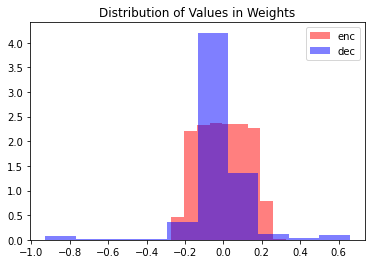

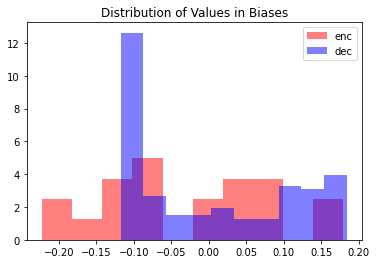

In [16]:
plt.hist(weights[0].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[2].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Weights")
plt.legend()
plt.show()

plt.hist(weights[1].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[3].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Biases")
plt.legend()
plt.show()

## EVALUATE PERFORMANCE

In [17]:
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

model.load_state_dict(torch.load(save_name))

<All keys matched successfully>

In [18]:
def print_results(model, df_large, U_large, scale, params):
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_large, df_large, params, reset_enc=True, reset_dec=True)
        
        x_rom = model.decoder(x_map)
        x_rom = model.GFN.decoder(x_rom, df_large, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False)

        error_abs_list = list()
        norm_z_list = list()
        latents_error = list()
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
        for snap in range(U_large.shape[0]):
            error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
            norm_z = np.linalg.norm(Z[:, snap], 2)
            error_abs_list.append(error_abs)
            norm_z_list.append(norm_z)
            lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
            latents_error.append(lat_err)

        latents_error = np.array(latents_error)
        print("\nMaximum relative error for latent  = ", max(latents_error))
        print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
        print("Minimum relative error for latent = ", min(latents_error))

        error = np.array(error_abs_list)
        norm = np.array(norm_z_list)
        rel_error = error/norm
        print("\nMaximum absolute error for field "+" = ", max(error))
        print("Mean absolute error for field "+" = ", sum(error)/len(error))
        print("Minimum absolute error for field "+" = ", min(error))
        print("\nMaximum relative error for field "+" = ", max(rel_error))
        print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
        print("Minimum relative error for field "+" = ", min(rel_error))

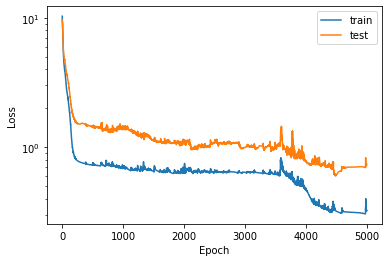

In [20]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
for i in range(len(test_mesh_names)):
    print('-'*40)
    print(f'TEST MESH: {test_mesh_names[i]}')
    scale, U = get_scaled_data(test_solution_names[i])
    U = U.to('cpu')
    df = pd.read_csv(test_mesh_names[i], header=None).values

    model.eval()
    model.to('cpu')
    print_results(model, df, U, scale, params.to('cpu'))
    print()

----------------------------------------
TEST MESH: reference_mesh_large.csv
reconstruction error tensor(9.1108e-27)

Maximum relative error for latent  =  1.0333317660173265
Mean relative error for latent =  0.05168845881874678
Minimum relative error for latent =  0.004443471370539661

Maximum absolute error for field  =  40.93433221636285
Mean absolute error for field  =  14.104831592699208
Minimum absolute error for field  =  2.8939877999184724

Maximum relative error for field  =  0.3747207516918694
Mean relative error for field  =  0.1680255877287253
Minimum relative error for field  =  0.061856230088370066

----------------------------------------
TEST MESH: reference_mesh.csv
reconstruction error tensor(4.0544e-27)

Maximum relative error for latent  =  1.0700368652600913
Mean relative error for latent =  0.05492099898871345
Minimum relative error for latent =  0.004443471768813834

Maximum absolute error for field  =  27.425382634737897
Mean absolute error for field  =  9.39221